In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = '/content/drive/MyDrive/CS368x/charts.csv'

Mounted at /content/drive


In [ ]:
!find /content/drive -type f -name "billboard_pop_songs.csv"

/content/drive/MyDrive/CS386X/billboard_pop_songs.csv


# Data Cleaning

In [ ]:
!pip install spotipy
# Step 1: Imports
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from tqdm import tqdm
import time

# Step 2: Spotify API Setup
# Replace with your own client ID and secret from https://developer.spotify.com/dashboard/
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id="3e388dd4bb0f4d2094f9ed644d10219d",
    client_secret="22a7917275a8494ba5d41042aee03659"
))

  Using cached spotipy-2.25.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached redis-5.2.1-py3-none-any.whl.metadata (9.1 kB)
Using cached spotipy-2.25.1-py3-none-any.whl (31 kB)
Using cached redis-5.2.1-py3-none-any.whl (261 kB)


In [ ]:
# Step 3: Load Billboard Dataset
charts_data = pd.read_csv('/content/drive/MyDrive/CS386X/charts.csv') # Changed to the path in Google Drive.
print("Loaded dataset with shape:", charts_data.shape)

# Step 4: Clean Artist Names (remove 'feat.' and extra stuff)
charts_data['clean_artist'] = charts_data['artist'].str.replace(r'\s+\(.*?\)', '', regex=True) \
                                 .str.replace(r'feat.*', '', regex=True) \
                                 .str.strip()

# Step 5: Define Genre Fetch Function with Cache
artist_genre_cache = {}

def get_artist_genres(artist_name):
    if artist_name in artist_genre_cache:
        return artist_genre_cache[artist_name]
    try:
        results = sp.search(q='artist:' + artist_name, type='artist', limit=1)
        items = results['artists']['items']
        if items:
            genres = items[0]['genres']
            artist_genre_cache[artist_name] = genres
            time.sleep(0.1)  # to avoid rate limit
            return genres
    except:
        pass
    artist_genre_cache[artist_name] = []
    return []

# Step 6: Get Genres for Each Artist
tqdm.pandas()
charts_data['genres'] = charts_data['clean_artist'].progress_apply(get_artist_genres)

# Step 7: Define 'is_pop' Flag
def is_pop(genre_list):
    return any("pop" in genre.lower() for genre in genre_list)

charts_data['is_pop'] = charts_data['genres'].apply(is_pop)

# Step 8: Filter to Pop Songs Only
charts_data_pop = charts_data[charts_data['is_pop']].reset_index(drop=True)
print("Filtered to pop songs:", charts_data_pop.shape)

# Step 9: Save the Pop-Only Dataset
charts_data_pop.to_csv("billboard_pop_songs.csv", index=False)
print("Pop songs dataset saved to 'billboard_pop_songs.csv'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.5/261.5 kB 7.1 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/chec

ModuleNotFoundError: No module named 'spotipy'

# More Model Cleaning

In [ ]:
# Make this only 5-10 years of pop data (take the rest out), Filter from 2011-2021

# Load the pop-only dataset
df_pop = pd.read_csv("/content/drive/MyDrive/CS386X/billboard_pop_songs.csv")

# Convert 'date' column to datetime if it's not already
df_pop['date'] = pd.to_datetime(df_pop['date'], errors='coerce')

# Filter to include only songs from 2011 to 2021
df_pop_filtered = df_pop[(df_pop['date'].dt.year >= 2011) & (df_pop['date'].dt.year <= 2021)]

# Optional: Save the new filtered dataset
df_pop_filtered.to_csv("/content/billboard_pop_songs_2011_2021.csv", index=False)

# Check shape
print("Filtered shape:", df_pop_filtered.shape)

Filtered shape: (5082, 10)


In [ ]:
# How to get audio features from Spotify API?

import pandas as pd

df = pd.read_csv("/content/billboard_pop_songs_2011_2021.csv")
print(df[['artist', 'song']].head())

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id="3e388dd4bb0f4d2094f9ed644d10219d",
    client_secret="22a7917275a8494ba5d41042aee03659"
))

import time

def get_spotify_features(artist, track):
    try:
        query = f"track:{track} artist:{artist}"
        result = sp.search(q=query, type='track', limit=1)
        tracks = result['tracks']['items']
        if tracks:
            track_id = tracks[0]['id']
            features = sp.audio_features([track_id])[0]
            metadata = {
                'spotify_track_id': track_id,
                'spotify_popularity': tracks[0]['popularity'],
                'spotify_name': tracks[0]['name'],
                'spotify_artist': tracks[0]['artists'][0]['name'],
            }
            return {**metadata, **features}
    except Exception as e:
        print(f"Error for {artist} - {track}: {e}")
    return None

       artist                      song
0        Lisa                     Money
1      Lady A               Like A Lady
2       TWICE                 The Feels
3        CKay  Love Nwantiti (Ah Ah Ah)
4  Ed Sheeran                   Shivers


In [ ]:
from tqdm import tqdm
tqdm.pandas()

df['spotify_data'] = df.progress_apply(
    lambda row: get_spotify_features(row['artist'], row['song']), axis=1
)

spotify_df = df['spotify_data'].apply(pd.Series)
df_combined = pd.concat([df, spotify_df], axis=1)

# Save it!
df_combined.to_csv("/content/billboard_pop_songs_spotify.csv", index=False)

  0%|          | 3/5082 [00:00<12:24,  6.82it/s]

Error for Lisa - Money: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7hU3IHwjX150XLoTVmjD0q:
 None, reason: None
Error for Lady A - Like A Lady: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5SulrwmIUDbU5TQQtoYHhL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=308Ir17KlNdlrbVLHWhlLe with Params: {} returned 403 due to None
  0%|          | 4/5082 [00:00<12:47,  6.62it/s]

Error for TWICE - The Feels: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=308Ir17KlNdlrbVLHWhlLe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2Xr1dTzJee307rmrkt8c0g with Params: {} returned 403 due to None
  0%|          | 6/5082 [00:00<14:42,  5.75it/s]

Error for CKay - Love Nwantiti (Ah Ah Ah): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Xr1dTzJee307rmrkt8c0g:
 None, reason: None
Error for Ed Sheeran - Shivers: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=50nfwKoDiSYg8zOCREWAm5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7uQZVznj0uQOGC9KhV2Mg6 with Params: {} returned 403 due to None
  0%|          | 8/5082 [00:01<14:36,  5.79it/s]

Error for Lisa - Lalisa: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7uQZVznj0uQOGC9KhV2Mg6:
 None, reason: None
Error for Kane Brown - One Mississippi: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4FdPnT2cFrpWCmWZd7GXc3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0rt63HYAAIzUZo5O2D0uA6 with Params: {} returned 403 due to None
  0%|          | 10/5082 [00:01<14:37,  5.78it/s]

Error for Ed Sheeran - Visiting Hours: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0rt63HYAAIzUZo5O2D0uA6:
 None, reason: None
Error for Dua Lipa - Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d with Params: {} returned 403 due to None
  0%|          | 12/5082 [00:02<14:42,  5.74it/s]

Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None
Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe with Params: {} returned 403 due to None
  0%|          | 14/5082 [00:02<14:35,  5.79it/s]

Error for AJR - Way Less Sad: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe:
 None, reason: None
Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3eZYOQO4UzKrUDYDghtnFw with Params: {} returned 403 due to None
  0%|          | 16/5082 [00:02<14:50,  5.69it/s]

Error for Ariana Grande - Test Drive: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3eZYOQO4UzKrUDYDghtnFw:
 None, reason: None
Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1v3lhrZEsOcazqR2QIyyRu with Params: {} returned 403 due to None
  0%|          | 18/5082 [00:03<14:05,  5.99it/s]

Error for Selena Gomez - De Una Vez: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1v3lhrZEsOcazqR2QIyyRu:
 None, reason: None
Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID with Params: {} returned 403 due to None
  0%|          | 20/5082 [00:03<15:00,  5.62it/s]

Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None
Error for The Beach Boys - Little Saint Nick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5xlS0QkVrSH7ssEbBgBzbM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq with Params: {} returned 403 due to None
  0%|          | 22/5082 [00:03<15:24,  5.48it/s]

Error for Ed Sheeran - Afterglow: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq:
 None, reason: None
Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF with Params: {} returned 403 due to None
  0%|          | 23/5082 [00:03<15:10,  5.56it/s]

Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33 with Params: {} returned 403 due to None
  0%|          | 25/5082 [00:04<15:27,  5.45it/s]

Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None
Error for Ariana Grande - Just Like Magic: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dx9Z6Aon1qPS2N0rHSWTe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3ko9jEHNt4O5fjKN65ULJp with Params: {} returned 403 due to None
  1%|          | 27/5082 [00:04<14:59,  5.62it/s]

Error for Ariana Grande - Shut Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3ko9jEHNt4O5fjKN65ULJp:
 None, reason: None
Error for Ariana Grande - Nasty: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0sci7ppTZFm4mjcH3nu8yO:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2IKJtXeR5UsaUjZB46fTOK with Params: {} returned 403 due to None
  1%|          | 29/5082 [00:05<14:20,  5.87it/s]

Error for Ariana Grande - Six Thirty: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2IKJtXeR5UsaUjZB46fTOK:
 None, reason: None
Error for Ariana Grande - My Hair: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6u7gmPOz7pzzaeR9xSBpsR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0q85C1JiECyYIQthz1posA with Params: {} returned 403 due to None
  1%|          | 31/5082 [00:05<15:19,  5.49it/s]

Error for Ariana Grande - Obvious: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0q85C1JiECyYIQthz1posA:
 None, reason: None
Error for Ariana Grande - West Side: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1whfVLMKWqAX3uk97VXsNN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6NYtLvyThMT0oALFdJFdzq with Params: {} returned 403 due to None
  1%|          | 33/5082 [00:05<15:01,  5.60it/s]

Error for Ariana Grande - Love Language: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6NYtLvyThMT0oALFdJFdzq:
 None, reason: None
Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r with Params: {} returned 403 due to None
  1%|          | 35/5082 [00:06<14:52,  5.66it/s]

Error for Lady A - Champagne Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r:
 None, reason: None
Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7B3z0ySL9Rr0XvZEAjWZzM with Params: {} returned 403 due to None
  1%|          | 37/5082 [00:06<15:16,  5.50it/s]

Error for Clairo - Sofia: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7B3z0ySL9Rr0XvZEAjWZzM:
 None, reason: None
Error for BLACKPINK - Lovesick Girls: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4Ws314Ylb27BVsvlZOy30C:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9 with Params: {} returned 403 due to None
  1%|          | 39/5082 [00:06<14:58,  5.61it/s]

Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None
Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w with Params: {} returned 403 due to None
  1%|          | 40/5082 [00:07<16:44,  5.02it/s]

Error for Matt Stell - Everywhere But On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b with Params: {} returned 403 due to None
  1%|          | 42/5082 [00:07<16:19,  5.14it/s]

Error for Maroon 5 - Nobody's Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b:
 None, reason: None
Error for BLACKPINK - How You Like That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SFknyjLcyTLJFPKD2m96o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
  1%|          | 43/5082 [00:07<16:34,  5.06it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=431M98gFekRc9HdNfgWc7N with Params: {} returned 403 due to None


Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


  1%|          | 45/5082 [00:08<16:01,  5.24it/s]

Error for Kane Brown - Worldwide Beautiful: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=431M98gFekRc9HdNfgWc7N:
 None, reason: None
Error for Lady Gaga - Alice: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=41A89rj3GoMG6ktN37L7PG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0JKGe340YJwfDrpXqPQ8sw with Params: {} returned 403 due to None
  1%|          | 47/5082 [00:08<14:28,  5.80it/s]

Error for Agust D - Daechwita: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JKGe340YJwfDrpXqPQ8sw:
 None, reason: None
Error for Katy Perry - Daisies: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4uqh9bualXNHXXwO2wPorc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs with Params: {} returned 403 due to None
  1%|          | 49/5082 [00:08<14:23,  5.83it/s]

Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None
Error for Selena Gomez - Boyfriend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5EBtY2shIV1vmY4bnvvV6T:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
  1%|          | 51/5082 [00:09<14:43,  5.69it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd with Params: {} returned 403 due to None
  1%|          | 52/5082 [00:09<15:07,  5.54it/s]

Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt with Params: {} returned 403 due to None
  1%|          | 53/5082 [00:09<15:52,  5.28it/s]

Error for Lady Gaga - Stupid Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4mt7C6wYeTUWDDk7xKym9w with Params: {} returned 403 due to None
  1%|          | 55/5082 [00:09<15:39,  5.35it/s]

Error for Selena Gomez - Feel Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4mt7C6wYeTUWDDk7xKym9w:
 None, reason: None
Error for Sam Smith - To Die For: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ZTYlnhhV1UAReg7wIGolx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1SdQjKRW52cHg2SEesQLvH with Params: {} returned 403 due to None
  1%|          | 57/5082 [00:10<15:25,  5.43it/s]

Error for Dua Lipa - Physical: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1SdQjKRW52cHg2SEesQLvH:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7HMmFQsKsljwTw8bS7lu19 with Params: {} returned 403 due to None
  1%|          | 59/5082 [00:10<14:38,  5.72it/s]

Error for Selena Gomez - Rare: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7HMmFQsKsljwTw8bS7lu19:
 None, reason: None
Error for John Legend - Conversations In The Dark: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0QjQC8sGqxUkaJFBsJjtGm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1x0NszvaftnHtijIId3ivk with Params: {} returned 403 due to None
  1%|          | 61/5082 [00:10<14:20,  5.84it/s]

Error for John Legend - Happy Xmas (War Is Over): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x0NszvaftnHtijIId3ivk:
 None, reason: None
Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
  1%|          | 63/5082 [00:11<14:21,  5.82it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Kane Brown - For My Daughter: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2moC0T4mGwmP8dUDostr2g:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7eOkHIcaoUhngxxypM5Ajr with Params: {} returned 403 due to None
  1%|▏         | 65/5082 [00:11<14:10,  5.90it/s]

Error for Selena Gomez - Look At Her Now.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7eOkHIcaoUhngxxypM5Ajr:
 None, reason: None
Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0 with Params: {} returned 403 due to None
  1%|▏         | 67/5082 [00:11<14:10,  5.89it/s]

Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None
Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC with Params: {} returned 403 due to None
  1%|▏         | 69/5082 [00:12<13:52,  6.02it/s]

Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None
Error for Kelsea Ballerini - homecoming queen?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4ElNxglBjcrASiGn58t9Jm with Params: {} returned 403 due to None
  1%|▏         | 71/5082 [00:12<14:05,  5.93it/s]

Error for for KING & COUNTRY - God Only Knows: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ElNxglBjcrASiGn58t9Jm:
 None, reason: None
Error for Katy Perry - Small Talk: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4NmE2ytXI8S2svTRSmEdpO:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6 with Params: {} returned 403 due to None
  1%|▏         | 73/5082 [00:12<14:31,  5.75it/s]

Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None
Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7z3dPHwGxeK4fD6fYFDwiS with Params: {} returned 403 due to None
  1%|▏         | 75/5082 [00:13<13:45,  6.06it/s]

Error for Kane Brown - Like A Rodeo: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7z3dPHwGxeK4fD6fYFDwiS:
 None, reason: None
Error for Katy Perry - Never Really Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6 with Params: {} returned 403 due to None
  2%|▏         | 77/5082 [00:13<14:17,  5.84it/s]

Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6hvczQ05jc1yGlp9zhb95V with Params: {} returned 403 due to None
  2%|▏         | 78/5082 [00:13<14:06,  5.91it/s]

Error for BLACKPINK - Kill This Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hvczQ05jc1yGlp9zhb95V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2swZ0X1njeU32SNJeBKIfW with Params: {} returned 403 due to None
  2%|▏         | 80/5082 [00:14<15:18,  5.45it/s]

Error for Aventura - Inmortal: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2swZ0X1njeU32SNJeBKIfW:
 None, reason: None
Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15 with Params: {} returned 403 due to None
  2%|▏         | 82/5082 [00:15<32:54,  2.53it/s]

Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None
Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS with Params: {} returned 403 due to None
  2%|▏         | 84/5082 [00:15<23:19,  3.57it/s]

Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None
Error for Ariana Grande - Needy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TEL6MlSSVLSdhOSddidlJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4uTvPEr01pjTbZgl7jcKBD with Params: {} returned 403 due to None
  2%|▏         | 86/5082 [00:16<19:16,  4.32it/s]

Error for Ariana Grande - NASA: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4uTvPEr01pjTbZgl7jcKBD:
 None, reason: None
Error for Ariana Grande - Bloodline: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2hloaUoRonYssMuqLCBLTX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2vdBo4ALPYbHRUPKgtE5iC with Params: {} returned 403 due to None
  2%|▏         | 88/5082 [00:16<16:15,  5.12it/s]

Error for Ariana Grande - Ghostin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2vdBo4ALPYbHRUPKgtE5iC:
 None, reason: None
Error for Ariana Grande - Fake Smile: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wFLWP0FcIqHK1wb1CPthQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Il6Oe7lr5XM7A0cWbVQtr with Params: {} returned 403 due to None
  2%|▏         | 89/5082 [00:16<15:53,  5.24it/s]

Error for Ariana Grande - Bad Idea: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Il6Oe7lr5XM7A0cWbVQtr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4T652DlATVHe0jdLKaN3Bw with Params: {} returned 403 due to None
  2%|▏         | 91/5082 [00:17<15:53,  5.24it/s]

Error for Ariana Grande - In My Head: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4T652DlATVHe0jdLKaN3Bw:
 None, reason: None
Error for Ariana Grande - Make Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27356GVuMPFWiJSZCragoM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2 with Params: {} returned 403 due to None
  2%|▏         | 93/5082 [00:17<15:50,  5.25it/s]

Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None
Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=39LmTF9RgyakzSYX8txrow with Params: {} returned 403 due to None
  2%|▏         | 95/5082 [00:17<15:55,  5.22it/s]

Error for Ariana Grande - Imagine: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=39LmTF9RgyakzSYX8txrow:
 None, reason: None
Error for Katy Perry - Cozy Little Christmas: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=02FaKXXL7KUtRc7K0k54tL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=77dLL5ctI7j2BYb3ss7k8m with Params: {} returned 403 due to None
  2%|▏         | 97/5082 [00:18<15:14,  5.45it/s]

Error for Lauren Daigle - The Christmas Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77dLL5ctI7j2BYb3ss7k8m:
 None, reason: None
Error for AJR - Burn The House Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2QKLrgXNQtK2c8QbLRO3XC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI with Params: {} returned 403 due to None
  2%|▏         | 99/5082 [00:18<14:37,  5.68it/s]

Error for Thomas Rhett - Sixteen: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI:
 None, reason: None
Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4A7EkKijzA4ryEoCRWJzdG with Params: {} returned 403 due to None
  2%|▏         | 101/5082 [00:18<14:05,  5.89it/s]

Error for Lady Gaga - I'll Never Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4A7EkKijzA4ryEoCRWJzdG:
 None, reason: None
Error for Lady Gaga - Always Remember Us This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2rbDhOo9Fh61Bbu23T2qCk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=172e82oK9vGoBPvc6SqMm5 with Params: {} returned 403 due to None
  2%|▏         | 103/5082 [00:19<13:47,  6.02it/s]

Error for Lady Gaga - Is That Alright?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=172e82oK9vGoBPvc6SqMm5:
 None, reason: None
Error for Charlie Puth - The Way I Am: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6qNALlmZa1ESnCxJmXE1K9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J with Params: {} returned 403 due to None
  2%|▏         | 105/5082 [00:19<15:17,  5.42it/s]

Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None
Error for Ariana Grande - Sweetener: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=70khXICDeTTxgYtw3EysKH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0WdR2AyLW1Drd3OUdwezM0 with Params: {} returned 403 due to None
  2%|▏         | 107/5082 [00:20<14:57,  5.54it/s]

Error for Ariana Grande - Everytime: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0WdR2AyLW1Drd3OUdwezM0:
 None, reason: None
Error for Ariana Grande - R.E.M: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1xWH8zYtDeS9mW1JJG23VZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=14kYOiFVPb7E7NfFbqhdln with Params: {} returned 403 due to None
  2%|▏         | 109/5082 [00:20<14:53,  5.57it/s]

Error for Ariana Grande - Goodnight N Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=14kYOiFVPb7E7NfFbqhdln:
 None, reason: None
Error for Ariana Grande - Pete Davidson: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0XOnMqLQDO89iAg7dWWwnG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7BXW1QCg56yzEBV8pW8pah with Params: {} returned 403 due to None
  2%|▏         | 111/5082 [00:20<14:44,  5.62it/s]

Error for Jason Mraz - Have It All: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BXW1QCg56yzEBV8pW8pah:
 None, reason: None
Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
  2%|▏         | 113/5082 [00:21<14:15,  5.81it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Thomas Rhett - Life Changes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4lQsB3ERTWSNaAN1IkuNRl with Params: {} returned 403 due to None
  2%|▏         | 115/5082 [00:21<13:43,  6.04it/s]

Error for BLACKPINK - DDU-DU DDU-DU: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lQsB3ERTWSNaAN1IkuNRl:
 None, reason: None
Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16 with Params: {} returned 403 due to None
  2%|▏         | 116/5082 [00:21<13:45,  6.01it/s]

Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5eFfsbjSouG8qOpg9ZqDl6 with Params: {} returned 403 due to None
  2%|▏         | 119/5082 [00:22<13:53,  5.95it/s]

Error for Sam Hunt - Downtown's Dead: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5eFfsbjSouG8qOpg9ZqDl6:
 None, reason: None
Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo with Params: {} returned 403 due to None
  2%|▏         | 120/5082 [00:22<14:05,  5.87it/s]

Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fXwCWkh6YG5zU1IyvQrbs with Params: {} returned 403 due to None
  2%|▏         | 122/5082 [00:22<15:03,  5.49it/s]

Error for SZA - Broken Clocks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fXwCWkh6YG5zU1IyvQrbs:
 None, reason: None
Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc with Params: {} returned 403 due to None
  2%|▏         | 123/5082 [00:22<14:58,  5.52it/s]

Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6vlxmQGwmlyp07YjkugV6K with Params: {} returned 403 due to None
  2%|▏         | 125/5082 [00:23<15:44,  5.25it/s]

Error for Kelsea Ballerini - Legends: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6vlxmQGwmlyp07YjkugV6K:
 None, reason: None
Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
  2%|▏         | 127/5082 [00:23<15:37,  5.29it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=31x4wWBghN7f5PiEZUmcAW with Params: {} returned 403 due to None
  3%|▎         | 129/5082 [00:24<18:49,  4.39it/s]

Error for Florida Georgia Line - Smooth: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=31x4wWBghN7f5PiEZUmcAW:
 None, reason: None
Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4iLeL1aYGcQBsYcWIhXIUO with Params: {} returned 403 due to None
  3%|▎         | 130/5082 [00:24<17:44,  4.65it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Kane Brown - Found You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4iLeL1aYGcQBsYcWIhXIUO:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ with Params: {} returned 403 due to None
  3%|▎         | 132/5082 [00:25<34:37,  2.38it/s]

Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None
Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
  3%|▎         | 134/5082 [00:26<24:56,  3.31it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for Romeo Santos - Imitadora: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r46lnXFbE9fr2d3KNaGbe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul with Params: {} returned 403 due to None
  3%|▎         | 136/5082 [00:26<19:49,  4.16it/s]

Error for Selena Gomez - Bad Liar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul:
 None, reason: None
Error for Shakira - Me Enamore: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qknM1pQz53QOyfDVTjcM9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
  3%|▎         | 138/5082 [00:26<17:52,  4.61it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Paramore - Hard Times: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0w5Bdu51Ka25Pf3hojsKHh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5 with Params: {} returned 403 due to None
  3%|▎         | 140/5082 [00:27<16:15,  5.07it/s]

Error for Lady Gaga - The Cure: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5:
 None, reason: None
Error for AJR - Weak: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2sVcBaVtBPM9vIFk1Jnbw8:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
  3%|▎         | 142/5082 [00:27<15:09,  5.43it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=51ChrwmUPDJvedPQnIU8Ls with Params: {} returned 403 due to None
  3%|▎         | 144/5082 [00:27<14:42,  5.59it/s]

Error for Ed Sheeran - Dive: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=51ChrwmUPDJvedPQnIU8Ls:
 None, reason: None
Error for Ed Sheeran - Galway Girl: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0afhq8XCExXpqazXczTSve:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2RttW7RAu5nOAfq6YFvApB with Params: {} returned 403 due to None
  3%|▎         | 145/5082 [00:28<14:31,  5.67it/s]

Error for Ed Sheeran - Happier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2RttW7RAu5nOAfq6YFvApB:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5HDPtsnyb3maFmPL8LLUTG with Params: {} returned 403 due to None
  3%|▎         | 147/5082 [00:28<14:49,  5.55it/s]

Error for Ed Sheeran - New Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5HDPtsnyb3maFmPL8LLUTG:
 None, reason: None
Error for Ed Sheeran - Supermarket Flowers: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4VuS959DSpr82t3qBqCrWG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2pJZ1v8HezrAoZ0Fhzby92 with Params: {} returned 403 due to None
  3%|▎         | 149/5082 [00:28<14:35,  5.64it/s]

Error for Ed Sheeran - What Do I Know?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2pJZ1v8HezrAoZ0Fhzby92:
 None, reason: None
Error for Ed Sheeran - Eraser: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7oolFzHipTMg2nL7shhdz2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2dfHh7ECGxfNqZTQno09Vk with Params: {} returned 403 due to None
  3%|▎         | 151/5082 [00:29<14:35,  5.63it/s]

Error for Ed Sheeran - Hearts Don't Break Around Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2dfHh7ECGxfNqZTQno09Vk:
 None, reason: None
Error for Ed Sheeran - Barcelona: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3Lfiu5sZ4M4B6JaKMBc0FU:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PJ8FF6UR8FZXfEvpHkIVN with Params: {} returned 403 due to None
  3%|▎         | 153/5082 [00:29<15:28,  5.31it/s]

Error for Ed Sheeran - How Would You Feel (Paean): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PJ8FF6UR8FZXfEvpHkIVN:
 None, reason: None
Error for Sia - Helium: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4S6fv0puLCsfYjyBTPDb9k:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6BdAwMv1YorLfkBWlE493X with Params: {} returned 403 due to None
  3%|▎         | 155/5082 [00:30<15:04,  5.45it/s]

Error for Romeo Santos - Heroe Favorito: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6BdAwMv1YorLfkBWlE493X:
 None, reason: None
Error for Kelsea Ballerini - Yeah Boy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
  3%|▎         | 157/5082 [00:30<14:30,  5.66it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Calum Scott - Dancing On My Own: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2BOqDYLOJBiMOXShCV1neZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
  3%|▎         | 159/5082 [00:30<14:03,  5.84it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=228kFdBgjLDmmdygT9Hxxo with Params: {} returned 403 due to None
  3%|▎         | 160/5082 [00:30<15:04,  5.44it/s]

Error for Sam Hunt - Drinkin' Too Much: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=228kFdBgjLDmmdygT9Hxxo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi with Params: {} returned 403 due to None
  3%|▎         | 161/5082 [00:31<15:45,  5.21it/s]

Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q with Params: {} returned 403 due to None
  3%|▎         | 163/5082 [00:31<16:19,  5.02it/s]

Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None
Error for Lady Gaga - A-YO: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Az2Ll2CPnWYQ2BgiHf4Di:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
  3%|▎         | 165/5082 [00:31<15:28,  5.30it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None
Error for Dua Lipa - Blow Your Mind (Mwah): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2eAAEa8pxKF7My0EO4rFgR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89 with Params: {} returned 403 due to None
  3%|▎         | 167/5082 [00:32<15:43,  5.21it/s]

Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None
Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5mQNY6pTeSDl2doFB7uLbE with Params: {} returned 403 due to None
  3%|▎         | 169/5082 [00:32<15:02,  5.44it/s]

Error for OneRepublic - Kids: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5mQNY6pTeSDl2doFB7uLbE:
 None, reason: None
Error for Lady Gaga - Perfect Illusion: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=56ZrTFkANjeAMiS14njg4E:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1CwNogTShsnsn1C8UhRmYX with Params: {} returned 403 due to None
  3%|▎         | 171/5082 [00:33<15:18,  5.35it/s]

Error for Katy Perry - Rise: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1CwNogTShsnsn1C8UhRmYX:
 None, reason: None
Error for Blink-182 - Bored To Death: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=12YGKHMw1l36tXlgU2Vrjj:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2I5ao7JannZZMlweLTz0hO with Params: {} returned 403 due to None
  3%|▎         | 173/5082 [00:33<14:30,  5.64it/s]

Error for Kane Brown - Ain't No Stopping Us Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2I5ao7JannZZMlweLTz0hO:
 None, reason: None
Error for Selena Gomez - Kill Em With Kindness: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo with Params: {} returned 403 due to None
  3%|▎         | 175/5082 [00:33<13:30,  6.06it/s]

Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None
Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk with Params: {} returned 403 due to None
  3%|▎         | 177/5082 [00:33<13:20,  6.13it/s]

Error for OneRepublic - Wherever I Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N with Params: {} returned 403 due to None
  4%|▎         | 179/5082 [00:34<14:39,  5.57it/s]

Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None
Error for Ariana Grande - Be Alright: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1MkFj1ThZZxjYMNkczx9mk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN with Params: {} returned 403 due to None
  4%|▎         | 180/5082 [00:34<14:29,  5.64it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ with Params: {} returned 403 due to None
  4%|▎         | 182/5082 [00:35<31:50,  2.56it/s]

Error for Shakira - Try Everything: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ:
 None, reason: None
Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0bCCGLHflR08UVA6oJJc8I with Params: {} returned 403 due to None
  4%|▎         | 184/5082 [00:37<38:07,  2.14it/s]

Error for Lady Gaga - Til It Happens To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0bCCGLHflR08UVA6oJJc8I:
 None, reason: None
Error for The Lumineers - Ophelia: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm with Params: {} returned 403 due to None
  4%|▎         | 185/5082 [00:37<30:35,  2.67it/s]

Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1 with Params: {} returned 403 due to None
  4%|▎         | 187/5082 [00:37<22:35,  3.61it/s]

Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None
Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR with Params: {} returned 403 due to None
  4%|▎         | 189/5082 [00:38<18:40,  4.37it/s]

Error for Ariana Grande - Focus: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR:
 None, reason: None
Error for Kane Brown - Used To Love You Sober: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6V3wTb4VVDWRw3YEDgc6Py:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv with Params: {} returned 403 due to None
  4%|▎         | 190/5082 [00:38<17:42,  4.60it/s]

Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71 with Params: {} returned 403 due to None
  4%|▍         | 192/5082 [00:39<31:45,  2.57it/s]

Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None
Error for Sia - Alive: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=25R5Tdr4K7ENb6umHzdCXn:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1PWnAEQcbwQwK759otUbta with Params: {} returned 403 due to None
  4%|▍         | 194/5082 [00:39<22:27,  3.63it/s]

Error for Sam Smith - Writing's On The Wall: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1PWnAEQcbwQwK759otUbta:
 None, reason: None
Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59 with Params: {} returned 403 due to None
  4%|▍         | 196/5082 [00:40<17:57,  4.53it/s]

Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None
Error for Sam Smith - Like I Can: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2TeLIzFBe3hxkPR5FIQZut:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0 with Params: {} returned 403 due to None
  4%|▍         | 198/5082 [00:40<15:42,  5.18it/s]

Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None
Error for Sawyer Fredericks - Please: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2pTnrrRF6creKP8lVDpgqw:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2Yh8cnpddujSLPOVJKlSDt with Params: {} returned 403 due to None
  4%|▍         | 199/5082 [00:40<15:09,  5.37it/s]

Error for Sawyer Fredericks - Old Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Yh8cnpddujSLPOVJKlSDt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
  4%|▍         | 202/5082 [00:41<12:39,  6.43it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None
Error for Sawyer Fredericks - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1xbtFabmTCcxN0gozYj2AZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7pa2J8FSpn0Jg0FLKj9NV1 with Params: {} returned 403 due to None
  4%|▍         | 204/5082 [00:41<13:00,  6.25it/s]

Error for Sawyer Fredericks - Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7pa2J8FSpn0Jg0FLKj9NV1:
 None, reason: None
Error for Sawyer Fredericks - Simple Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0T72I759rYATKkzQzZGyWs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7hJgVpoFFU1gJDAbYPYF2l with Params: {} returned 403 due to None
  4%|▍         | 206/5082 [00:41<13:15,  6.13it/s]

Error for Sawyer Fredericks - Iris: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7hJgVpoFFU1gJDAbYPYF2l:
 None, reason: None
Error for Sawyer Fredericks - Imagine: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5fKbkAwQqPNF7Us0UUFNJK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy with Params: {} returned 403 due to None
  4%|▍         | 208/5082 [00:42<13:27,  6.04it/s]

Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None
Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd with Params: {} returned 403 due to None
  4%|▍         | 210/5082 [00:42<13:25,  6.05it/s]

Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None
Error for Annie Lennox - I Put A Spell On You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6HChE1b3T5ke2XA50t9kGd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1w9ta1CvXlJPRXh6Py2Mto with Params: {} returned 403 due to None
  4%|▍         | 211/5082 [00:42<13:10,  6.16it/s]

Error for Florence + The Machine - What Kind Of Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1w9ta1CvXlJPRXh6Py2Mto:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh with Params: {} returned 403 due to None
  4%|▍         | 213/5082 [00:42<14:06,  5.75it/s]

Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None
Error for Fall Out Boy - Immortals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3Te8uLyit6X3ncNW8Fp3K2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
  4%|▍         | 215/5082 [00:43<14:23,  5.63it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
  4%|▍         | 217/5082 [00:43<14:18,  5.67it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None
Error for Fall Out Boy - Irresistible: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
  4%|▍         | 219/5082 [00:44<14:23,  5.63it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None
Error for Sam Smith - Have Yourself A Merry Little Christmas: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Qi2wh8fFgDV7tl4Sj3f2K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0A5qqtFMG1qrNQEcjvr1A2 with Params: {} returned 403 due to None
  4%|▍         | 221/5082 [00:44<13:58,  5.80it/s]

Error for Charli XCX - Break The Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0A5qqtFMG1qrNQEcjvr1A2:
 None, reason: None
Error for Ed Sheeran - Make It Rain: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5puU24G3lHVsUXPAWW2ZpV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0lizgQ7Qw35od7CYaoMBZb with Params: {} returned 403 due to None
  4%|▍         | 222/5082 [00:44<18:15,  4.44it/s]

Error for Ariana Grande - Santa Tell Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0lizgQ7Qw35od7CYaoMBZb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo with Params: {} returned 403 due to None
  4%|▍         | 224/5082 [00:47<1:00:29,  1.34it/s]

Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None
Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA with Params: {} returned 403 due to None
  4%|▍         | 226/5082 [00:48<36:57,  2.19it/s]

Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None
Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
  4%|▍         | 228/5082 [00:48<24:57,  3.24it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Florida Georgia Line - Bumpin' The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ygp81TQpolYKghQjdYZpD:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K with Params: {} returned 403 due to None
  5%|▍         | 230/5082 [00:48<20:12,  4.00it/s]

Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None
Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq with Params: {} returned 403 due to None
  5%|▍         | 232/5082 [00:49<16:40,  4.85it/s]

Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None
Error for Train - Angel In Blue Jeans: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2GxGYGrixbXPFojONbzdo9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x with Params: {} returned 403 due to None
  5%|▍         | 233/5082 [00:49<15:44,  5.13it/s]

Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2PLo8T3kGE9URFvBy3tUdt with Params: {} returned 403 due to None
  5%|▍         | 234/5082 [00:49<16:02,  5.04it/s]

Error for Maroon 5 - It Was Always You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2PLo8T3kGE9URFvBy3tUdt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn with Params: {} returned 403 due to None
  5%|▍         | 236/5082 [00:49<18:21,  4.40it/s]

Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None
Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=55nlbqqFVnSsArIeYSQlqx with Params: {} returned 403 due to None
  5%|▍         | 238/5082 [00:50<16:22,  4.93it/s]

Error for John Legend - You & I (Nobody In The World): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=55nlbqqFVnSsArIeYSQlqx:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk with Params: {} returned 403 due to None
  5%|▍         | 240/5082 [00:50<16:03,  5.03it/s]

Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None
Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=12B0Twa9kRz45Xw2PgXHJm with Params: {} returned 403 due to None
  5%|▍         | 242/5082 [00:51<15:06,  5.34it/s]

Error for Ed Sheeran - Afire Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=12B0Twa9kRz45Xw2PgXHJm:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC with Params: {} returned 403 due to None
  5%|▍         | 243/5082 [00:51<14:36,  5.52it/s]

Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
  5%|▍         | 245/5082 [00:51<14:50,  5.43it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for AJR - I'm Ready: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS with Params: {} returned 403 due to None
  5%|▍         | 247/5082 [00:51<14:34,  5.53it/s]

Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None
Error for Sam Smith - Leave Your Lover: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3b5LW3nS3WFQyS1e8ajGJN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2 with Params: {} returned 403 due to None
  5%|▍         | 248/5082 [00:52<15:22,  5.24it/s]

Error for Shakira - Dare (La La La): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5TvFfDlVoUWZvfqrhTJzD7 with Params: {} returned 403 due to None
  5%|▍         | 249/5082 [00:52<16:53,  4.77it/s]

Error for Ed Sheeran - One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5TvFfDlVoUWZvfqrhTJzD7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
  5%|▍         | 251/5082 [00:53<27:36,  2.92it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop with Params: {} returned 403 due to None
  5%|▍         | 253/5082 [00:53<20:57,  3.84it/s]

Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None
Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
  5%|▌         | 255/5082 [00:54<18:24,  4.37it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for Shakira - Empire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4rYLpaNFzt6pkQnrCvVHUw with Params: {} returned 403 due to None
  5%|▌         | 257/5082 [00:54<17:04,  4.71it/s]

Error for Lady Gaga - G.U.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rYLpaNFzt6pkQnrCvVHUw:
 None, reason: None
Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz with Params: {} returned 403 due to None
  5%|▌         | 259/5082 [00:55<15:03,  5.34it/s]

Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None
Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2vV6LiBLvVXMBJTyO1ptlz with Params: {} returned 403 due to None
  5%|▌         | 261/5082 [00:55<13:41,  5.87it/s]

Error for Enrique Iglesias - Heart Attack: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2vV6LiBLvVXMBJTyO1ptlz:
 None, reason: None
Error for Fall Out Boy - Alone Together: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MsZIaCYY6Tsdph0LiB0hE:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5xDrO9DEDJGUQGfyoHvgDJ with Params: {} returned 403 due to None
  5%|▌         | 263/5082 [00:55<13:47,  5.82it/s]

Error for Ariana Grande - Last Christmas: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5xDrO9DEDJGUQGfyoHvgDJ:
 None, reason: None
Error for Lady Gaga - Dope: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1gPCk3KUE83rPdz9QqGsX9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DOgMeHlNponAEqczZoxX0 with Params: {} returned 403 due to None
  5%|▌         | 265/5082 [00:56<14:05,  5.70it/s]

Error for Britney Spears - Perfume: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DOgMeHlNponAEqczZoxX0:
 None, reason: None
Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3n3S5cH3IyaOswY2XSUGTS with Params: {} returned 403 due to None
  5%|▌         | 267/5082 [00:56<13:55,  5.76it/s]

Error for Lady Gaga - Venus: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3n3S5cH3IyaOswY2XSUGTS:
 None, reason: None
Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt with Params: {} returned 403 due to None
  5%|▌         | 269/5082 [00:56<14:14,  5.63it/s]

Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None
Error for Katy Perry - Walking On Air: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0RCsGhR44nFVAd5WiZZcGq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1 with Params: {} returned 403 due to None
  5%|▌         | 270/5082 [00:56<14:42,  5.45it/s]

Error for Britney Spears - Work B**ch!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PycBIeabfvX3n9ILG7Vrv with Params: {} returned 403 due to None
  5%|▌         | 272/5082 [00:57<15:04,  5.32it/s]

Error for Romeo Santos - Propuesta Indecente: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PycBIeabfvX3n9ILG7Vrv:
 None, reason: None
Error for Arcade Fire - Reflektor: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7uMZy0bALAdneerERyr7Ks:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
  5%|▌         | 274/5082 [00:57<14:28,  5.54it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Prince Royce - Darte Un Beso: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex with Params: {} returned 403 due to None
  5%|▌         | 276/5082 [00:58<14:12,  5.64it/s]

Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4e3RCQgj1P4Fa7d86y2qT2 with Params: {} returned 403 due to None
  5%|▌         | 278/5082 [00:58<13:41,  5.85it/s]

Error for Enrique Iglesias - Turn The Night Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4e3RCQgj1P4Fa7d86y2qT2:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6NmCCgnQcxKHPOAKgd9Nth with Params: {} returned 403 due to None
  6%|▌         | 280/5082 [00:58<13:31,  5.91it/s]

Error for Ariana Grande - Baby I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6NmCCgnQcxKHPOAKgd9Nth:
 None, reason: None
Error for Lady Antebellum - Goodbye Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
  6%|▌         | 281/5082 [00:58<13:45,  5.82it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7bpvfjoneSQvW0tbtVm1Jk with Params: {} returned 403 due to None
  6%|▌         | 283/5082 [00:59<14:18,  5.59it/s]

Error for Britney Spears - Ooh La La: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7bpvfjoneSQvW0tbtVm1Jk:
 None, reason: None
Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M with Params: {} returned 403 due to None
  6%|▌         | 285/5082 [00:59<15:14,  5.24it/s]

Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None
Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS with Params: {} returned 403 due to None
  6%|▌         | 287/5082 [01:00<14:19,  5.58it/s]

Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None
Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d with Params: {} returned 403 due to None
  6%|▌         | 289/5082 [01:00<13:40,  5.84it/s]

Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None
Error for WE the Kings - Just Keep Breathing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=67auzVdRGQ4u0ONv2U3WIs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7jwDuO7UZvWs77KNj9HbvF with Params: {} returned 403 due to None
  6%|▌         | 291/5082 [01:00<14:16,  5.59it/s]

Error for Fall Out Boy - The Phoenix: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7jwDuO7UZvWs77KNj9HbvF:
 None, reason: None
Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fdd8W8eTym1gWO1dl1nxo with Params: {} returned 403 due to None
  6%|▌         | 293/5082 [01:01<14:09,  5.64it/s]

Error for Britt Nicole - Gold: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fdd8W8eTym1gWO1dl1nxo:
 None, reason: None
Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI with Params: {} returned 403 due to None
  6%|▌         | 295/5082 [01:01<13:34,  5.88it/s]

Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None
Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1hZk9dktp4yRFTm0TrycuH with Params: {} returned 403 due to None
  6%|▌         | 297/5082 [01:01<14:42,  5.42it/s]

Error for OneRepublic - If I Lose Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hZk9dktp4yRFTm0TrycuH:
 None, reason: None
Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb with Params: {} returned 403 due to None
  6%|▌         | 299/5082 [01:02<13:50,  5.76it/s]

Error for The Lumineers - Stubborn Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb:
 None, reason: None
Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qIgyDoc2rwtq8w49jeWL8 with Params: {} returned 403 due to None
  6%|▌         | 301/5082 [01:02<13:44,  5.80it/s]

Error for Green Day - Oh Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qIgyDoc2rwtq8w49jeWL8:
 None, reason: None
Error for Thomas Rhett - Something To Do With My Hands: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6iWg88k0UH7BjBP2yWXM0i:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
  6%|▌         | 303/5082 [01:02<14:24,  5.53it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1c2MXiju7DNPSfsKoVbHlg with Params: {} returned 403 due to None
  6%|▌         | 305/5082 [01:03<14:58,  5.31it/s]

Error for Maroon 5 - Wipe Your Eyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1c2MXiju7DNPSfsKoVbHlg:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
  6%|▌         | 307/5082 [01:03<16:03,  4.95it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
  6%|▌         | 309/5082 [01:04<14:55,  5.33it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz with Params: {} returned 403 due to None
  6%|▌         | 310/5082 [01:04<14:40,  5.42it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
  6%|▌         | 311/5082 [01:05<39:45,  2.00it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
  6%|▌         | 313/5082 [01:05<27:18,  2.91it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl with Params: {} returned 403 due to None
  6%|▌         | 315/5082 [01:06<20:45,  3.83it/s]

Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None
Error for Britney Spears - Criminal: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6T689Jvh5KrSXyaPtUWZtQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG with Params: {} returned 403 due to None
  6%|▌         | 316/5082 [01:06<18:38,  4.26it/s]

Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27H8WsrkD5catdc3a2fCLV with Params: {} returned 403 due to None
  6%|▌         | 317/5082 [01:06<18:18,  4.34it/s]

Error for Blink-182 - After Midnight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27H8WsrkD5catdc3a2fCLV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=129Q7yqxyiAz66mAd9BJgs with Params: {} returned 403 due to None
  6%|▋         | 319/5082 [01:07<16:27,  4.82it/s]

Error for Lady Antebellum - Wanted You More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=129Q7yqxyiAz66mAd9BJgs:
 None, reason: None
Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3RiOPzAvhNKuMIdPYOrKV8 with Params: {} returned 403 due to None
  6%|▋         | 320/5082 [01:07<15:54,  4.99it/s]

Error for Florence + The Machine - What The Water Gave Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3RiOPzAvhNKuMIdPYOrKV8:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF with Params: {} returned 403 due to None
  6%|▋         | 322/5082 [01:07<15:24,  5.15it/s]

Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None
Error for Blink-182 - Up All Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0sqQ9N6hY0ieocwrgxgJ9F:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI with Params: {} returned 403 due to None
  6%|▋         | 324/5082 [01:07<14:15,  5.56it/s]

Error for Train - Save Me, San Francisco: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI:
 None, reason: None
Error for Paramore - Monster: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04BSvYghzdxjSJNpee36er:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1sQrCwV8vvtYLqa0KQlwE9 with Params: {} returned 403 due to None
  6%|▋         | 326/5082 [01:08<13:37,  5.82it/s]

Error for Romeo Santos - You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1sQrCwV8vvtYLqa0KQlwE9:
 None, reason: None
Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY with Params: {} returned 403 due to None
  6%|▋         | 328/5082 [01:08<13:50,  5.73it/s]

Error for Lady Gaga - Marry The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY:
 None, reason: None
Error for Lady Gaga - Hair: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uk0YH2ahN0UE5jaCMa5jn:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM with Params: {} returned 403 due to None
  6%|▋         | 330/5082 [01:08<14:03,  5.63it/s]

Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj with Params: {} returned 403 due to None
  7%|▋         | 331/5082 [01:09<13:37,  5.81it/s]

Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0QkWikH5Z3U0f79T9iuF6c with Params: {} returned 403 due to None
  7%|▋         | 333/5082 [01:09<14:45,  5.36it/s]

Error for Lady Gaga - Judas: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0QkWikH5Z3U0f79T9iuF6c:
 None, reason: None
Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KEdF3FNF9bKRCxN3KUMbx with Params: {} returned 403 due to None
  7%|▋         | 335/5082 [01:09<13:54,  5.69it/s]

Error for Rebecca Black - Friday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KEdF3FNF9bKRCxN3KUMbx:
 None, reason: None
Error for Christina Perri - Arms: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5u0YB9bpmgEPS2bPhwfRFV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca with Params: {} returned 403 due to None
  7%|▋         | 337/5082 [01:10<13:26,  5.88it/s]

Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None
Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=79t5XYhIMyZPOVyKVSJxM2 with Params: {} returned 403 due to None
  7%|▋         | 339/5082 [01:10<13:31,  5.84it/s]

Error for Yellowcard - For You, And Your Denial      : http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=79t5XYhIMyZPOVyKVSJxM2:
 None, reason: None
Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=36XQKXovXYFkOz600Qitbi with Params: {} returned 403 due to None
  7%|▋         | 341/5082 [01:10<14:19,  5.52it/s]

Error for B.o.B - I Am The Champion: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=36XQKXovXYFkOz600Qitbi:
 None, reason: None
Error for Train - Shake Up Christmas: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1NghHeg0wE32eBYrQBVQXL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5SulrwmIUDbU5TQQtoYHhL with Params: {} returned 403 due to None
  7%|▋         | 343/5082 [01:11<14:09,  5.58it/s]

Error for Lady A - Like A Lady: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5SulrwmIUDbU5TQQtoYHhL:
 None, reason: None
Error for Kane Brown - One Mississippi: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4FdPnT2cFrpWCmWZd7GXc3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2Xr1dTzJee307rmrkt8c0g with Params: {} returned 403 due to None
  7%|▋         | 345/5082 [01:11<13:18,  5.93it/s]

Error for CKay - Love Nwantiti (Ah Ah Ah): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Xr1dTzJee307rmrkt8c0g:
 None, reason: None
Error for Ed Sheeran - Shivers: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=50nfwKoDiSYg8zOCREWAm5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB with Params: {} returned 403 due to None
  7%|▋         | 347/5082 [01:11<13:30,  5.84it/s]

Error for Dua Lipa - Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB:
 None, reason: None
Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG with Params: {} returned 403 due to None
  7%|▋         | 349/5082 [01:12<13:08,  6.00it/s]

Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None
Error for AJR - Way Less Sad: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq with Params: {} returned 403 due to None
  7%|▋         | 351/5082 [01:12<13:20,  5.91it/s]

Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None
Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH with Params: {} returned 403 due to None
  7%|▋         | 353/5082 [01:12<12:55,  6.09it/s]

Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None
Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq with Params: {} returned 403 due to None
  7%|▋         | 355/5082 [01:13<13:17,  5.93it/s]

Error for Ed Sheeran - Afterglow: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq:
 None, reason: None
Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF with Params: {} returned 403 due to None
  7%|▋         | 357/5082 [01:13<13:07,  6.00it/s]

Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None
Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7Dx9Z6Aon1qPS2N0rHSWTe with Params: {} returned 403 due to None
  7%|▋         | 358/5082 [01:13<12:56,  6.09it/s]

Error for Ariana Grande - Just Like Magic: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dx9Z6Aon1qPS2N0rHSWTe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
  7%|▋         | 360/5082 [01:14<14:25,  5.46it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for Lady A - Champagne Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl with Params: {} returned 403 due to None
  7%|▋         | 362/5082 [01:15<32:36,  2.41it/s]

Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None
Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS with Params: {} returned 403 due to None
  7%|▋         | 364/5082 [01:15<22:53,  3.43it/s]

Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None
Error for Matt Stell - Everywhere But On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b with Params: {} returned 403 due to None
  7%|▋         | 366/5082 [01:16<17:52,  4.40it/s]

Error for Maroon 5 - Nobody's Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b:
 None, reason: None
Error for BLACKPINK - How You Like That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SFknyjLcyTLJFPKD2m96o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
  7%|▋         | 368/5082 [01:16<15:26,  5.09it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4uqh9bualXNHXXwO2wPorc with Params: {} returned 403 due to None
  7%|▋         | 369/5082 [01:16<14:34,  5.39it/s]

Error for Katy Perry - Daisies: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4uqh9bualXNHXXwO2wPorc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS with Params: {} returned 403 due to None
  7%|▋         | 371/5082 [01:17<14:57,  5.25it/s]

Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None
Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd with Params: {} returned 403 due to None
  7%|▋         | 373/5082 [01:17<14:05,  5.57it/s]

Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None
Error for Dua Lipa - Physical: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1SdQjKRW52cHg2SEesQLvH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt with Params: {} returned 403 due to None
  7%|▋         | 375/5082 [01:17<14:04,  5.57it/s]

Error for Lady Gaga - Stupid Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt:
 None, reason: None
Error for Sam Smith - To Die For: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ZTYlnhhV1UAReg7wIGolx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
  7%|▋         | 377/5082 [01:18<13:41,  5.73it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Selena Gomez - Rare: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7HMmFQsKsljwTw8bS7lu19:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E with Params: {} returned 403 due to None
  7%|▋         | 378/5082 [01:18<13:49,  5.67it/s]

Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
  7%|▋         | 380/5082 [01:18<15:03,  5.20it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Kelsea Ballerini - homecoming queen?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7eOkHIcaoUhngxxypM5Ajr with Params: {} returned 403 due to None
  8%|▊         | 382/5082 [01:19<13:44,  5.70it/s]

Error for Selena Gomez - Look At Her Now.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7eOkHIcaoUhngxxypM5Ajr:
 None, reason: None
Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0 with Params: {} returned 403 due to None
  8%|▊         | 384/5082 [01:19<13:35,  5.76it/s]

Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None
Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC with Params: {} returned 403 due to None
  8%|▊         | 386/5082 [01:19<14:32,  5.38it/s]

Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None
Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y with Params: {} returned 403 due to None
  8%|▊         | 388/5082 [01:20<13:57,  5.60it/s]

Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None
Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0 with Params: {} returned 403 due to None
  8%|▊         | 390/5082 [01:20<15:23,  5.08it/s]

Error for Katy Perry - Never Really Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6hvczQ05jc1yGlp9zhb95V with Params: {} returned 403 due to None
  8%|▊         | 392/5082 [01:21<15:41,  4.98it/s]

Error for BLACKPINK - Kill This Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hvczQ05jc1yGlp9zhb95V:
 None, reason: None
Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15 with Params: {} returned 403 due to None
  8%|▊         | 394/5082 [01:21<14:27,  5.40it/s]

Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None
Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS with Params: {} returned 403 due to None
  8%|▊         | 396/5082 [01:21<13:34,  5.75it/s]

Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None
Error for Ariana Grande - NASA: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4uTvPEr01pjTbZgl7jcKBD:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1TEL6MlSSVLSdhOSddidlJ with Params: {} returned 403 due to None
  8%|▊         | 398/5082 [01:22<13:01,  5.99it/s]

Error for Ariana Grande - Needy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TEL6MlSSVLSdhOSddidlJ:
 None, reason: None
Error for Ariana Grande - Bloodline: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2hloaUoRonYssMuqLCBLTX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Il6Oe7lr5XM7A0cWbVQtr with Params: {} returned 403 due to None
  8%|▊         | 400/5082 [01:22<12:54,  6.04it/s]

Error for Ariana Grande - Bad Idea: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Il6Oe7lr5XM7A0cWbVQtr:
 None, reason: None
Error for Ariana Grande - Fake Smile: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wFLWP0FcIqHK1wb1CPthQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2vdBo4ALPYbHRUPKgtE5iC with Params: {} returned 403 due to None
  8%|▊         | 402/5082 [01:22<12:57,  6.02it/s]

Error for Ariana Grande - Ghostin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2vdBo4ALPYbHRUPKgtE5iC:
 None, reason: None
Error for Ariana Grande - In My Head: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4T652DlATVHe0jdLKaN3Bw:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27356GVuMPFWiJSZCragoM with Params: {} returned 403 due to None
  8%|▊         | 404/5082 [01:23<12:56,  6.02it/s]

Error for Ariana Grande - Make Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27356GVuMPFWiJSZCragoM:
 None, reason: None
Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
  8%|▊         | 406/5082 [01:23<13:43,  5.68it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Katy Perry - Cozy Little Christmas: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=02FaKXXL7KUtRc7K0k54tL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=77dLL5ctI7j2BYb3ss7k8m with Params: {} returned 403 due to None
  8%|▊         | 408/5082 [01:23<13:21,  5.83it/s]

Error for Lauren Daigle - The Christmas Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77dLL5ctI7j2BYb3ss7k8m:
 None, reason: None
Error for Ariana Grande - Imagine: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=39LmTF9RgyakzSYX8txrow:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI with Params: {} returned 403 due to None
  8%|▊         | 410/5082 [01:24<13:09,  5.91it/s]

Error for Thomas Rhett - Sixteen: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI:
 None, reason: None
Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2rbDhOo9Fh61Bbu23T2qCk with Params: {} returned 403 due to None
  8%|▊         | 412/5082 [01:25<30:10,  2.58it/s]

Error for Lady Gaga - Always Remember Us This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2rbDhOo9Fh61Bbu23T2qCk:
 None, reason: None
Error for Lady Gaga - I'll Never Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4A7EkKijzA4ryEoCRWJzdG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6qNALlmZa1ESnCxJmXE1K9 with Params: {} returned 403 due to None
  8%|▊         | 414/5082 [01:25<21:27,  3.63it/s]

Error for Charlie Puth - The Way I Am: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6qNALlmZa1ESnCxJmXE1K9:
 None, reason: None
Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C with Params: {} returned 403 due to None
  8%|▊         | 416/5082 [01:26<23:45,  3.27it/s]

Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o with Params: {} returned 403 due to None
  8%|▊         | 418/5082 [01:26<18:23,  4.23it/s]

Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None
Error for Thomas Rhett - Life Changes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5eFfsbjSouG8qOpg9ZqDl6 with Params: {} returned 403 due to None
  8%|▊         | 420/5082 [01:27<15:15,  5.09it/s]

Error for Sam Hunt - Downtown's Dead: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5eFfsbjSouG8qOpg9ZqDl6:
 None, reason: None
Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
  8%|▊         | 422/5082 [01:27<14:13,  5.46it/s]

Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None
Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fXwCWkh6YG5zU1IyvQrbs with Params: {} returned 403 due to None
  8%|▊         | 424/5082 [01:27<13:12,  5.88it/s]

Error for SZA - Broken Clocks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fXwCWkh6YG5zU1IyvQrbs:
 None, reason: None
Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
  8%|▊         | 426/5082 [01:28<15:15,  5.09it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc with Params: {} returned 403 due to None
  8%|▊         | 428/5082 [01:28<14:20,  5.41it/s]

Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None
Error for Kelsea Ballerini - Legends: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6vlxmQGwmlyp07YjkugV6K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
  8%|▊         | 430/5082 [01:29<13:37,  5.69it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Florida Georgia Line - Smooth: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=31x4wWBghN7f5PiEZUmcAW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV with Params: {} returned 403 due to None
  9%|▊         | 432/5082 [01:29<12:55,  6.00it/s]

Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None
Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
  9%|▊         | 434/5082 [01:29<12:48,  6.05it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4qknM1pQz53QOyfDVTjcM9 with Params: {} returned 403 due to None
  9%|▊         | 435/5082 [01:29<13:42,  5.65it/s]

Error for Shakira - Me Enamore: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qknM1pQz53QOyfDVTjcM9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul with Params: {} returned 403 due to None
  9%|▊         | 437/5082 [01:30<14:12,  5.45it/s]

Error for Selena Gomez - Bad Liar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul:
 None, reason: None
Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5 with Params: {} returned 403 due to None
  9%|▊         | 439/5082 [01:30<13:30,  5.73it/s]

Error for Lady Gaga - The Cure: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5:
 None, reason: None
Error for AJR - Weak: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2sVcBaVtBPM9vIFk1Jnbw8:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
  9%|▊         | 440/5082 [01:30<13:28,  5.74it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
  9%|▊         | 442/5082 [01:31<13:41,  5.65it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Ed Sheeran - Galway Girl: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0afhq8XCExXpqazXczTSve:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=51ChrwmUPDJvedPQnIU8Ls with Params: {} returned 403 due to None
  9%|▊         | 444/5082 [01:31<14:13,  5.43it/s]

Error for Ed Sheeran - Dive: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=51ChrwmUPDJvedPQnIU8Ls:
 None, reason: None
Error for Ed Sheeran - Happier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2RttW7RAu5nOAfq6YFvApB:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PJ8FF6UR8FZXfEvpHkIVN with Params: {} returned 403 due to None
  9%|▉         | 446/5082 [01:31<15:05,  5.12it/s]

Error for Ed Sheeran - How Would You Feel (Paean): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PJ8FF6UR8FZXfEvpHkIVN:
 None, reason: None
Error for Calum Scott - Dancing On My Own: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2BOqDYLOJBiMOXShCV1neZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI with Params: {} returned 403 due to None
  9%|▉         | 448/5082 [01:32<14:09,  5.46it/s]

Error for Kelsea Ballerini - Yeah Boy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
  9%|▉         | 450/5082 [01:32<14:17,  5.40it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi with Params: {} returned 403 due to None
  9%|▉         | 452/5082 [01:33<13:14,  5.83it/s]

Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None
Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
  9%|▉         | 454/5082 [01:33<13:04,  5.90it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None
Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo with Params: {} returned 403 due to None
  9%|▉         | 455/5082 [01:33<12:53,  5.98it/s]

Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=56ZrTFkANjeAMiS14njg4E with Params: {} returned 403 due to None
  9%|▉         | 457/5082 [01:33<13:38,  5.65it/s]

Error for Lady Gaga - Perfect Illusion: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=56ZrTFkANjeAMiS14njg4E:
 None, reason: None
Error for Katy Perry - Rise: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1CwNogTShsnsn1C8UhRmYX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=12YGKHMw1l36tXlgU2Vrjj with Params: {} returned 403 due to None
  9%|▉         | 459/5082 [01:34<13:02,  5.91it/s]

Error for Blink-182 - Bored To Death: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=12YGKHMw1l36tXlgU2Vrjj:
 None, reason: None
Error for Selena Gomez - Kill Em With Kindness: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo with Params: {} returned 403 due to None
  9%|▉         | 460/5082 [01:34<13:05,  5.88it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo with Params: {} returned 403 due to None
  9%|▉         | 462/5082 [01:35<30:08,  2.56it/s]

Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk with Params: {} returned 403 due to None
  9%|▉         | 464/5082 [01:36<21:39,  3.55it/s]

Error for OneRepublic - Wherever I Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk:
 None, reason: None
Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI with Params: {} returned 403 due to None
  9%|▉         | 466/5082 [01:36<17:19,  4.44it/s]

Error for The Lumineers - Ophelia: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI:
 None, reason: None
Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ with Params: {} returned 403 due to None
  9%|▉         | 468/5082 [01:36<14:57,  5.14it/s]

Error for Shakira - Try Everything: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ:
 None, reason: None
Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm with Params: {} returned 403 due to None
  9%|▉         | 470/5082 [01:37<13:24,  5.74it/s]

Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None
Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
  9%|▉         | 471/5082 [01:37<13:39,  5.63it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR with Params: {} returned 403 due to None
  9%|▉         | 473/5082 [01:37<13:37,  5.64it/s]

Error for Ariana Grande - Focus: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR:
 None, reason: None
Error for Sam Smith - Writing's On The Wall: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1PWnAEQcbwQwK759otUbta:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=25R5Tdr4K7ENb6umHzdCXn with Params: {} returned 403 due to None
  9%|▉         | 475/5082 [01:37<12:52,  5.97it/s]

Error for Sia - Alive: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=25R5Tdr4K7ENb6umHzdCXn:
 None, reason: None
Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI with Params: {} returned 403 due to None
  9%|▉         | 477/5082 [01:38<13:02,  5.88it/s]

Error for Fall Out Boy - Irresistible: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI:
 None, reason: None
Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
  9%|▉         | 479/5082 [01:38<12:25,  6.18it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2TeLIzFBe3hxkPR5FIQZut with Params: {} returned 403 due to None
  9%|▉         | 481/5082 [01:38<12:46,  6.00it/s]

Error for Sam Smith - Like I Can: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2TeLIzFBe3hxkPR5FIQZut:
 None, reason: None
Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0 with Params: {} returned 403 due to None
  9%|▉         | 482/5082 [01:39<12:55,  5.93it/s]

Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 10%|▉         | 485/5082 [01:39<11:43,  6.54it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None
Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm with Params: {} returned 403 due to None
 10%|▉         | 487/5082 [01:39<11:29,  6.67it/s]

Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None
Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3Te8uLyit6X3ncNW8Fp3K2 with Params: {} returned 403 due to None
 10%|▉         | 489/5082 [01:40<11:52,  6.45it/s]

Error for Fall Out Boy - Immortals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3Te8uLyit6X3ncNW8Fp3K2:
 None, reason: None
Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1w9ta1CvXlJPRXh6Py2Mto with Params: {} returned 403 due to None
 10%|▉         | 491/5082 [01:40<12:13,  6.26it/s]

Error for Florence + The Machine - What Kind Of Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1w9ta1CvXlJPRXh6Py2Mto:
 None, reason: None
Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 10%|▉         | 492/5082 [01:40<12:27,  6.14it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 10%|▉         | 494/5082 [01:41<14:13,  5.37it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 10%|▉         | 496/5082 [01:41<13:16,  5.76it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None
Error for Charli XCX - Break The Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0A5qqtFMG1qrNQEcjvr1A2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5puU24G3lHVsUXPAWW2ZpV with Params: {} returned 403 due to None
 10%|▉         | 498/5082 [01:41<13:10,  5.80it/s]

Error for Ed Sheeran - Make It Rain: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5puU24G3lHVsUXPAWW2ZpV:
 None, reason: None
Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0lizgQ7Qw35od7CYaoMBZb with Params: {} returned 403 due to None
 10%|▉         | 500/5082 [01:42<12:35,  6.06it/s]

Error for Ariana Grande - Santa Tell Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0lizgQ7Qw35od7CYaoMBZb:
 None, reason: None
Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA with Params: {} returned 403 due to None
 10%|▉         | 502/5082 [01:42<12:23,  6.16it/s]

Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None
Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 10%|▉         | 504/5082 [01:42<12:52,  5.92it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2GxGYGrixbXPFojONbzdo9 with Params: {} returned 403 due to None
 10%|▉         | 505/5082 [01:42<13:05,  5.83it/s]

Error for Train - Angel In Blue Jeans: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2GxGYGrixbXPFojONbzdo9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 10%|▉         | 507/5082 [01:43<13:59,  5.45it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2PLo8T3kGE9URFvBy3tUdt with Params: {} returned 403 due to None
 10%|█         | 509/5082 [01:43<13:40,  5.58it/s]

Error for Maroon 5 - It Was Always You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2PLo8T3kGE9URFvBy3tUdt:
 None, reason: None
Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P with Params: {} returned 403 due to None
 10%|█         | 510/5082 [01:43<13:15,  5.75it/s]

Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=55nlbqqFVnSsArIeYSQlqx with Params: {} returned 403 due to None
 10%|█         | 512/5082 [01:46<47:27,  1.61it/s]  

Error for John Legend - You & I (Nobody In The World): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=55nlbqqFVnSsArIeYSQlqx:
 None, reason: None
Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 10%|█         | 514/5082 [01:46<30:10,  2.52it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None
 10%|█         | 516/5082 [01:47<21:41,  3.51it/s]

Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None
Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y with Params: {} returned 403 due to None
 10%|█         | 518/5082 [01:47<16:47,  4.53it/s]

Error for AJR - I'm Ready: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y:
 None, reason: None
Error for Shakira - Dare (La La La): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS with Params: {} returned 403 due to None
 10%|█         | 520/5082 [01:47<15:11,  5.00it/s]

Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7 with Params: {} returned 403 due to None
 10%|█         | 522/5082 [01:48<14:04,  5.40it/s]

Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None
Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR with Params: {} returned 403 due to None
 10%|█         | 524/5082 [01:48<13:25,  5.66it/s]

Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ with Params: {} returned 403 due to None
 10%|█         | 526/5082 [01:48<13:09,  5.77it/s]

Error for Shakira - Empire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ:
 None, reason: None
Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz with Params: {} returned 403 due to None
 10%|█         | 528/5082 [01:49<12:58,  5.85it/s]

Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None
Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2vV6LiBLvVXMBJTyO1ptlz with Params: {} returned 403 due to None
 10%|█         | 530/5082 [01:49<12:48,  5.92it/s]

Error for Enrique Iglesias - Heart Attack: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2vV6LiBLvVXMBJTyO1ptlz:
 None, reason: None
Error for Britney Spears - Perfume: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DOgMeHlNponAEqczZoxX0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MsZIaCYY6Tsdph0LiB0hE with Params: {} returned 403 due to None
 10%|█         | 532/5082 [01:49<13:25,  5.65it/s]

Error for Fall Out Boy - Alone Together: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MsZIaCYY6Tsdph0LiB0hE:
 None, reason: None
Error for Lady Gaga - Dope: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1gPCk3KUE83rPdz9QqGsX9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik with Params: {} returned 403 due to None
 11%|█         | 534/5082 [01:50<12:47,  5.93it/s]

Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None
Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt with Params: {} returned 403 due to None
 11%|█         | 535/5082 [01:50<12:52,  5.88it/s]

Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 11%|█         | 537/5082 [01:50<13:30,  5.61it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Britney Spears - Work B**ch!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PycBIeabfvX3n9ILG7Vrv with Params: {} returned 403 due to None
 11%|█         | 539/5082 [01:51<13:09,  5.75it/s]

Error for Romeo Santos - Propuesta Indecente: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PycBIeabfvX3n9ILG7Vrv:
 None, reason: None
Error for Ariana Grande - Baby I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6NmCCgnQcxKHPOAKgd9Nth:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5 with Params: {} returned 403 due to None
 11%|█         | 541/5082 [01:51<12:45,  5.93it/s]

Error for Prince Royce - Darte Un Beso: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5:
 None, reason: None
Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 11%|█         | 543/5082 [01:51<13:15,  5.71it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None
Error for Enrique Iglesias - Turn The Night Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4e3RCQgj1P4Fa7d86y2qT2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 11%|█         | 545/5082 [01:52<12:57,  5.83it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d with Params: {} returned 403 due to None
 11%|█         | 547/5082 [01:52<13:15,  5.70it/s]

Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None
Error for Lady Antebellum - Goodbye Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 11%|█         | 549/5082 [01:52<12:40,  5.96it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Britney Spears - Ooh La La: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7bpvfjoneSQvW0tbtVm1Jk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX with Params: {} returned 403 due to None
 11%|█         | 551/5082 [01:53<12:21,  6.11it/s]

Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None
Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS with Params: {} returned 403 due to None
 11%|█         | 553/5082 [01:53<12:45,  5.91it/s]

Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None
Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804 with Params: {} returned 403 due to None
 11%|█         | 555/5082 [01:53<13:21,  5.65it/s]

Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None
Error for OneRepublic - If I Lose Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hZk9dktp4yRFTm0TrycuH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fdd8W8eTym1gWO1dl1nxo with Params: {} returned 403 due to None
 11%|█         | 557/5082 [01:54<12:43,  5.92it/s]

Error for Britt Nicole - Gold: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fdd8W8eTym1gWO1dl1nxo:
 None, reason: None
Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl with Params: {} returned 403 due to None
 11%|█         | 559/5082 [01:54<12:59,  5.80it/s]

Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None
Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx with Params: {} returned 403 due to None
 11%|█         | 560/5082 [01:54<13:23,  5.63it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb with Params: {} returned 403 due to None
 11%|█         | 562/5082 [01:56<29:53,  2.52it/s]

Error for The Lumineers - Stubborn Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb:
 None, reason: None
Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qIgyDoc2rwtq8w49jeWL8 with Params: {} returned 403 due to None
 11%|█         | 564/5082 [01:56<21:17,  3.54it/s]

Error for Green Day - Oh Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qIgyDoc2rwtq8w49jeWL8:
 None, reason: None
Error for Lady Antebellum - Wanted You More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=129Q7yqxyiAz66mAd9BJgs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD with Params: {} returned 403 due to None
 11%|█         | 566/5082 [01:56<16:20,  4.61it/s]

Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None
Error for Thomas Rhett - Something To Do With My Hands: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6iWg88k0UH7BjBP2yWXM0i:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 11%|█         | 568/5082 [01:57<16:21,  4.60it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 11%|█         | 570/5082 [01:57<14:58,  5.02it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 11%|█▏        | 572/5082 [01:57<13:28,  5.58it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz with Params: {} returned 403 due to None
 11%|█▏        | 574/5082 [01:58<13:43,  5.47it/s]

Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None
Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX with Params: {} returned 403 due to None
 11%|█▏        | 576/5082 [01:58<13:21,  5.62it/s]

Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY with Params: {} returned 403 due to None
 11%|█▏        | 578/5082 [01:58<12:51,  5.83it/s]

Error for Lady Gaga - Marry The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY:
 None, reason: None
Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl with Params: {} returned 403 due to None
 11%|█▏        | 580/5082 [01:59<12:32,  5.98it/s]

Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None
Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6T689Jvh5KrSXyaPtUWZtQ with Params: {} returned 403 due to None
 11%|█▏        | 582/5082 [01:59<12:47,  5.86it/s]

Error for Britney Spears - Criminal: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6T689Jvh5KrSXyaPtUWZtQ:
 None, reason: None
Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5u0YB9bpmgEPS2bPhwfRFV with Params: {} returned 403 due to None
 11%|█▏        | 584/5082 [01:59<12:29,  6.00it/s]

Error for Christina Perri - Arms: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5u0YB9bpmgEPS2bPhwfRFV:
 None, reason: None
Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0sqQ9N6hY0ieocwrgxgJ9F with Params: {} returned 403 due to None
 12%|█▏        | 586/5082 [02:00<13:00,  5.76it/s]

Error for Blink-182 - Up All Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0sqQ9N6hY0ieocwrgxgJ9F:
 None, reason: None
Error for Train - Save Me, San Francisco: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg with Params: {} returned 403 due to None
 12%|█▏        | 588/5082 [02:00<13:46,  5.44it/s]

Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None
Error for Paramore - Monster: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04BSvYghzdxjSJNpee36er:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ with Params: {} returned 403 due to None
 12%|█▏        | 590/5082 [02:01<13:17,  5.63it/s]

Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None
Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 12%|█▏        | 591/5082 [02:01<13:36,  5.50it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj with Params: {} returned 403 due to None
 12%|█▏        | 593/5082 [02:01<13:35,  5.50it/s]

Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None
Error for Lady Gaga - Judas: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0QkWikH5Z3U0f79T9iuF6c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4 with Params: {} returned 403 due to None
 12%|█▏        | 594/5082 [02:01<14:44,  5.08it/s]

Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KEdF3FNF9bKRCxN3KUMbx with Params: {} returned 403 due to None
 12%|█▏        | 596/5082 [02:02<14:24,  5.19it/s]

Error for Rebecca Black - Friday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KEdF3FNF9bKRCxN3KUMbx:
 None, reason: None
Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI with Params: {} returned 403 due to None
 12%|█▏        | 597/5082 [02:02<13:42,  5.45it/s]

Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr with Params: {} returned 403 due to None
 12%|█▏        | 598/5082 [02:02<14:11,  5.27it/s]

Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5SulrwmIUDbU5TQQtoYHhL with Params: {} returned 403 due to None
 12%|█▏        | 600/5082 [02:02<14:02,  5.32it/s]

Error for Lady A - Like A Lady: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5SulrwmIUDbU5TQQtoYHhL:
 None, reason: None
Error for Kane Brown - One Mississippi: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4FdPnT2cFrpWCmWZd7GXc3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2Xr1dTzJee307rmrkt8c0g with Params: {} returned 403 due to None
 12%|█▏        | 602/5082 [02:03<14:04,  5.31it/s]

Error for CKay - Love Nwantiti (Ah Ah Ah): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Xr1dTzJee307rmrkt8c0g:
 None, reason: None
Error for Ed Sheeran - Shivers: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=50nfwKoDiSYg8zOCREWAm5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB with Params: {} returned 403 due to None
 12%|█▏        | 604/5082 [02:03<13:39,  5.46it/s]

Error for Dua Lipa - Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB:
 None, reason: None
Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG with Params: {} returned 403 due to None
 12%|█▏        | 606/5082 [02:04<13:18,  5.60it/s]

Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None
Error for AJR - Way Less Sad: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq with Params: {} returned 403 due to None
 12%|█▏        | 608/5082 [02:04<12:44,  5.85it/s]

Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None
Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH with Params: {} returned 403 due to None
 12%|█▏        | 610/5082 [02:04<12:19,  6.04it/s]

Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None
Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq with Params: {} returned 403 due to None
 12%|█▏        | 612/5082 [02:06<28:59,  2.57it/s]

Error for Ed Sheeran - Afterglow: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq:
 None, reason: None
Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF with Params: {} returned 403 due to None
 12%|█▏        | 614/5082 [02:06<20:54,  3.56it/s]

Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None
Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 12%|█▏        | 616/5082 [02:06<16:28,  4.52it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for Lady A - Champagne Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl with Params: {} returned 403 due to None
 12%|█▏        | 618/5082 [02:07<14:22,  5.17it/s]

Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None
Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS with Params: {} returned 403 due to None
 12%|█▏        | 620/5082 [02:07<16:49,  4.42it/s]

Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None
Error for Matt Stell - Everywhere But On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b with Params: {} returned 403 due to None
 12%|█▏        | 622/5082 [02:07<14:21,  5.18it/s]

Error for Maroon 5 - Nobody's Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b:
 None, reason: None
Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs with Params: {} returned 403 due to None
 12%|█▏        | 624/5082 [02:08<13:41,  5.43it/s]

Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None
Error for Katy Perry - Daisies: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4uqh9bualXNHXXwO2wPorc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS with Params: {} returned 403 due to None
 12%|█▏        | 626/5082 [02:08<12:51,  5.78it/s]

Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None
Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd with Params: {} returned 403 due to None
 12%|█▏        | 628/5082 [02:08<12:54,  5.75it/s]

Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None
Error for Lady Gaga - Stupid Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ZTYlnhhV1UAReg7wIGolx with Params: {} returned 403 due to None
 12%|█▏        | 629/5082 [02:09<13:08,  5.65it/s]

Error for Sam Smith - To Die For: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ZTYlnhhV1UAReg7wIGolx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 12%|█▏        | 631/5082 [02:09<14:11,  5.23it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Selena Gomez - Rare: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7HMmFQsKsljwTw8bS7lu19:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E with Params: {} returned 403 due to None
 12%|█▏        | 633/5082 [02:09<13:43,  5.40it/s]

Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu with Params: {} returned 403 due to None
 12%|█▏        | 635/5082 [02:10<12:57,  5.72it/s]

Error for Kelsea Ballerini - homecoming queen?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu:
 None, reason: None
Error for Selena Gomez - Look At Her Now.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7eOkHIcaoUhngxxypM5Ajr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi with Params: {} returned 403 due to None
 13%|█▎        | 637/5082 [02:10<12:33,  5.90it/s]

Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None
Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 13%|█▎        | 639/5082 [02:10<12:49,  5.77it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6 with Params: {} returned 403 due to None
 13%|█▎        | 641/5082 [02:11<12:40,  5.84it/s]

Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None
Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y with Params: {} returned 403 due to None
 13%|█▎        | 643/5082 [02:11<13:30,  5.48it/s]

Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None
Error for Katy Perry - Never Really Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 13%|█▎        | 645/5082 [02:11<12:53,  5.74it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for BLACKPINK - Kill This Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hvczQ05jc1yGlp9zhb95V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V with Params: {} returned 403 due to None
 13%|█▎        | 647/5082 [02:12<12:19,  5.99it/s]

Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None
Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4 with Params: {} returned 403 due to None
 13%|█▎        | 649/5082 [02:12<13:18,  5.55it/s]

Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None
Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1TEL6MlSSVLSdhOSddidlJ with Params: {} returned 403 due to None
 13%|█▎        | 651/5082 [02:13<12:41,  5.82it/s]

Error for Ariana Grande - Needy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TEL6MlSSVLSdhOSddidlJ:
 None, reason: None
Error for Ariana Grande - NASA: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4uTvPEr01pjTbZgl7jcKBD:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Il6Oe7lr5XM7A0cWbVQtr with Params: {} returned 403 due to None
 13%|█▎        | 653/5082 [02:13<13:16,  5.56it/s]

Error for Ariana Grande - Bad Idea: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Il6Oe7lr5XM7A0cWbVQtr:
 None, reason: None
Error for Ariana Grande - Bloodline: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2hloaUoRonYssMuqLCBLTX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2 with Params: {} returned 403 due to None
 13%|█▎        | 654/5082 [02:13<12:35,  5.86it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None


Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None


 13%|█▎        | 656/5082 [02:13<12:53,  5.72it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Ariana Grande - Imagine: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=39LmTF9RgyakzSYX8txrow:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI with Params: {} returned 403 due to None
 13%|█▎        | 658/5082 [02:14<12:44,  5.79it/s]

Error for Thomas Rhett - Sixteen: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI:
 None, reason: None
Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2rbDhOo9Fh61Bbu23T2qCk with Params: {} returned 403 due to None
 13%|█▎        | 659/5082 [02:14<12:22,  5.96it/s]

Error for Lady Gaga - Always Remember Us This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2rbDhOo9Fh61Bbu23T2qCk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4A7EkKijzA4ryEoCRWJzdG with Params: {} returned 403 due to None
 13%|█▎        | 660/5082 [02:14<13:46,  5.35it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Lady Gaga - I'll Never Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4A7EkKijzA4ryEoCRWJzdG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6qNALlmZa1ESnCxJmXE1K9 with Params: {} returned 403 due to None
 13%|█▎        | 661/5082 [02:15<36:24,  2.02it/s]

Error for Charlie Puth - The Way I Am: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6qNALlmZa1ESnCxJmXE1K9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J with Params: {} returned 403 due to None
 13%|█▎        | 663/5082 [02:16<27:09,  2.71it/s]

Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None
Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 13%|█▎        | 665/5082 [02:16<19:58,  3.69it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC with Params: {} returned 403 due to None
 13%|█▎        | 667/5082 [02:17<16:34,  4.44it/s]

Error for Thomas Rhett - Life Changes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC:
 None, reason: None
Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
 13%|█▎        | 669/5082 [02:17<14:04,  5.23it/s]

Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None
Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fXwCWkh6YG5zU1IyvQrbs with Params: {} returned 403 due to None
 13%|█▎        | 671/5082 [02:17<12:40,  5.80it/s]

Error for SZA - Broken Clocks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fXwCWkh6YG5zU1IyvQrbs:
 None, reason: None
Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 13%|█▎        | 673/5082 [02:18<12:32,  5.86it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
 13%|█▎        | 675/5082 [02:18<12:34,  5.84it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Florida Georgia Line - Smooth: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=31x4wWBghN7f5PiEZUmcAW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV with Params: {} returned 403 due to None
 13%|█▎        | 677/5082 [02:18<13:34,  5.41it/s]

Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None
Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 13%|█▎        | 679/5082 [02:19<13:31,  5.43it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul with Params: {} returned 403 due to None
 13%|█▎        | 681/5082 [02:19<12:39,  5.80it/s]

Error for Selena Gomez - Bad Liar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul:
 None, reason: None
Error for AJR - Weak: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2sVcBaVtBPM9vIFk1Jnbw8:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 13%|█▎        | 683/5082 [02:19<12:20,  5.94it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Lady Gaga - The Cure: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
 13%|█▎        | 685/5082 [02:20<13:00,  5.63it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None
Error for Ed Sheeran - Galway Girl: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0afhq8XCExXpqazXczTSve:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 14%|█▎        | 687/5082 [02:20<12:21,  5.92it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Kelsea Ballerini - Yeah Boy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 14%|█▎        | 689/5082 [02:20<12:00,  6.10it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 14%|█▎        | 691/5082 [02:21<12:43,  5.75it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q with Params: {} returned 403 due to None
 14%|█▎        | 693/5082 [02:21<12:15,  5.97it/s]

Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None
Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 14%|█▎        | 695/5082 [02:21<11:55,  6.13it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None
Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=56ZrTFkANjeAMiS14njg4E with Params: {} returned 403 due to None
 14%|█▎        | 697/5082 [02:22<11:39,  6.27it/s]

Error for Lady Gaga - Perfect Illusion: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=56ZrTFkANjeAMiS14njg4E:
 None, reason: None
Error for Katy Perry - Rise: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1CwNogTShsnsn1C8UhRmYX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R with Params: {} returned 403 due to None
 14%|█▍        | 699/5082 [02:22<11:31,  6.34it/s]

Error for Selena Gomez - Kill Em With Kindness: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R:
 None, reason: None
Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo with Params: {} returned 403 due to None
 14%|█▍        | 701/5082 [02:22<12:05,  6.04it/s]

Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk with Params: {} returned 403 due to None
 14%|█▍        | 703/5082 [02:23<12:07,  6.02it/s]

Error for OneRepublic - Wherever I Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk:
 None, reason: None
Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI with Params: {} returned 403 due to None
 14%|█▍        | 705/5082 [02:23<12:41,  5.75it/s]

Error for The Lumineers - Ophelia: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI:
 None, reason: None
Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ with Params: {} returned 403 due to None
 14%|█▍        | 707/5082 [02:23<12:12,  5.97it/s]

Error for Shakira - Try Everything: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ:
 None, reason: None
Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=25R5Tdr4K7ENb6umHzdCXn with Params: {} returned 403 due to None
 14%|█▍        | 709/5082 [02:24<12:15,  5.94it/s]

Error for Sia - Alive: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=25R5Tdr4K7ENb6umHzdCXn:
 None, reason: None
Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1 with Params: {} returned 403 due to None
 14%|█▍        | 710/5082 [02:24<12:04,  6.04it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 14%|█▍        | 712/5082 [02:25<28:03,  2.60it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None
Error for Fall Out Boy - Irresistible: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR with Params: {} returned 403 due to None
 14%|█▍        | 713/5082 [02:25<23:02,  3.16it/s]

Error for Ariana Grande - Focus: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv with Params: {} returned 403 due to None
 14%|█▍        | 715/5082 [02:26<18:09,  4.01it/s]

Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None
Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 14%|█▍        | 717/5082 [02:26<14:47,  4.92it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K with Params: {} returned 403 due to None
 14%|█▍        | 719/5082 [02:26<13:59,  5.20it/s]

Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None
Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 14%|█▍        | 722/5082 [02:27<12:14,  5.93it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None
Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm with Params: {} returned 403 due to None
 14%|█▍        | 724/5082 [02:27<12:18,  5.90it/s]

Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None
Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3Te8uLyit6X3ncNW8Fp3K2 with Params: {} returned 403 due to None
 14%|█▍        | 726/5082 [02:28<12:11,  5.95it/s]

Error for Fall Out Boy - Immortals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3Te8uLyit6X3ncNW8Fp3K2:
 None, reason: None
Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh with Params: {} returned 403 due to None
 14%|█▍        | 728/5082 [02:28<12:58,  5.59it/s]

Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None
Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 14%|█▍        | 730/5082 [02:28<12:46,  5.68it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 14%|█▍        | 732/5082 [02:29<12:29,  5.80it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None
Error for Charli XCX - Break The Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0A5qqtFMG1qrNQEcjvr1A2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0lizgQ7Qw35od7CYaoMBZb with Params: {} returned 403 due to None
 14%|█▍        | 733/5082 [02:29<12:45,  5.68it/s]

Error for Ariana Grande - Santa Tell Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0lizgQ7Qw35od7CYaoMBZb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo with Params: {} returned 403 due to None
 14%|█▍        | 735/5082 [02:29<12:47,  5.67it/s]

Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None
Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA with Params: {} returned 403 due to None
 15%|█▍        | 737/5082 [02:30<12:21,  5.86it/s]

Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None
Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 15%|█▍        | 739/5082 [02:30<12:38,  5.72it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2GxGYGrixbXPFojONbzdo9 with Params: {} returned 403 due to None
 15%|█▍        | 740/5082 [02:30<12:33,  5.76it/s]

Error for Train - Angel In Blue Jeans: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2GxGYGrixbXPFojONbzdo9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 15%|█▍        | 742/5082 [02:30<12:40,  5.70it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2PLo8T3kGE9URFvBy3tUdt with Params: {} returned 403 due to None
 15%|█▍        | 744/5082 [02:31<12:22,  5.85it/s]

Error for Maroon 5 - It Was Always You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2PLo8T3kGE9URFvBy3tUdt:
 None, reason: None
Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P with Params: {} returned 403 due to None
 15%|█▍        | 746/5082 [02:31<12:31,  5.77it/s]

Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None
Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 15%|█▍        | 748/5082 [02:31<12:26,  5.80it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None
 15%|█▍        | 749/5082 [02:32<13:22,  5.40it/s]

Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC with Params: {} returned 403 due to None
 15%|█▍        | 751/5082 [02:32<13:06,  5.51it/s]

Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None
Error for AJR - I'm Ready: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS with Params: {} returned 403 due to None
 15%|█▍        | 753/5082 [02:32<12:47,  5.64it/s]

Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None
Error for Shakira - Dare (La La La): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7 with Params: {} returned 403 due to None
 15%|█▍        | 755/5082 [02:33<13:25,  5.37it/s]

Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop with Params: {} returned 403 due to None
 15%|█▍        | 757/5082 [02:33<12:41,  5.68it/s]

Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None
Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 15%|█▍        | 759/5082 [02:33<12:12,  5.90it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for Shakira - Empire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 15%|█▍        | 761/5082 [02:34<12:09,  5.92it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK with Params: {} returned 403 due to None
 15%|█▌        | 763/5082 [02:35<27:36,  2.61it/s]

Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None
Error for Britney Spears - Perfume: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DOgMeHlNponAEqczZoxX0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MsZIaCYY6Tsdph0LiB0hE with Params: {} returned 403 due to None
 15%|█▌        | 765/5082 [02:35<19:25,  3.71it/s]

Error for Fall Out Boy - Alone Together: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MsZIaCYY6Tsdph0LiB0hE:
 None, reason: None
Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC with Params: {} returned 403 due to None
 15%|█▌        | 767/5082 [02:36<15:31,  4.63it/s]

Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None
Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 15%|█▌        | 769/5082 [02:36<13:58,  5.15it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Britney Spears - Work B**ch!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PycBIeabfvX3n9ILG7Vrv with Params: {} returned 403 due to None
 15%|█▌        | 771/5082 [02:37<13:37,  5.27it/s]

Error for Romeo Santos - Propuesta Indecente: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PycBIeabfvX3n9ILG7Vrv:
 None, reason: None
Error for Ariana Grande - Baby I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6NmCCgnQcxKHPOAKgd9Nth:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5 with Params: {} returned 403 due to None
 15%|█▌        | 773/5082 [02:37<12:16,  5.85it/s]

Error for Prince Royce - Darte Un Beso: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5:
 None, reason: None
Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 15%|█▌        | 775/5082 [02:37<13:11,  5.44it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None
Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4e3RCQgj1P4Fa7d86y2qT2 with Params: {} returned 403 due to None
 15%|█▌        | 777/5082 [02:38<12:48,  5.60it/s]

Error for Enrique Iglesias - Turn The Night Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4e3RCQgj1P4Fa7d86y2qT2:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d with Params: {} returned 403 due to None
 15%|█▌        | 779/5082 [02:38<12:57,  5.54it/s]

Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None
Error for Lady Antebellum - Goodbye Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 15%|█▌        | 781/5082 [02:38<13:05,  5.48it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Britney Spears - Ooh La La: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7bpvfjoneSQvW0tbtVm1Jk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX with Params: {} returned 403 due to None
 15%|█▌        | 783/5082 [02:39<12:54,  5.55it/s]

Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None
Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS with Params: {} returned 403 due to None
 15%|█▌        | 785/5082 [02:39<12:11,  5.87it/s]

Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None
Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804 with Params: {} returned 403 due to None
 15%|█▌        | 787/5082 [02:39<12:24,  5.77it/s]

Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None
Error for OneRepublic - If I Lose Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hZk9dktp4yRFTm0TrycuH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fdd8W8eTym1gWO1dl1nxo with Params: {} returned 403 due to None
 16%|█▌        | 789/5082 [02:40<11:51,  6.03it/s]

Error for Britt Nicole - Gold: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fdd8W8eTym1gWO1dl1nxo:
 None, reason: None
Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl with Params: {} returned 403 due to None
 16%|█▌        | 790/5082 [02:40<11:39,  6.14it/s]

Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd with Params: {} returned 403 due to None
 16%|█▌        | 792/5082 [02:40<12:27,  5.74it/s]

Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None
Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb with Params: {} returned 403 due to None
 16%|█▌        | 794/5082 [02:41<12:36,  5.67it/s]

Error for The Lumineers - Stubborn Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb:
 None, reason: None
Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qIgyDoc2rwtq8w49jeWL8 with Params: {} returned 403 due to None
 16%|█▌        | 796/5082 [02:41<12:11,  5.86it/s]

Error for Green Day - Oh Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qIgyDoc2rwtq8w49jeWL8:
 None, reason: None
Error for Lady Antebellum - Wanted You More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=129Q7yqxyiAz66mAd9BJgs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD with Params: {} returned 403 due to None
 16%|█▌        | 798/5082 [02:41<13:23,  5.33it/s]

Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None
Error for Thomas Rhett - Something To Do With My Hands: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6iWg88k0UH7BjBP2yWXM0i:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 16%|█▌        | 800/5082 [02:42<12:14,  5.83it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 16%|█▌        | 801/5082 [02:42<11:47,  6.05it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa with Params: {} returned 403 due to None
 16%|█▌        | 803/5082 [02:42<13:43,  5.19it/s]

Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2 with Params: {} returned 403 due to None
 16%|█▌        | 805/5082 [02:43<13:30,  5.28it/s]

Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None
Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 16%|█▌        | 807/5082 [02:43<12:15,  5.81it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 16%|█▌        | 809/5082 [02:43<11:42,  6.08it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Lady Gaga - Marry The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir with Params: {} returned 403 due to None
 16%|█▌        | 811/5082 [02:44<11:28,  6.20it/s]

Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None
Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG with Params: {} returned 403 due to None
 16%|█▌        | 813/5082 [02:46<42:26,  1.68it/s]

Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None
Error for Britney Spears - Criminal: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6T689Jvh5KrSXyaPtUWZtQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF with Params: {} returned 403 due to None
 16%|█▌        | 815/5082 [02:46<26:59,  2.63it/s]

Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None
Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI with Params: {} returned 403 due to None
 16%|█▌        | 817/5082 [02:47<19:14,  3.70it/s]

Error for Train - Save Me, San Francisco: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI:
 None, reason: None
Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ with Params: {} returned 403 due to None
 16%|█▌        | 819/5082 [02:47<14:58,  4.74it/s]

Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None
Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 16%|█▌        | 821/5082 [02:47<12:55,  5.49it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0QkWikH5Z3U0f79T9iuF6c with Params: {} returned 403 due to None
 16%|█▌        | 822/5082 [02:47<13:25,  5.29it/s]

Error for Lady Gaga - Judas: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0QkWikH5Z3U0f79T9iuF6c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4 with Params: {} returned 403 due to None
 16%|█▌        | 824/5082 [02:48<12:58,  5.47it/s]

Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None
Error for Rebecca Black - Friday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KEdF3FNF9bKRCxN3KUMbx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca with Params: {} returned 403 due to None
 16%|█▋        | 826/5082 [02:48<12:54,  5.50it/s]

Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None
Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr with Params: {} returned 403 due to None
 16%|█▋        | 828/5082 [02:49<12:35,  5.63it/s]

Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None
Error for Kane Brown - One Mississippi: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4FdPnT2cFrpWCmWZd7GXc3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2Xr1dTzJee307rmrkt8c0g with Params: {} returned 403 due to None
 16%|█▋        | 830/5082 [02:49<12:08,  5.83it/s]

Error for CKay - Love Nwantiti (Ah Ah Ah): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Xr1dTzJee307rmrkt8c0g:
 None, reason: None
Error for Ed Sheeran - Shivers: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=50nfwKoDiSYg8zOCREWAm5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB with Params: {} returned 403 due to None
 16%|█▋        | 832/5082 [02:49<11:48,  6.00it/s]

Error for Dua Lipa - Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB:
 None, reason: None
Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG with Params: {} returned 403 due to None
 16%|█▋        | 834/5082 [02:50<12:10,  5.82it/s]

Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None
Error for AJR - Way Less Sad: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq with Params: {} returned 403 due to None
 16%|█▋        | 836/5082 [02:50<12:09,  5.82it/s]

Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None
Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH with Params: {} returned 403 due to None
 16%|█▋        | 838/5082 [02:50<12:45,  5.54it/s]

Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None
Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq with Params: {} returned 403 due to None
 17%|█▋        | 840/5082 [02:51<12:59,  5.44it/s]

Error for Ed Sheeran - Afterglow: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq:
 None, reason: None
Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF with Params: {} returned 403 due to None
 17%|█▋        | 842/5082 [02:51<12:28,  5.67it/s]

Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None
Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 17%|█▋        | 843/5082 [02:51<13:06,  5.39it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r with Params: {} returned 403 due to None
 17%|█▋        | 845/5082 [02:52<16:01,  4.40it/s]

Error for Lady A - Champagne Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r:
 None, reason: None
Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9 with Params: {} returned 403 due to None
 17%|█▋        | 847/5082 [02:52<13:17,  5.31it/s]

Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None
Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w with Params: {} returned 403 due to None
 17%|█▋        | 849/5082 [02:52<12:42,  5.55it/s]

Error for Matt Stell - Everywhere But On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w:
 None, reason: None
Error for Maroon 5 - Nobody's Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 17%|█▋        | 851/5082 [02:53<12:57,  5.44it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4uqh9bualXNHXXwO2wPorc with Params: {} returned 403 due to None
 17%|█▋        | 853/5082 [02:53<12:30,  5.64it/s]

Error for Katy Perry - Daisies: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4uqh9bualXNHXXwO2wPorc:
 None, reason: None
Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 17%|█▋        | 855/5082 [02:53<11:45,  5.99it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt with Params: {} returned 403 due to None
 17%|█▋        | 857/5082 [02:54<11:44,  6.00it/s]

Error for Lady Gaga - Stupid Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt:
 None, reason: None
Error for Sam Smith - To Die For: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ZTYlnhhV1UAReg7wIGolx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 17%|█▋        | 859/5082 [02:54<11:18,  6.22it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Selena Gomez - Rare: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7HMmFQsKsljwTw8bS7lu19:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7eOkHIcaoUhngxxypM5Ajr with Params: {} returned 403 due to None
 17%|█▋        | 861/5082 [02:54<11:39,  6.04it/s]

Error for Selena Gomez - Look At Her Now.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7eOkHIcaoUhngxxypM5Ajr:
 None, reason: None
Error for Kelsea Ballerini - homecoming queen?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E with Params: {} returned 403 due to None
 17%|█▋        | 862/5082 [02:56<34:53,  2.02it/s]

Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 17%|█▋        | 864/5082 [02:56<23:58,  2.93it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0 with Params: {} returned 403 due to None
 17%|█▋        | 866/5082 [02:56<18:21,  3.83it/s]

Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None
Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC with Params: {} returned 403 due to None
 17%|█▋        | 868/5082 [02:57<14:41,  4.78it/s]

Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None
Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6 with Params: {} returned 403 due to None
 17%|█▋        | 870/5082 [02:57<13:03,  5.38it/s]

Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None
Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0 with Params: {} returned 403 due to None
 17%|█▋        | 872/5082 [02:57<12:18,  5.70it/s]

Error for Katy Perry - Never Really Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6hvczQ05jc1yGlp9zhb95V with Params: {} returned 403 due to None
 17%|█▋        | 874/5082 [02:58<11:59,  5.85it/s]

Error for BLACKPINK - Kill This Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hvczQ05jc1yGlp9zhb95V:
 None, reason: None
Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15 with Params: {} returned 403 due to None
 17%|█▋        | 876/5082 [02:58<11:30,  6.09it/s]

Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None
Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS with Params: {} returned 403 due to None
 17%|█▋        | 878/5082 [02:58<12:08,  5.77it/s]

Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None
Error for Ariana Grande - Needy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TEL6MlSSVLSdhOSddidlJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2 with Params: {} returned 403 due to None
 17%|█▋        | 879/5082 [02:59<12:10,  5.75it/s]

Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 17%|█▋        | 880/5082 [02:59<13:05,  5.35it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=39LmTF9RgyakzSYX8txrow with Params: {} returned 403 due to None


Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Ariana Grande - Imagine: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=39LmTF9RgyakzSYX8txrow:
 None, reason: None


 17%|█▋        | 883/5082 [02:59<13:08,  5.32it/s]

Error for Thomas Rhett - Sixteen: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI:
 None, reason: None
Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4A7EkKijzA4ryEoCRWJzdG with Params: {} returned 403 due to None
 17%|█▋        | 885/5082 [03:00<13:07,  5.33it/s]

Error for Lady Gaga - I'll Never Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4A7EkKijzA4ryEoCRWJzdG:
 None, reason: None
Error for Lady Gaga - Always Remember Us This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2rbDhOo9Fh61Bbu23T2qCk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6qNALlmZa1ESnCxJmXE1K9 with Params: {} returned 403 due to None
 17%|█▋        | 887/5082 [03:00<12:47,  5.47it/s]

Error for Charlie Puth - The Way I Am: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6qNALlmZa1ESnCxJmXE1K9:
 None, reason: None
Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C with Params: {} returned 403 due to None
 17%|█▋        | 888/5082 [03:00<12:48,  5.45it/s]

Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 18%|█▊        | 890/5082 [03:01<12:48,  5.45it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC with Params: {} returned 403 due to None
 18%|█▊        | 891/5082 [03:01<12:15,  5.70it/s]

Error for Thomas Rhett - Life Changes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16 with Params: {} returned 403 due to None
 18%|█▊        | 892/5082 [03:01<13:12,  5.28it/s]

Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
 18%|█▊        | 894/5082 [03:02<13:00,  5.37it/s]

Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None
Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fXwCWkh6YG5zU1IyvQrbs with Params: {} returned 403 due to None
 18%|█▊        | 896/5082 [03:02<12:11,  5.72it/s]

Error for SZA - Broken Clocks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fXwCWkh6YG5zU1IyvQrbs:
 None, reason: None
Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 18%|█▊        | 898/5082 [03:02<11:37,  6.00it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc with Params: {} returned 403 due to None
 18%|█▊        | 900/5082 [03:02<11:36,  6.00it/s]

Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None
Error for Kelsea Ballerini - Legends: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6vlxmQGwmlyp07YjkugV6K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
 18%|█▊        | 902/5082 [03:03<12:07,  5.74it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Florida Georgia Line - Smooth: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=31x4wWBghN7f5PiEZUmcAW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV with Params: {} returned 403 due to None
 18%|█▊        | 904/5082 [03:03<11:52,  5.86it/s]

Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ with Params: {} returned 403 due to None
 18%|█▊        | 905/5082 [03:03<11:48,  5.90it/s]

Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 18%|█▊        | 907/5082 [03:04<12:06,  5.75it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul with Params: {} returned 403 due to None
 18%|█▊        | 909/5082 [03:04<11:34,  6.01it/s]

Error for Selena Gomez - Bad Liar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul:
 None, reason: None
Error for AJR - Weak: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2sVcBaVtBPM9vIFk1Jnbw8:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 18%|█▊        | 911/5082 [03:04<12:10,  5.71it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Lady Gaga - The Cure: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
 18%|█▊        | 913/5082 [03:06<27:21,  2.54it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None
Error for Ed Sheeran - Galway Girl: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0afhq8XCExXpqazXczTSve:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI with Params: {} returned 403 due to None
 18%|█▊        | 915/5082 [03:06<18:56,  3.67it/s]

Error for Kelsea Ballerini - Yeah Boy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 18%|█▊        | 917/5082 [03:06<15:27,  4.49it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi with Params: {} returned 403 due to None
 18%|█▊        | 919/5082 [03:07<13:20,  5.20it/s]

Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None
Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89 with Params: {} returned 403 due to None
 18%|█▊        | 921/5082 [03:07<12:12,  5.68it/s]

Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo with Params: {} returned 403 due to None
 18%|█▊        | 923/5082 [03:07<12:17,  5.64it/s]

Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None
Error for Lady Gaga - Perfect Illusion: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=56ZrTFkANjeAMiS14njg4E:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1CwNogTShsnsn1C8UhRmYX with Params: {} returned 403 due to None
 18%|█▊        | 925/5082 [03:08<11:31,  6.01it/s]

Error for Katy Perry - Rise: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1CwNogTShsnsn1C8UhRmYX:
 None, reason: None
Error for Selena Gomez - Kill Em With Kindness: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo with Params: {} returned 403 due to None
 18%|█▊        | 926/5082 [03:08<11:31,  6.01it/s]

Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo with Params: {} returned 403 due to None
 18%|█▊        | 928/5082 [03:08<12:29,  5.54it/s]

Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk with Params: {} returned 403 due to None
 18%|█▊        | 930/5082 [03:09<13:18,  5.20it/s]

Error for OneRepublic - Wherever I Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk:
 None, reason: None
Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI with Params: {} returned 403 due to None
 18%|█▊        | 931/5082 [03:09<12:25,  5.57it/s]

Error for The Lumineers - Ophelia: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN with Params: {} returned 403 due to None
 18%|█▊        | 932/5082 [03:09<13:03,  5.30it/s]

Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ with Params: {} returned 403 due to None
 18%|█▊        | 933/5082 [03:09<13:44,  5.03it/s]

Error for Shakira - Try Everything: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F with Params: {} returned 403 due to None
 18%|█▊        | 935/5082 [03:10<13:34,  5.09it/s]

Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None
Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1 with Params: {} returned 403 due to None
 18%|█▊        | 937/5082 [03:10<13:04,  5.28it/s]

Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None
Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI with Params: {} returned 403 due to None
 18%|█▊        | 939/5082 [03:10<12:00,  5.75it/s]

Error for Fall Out Boy - Irresistible: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI:
 None, reason: None
Error for Ariana Grande - Focus: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv with Params: {} returned 403 due to None
 19%|█▊        | 941/5082 [03:11<11:21,  6.08it/s]

Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None
Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 19%|█▊        | 943/5082 [03:11<11:19,  6.09it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K with Params: {} returned 403 due to None
 19%|█▊        | 945/5082 [03:11<11:21,  6.07it/s]

Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None
Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 19%|█▊        | 948/5082 [03:12<10:10,  6.77it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None
Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 19%|█▊        | 949/5082 [03:12<10:30,  6.55it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm with Params: {} returned 403 due to None
 19%|█▊        | 951/5082 [03:12<11:57,  5.76it/s]

Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None
Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3Te8uLyit6X3ncNW8Fp3K2 with Params: {} returned 403 due to None
 19%|█▉        | 953/5082 [03:13<11:51,  5.80it/s]

Error for Fall Out Boy - Immortals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3Te8uLyit6X3ncNW8Fp3K2:
 None, reason: None
Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh with Params: {} returned 403 due to None
 19%|█▉        | 955/5082 [03:13<11:41,  5.88it/s]

Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 19%|█▉        | 956/5082 [03:13<11:32,  5.96it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 19%|█▉        | 958/5082 [03:14<11:58,  5.74it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None
Error for Ariana Grande - Santa Tell Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0lizgQ7Qw35od7CYaoMBZb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo with Params: {} returned 403 due to None
 19%|█▉        | 960/5082 [03:14<12:17,  5.59it/s]

Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None
Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA with Params: {} returned 403 due to None
 19%|█▉        | 961/5082 [03:14<13:18,  5.16it/s]

Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM with Params: {} returned 403 due to None
 19%|█▉        | 963/5082 [03:16<28:18,  2.43it/s]

Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq with Params: {} returned 403 due to None
 19%|█▉        | 965/5082 [03:16<19:25,  3.53it/s]

Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None
Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x with Params: {} returned 403 due to None
 19%|█▉        | 967/5082 [03:16<16:00,  4.28it/s]

Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None
Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P with Params: {} returned 403 due to None
 19%|█▉        | 969/5082 [03:17<14:07,  4.85it/s]

Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None
Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 19%|█▉        | 971/5082 [03:17<12:18,  5.56it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None
 19%|█▉        | 973/5082 [03:17<11:50,  5.78it/s]

Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None
Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y with Params: {} returned 403 due to None
 19%|█▉        | 975/5082 [03:18<11:28,  5.96it/s]

Error for AJR - I'm Ready: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y:
 None, reason: None
Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2 with Params: {} returned 403 due to None
 19%|█▉        | 977/5082 [03:18<11:02,  6.20it/s]

Error for Shakira - Dare (La La La): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2:
 None, reason: None
Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 19%|█▉        | 979/5082 [03:18<10:49,  6.31it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR with Params: {} returned 403 due to None
 19%|█▉        | 980/5082 [03:18<11:16,  6.07it/s]

Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 19%|█▉        | 982/5082 [03:19<12:03,  5.67it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for Shakira - Empire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 19%|█▉        | 984/5082 [03:19<11:37,  5.87it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK with Params: {} returned 403 due to None
 19%|█▉        | 985/5082 [03:19<12:01,  5.68it/s]

Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MsZIaCYY6Tsdph0LiB0hE with Params: {} returned 403 due to None
 19%|█▉        | 987/5082 [03:20<12:09,  5.61it/s]

Error for Fall Out Boy - Alone Together: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MsZIaCYY6Tsdph0LiB0hE:
 None, reason: None
Error for Britney Spears - Perfume: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DOgMeHlNponAEqczZoxX0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik with Params: {} returned 403 due to None
 19%|█▉        | 989/5082 [03:20<13:05,  5.21it/s]

Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None
Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt with Params: {} returned 403 due to None
 20%|█▉        | 991/5082 [03:20<11:53,  5.73it/s]

Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1 with Params: {} returned 403 due to None
 20%|█▉        | 993/5082 [03:21<11:47,  5.78it/s]

Error for Britney Spears - Work B**ch!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1:
 None, reason: None
Error for Romeo Santos - Propuesta Indecente: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PycBIeabfvX3n9ILG7Vrv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5 with Params: {} returned 403 due to None
 20%|█▉        | 994/5082 [03:21<12:41,  5.37it/s]

Error for Prince Royce - Darte Un Beso: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex with Params: {} returned 403 due to None
 20%|█▉        | 996/5082 [03:21<12:16,  5.55it/s]

Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c with Params: {} returned 403 due to None
 20%|█▉        | 998/5082 [03:22<11:52,  5.73it/s]

Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None
Error for Enrique Iglesias - Turn The Night Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4e3RCQgj1P4Fa7d86y2qT2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 20%|█▉        | 1000/5082 [03:22<11:14,  6.05it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp with Params: {} returned 403 due to None
 20%|█▉        | 1002/5082 [03:22<11:44,  5.79it/s]

Error for Lady Antebellum - Goodbye Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp:
 None, reason: None
Error for Britney Spears - Ooh La La: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7bpvfjoneSQvW0tbtVm1Jk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 20%|█▉        | 1004/5082 [03:23<11:19,  6.00it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M with Params: {} returned 403 due to None
 20%|█▉        | 1006/5082 [03:23<11:02,  6.15it/s]

Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None
Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF with Params: {} returned 403 due to None
 20%|█▉        | 1008/5082 [03:23<10:41,  6.35it/s]

Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None
Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1hZk9dktp4yRFTm0TrycuH with Params: {} returned 403 due to None
 20%|█▉        | 1010/5082 [03:24<10:43,  6.33it/s]

Error for OneRepublic - If I Lose Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hZk9dktp4yRFTm0TrycuH:
 None, reason: None
Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl with Params: {} returned 403 due to None
 20%|█▉        | 1011/5082 [03:24<11:59,  5.65it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd with Params: {} returned 403 due to None
 20%|█▉        | 1013/5082 [03:25<26:12,  2.59it/s]

Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None
Error for The Lumineers - Stubborn Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx with Params: {} returned 403 due to None
 20%|█▉        | 1015/5082 [03:26<19:05,  3.55it/s]

Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None
Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qIgyDoc2rwtq8w49jeWL8 with Params: {} returned 403 due to None
 20%|██        | 1017/5082 [03:26<15:04,  4.50it/s]

Error for Green Day - Oh Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qIgyDoc2rwtq8w49jeWL8:
 None, reason: None
Error for Lady Antebellum - Wanted You More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=129Q7yqxyiAz66mAd9BJgs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD with Params: {} returned 403 due to None
 20%|██        | 1019/5082 [03:26<13:42,  4.94it/s]

Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None
Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6iWg88k0UH7BjBP2yWXM0i with Params: {} returned 403 due to None
 20%|██        | 1021/5082 [03:27<12:14,  5.53it/s]

Error for Thomas Rhett - Something To Do With My Hands: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6iWg88k0UH7BjBP2yWXM0i:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 20%|██        | 1023/5082 [03:27<12:12,  5.54it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 20%|██        | 1025/5082 [03:27<12:00,  5.63it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz with Params: {} returned 403 due to None
 20%|██        | 1027/5082 [03:28<14:01,  4.82it/s]

Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None
Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX with Params: {} returned 403 due to None
 20%|██        | 1028/5082 [03:28<13:58,  4.84it/s]

Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 20%|██        | 1030/5082 [03:28<13:28,  5.01it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Lady Gaga - Marry The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir with Params: {} returned 403 due to None
 20%|██        | 1032/5082 [03:29<12:30,  5.40it/s]

Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None
Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG with Params: {} returned 403 due to None
 20%|██        | 1034/5082 [03:29<12:20,  5.47it/s]

Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None
Error for Britney Spears - Criminal: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6T689Jvh5KrSXyaPtUWZtQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF with Params: {} returned 403 due to None
 20%|██        | 1036/5082 [03:29<11:33,  5.83it/s]

Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None
Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI with Params: {} returned 403 due to None
 20%|██        | 1037/5082 [03:30<11:25,  5.90it/s]

Error for Train - Save Me, San Francisco: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg with Params: {} returned 403 due to None
 20%|██        | 1039/5082 [03:30<14:13,  4.73it/s]

Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None
Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM with Params: {} returned 403 due to None
 20%|██        | 1041/5082 [03:30<12:36,  5.34it/s]

Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj with Params: {} returned 403 due to None
 21%|██        | 1043/5082 [03:31<11:07,  6.05it/s]

Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None
Error for Lady Gaga - Judas: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0QkWikH5Z3U0f79T9iuF6c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4 with Params: {} returned 403 due to None
 21%|██        | 1045/5082 [03:31<12:38,  5.32it/s]

Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None
Error for Rebecca Black - Friday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KEdF3FNF9bKRCxN3KUMbx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca with Params: {} returned 403 due to None
 21%|██        | 1047/5082 [03:32<12:48,  5.25it/s]

Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None
Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr with Params: {} returned 403 due to None
 21%|██        | 1049/5082 [03:32<12:03,  5.57it/s]

Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None
Error for Kane Brown - One Mississippi: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4FdPnT2cFrpWCmWZd7GXc3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2Xr1dTzJee307rmrkt8c0g with Params: {} returned 403 due to None
 21%|██        | 1051/5082 [03:32<12:49,  5.24it/s]

Error for CKay - Love Nwantiti (Ah Ah Ah): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Xr1dTzJee307rmrkt8c0g:
 None, reason: None
Error for Ed Sheeran - Shivers: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=50nfwKoDiSYg8zOCREWAm5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB with Params: {} returned 403 due to None
 21%|██        | 1053/5082 [03:33<12:48,  5.24it/s]

Error for Dua Lipa - Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB:
 None, reason: None
Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG with Params: {} returned 403 due to None
 21%|██        | 1054/5082 [03:33<12:05,  5.55it/s]

Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe with Params: {} returned 403 due to None
 21%|██        | 1056/5082 [03:33<12:32,  5.35it/s]

Error for AJR - Way Less Sad: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe:
 None, reason: None
Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh with Params: {} returned 403 due to None
 21%|██        | 1058/5082 [03:34<11:50,  5.66it/s]

Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None
Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID with Params: {} returned 403 due to None
 21%|██        | 1060/5082 [03:34<12:08,  5.52it/s]

Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None
Error for Ed Sheeran - Afterglow: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V with Params: {} returned 403 due to None
 21%|██        | 1061/5082 [03:34<12:41,  5.28it/s]

Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF with Params: {} returned 403 due to None
 21%|██        | 1063/5082 [03:36<27:07,  2.47it/s]

Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None
Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 21%|██        | 1065/5082 [03:36<18:55,  3.54it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for Lady A - Champagne Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl with Params: {} returned 403 due to None
 21%|██        | 1067/5082 [03:36<14:39,  4.57it/s]

Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None
Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS with Params: {} returned 403 due to None
 21%|██        | 1069/5082 [03:37<12:50,  5.21it/s]

Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None
Error for Matt Stell - Everywhere But On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b with Params: {} returned 403 due to None
 21%|██        | 1071/5082 [03:37<12:31,  5.34it/s]

Error for Maroon 5 - Nobody's Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b:
 None, reason: None
Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs with Params: {} returned 403 due to None
 21%|██        | 1073/5082 [03:37<12:22,  5.40it/s]

Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None
Error for Katy Perry - Daisies: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4uqh9bualXNHXXwO2wPorc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS with Params: {} returned 403 due to None
 21%|██        | 1074/5082 [03:37<11:56,  5.60it/s]

Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 21%|██        | 1076/5082 [03:38<12:47,  5.22it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt with Params: {} returned 403 due to None
 21%|██        | 1078/5082 [03:38<11:33,  5.77it/s]

Error for Lady Gaga - Stupid Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt:
 None, reason: None
Error for Sam Smith - To Die For: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ZTYlnhhV1UAReg7wIGolx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 21%|██▏       | 1080/5082 [03:39<11:54,  5.60it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Selena Gomez - Rare: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7HMmFQsKsljwTw8bS7lu19:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu with Params: {} returned 403 due to None
 21%|██▏       | 1082/5082 [03:39<11:08,  5.98it/s]

Error for Kelsea Ballerini - homecoming queen?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu:
 None, reason: None
Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 21%|██▏       | 1084/5082 [03:39<11:15,  5.92it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0 with Params: {} returned 403 due to None
 21%|██▏       | 1085/5082 [03:39<10:54,  6.11it/s]

Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 21%|██▏       | 1087/5082 [03:40<11:23,  5.84it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6 with Params: {} returned 403 due to None
 21%|██▏       | 1089/5082 [03:40<11:09,  5.97it/s]

Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None
Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y with Params: {} returned 403 due to None
 21%|██▏       | 1091/5082 [03:41<12:36,  5.28it/s]

Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None
Error for Katy Perry - Never Really Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 22%|██▏       | 1093/5082 [03:41<11:36,  5.73it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15 with Params: {} returned 403 due to None
 22%|██▏       | 1095/5082 [03:41<11:06,  5.98it/s]

Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None
Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS with Params: {} returned 403 due to None
 22%|██▏       | 1097/5082 [03:42<11:10,  5.94it/s]

Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None
Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 22%|██▏       | 1099/5082 [03:42<11:26,  5.80it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Ariana Grande - Imagine: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=39LmTF9RgyakzSYX8txrow:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI with Params: {} returned 403 due to None
 22%|██▏       | 1101/5082 [03:42<10:57,  6.06it/s]

Error for Thomas Rhett - Sixteen: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI:
 None, reason: None
Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2rbDhOo9Fh61Bbu23T2qCk with Params: {} returned 403 due to None
 22%|██▏       | 1103/5082 [03:43<10:51,  6.11it/s]

Error for Lady Gaga - Always Remember Us This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2rbDhOo9Fh61Bbu23T2qCk:
 None, reason: None
Error for Lady Gaga - I'll Never Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4A7EkKijzA4ryEoCRWJzdG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6qNALlmZa1ESnCxJmXE1K9 with Params: {} returned 403 due to None
 22%|██▏       | 1105/5082 [03:43<10:38,  6.23it/s]

Error for Charlie Puth - The Way I Am: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6qNALlmZa1ESnCxJmXE1K9:
 None, reason: None
Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C with Params: {} returned 403 due to None
 22%|██▏       | 1107/5082 [03:43<11:05,  5.97it/s]

Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o with Params: {} returned 403 due to None
 22%|██▏       | 1109/5082 [03:44<10:37,  6.23it/s]

Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None
Error for Thomas Rhett - Life Changes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16 with Params: {} returned 403 due to None
 22%|██▏       | 1111/5082 [03:44<11:14,  5.89it/s]

Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None
Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo with Params: {} returned 403 due to None
 22%|██▏       | 1113/5082 [03:45<25:31,  2.59it/s]

Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None
Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 22%|██▏       | 1115/5082 [03:46<18:18,  3.61it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc with Params: {} returned 403 due to None
 22%|██▏       | 1117/5082 [03:46<14:59,  4.41it/s]

Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None
Error for Kelsea Ballerini - Legends: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6vlxmQGwmlyp07YjkugV6K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
 22%|██▏       | 1119/5082 [03:46<13:11,  5.01it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Florida Georgia Line - Smooth: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=31x4wWBghN7f5PiEZUmcAW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV with Params: {} returned 403 due to None
 22%|██▏       | 1121/5082 [03:47<13:06,  5.04it/s]

Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ with Params: {} returned 403 due to None
 22%|██▏       | 1123/5082 [03:47<12:03,  5.47it/s]

Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 22%|██▏       | 1125/5082 [03:47<11:25,  5.77it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None
Error for Selena Gomez - Bad Liar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2sVcBaVtBPM9vIFk1Jnbw8 with Params: {} returned 403 due to None
 22%|██▏       | 1127/5082 [03:48<10:45,  6.13it/s]

Error for AJR - Weak: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2sVcBaVtBPM9vIFk1Jnbw8:
 None, reason: None
Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5 with Params: {} returned 403 due to None
 22%|██▏       | 1129/5082 [03:48<11:00,  5.99it/s]

Error for Lady Gaga - The Cure: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5:
 None, reason: None
Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0afhq8XCExXpqazXczTSve with Params: {} returned 403 due to None
 22%|██▏       | 1131/5082 [03:48<11:10,  5.89it/s]

Error for Ed Sheeran - Galway Girl: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0afhq8XCExXpqazXczTSve:
 None, reason: None
Error for Kelsea Ballerini - Yeah Boy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 22%|██▏       | 1133/5082 [03:49<11:25,  5.76it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 22%|██▏       | 1135/5082 [03:49<11:36,  5.67it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo with Params: {} returned 403 due to None
 22%|██▏       | 1137/5082 [03:49<11:33,  5.69it/s]

Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None
Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89 with Params: {} returned 403 due to None
 22%|██▏       | 1139/5082 [03:50<10:53,  6.03it/s]

Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=56ZrTFkANjeAMiS14njg4E with Params: {} returned 403 due to None
 22%|██▏       | 1141/5082 [03:50<10:54,  6.02it/s]

Error for Lady Gaga - Perfect Illusion: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=56ZrTFkANjeAMiS14njg4E:
 None, reason: None
Error for Katy Perry - Rise: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1CwNogTShsnsn1C8UhRmYX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R with Params: {} returned 403 due to None
 22%|██▏       | 1143/5082 [03:50<10:46,  6.09it/s]

Error for Selena Gomez - Kill Em With Kindness: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R:
 None, reason: None
Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo with Params: {} returned 403 due to None
 23%|██▎       | 1145/5082 [03:51<10:42,  6.12it/s]

Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk with Params: {} returned 403 due to None
 23%|██▎       | 1147/5082 [03:51<10:36,  6.18it/s]

Error for OneRepublic - Wherever I Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk:
 None, reason: None
Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI with Params: {} returned 403 due to None
 23%|██▎       | 1149/5082 [03:51<10:34,  6.19it/s]

Error for The Lumineers - Ophelia: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI:
 None, reason: None
Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ with Params: {} returned 403 due to None
 23%|██▎       | 1151/5082 [03:52<10:29,  6.24it/s]

Error for Shakira - Try Everything: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ:
 None, reason: None
Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm with Params: {} returned 403 due to None
 23%|██▎       | 1153/5082 [03:52<11:08,  5.88it/s]

Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None
Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 23%|██▎       | 1154/5082 [03:52<10:53,  6.01it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI with Params: {} returned 403 due to None
 23%|██▎       | 1156/5082 [03:53<13:21,  4.90it/s]

Error for Fall Out Boy - Irresistible: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI:
 None, reason: None
Error for Ariana Grande - Focus: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv with Params: {} returned 403 due to None
 23%|██▎       | 1158/5082 [03:53<11:29,  5.69it/s]

Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None
Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 23%|██▎       | 1160/5082 [03:53<10:55,  5.99it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K with Params: {} returned 403 due to None
 23%|██▎       | 1161/5082 [03:53<10:57,  5.96it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0 with Params: {} returned 403 due to None
 23%|██▎       | 1162/5082 [03:56<51:40,  1.26it/s]

Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 23%|██▎       | 1165/5082 [03:56<27:13,  2.40it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None
Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 23%|██▎       | 1167/5082 [03:56<19:08,  3.41it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d with Params: {} returned 403 due to None
 23%|██▎       | 1168/5082 [03:57<16:52,  3.86it/s]

Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3Te8uLyit6X3ncNW8Fp3K2 with Params: {} returned 403 due to None
 23%|██▎       | 1170/5082 [03:57<14:37,  4.46it/s]

Error for Fall Out Boy - Immortals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3Te8uLyit6X3ncNW8Fp3K2:
 None, reason: None
Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh with Params: {} returned 403 due to None
 23%|██▎       | 1172/5082 [03:57<12:32,  5.20it/s]

Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 23%|██▎       | 1173/5082 [03:58<23:27,  2.78it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 23%|██▎       | 1174/5082 [03:58<21:04,  3.09it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0lizgQ7Qw35od7CYaoMBZb with Params: {} returned 403 due to None
 23%|██▎       | 1176/5082 [03:59<16:28,  3.95it/s]

Error for Ariana Grande - Santa Tell Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0lizgQ7Qw35od7CYaoMBZb:
 None, reason: None
Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb with Params: {} returned 403 due to None
 23%|██▎       | 1178/5082 [03:59<13:40,  4.76it/s]

Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None
Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM with Params: {} returned 403 due to None
 23%|██▎       | 1180/5082 [03:59<11:52,  5.47it/s]

Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq with Params: {} returned 403 due to None
 23%|██▎       | 1182/5082 [04:00<11:48,  5.50it/s]

Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None
Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x with Params: {} returned 403 due to None
 23%|██▎       | 1183/5082 [04:00<11:28,  5.66it/s]

Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn with Params: {} returned 403 due to None
 23%|██▎       | 1185/5082 [04:00<12:07,  5.36it/s]

Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None
Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk with Params: {} returned 403 due to None
 23%|██▎       | 1187/5082 [04:01<11:13,  5.78it/s]

Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc with Params: {} returned 403 due to None
 23%|██▎       | 1188/5082 [04:01<11:19,  5.73it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None


Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


 23%|██▎       | 1191/5082 [04:01<11:14,  5.77it/s]

Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None
Error for AJR - I'm Ready: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS with Params: {} returned 403 due to None
 23%|██▎       | 1193/5082 [04:02<12:14,  5.30it/s]

Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None
Error for Shakira - Dare (La La La): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7 with Params: {} returned 403 due to None
 24%|██▎       | 1195/5082 [04:02<11:50,  5.47it/s]

Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop with Params: {} returned 403 due to None
 24%|██▎       | 1197/5082 [04:02<11:27,  5.65it/s]

Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None
Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 24%|██▎       | 1199/5082 [04:03<11:10,  5.80it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for Shakira - Empire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 24%|██▎       | 1201/5082 [04:03<10:40,  6.06it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK with Params: {} returned 403 due to None
 24%|██▎       | 1203/5082 [04:03<10:27,  6.19it/s]

Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None
Error for Fall Out Boy - Alone Together: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MsZIaCYY6Tsdph0LiB0hE:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DOgMeHlNponAEqczZoxX0 with Params: {} returned 403 due to None
 24%|██▎       | 1205/5082 [04:04<11:10,  5.78it/s]

Error for Britney Spears - Perfume: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DOgMeHlNponAEqczZoxX0:
 None, reason: None
Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC with Params: {} returned 403 due to None
 24%|██▍       | 1207/5082 [04:04<10:41,  6.04it/s]

Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None
Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 24%|██▍       | 1209/5082 [04:04<10:45,  6.00it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Britney Spears - Work B**ch!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PycBIeabfvX3n9ILG7Vrv with Params: {} returned 403 due to None
 24%|██▍       | 1211/5082 [04:05<11:28,  5.62it/s]

Error for Romeo Santos - Propuesta Indecente: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PycBIeabfvX3n9ILG7Vrv:
 None, reason: None
Error for Prince Royce - Darte Un Beso: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex with Params: {} returned 403 due to None
 24%|██▍       | 1213/5082 [04:05<10:54,  5.91it/s]

Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c with Params: {} returned 403 due to None
 24%|██▍       | 1215/5082 [04:05<10:34,  6.09it/s]

Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4e3RCQgj1P4Fa7d86y2qT2 with Params: {} returned 403 due to None
 24%|██▍       | 1217/5082 [04:06<10:59,  5.86it/s]

Error for Enrique Iglesias - Turn The Night Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4e3RCQgj1P4Fa7d86y2qT2:
 None, reason: None
Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp with Params: {} returned 403 due to None
 24%|██▍       | 1219/5082 [04:06<10:42,  6.02it/s]

Error for Lady Antebellum - Goodbye Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7bpvfjoneSQvW0tbtVm1Jk with Params: {} returned 403 due to None
 24%|██▍       | 1221/5082 [04:06<10:36,  6.06it/s]

Error for Britney Spears - Ooh La La: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7bpvfjoneSQvW0tbtVm1Jk:
 None, reason: None
Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M with Params: {} returned 403 due to None
 24%|██▍       | 1223/5082 [04:07<10:50,  5.94it/s]

Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None
Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF with Params: {} returned 403 due to None
 24%|██▍       | 1224/5082 [04:07<11:38,  5.52it/s]

Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804 with Params: {} returned 403 due to None
 24%|██▍       | 1226/5082 [04:07<11:44,  5.48it/s]

Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None
Error for OneRepublic - If I Lose Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hZk9dktp4yRFTm0TrycuH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI with Params: {} returned 403 due to None
 24%|██▍       | 1228/5082 [04:08<11:07,  5.78it/s]

Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None
Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd with Params: {} returned 403 due to None
 24%|██▍       | 1230/5082 [04:08<11:18,  5.68it/s]

Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None
Error for The Lumineers - Stubborn Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx with Params: {} returned 403 due to None
 24%|██▍       | 1232/5082 [04:08<11:03,  5.80it/s]

Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None
Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=129Q7yqxyiAz66mAd9BJgs with Params: {} returned 403 due to None
 24%|██▍       | 1234/5082 [04:09<10:30,  6.10it/s]

Error for Lady Antebellum - Wanted You More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=129Q7yqxyiAz66mAd9BJgs:
 None, reason: None
Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 24%|██▍       | 1236/5082 [04:09<11:03,  5.79it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 24%|██▍       | 1238/5082 [04:09<10:34,  6.06it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 24%|██▍       | 1240/5082 [04:10<10:28,  6.12it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz with Params: {} returned 403 due to None
 24%|██▍       | 1242/5082 [04:10<10:14,  6.25it/s]

Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None
Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX with Params: {} returned 403 due to None
 24%|██▍       | 1244/5082 [04:10<10:46,  5.93it/s]

Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY with Params: {} returned 403 due to None
 25%|██▍       | 1246/5082 [04:11<11:06,  5.75it/s]

Error for Lady Gaga - Marry The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY:
 None, reason: None
Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl with Params: {} returned 403 due to None
 25%|██▍       | 1248/5082 [04:11<10:16,  6.22it/s]

Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None
Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6T689Jvh5KrSXyaPtUWZtQ with Params: {} returned 403 due to None
 25%|██▍       | 1250/5082 [04:11<10:13,  6.25it/s]

Error for Britney Spears - Criminal: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6T689Jvh5KrSXyaPtUWZtQ:
 None, reason: None
Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL with Params: {} returned 403 due to None
 25%|██▍       | 1252/5082 [04:12<10:30,  6.08it/s]

Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None
Error for Train - Save Me, San Francisco: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg with Params: {} returned 403 due to None
 25%|██▍       | 1254/5082 [04:12<10:16,  6.21it/s]

Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None
Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM with Params: {} returned 403 due to None
 25%|██▍       | 1256/5082 [04:12<09:53,  6.45it/s]

Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj with Params: {} returned 403 due to None
 25%|██▍       | 1257/5082 [04:12<10:11,  6.26it/s]

Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0QkWikH5Z3U0f79T9iuF6c with Params: {} returned 403 due to None
 25%|██▍       | 1259/5082 [04:13<10:46,  5.91it/s]

Error for Lady Gaga - Judas: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0QkWikH5Z3U0f79T9iuF6c:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KEdF3FNF9bKRCxN3KUMbx with Params: {} returned 403 due to None
 25%|██▍       | 1260/5082 [04:13<10:30,  6.07it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Rebecca Black - Friday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KEdF3FNF9bKRCxN3KUMbx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca with Params: {} returned 403 due to None
 25%|██▍       | 1262/5082 [04:15<38:43,  1.64it/s]

Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None
Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr with Params: {} returned 403 due to None
 25%|██▍       | 1264/5082 [04:16<24:28,  2.60it/s]

Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None
Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2Xr1dTzJee307rmrkt8c0g with Params: {} returned 403 due to None
 25%|██▍       | 1266/5082 [04:16<17:04,  3.72it/s]

Error for CKay - Love Nwantiti (Ah Ah Ah): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Xr1dTzJee307rmrkt8c0g:
 None, reason: None
Error for Ed Sheeran - Shivers: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=50nfwKoDiSYg8zOCREWAm5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB with Params: {} returned 403 due to None
 25%|██▍       | 1267/5082 [04:16<15:10,  4.19it/s]

Error for Dua Lipa - Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d with Params: {} returned 403 due to None
 25%|██▍       | 1269/5082 [04:17<13:38,  4.66it/s]

Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None
Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe with Params: {} returned 403 due to None
 25%|██▌       | 1271/5082 [04:17<12:02,  5.28it/s]

Error for AJR - Way Less Sad: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe:
 None, reason: None
Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh with Params: {} returned 403 due to None
 25%|██▌       | 1273/5082 [04:17<11:05,  5.73it/s]

Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None
Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID with Params: {} returned 403 due to None
 25%|██▌       | 1275/5082 [04:18<10:44,  5.91it/s]

Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None
Error for Ed Sheeran - Afterglow: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V with Params: {} returned 403 due to None
 25%|██▌       | 1277/5082 [04:18<10:40,  5.94it/s]

Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None
Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0lizgQ7Qw35od7CYaoMBZb with Params: {} returned 403 due to None
 25%|██▌       | 1279/5082 [04:18<10:46,  5.88it/s]

Error for Ariana Grande - Santa Tell Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0lizgQ7Qw35od7CYaoMBZb:
 None, reason: None
Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 25%|██▌       | 1280/5082 [04:18<10:54,  5.81it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r with Params: {} returned 403 due to None
 25%|██▌       | 1282/5082 [04:19<10:59,  5.76it/s]

Error for Lady A - Champagne Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r:
 None, reason: None
Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9 with Params: {} returned 403 due to None
 25%|██▌       | 1283/5082 [04:19<10:40,  5.93it/s]

Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS with Params: {} returned 403 due to None
 25%|██▌       | 1285/5082 [04:19<11:57,  5.29it/s]

Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None
Error for Matt Stell - Everywhere But On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b with Params: {} returned 403 due to None
 25%|██▌       | 1287/5082 [04:20<10:53,  5.81it/s]

Error for Maroon 5 - Nobody's Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b:
 None, reason: None
Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs with Params: {} returned 403 due to None
 25%|██▌       | 1288/5082 [04:20<12:37,  5.01it/s]

Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4uqh9bualXNHXXwO2wPorc with Params: {} returned 403 due to None
 25%|██▌       | 1290/5082 [04:20<12:10,  5.19it/s]

Error for Katy Perry - Daisies: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4uqh9bualXNHXXwO2wPorc:
 None, reason: None
Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 25%|██▌       | 1292/5082 [04:21<12:47,  4.94it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt with Params: {} returned 403 due to None
 25%|██▌       | 1294/5082 [04:21<12:06,  5.21it/s]

Error for Lady Gaga - Stupid Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt:
 None, reason: None
Error for Sam Smith - To Die For: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ZTYlnhhV1UAReg7wIGolx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 26%|██▌       | 1296/5082 [04:22<11:44,  5.38it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Selena Gomez - Rare: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7HMmFQsKsljwTw8bS7lu19:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu with Params: {} returned 403 due to None
 26%|██▌       | 1297/5082 [04:22<11:09,  5.65it/s]

Error for Kelsea Ballerini - homecoming queen?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E with Params: {} returned 403 due to None
 26%|██▌       | 1299/5082 [04:22<11:30,  5.48it/s]

Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi with Params: {} returned 403 due to None
 26%|██▌       | 1301/5082 [04:22<11:06,  5.67it/s]

Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None
Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 26%|██▌       | 1302/5082 [04:23<11:16,  5.59it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC with Params: {} returned 403 due to None
 26%|██▌       | 1304/5082 [04:23<12:20,  5.11it/s]

Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None
Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6 with Params: {} returned 403 due to None
 26%|██▌       | 1306/5082 [04:23<11:35,  5.43it/s]

Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None
Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0 with Params: {} returned 403 due to None
 26%|██▌       | 1308/5082 [04:24<12:08,  5.18it/s]

Error for Katy Perry - Never Really Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V with Params: {} returned 403 due to None
 26%|██▌       | 1310/5082 [04:24<11:26,  5.49it/s]

Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None
Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4 with Params: {} returned 403 due to None
 26%|██▌       | 1312/5082 [04:26<25:08,  2.50it/s]

Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None
Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2 with Params: {} returned 403 due to None
 26%|██▌       | 1314/5082 [04:26<17:42,  3.55it/s]

Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None
Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=39LmTF9RgyakzSYX8txrow with Params: {} returned 403 due to None
 26%|██▌       | 1316/5082 [04:26<13:54,  4.52it/s]

Error for Ariana Grande - Imagine: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=39LmTF9RgyakzSYX8txrow:
 None, reason: None
Error for Thomas Rhett - Sixteen: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ with Params: {} returned 403 due to None
 26%|██▌       | 1318/5082 [04:27<12:46,  4.91it/s]

Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None
Error for Lady Gaga - Always Remember Us This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2rbDhOo9Fh61Bbu23T2qCk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4A7EkKijzA4ryEoCRWJzdG with Params: {} returned 403 due to None
 26%|██▌       | 1320/5082 [04:27<12:01,  5.21it/s]

Error for Lady Gaga - I'll Never Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4A7EkKijzA4ryEoCRWJzdG:
 None, reason: None
Error for Charlie Puth - The Way I Am: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6qNALlmZa1ESnCxJmXE1K9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J with Params: {} returned 403 due to None
 26%|██▌       | 1322/5082 [04:27<10:53,  5.75it/s]

Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None
Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 26%|██▌       | 1324/5082 [04:28<11:24,  5.49it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC with Params: {} returned 403 due to None
 26%|██▌       | 1326/5082 [04:28<11:02,  5.67it/s]

Error for Thomas Rhett - Life Changes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC:
 None, reason: None
Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
 26%|██▌       | 1328/5082 [04:28<11:34,  5.41it/s]

Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None
Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq with Params: {} returned 403 due to None
 26%|██▌       | 1329/5082 [04:29<12:08,  5.15it/s]

Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 26%|██▌       | 1331/5082 [04:29<12:42,  4.92it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc with Params: {} returned 403 due to None
 26%|██▌       | 1333/5082 [04:29<11:21,  5.50it/s]

Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None
Error for Kelsea Ballerini - Legends: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6vlxmQGwmlyp07YjkugV6K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
 26%|██▋       | 1335/5082 [04:30<10:39,  5.86it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Florida Georgia Line - Smooth: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=31x4wWBghN7f5PiEZUmcAW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV with Params: {} returned 403 due to None
 26%|██▋       | 1337/5082 [04:30<10:51,  5.75it/s]

Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 26%|██▋       | 1339/5082 [04:30<10:57,  5.69it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ with Params: {} returned 403 due to None
 26%|██▋       | 1341/5082 [04:31<10:34,  5.90it/s]

Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None
Error for Selena Gomez - Bad Liar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2sVcBaVtBPM9vIFk1Jnbw8 with Params: {} returned 403 due to None
 26%|██▋       | 1342/5082 [04:31<10:35,  5.89it/s]

Error for AJR - Weak: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2sVcBaVtBPM9vIFk1Jnbw8:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 26%|██▋       | 1344/5082 [04:31<11:09,  5.58it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Lady Gaga - The Cure: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
 26%|██▋       | 1346/5082 [04:32<10:41,  5.82it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None
Error for Kelsea Ballerini - Yeah Boy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 27%|██▋       | 1348/5082 [04:32<10:29,  5.93it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 27%|██▋       | 1350/5082 [04:32<10:20,  6.01it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo with Params: {} returned 403 due to None
 27%|██▋       | 1351/5082 [04:33<11:27,  5.43it/s]

Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q with Params: {} returned 403 due to None
 27%|██▋       | 1353/5082 [04:33<11:37,  5.34it/s]

Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None
Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 27%|██▋       | 1355/5082 [04:33<10:37,  5.84it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None
Error for Lady Gaga - Perfect Illusion: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=56ZrTFkANjeAMiS14njg4E:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1CwNogTShsnsn1C8UhRmYX with Params: {} returned 403 due to None
 27%|██▋       | 1357/5082 [04:34<10:35,  5.86it/s]

Error for Katy Perry - Rise: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1CwNogTShsnsn1C8UhRmYX:
 None, reason: None
Error for Selena Gomez - Kill Em With Kindness: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo with Params: {} returned 403 due to None
 27%|██▋       | 1359/5082 [04:34<10:07,  6.13it/s]

Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None
Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6 with Params: {} returned 403 due to None
 27%|██▋       | 1360/5082 [04:34<10:09,  6.10it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk with Params: {} returned 403 due to None
 27%|██▋       | 1362/5082 [04:35<23:57,  2.59it/s]

Error for OneRepublic - Wherever I Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk:
 None, reason: None
Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI with Params: {} returned 403 due to None
 27%|██▋       | 1364/5082 [04:36<16:31,  3.75it/s]

Error for The Lumineers - Ophelia: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI:
 None, reason: None
Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ with Params: {} returned 403 due to None
 27%|██▋       | 1366/5082 [04:36<13:10,  4.70it/s]

Error for Shakira - Try Everything: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ:
 None, reason: None
Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm with Params: {} returned 403 due to None
 27%|██▋       | 1368/5082 [04:36<12:29,  4.96it/s]

Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None
Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 27%|██▋       | 1370/5082 [04:37<11:21,  5.44it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None
Error for Fall Out Boy - Irresistible: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR with Params: {} returned 403 due to None
 27%|██▋       | 1372/5082 [04:37<11:08,  5.55it/s]

Error for Ariana Grande - Focus: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR:
 None, reason: None
Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71 with Params: {} returned 403 due to None
 27%|██▋       | 1374/5082 [04:37<11:03,  5.59it/s]

Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None
Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59 with Params: {} returned 403 due to None
 27%|██▋       | 1375/5082 [04:38<10:43,  5.76it/s]

Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K with Params: {} returned 403 due to None
 27%|██▋       | 1377/5082 [04:38<11:12,  5.51it/s]

Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None
Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 27%|██▋       | 1380/5082 [04:38<09:32,  6.47it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None
Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 27%|██▋       | 1382/5082 [04:39<09:39,  6.39it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d with Params: {} returned 403 due to None
 27%|██▋       | 1384/5082 [04:39<10:22,  5.94it/s]

Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None
Error for Fall Out Boy - Immortals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3Te8uLyit6X3ncNW8Fp3K2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd with Params: {} returned 403 due to None
 27%|██▋       | 1386/5082 [04:39<10:18,  5.97it/s]

Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None
Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 27%|██▋       | 1388/5082 [04:40<10:21,  5.95it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 27%|██▋       | 1390/5082 [04:40<11:27,  5.37it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None
Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb with Params: {} returned 403 due to None
 27%|██▋       | 1391/5082 [04:40<10:51,  5.66it/s]

Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA with Params: {} returned 403 due to None
 27%|██▋       | 1393/5082 [04:41<11:50,  5.20it/s]

Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None
Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 27%|██▋       | 1395/5082 [04:41<10:59,  5.59it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 27%|██▋       | 1397/5082 [04:41<11:15,  5.45it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn with Params: {} returned 403 due to None
 28%|██▊       | 1399/5082 [04:42<10:25,  5.89it/s]

Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None
Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk with Params: {} returned 403 due to None
 28%|██▊       | 1401/5082 [04:42<10:07,  6.06it/s]

Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc with Params: {} returned 403 due to None
 28%|██▊       | 1403/5082 [04:42<10:41,  5.74it/s]

Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC with Params: {} returned 403 due to None
 28%|██▊       | 1405/5082 [04:43<10:18,  5.95it/s]

Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None
Error for AJR - I'm Ready: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS with Params: {} returned 403 due to None
 28%|██▊       | 1407/5082 [04:43<10:03,  6.09it/s]

Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None
Error for Shakira - Dare (La La La): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7 with Params: {} returned 403 due to None
 28%|██▊       | 1408/5082 [04:43<10:03,  6.09it/s]

Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 28%|██▊       | 1410/5082 [04:44<11:12,  5.46it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR with Params: {} returned 403 due to None
 28%|██▊       | 1411/5082 [04:44<11:11,  5.47it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 28%|██▊       | 1413/5082 [04:45<23:54,  2.56it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for Shakira - Empire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 28%|██▊       | 1415/5082 [04:46<17:35,  3.47it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK with Params: {} returned 403 due to None
 28%|██▊       | 1417/5082 [04:46<13:42,  4.46it/s]

Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None
Error for Fall Out Boy - Alone Together: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MsZIaCYY6Tsdph0LiB0hE:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DOgMeHlNponAEqczZoxX0 with Params: {} returned 403 due to None
 28%|██▊       | 1419/5082 [04:46<12:04,  5.06it/s]

Error for Britney Spears - Perfume: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DOgMeHlNponAEqczZoxX0:
 None, reason: None
Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC with Params: {} returned 403 due to None
 28%|██▊       | 1421/5082 [04:47<11:14,  5.43it/s]

Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None
Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 28%|██▊       | 1423/5082 [04:47<11:04,  5.51it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Britney Spears - Work B**ch!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PycBIeabfvX3n9ILG7Vrv with Params: {} returned 403 due to None
 28%|██▊       | 1425/5082 [04:47<10:27,  5.83it/s]

Error for Romeo Santos - Propuesta Indecente: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PycBIeabfvX3n9ILG7Vrv:
 None, reason: None
Error for Prince Royce - Darte Un Beso: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex with Params: {} returned 403 due to None
 28%|██▊       | 1427/5082 [04:48<10:23,  5.86it/s]

Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c with Params: {} returned 403 due to None
 28%|██▊       | 1429/5082 [04:48<10:05,  6.03it/s]

Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4e3RCQgj1P4Fa7d86y2qT2 with Params: {} returned 403 due to None
 28%|██▊       | 1431/5082 [04:48<09:50,  6.18it/s]

Error for Enrique Iglesias - Turn The Night Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4e3RCQgj1P4Fa7d86y2qT2:
 None, reason: None
Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp with Params: {} returned 403 due to None
 28%|██▊       | 1433/5082 [04:49<10:35,  5.74it/s]

Error for Lady Antebellum - Goodbye Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX with Params: {} returned 403 due to None
 28%|██▊       | 1435/5082 [04:49<10:10,  5.97it/s]

Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None
Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS with Params: {} returned 403 due to None
 28%|██▊       | 1436/5082 [04:49<10:56,  5.56it/s]

Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF with Params: {} returned 403 due to None
 28%|██▊       | 1438/5082 [04:50<11:54,  5.10it/s]

Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None
Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI with Params: {} returned 403 due to None
 28%|██▊       | 1440/5082 [04:50<11:54,  5.10it/s]

Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None
Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd with Params: {} returned 403 due to None
 28%|██▊       | 1442/5082 [04:50<11:18,  5.37it/s]

Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None
Error for The Lumineers - Stubborn Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx with Params: {} returned 403 due to None
 28%|██▊       | 1444/5082 [04:51<10:25,  5.82it/s]

Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None
Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD with Params: {} returned 403 due to None
 28%|██▊       | 1446/5082 [04:51<10:01,  6.05it/s]

Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None
Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo with Params: {} returned 403 due to None
 28%|██▊       | 1448/5082 [04:51<10:18,  5.87it/s]

Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa with Params: {} returned 403 due to None
 29%|██▊       | 1450/5082 [04:53<24:18,  2.49it/s]

Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2 with Params: {} returned 403 due to None
 29%|██▊       | 1452/5082 [04:53<17:35,  3.44it/s]

Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None
Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 29%|██▊       | 1454/5082 [04:54<13:35,  4.45it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 29%|██▊       | 1456/5082 [04:54<11:51,  5.09it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Lady Gaga - Marry The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir with Params: {} returned 403 due to None
 29%|██▊       | 1458/5082 [04:54<11:18,  5.34it/s]

Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None
Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG with Params: {} returned 403 due to None
 29%|██▊       | 1460/5082 [04:55<10:55,  5.53it/s]

Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None
Error for Britney Spears - Criminal: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6T689Jvh5KrSXyaPtUWZtQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF with Params: {} returned 403 due to None
 29%|██▉       | 1462/5082 [04:55<10:45,  5.61it/s]

Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None
Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI with Params: {} returned 403 due to None
 29%|██▉       | 1464/5082 [04:55<10:54,  5.53it/s]

Error for Train - Save Me, San Francisco: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI:
 None, reason: None
Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ with Params: {} returned 403 due to None
 29%|██▉       | 1466/5082 [04:56<11:05,  5.44it/s]

Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None
Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 29%|██▉       | 1468/5082 [04:56<10:42,  5.62it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0QkWikH5Z3U0f79T9iuF6c with Params: {} returned 403 due to None
 29%|██▉       | 1470/5082 [04:56<10:10,  5.92it/s]

Error for Lady Gaga - Judas: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0QkWikH5Z3U0f79T9iuF6c:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KEdF3FNF9bKRCxN3KUMbx with Params: {} returned 403 due to None
 29%|██▉       | 1472/5082 [04:57<10:00,  6.02it/s]

Error for Rebecca Black - Friday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KEdF3FNF9bKRCxN3KUMbx:
 None, reason: None
Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI with Params: {} returned 403 due to None
 29%|██▉       | 1474/5082 [04:57<10:30,  5.73it/s]

Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None
Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS with Params: {} returned 403 due to None
 29%|██▉       | 1476/5082 [04:57<10:58,  5.48it/s]

Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None
Error for Lady Antebellum - Hello World: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=50nfwKoDiSYg8zOCREWAm5 with Params: {} returned 403 due to None
 29%|██▉       | 1478/5082 [04:58<10:32,  5.70it/s]

Error for Ed Sheeran - Shivers: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=50nfwKoDiSYg8zOCREWAm5:
 None, reason: None
Error for Dua Lipa - Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d with Params: {} returned 403 due to None
 29%|██▉       | 1480/5082 [04:58<10:07,  5.92it/s]

Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None
Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe with Params: {} returned 403 due to None
 29%|██▉       | 1482/5082 [04:58<10:01,  5.98it/s]

Error for AJR - Way Less Sad: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe:
 None, reason: None
Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq with Params: {} returned 403 due to None
 29%|██▉       | 1484/5082 [04:59<10:35,  5.67it/s]

Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None
Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH with Params: {} returned 403 due to None
 29%|██▉       | 1485/5082 [04:59<10:15,  5.85it/s]

Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID with Params: {} returned 403 due to None
 29%|██▉       | 1487/5082 [04:59<10:50,  5.53it/s]

Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None
Error for Ed Sheeran - Afterglow: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V with Params: {} returned 403 due to None
 29%|██▉       | 1489/5082 [05:00<10:13,  5.86it/s]

Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None
Error for Ariana Grande - Santa Tell Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0lizgQ7Qw35od7CYaoMBZb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF with Params: {} returned 403 due to None
 29%|██▉       | 1490/5082 [05:00<10:03,  5.96it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None


Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


 29%|██▉       | 1491/5082 [05:00<10:39,  5.61it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r with Params: {} returned 403 due to None
 29%|██▉       | 1493/5082 [05:00<10:49,  5.53it/s]

Error for Lady A - Champagne Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r:
 None, reason: None
Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9 with Params: {} returned 403 due to None
 29%|██▉       | 1495/5082 [05:01<10:01,  5.96it/s]

Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None
Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w with Params: {} returned 403 due to None
 29%|██▉       | 1497/5082 [05:01<09:40,  6.18it/s]

Error for Matt Stell - Everywhere But On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w:
 None, reason: None
Error for Maroon 5 - Nobody's Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 29%|██▉       | 1499/5082 [05:01<09:31,  6.27it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4uqh9bualXNHXXwO2wPorc with Params: {} returned 403 due to None
 30%|██▉       | 1501/5082 [05:02<09:58,  5.98it/s]

Error for Katy Perry - Daisies: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4uqh9bualXNHXXwO2wPorc:
 None, reason: None
Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 30%|██▉       | 1503/5082 [05:02<10:07,  5.89it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt with Params: {} returned 403 due to None
 30%|██▉       | 1505/5082 [05:02<09:56,  6.00it/s]

Error for Lady Gaga - Stupid Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7HMmFQsKsljwTw8bS7lu19 with Params: {} returned 403 due to None
 30%|██▉       | 1507/5082 [05:03<09:38,  6.18it/s]

Error for Selena Gomez - Rare: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7HMmFQsKsljwTw8bS7lu19:
 None, reason: None
Error for Kelsea Ballerini - homecoming queen?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E with Params: {} returned 403 due to None
 30%|██▉       | 1509/5082 [05:03<10:01,  5.94it/s]

Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi with Params: {} returned 403 due to None
 30%|██▉       | 1510/5082 [05:03<10:14,  5.82it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0 with Params: {} returned 403 due to None
 30%|██▉       | 1512/5082 [05:06<36:06,  1.65it/s]

Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None
Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC with Params: {} returned 403 due to None
 30%|██▉       | 1514/5082 [05:06<23:16,  2.56it/s]

Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None
Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6 with Params: {} returned 403 due to None
 30%|██▉       | 1516/5082 [05:06<16:17,  3.65it/s]

Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None
Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0 with Params: {} returned 403 due to None
 30%|██▉       | 1518/5082 [05:07<12:37,  4.70it/s]

Error for Katy Perry - Never Really Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V with Params: {} returned 403 due to None
 30%|██▉       | 1520/5082 [05:07<11:26,  5.19it/s]

Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None
Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4 with Params: {} returned 403 due to None
 30%|██▉       | 1522/5082 [05:07<11:09,  5.32it/s]

Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None
Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2 with Params: {} returned 403 due to None
 30%|██▉       | 1524/5082 [05:08<10:37,  5.58it/s]

Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None
Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2rbDhOo9Fh61Bbu23T2qCk with Params: {} returned 403 due to None
 30%|███       | 1526/5082 [05:08<11:04,  5.35it/s]

Error for Lady Gaga - Always Remember Us This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2rbDhOo9Fh61Bbu23T2qCk:
 None, reason: None
Error for Lady Gaga - I'll Never Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4A7EkKijzA4ryEoCRWJzdG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=39LmTF9RgyakzSYX8txrow with Params: {} returned 403 due to None
 30%|███       | 1528/5082 [05:08<10:35,  5.59it/s]

Error for Ariana Grande - Imagine: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=39LmTF9RgyakzSYX8txrow:
 None, reason: None
Error for Thomas Rhett - Sixteen: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ with Params: {} returned 403 due to None
 30%|███       | 1530/5082 [05:09<10:17,  5.75it/s]

Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None
Error for Charlie Puth - The Way I Am: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6qNALlmZa1ESnCxJmXE1K9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J with Params: {} returned 403 due to None
 30%|███       | 1532/5082 [05:09<10:19,  5.73it/s]

Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None
Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 30%|███       | 1534/5082 [05:09<09:42,  6.09it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC with Params: {} returned 403 due to None
 30%|███       | 1535/5082 [05:10<10:05,  5.86it/s]

Error for Thomas Rhett - Life Changes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16 with Params: {} returned 403 due to None
 30%|███       | 1537/5082 [05:10<10:41,  5.53it/s]

Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None
Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo with Params: {} returned 403 due to None
 30%|███       | 1538/5082 [05:10<10:41,  5.52it/s]

Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq with Params: {} returned 403 due to None
 30%|███       | 1540/5082 [05:11<10:54,  5.41it/s]

Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None
Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7 with Params: {} returned 403 due to None
 30%|███       | 1542/5082 [05:11<10:45,  5.48it/s]

Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None
Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6vlxmQGwmlyp07YjkugV6K with Params: {} returned 403 due to None
 30%|███       | 1544/5082 [05:11<10:15,  5.75it/s]

Error for Kelsea Ballerini - Legends: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6vlxmQGwmlyp07YjkugV6K:
 None, reason: None
Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=31x4wWBghN7f5PiEZUmcAW with Params: {} returned 403 due to None
 30%|███       | 1546/5082 [05:12<10:19,  5.71it/s]

Error for Florida Georgia Line - Smooth: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=31x4wWBghN7f5PiEZUmcAW:
 None, reason: None
Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 30%|███       | 1548/5082 [05:12<10:16,  5.73it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 30%|███       | 1550/5082 [05:12<10:11,  5.77it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul with Params: {} returned 403 due to None
 31%|███       | 1552/5082 [05:13<10:02,  5.86it/s]

Error for Selena Gomez - Bad Liar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul:
 None, reason: None
Error for AJR - Weak: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2sVcBaVtBPM9vIFk1Jnbw8:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 31%|███       | 1554/5082 [05:13<09:54,  5.93it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Lady Gaga - The Cure: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
 31%|███       | 1556/5082 [05:13<10:03,  5.84it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None
Error for Kelsea Ballerini - Yeah Boy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 31%|███       | 1558/5082 [05:14<09:52,  5.95it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 31%|███       | 1560/5082 [05:14<09:54,  5.92it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo with Params: {} returned 403 due to None
 31%|███       | 1562/5082 [05:15<22:56,  2.56it/s]

Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None
Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89 with Params: {} returned 403 due to None
 31%|███       | 1564/5082 [05:16<16:41,  3.51it/s]

Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1CwNogTShsnsn1C8UhRmYX with Params: {} returned 403 due to None
 31%|███       | 1566/5082 [05:16<13:09,  4.45it/s]

Error for Katy Perry - Rise: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1CwNogTShsnsn1C8UhRmYX:
 None, reason: None
Error for Selena Gomez - Kill Em With Kindness: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo with Params: {} returned 403 due to None
 31%|███       | 1568/5082 [05:16<12:19,  4.75it/s]

Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None
Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6 with Params: {} returned 403 due to None
 31%|███       | 1570/5082 [05:17<11:18,  5.18it/s]

Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None
Error for OneRepublic - Wherever I Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N with Params: {} returned 403 due to None
 31%|███       | 1572/5082 [05:17<11:38,  5.02it/s]

Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None
Error for Shakira - Try Everything: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI with Params: {} returned 403 due to None
 31%|███       | 1574/5082 [05:18<11:14,  5.20it/s]

Error for The Lumineers - Ophelia: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI:
 None, reason: None
Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F with Params: {} returned 403 due to None
 31%|███       | 1576/5082 [05:18<10:13,  5.71it/s]

Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None
Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1 with Params: {} returned 403 due to None
 31%|███       | 1578/5082 [05:18<09:40,  6.03it/s]

Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None
Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI with Params: {} returned 403 due to None
 31%|███       | 1580/5082 [05:19<09:16,  6.29it/s]

Error for Fall Out Boy - Irresistible: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI:
 None, reason: None
Error for Ariana Grande - Focus: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv with Params: {} returned 403 due to None
 31%|███       | 1582/5082 [05:19<09:34,  6.09it/s]

Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None
Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 31%|███       | 1584/5082 [05:19<09:48,  5.94it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K with Params: {} returned 403 due to None
 31%|███       | 1586/5082 [05:20<09:27,  6.16it/s]

Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None
Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None


 31%|███▏      | 1589/5082 [05:20<09:47,  5.95it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None
Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 31%|███▏      | 1591/5082 [05:20<10:03,  5.79it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d with Params: {} returned 403 due to None
 31%|███▏      | 1593/5082 [05:21<09:36,  6.05it/s]

Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None
Error for Fall Out Boy - Immortals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3Te8uLyit6X3ncNW8Fp3K2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd with Params: {} returned 403 due to None
 31%|███▏      | 1595/5082 [05:21<09:46,  5.94it/s]

Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None
Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 31%|███▏      | 1597/5082 [05:21<10:18,  5.64it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 31%|███▏      | 1599/5082 [05:22<09:49,  5.91it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None
Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb with Params: {} returned 403 due to None
 31%|███▏      | 1600/5082 [05:22<09:50,  5.90it/s]

Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA with Params: {} returned 403 due to None
 32%|███▏      | 1602/5082 [05:22<10:25,  5.56it/s]

Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None
Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 32%|███▏      | 1604/5082 [05:23<10:00,  5.80it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 32%|███▏      | 1606/5082 [05:23<11:15,  5.14it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn with Params: {} returned 403 due to None
 32%|███▏      | 1607/5082 [05:23<11:25,  5.07it/s]

Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P with Params: {} returned 403 due to None
 32%|███▏      | 1609/5082 [05:24<11:42,  4.95it/s]

Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None
Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 32%|███▏      | 1610/5082 [05:24<11:22,  5.09it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc with Params: {} returned 403 due to None
 32%|███▏      | 1611/5082 [05:24<11:51,  4.88it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None
 32%|███▏      | 1613/5082 [05:25<23:46,  2.43it/s]

Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None
Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y with Params: {} returned 403 due to None
 32%|███▏      | 1615/5082 [05:26<16:12,  3.57it/s]

Error for AJR - I'm Ready: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y:
 None, reason: None
Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2 with Params: {} returned 403 due to None
 32%|███▏      | 1617/5082 [05:26<12:54,  4.47it/s]

Error for Shakira - Dare (La La La): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2:
 None, reason: None
Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 32%|███▏      | 1619/5082 [05:27<11:37,  4.97it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR with Params: {} returned 403 due to None
 32%|███▏      | 1621/5082 [05:27<10:46,  5.35it/s]

Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ with Params: {} returned 403 due to None
 32%|███▏      | 1623/5082 [05:27<09:52,  5.84it/s]

Error for Shakira - Empire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ:
 None, reason: None
Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz with Params: {} returned 403 due to None
 32%|███▏      | 1625/5082 [05:28<09:48,  5.87it/s]

Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None
Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MsZIaCYY6Tsdph0LiB0hE with Params: {} returned 403 due to None
 32%|███▏      | 1627/5082 [05:28<09:33,  6.02it/s]

Error for Fall Out Boy - Alone Together: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MsZIaCYY6Tsdph0LiB0hE:
 None, reason: None
Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC with Params: {} returned 403 due to None
 32%|███▏      | 1629/5082 [05:28<09:41,  5.94it/s]

Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None
Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 32%|███▏      | 1631/5082 [05:29<10:17,  5.59it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Romeo Santos - Propuesta Indecente: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PycBIeabfvX3n9ILG7Vrv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1 with Params: {} returned 403 due to None
 32%|███▏      | 1632/5082 [05:29<09:55,  5.79it/s]

Error for Britney Spears - Work B**ch!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5 with Params: {} returned 403 due to None
 32%|███▏      | 1634/5082 [05:29<11:04,  5.19it/s]

Error for Prince Royce - Darte Un Beso: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5:
 None, reason: None
Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 32%|███▏      | 1636/5082 [05:29<10:07,  5.67it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None
Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 32%|███▏      | 1638/5082 [05:30<10:27,  5.49it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp with Params: {} returned 403 due to None
 32%|███▏      | 1639/5082 [05:30<10:04,  5.69it/s]

Error for Lady Antebellum - Goodbye Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 32%|███▏      | 1640/5082 [05:30<10:33,  5.43it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX with Params: {} returned 403 due to None
 32%|███▏      | 1642/5082 [05:31<10:39,  5.38it/s]

Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None
Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS with Params: {} returned 403 due to None
 32%|███▏      | 1644/5082 [05:31<09:57,  5.75it/s]

Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None
Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804 with Params: {} returned 403 due to None
 32%|███▏      | 1646/5082 [05:31<09:39,  5.93it/s]

Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None
Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI with Params: {} returned 403 due to None
 32%|███▏      | 1648/5082 [05:32<10:12,  5.60it/s]

Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None
Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb with Params: {} returned 403 due to None
 32%|███▏      | 1649/5082 [05:32<10:00,  5.72it/s]

Error for The Lumineers - Stubborn Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx with Params: {} returned 403 due to None
 32%|███▏      | 1651/5082 [05:32<10:39,  5.37it/s]

Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None
Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD with Params: {} returned 403 due to None
 33%|███▎      | 1653/5082 [05:33<10:07,  5.65it/s]

Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None
Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo with Params: {} returned 403 due to None
 33%|███▎      | 1655/5082 [05:33<09:44,  5.86it/s]

Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa with Params: {} returned 403 due to None
 33%|███▎      | 1657/5082 [05:33<09:22,  6.09it/s]

Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2 with Params: {} returned 403 due to None
 33%|███▎      | 1659/5082 [05:34<09:45,  5.84it/s]

Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None
Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 33%|███▎      | 1661/5082 [05:34<09:41,  5.89it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 33%|███▎      | 1663/5082 [05:35<21:54,  2.60it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Lady Gaga - Marry The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir with Params: {} returned 403 due to None
 33%|███▎      | 1665/5082 [05:36<15:26,  3.69it/s]

Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None
Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG with Params: {} returned 403 due to None
 33%|███▎      | 1667/5082 [05:36<12:06,  4.70it/s]

Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None
Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL with Params: {} returned 403 due to None
 33%|███▎      | 1669/5082 [05:36<10:43,  5.30it/s]

Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None
Error for Train - Save Me, San Francisco: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg with Params: {} returned 403 due to None
 33%|███▎      | 1671/5082 [05:37<11:06,  5.12it/s]

Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None
Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM with Params: {} returned 403 due to None
 33%|███▎      | 1673/5082 [05:37<10:41,  5.32it/s]

Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj with Params: {} returned 403 due to None
 33%|███▎      | 1675/5082 [05:37<09:54,  5.73it/s]

Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None
Error for Lady Gaga - Judas: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0QkWikH5Z3U0f79T9iuF6c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4 with Params: {} returned 403 due to None
 33%|███▎      | 1676/5082 [05:37<10:09,  5.59it/s]

Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca with Params: {} returned 403 due to None
 33%|███▎      | 1678/5082 [05:38<10:13,  5.55it/s]

Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None
Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr with Params: {} returned 403 due to None
 33%|███▎      | 1680/5082 [05:38<10:18,  5.50it/s]

Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None
Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv with Params: {} returned 403 due to None
 33%|███▎      | 1682/5082 [05:39<09:49,  5.76it/s]

Error for Lady Antebellum - Hello World: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv:
 None, reason: None
Error for Dua Lipa - Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d with Params: {} returned 403 due to None
 33%|███▎      | 1684/5082 [05:39<09:53,  5.73it/s]

Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None
Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe with Params: {} returned 403 due to None
 33%|███▎      | 1686/5082 [05:39<09:34,  5.91it/s]

Error for AJR - Way Less Sad: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe:
 None, reason: None
Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq with Params: {} returned 403 due to None
 33%|███▎      | 1688/5082 [05:40<09:18,  6.07it/s]

Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None
Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH with Params: {} returned 403 due to None
 33%|███▎      | 1690/5082 [05:40<09:20,  6.05it/s]

Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None
Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V with Params: {} returned 403 due to None
 33%|███▎      | 1692/5082 [05:40<09:37,  5.87it/s]

Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None
Error for Ed Sheeran - Afterglow: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0lizgQ7Qw35od7CYaoMBZb with Params: {} returned 403 due to None
 33%|███▎      | 1694/5082 [05:41<09:48,  5.76it/s]

Error for Ariana Grande - Santa Tell Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0lizgQ7Qw35od7CYaoMBZb:
 None, reason: None
Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 33%|███▎      | 1696/5082 [05:41<10:09,  5.55it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for Lady A - Champagne Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl with Params: {} returned 403 due to None
 33%|███▎      | 1698/5082 [05:41<09:53,  5.70it/s]

Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None
Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS with Params: {} returned 403 due to None
 33%|███▎      | 1700/5082 [05:42<09:17,  6.07it/s]

Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None
Error for Matt Stell - Everywhere But On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b with Params: {} returned 403 due to None
 33%|███▎      | 1702/5082 [05:42<09:18,  6.06it/s]

Error for Maroon 5 - Nobody's Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b:
 None, reason: None
Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs with Params: {} returned 403 due to None
 34%|███▎      | 1704/5082 [05:42<09:31,  5.91it/s]

Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None
Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 34%|███▎      | 1706/5082 [05:43<09:13,  6.10it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt with Params: {} returned 403 due to None
 34%|███▎      | 1708/5082 [05:43<08:56,  6.28it/s]

Error for Lady Gaga - Stupid Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu with Params: {} returned 403 due to None
 34%|███▎      | 1710/5082 [05:43<09:31,  5.90it/s]

Error for Kelsea Ballerini - homecoming queen?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu:
 None, reason: None
Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 34%|███▎      | 1711/5082 [05:43<09:40,  5.81it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi with Params: {} returned 403 due to None
 34%|███▎      | 1713/5082 [05:46<34:47,  1.61it/s]

Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None
Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 34%|███▎      | 1715/5082 [05:46<21:44,  2.58it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6 with Params: {} returned 403 due to None
 34%|███▍      | 1716/5082 [05:46<17:55,  3.13it/s]

Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6 with Params: {} returned 403 due to None
 34%|███▍      | 1717/5082 [05:47<16:00,  3.50it/s]

Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y with Params: {} returned 403 due to None
 34%|███▍      | 1719/5082 [05:47<13:10,  4.25it/s]

Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None
Error for Katy Perry - Never Really Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 34%|███▍      | 1721/5082 [05:47<11:11,  5.01it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15 with Params: {} returned 403 due to None
 34%|███▍      | 1723/5082 [05:48<10:45,  5.21it/s]

Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None
Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS with Params: {} returned 403 due to None
 34%|███▍      | 1725/5082 [05:48<10:00,  5.59it/s]

Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None
Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 34%|███▍      | 1727/5082 [05:48<10:11,  5.49it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Lady Gaga - Always Remember Us This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2rbDhOo9Fh61Bbu23T2qCk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=39LmTF9RgyakzSYX8txrow with Params: {} returned 403 due to None
 34%|███▍      | 1729/5082 [05:49<09:34,  5.83it/s]

Error for Ariana Grande - Imagine: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=39LmTF9RgyakzSYX8txrow:
 None, reason: None
Error for Thomas Rhett - Sixteen: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ with Params: {} returned 403 due to None
 34%|███▍      | 1731/5082 [05:49<09:19,  5.99it/s]

Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None
Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C with Params: {} returned 403 due to None
 34%|███▍      | 1733/5082 [05:49<09:16,  6.02it/s]

Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o with Params: {} returned 403 due to None
 34%|███▍      | 1735/5082 [05:50<09:09,  6.09it/s]

Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None
Error for Thomas Rhett - Life Changes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16 with Params: {} returned 403 due to None
 34%|███▍      | 1737/5082 [05:50<09:31,  5.86it/s]

Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None
Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo with Params: {} returned 403 due to None
 34%|███▍      | 1739/5082 [05:50<09:04,  6.14it/s]

Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None
Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 34%|███▍      | 1741/5082 [05:51<14:59,  3.71it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc with Params: {} returned 403 due to None
 34%|███▍      | 1743/5082 [05:52<11:48,  4.71it/s]

Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None
Error for Kelsea Ballerini - Legends: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6vlxmQGwmlyp07YjkugV6K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
 34%|███▍      | 1745/5082 [05:52<10:25,  5.33it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 34%|███▍      | 1747/5082 [05:52<09:54,  5.61it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 34%|███▍      | 1749/5082 [05:53<10:58,  5.06it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul with Params: {} returned 403 due to None
 34%|███▍      | 1751/5082 [05:53<10:21,  5.36it/s]

Error for Selena Gomez - Bad Liar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul:
 None, reason: None
Error for AJR - Weak: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2sVcBaVtBPM9vIFk1Jnbw8:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 34%|███▍      | 1752/5082 [05:53<10:21,  5.36it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5 with Params: {} returned 403 due to None
 34%|███▍      | 1753/5082 [05:54<16:57,  3.27it/s]

Error for Lady Gaga - The Cure: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
 35%|███▍      | 1755/5082 [05:54<13:39,  4.06it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None
Error for Kelsea Ballerini - Yeah Boy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 35%|███▍      | 1757/5082 [05:55<11:46,  4.70it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 35%|███▍      | 1759/5082 [05:55<10:57,  5.06it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo with Params: {} returned 403 due to None
 35%|███▍      | 1760/5082 [05:55<11:01,  5.02it/s]

Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q with Params: {} returned 403 due to None
 35%|███▍      | 1762/5082 [05:56<11:33,  4.79it/s]

Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None
Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 35%|███▍      | 1764/5082 [05:56<10:40,  5.18it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None
Error for Katy Perry - Rise: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1CwNogTShsnsn1C8UhRmYX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R with Params: {} returned 403 due to None
 35%|███▍      | 1766/5082 [05:56<10:04,  5.49it/s]

Error for Selena Gomez - Kill Em With Kindness: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R:
 None, reason: None
Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo with Params: {} returned 403 due to None
 35%|███▍      | 1768/5082 [05:57<10:09,  5.44it/s]

Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk with Params: {} returned 403 due to None
 35%|███▍      | 1770/5082 [05:57<09:35,  5.76it/s]

Error for OneRepublic - Wherever I Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk:
 None, reason: None
Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ with Params: {} returned 403 due to None
 35%|███▍      | 1772/5082 [05:57<09:47,  5.63it/s]

Error for Shakira - Try Everything: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ:
 None, reason: None
Error for The Lumineers - Ophelia: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN with Params: {} returned 403 due to None
 35%|███▍      | 1774/5082 [05:58<09:14,  5.97it/s]

Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None
Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm with Params: {} returned 403 due to None
 35%|███▍      | 1775/5082 [05:58<09:05,  6.06it/s]

Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1 with Params: {} returned 403 due to None
 35%|███▍      | 1777/5082 [05:58<09:32,  5.78it/s]

Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None
Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI with Params: {} returned 403 due to None
 35%|███▌      | 1779/5082 [05:59<09:40,  5.69it/s]

Error for Fall Out Boy - Irresistible: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI:
 None, reason: None
Error for Ariana Grande - Focus: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv with Params: {} returned 403 due to None
 35%|███▌      | 1781/5082 [05:59<09:11,  5.98it/s]

Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None
Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 35%|███▌      | 1783/5082 [05:59<09:15,  5.94it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K with Params: {} returned 403 due to None
 35%|███▌      | 1785/5082 [06:00<09:32,  5.75it/s]

Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None
Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 35%|███▌      | 1786/5082 [06:00<09:31,  5.77it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy with Params: {} returned 403 due to None
 35%|███▌      | 1789/5082 [06:00<08:34,  6.40it/s]

Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None
Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm with Params: {} returned 403 due to None
 35%|███▌      | 1790/5082 [06:00<08:36,  6.37it/s]

Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d with Params: {} returned 403 due to None
 35%|███▌      | 1792/5082 [06:01<09:35,  5.71it/s]

Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None
Error for Fall Out Boy - Immortals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3Te8uLyit6X3ncNW8Fp3K2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd with Params: {} returned 403 due to None
 35%|███▌      | 1794/5082 [06:01<09:20,  5.86it/s]

Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None
Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 35%|███▌      | 1796/5082 [06:01<09:00,  6.07it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 35%|███▌      | 1797/5082 [06:02<09:29,  5.77it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo with Params: {} returned 403 due to None
 35%|███▌      | 1798/5082 [06:02<10:03,  5.45it/s]

Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb with Params: {} returned 403 due to None
 35%|███▌      | 1800/5082 [06:02<10:16,  5.33it/s]

Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None
Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM with Params: {} returned 403 due to None
 35%|███▌      | 1802/5082 [06:03<09:57,  5.49it/s]

Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq with Params: {} returned 403 due to None
 35%|███▌      | 1804/5082 [06:03<09:35,  5.70it/s]

Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None
Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x with Params: {} returned 403 due to None
 36%|███▌      | 1806/5082 [06:03<09:10,  5.95it/s]

Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None
Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P with Params: {} returned 403 due to None
 36%|███▌      | 1808/5082 [06:03<08:39,  6.30it/s]

Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None
Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 36%|███▌      | 1809/5082 [06:06<43:08,  1.26it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc with Params: {} returned 403 due to None
 36%|███▌      | 1811/5082 [06:06<26:49,  2.03it/s]

Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC with Params: {} returned 403 due to None
 36%|███▌      | 1813/5082 [06:07<17:37,  3.09it/s]

Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None
Error for AJR - I'm Ready: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS with Params: {} returned 403 due to None
 36%|███▌      | 1815/5082 [06:07<13:58,  3.90it/s]

Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None
Error for Shakira - Dare (La La La): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7 with Params: {} returned 403 due to None
 36%|███▌      | 1817/5082 [06:07<11:10,  4.87it/s]

Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop with Params: {} returned 403 due to None
 36%|███▌      | 1819/5082 [06:08<10:09,  5.35it/s]

Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None
Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 36%|███▌      | 1821/5082 [06:08<09:41,  5.60it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for Shakira - Empire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 36%|███▌      | 1823/5082 [06:08<11:20,  4.79it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK with Params: {} returned 403 due to None
 36%|███▌      | 1825/5082 [06:09<10:19,  5.26it/s]

Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None
Error for Fall Out Boy - Alone Together: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MsZIaCYY6Tsdph0LiB0hE:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik with Params: {} returned 403 due to None
 36%|███▌      | 1827/5082 [06:09<09:32,  5.69it/s]

Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None
Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt with Params: {} returned 403 due to None
 36%|███▌      | 1829/5082 [06:09<09:26,  5.75it/s]

Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1 with Params: {} returned 403 due to None
 36%|███▌      | 1831/5082 [06:10<09:38,  5.62it/s]

Error for Britney Spears - Work B**ch!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1:
 None, reason: None
Error for Prince Royce - Darte Un Beso: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex with Params: {} returned 403 due to None
 36%|███▌      | 1832/5082 [06:10<09:32,  5.68it/s]

Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 36%|███▌      | 1834/5082 [06:10<10:03,  5.38it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None
Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 36%|███▌      | 1835/5082 [06:10<09:33,  5.66it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d with Params: {} returned 403 due to None
 36%|███▌      | 1837/5082 [06:11<10:55,  4.95it/s]

Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None
Error for Lady Antebellum - Goodbye Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 36%|███▌      | 1838/5082 [06:11<10:10,  5.31it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX with Params: {} returned 403 due to None
 36%|███▌      | 1840/5082 [06:11<10:09,  5.32it/s]

Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None
Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS with Params: {} returned 403 due to None
 36%|███▌      | 1842/5082 [06:12<10:00,  5.40it/s]

Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None
Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804 with Params: {} returned 403 due to None
 36%|███▋      | 1844/5082 [06:12<09:12,  5.86it/s]

Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None
Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI with Params: {} returned 403 due to None
 36%|███▋      | 1845/5082 [06:13<16:34,  3.25it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd with Params: {} returned 403 due to None


Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None


 36%|███▋      | 1847/5082 [06:13<12:55,  4.17it/s]

Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None
Error for The Lumineers - Stubborn Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx with Params: {} returned 403 due to None
 36%|███▋      | 1849/5082 [06:13<10:34,  5.10it/s]

Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None
Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD with Params: {} returned 403 due to None
 36%|███▋      | 1851/5082 [06:14<09:46,  5.51it/s]

Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None
Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo with Params: {} returned 403 due to None
 36%|███▋      | 1853/5082 [06:14<09:37,  5.59it/s]

Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa with Params: {} returned 403 due to None
 37%|███▋      | 1855/5082 [06:14<08:59,  5.98it/s]

Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2 with Params: {} returned 403 due to None
 37%|███▋      | 1857/5082 [06:15<09:34,  5.61it/s]

Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None
Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 37%|███▋      | 1859/5082 [06:15<09:19,  5.76it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 37%|███▋      | 1861/5082 [06:15<08:48,  6.10it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Lady Gaga - Marry The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir with Params: {} returned 403 due to None
 37%|███▋      | 1863/5082 [06:16<08:38,  6.21it/s]

Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None
Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG with Params: {} returned 403 due to None
 37%|███▋      | 1865/5082 [06:16<08:45,  6.12it/s]

Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None
Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL with Params: {} returned 403 due to None
 37%|███▋      | 1867/5082 [06:17<09:28,  5.65it/s]

Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None
Error for Train - Save Me, San Francisco: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg with Params: {} returned 403 due to None
 37%|███▋      | 1869/5082 [06:17<08:52,  6.03it/s]

Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None
Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM with Params: {} returned 403 due to None
 37%|███▋      | 1871/5082 [06:17<08:36,  6.21it/s]

Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj with Params: {} returned 403 due to None
 37%|███▋      | 1873/5082 [06:17<08:46,  6.10it/s]

Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None
Error for Lady Gaga - Judas: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0QkWikH5Z3U0f79T9iuF6c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4 with Params: {} returned 403 due to None
 37%|███▋      | 1875/5082 [06:18<08:52,  6.03it/s]

Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None
Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI with Params: {} returned 403 due to None
 37%|███▋      | 1877/5082 [06:18<09:20,  5.71it/s]

Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None
Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS with Params: {} returned 403 due to None
 37%|███▋      | 1879/5082 [06:18<08:56,  5.97it/s]

Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None
Error for Lady Antebellum - Hello World: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB with Params: {} returned 403 due to None
 37%|███▋      | 1881/5082 [06:19<09:08,  5.83it/s]

Error for Dua Lipa - Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB:
 None, reason: None
Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG with Params: {} returned 403 due to None
 37%|███▋      | 1883/5082 [06:19<08:38,  6.17it/s]

Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None
Error for AJR - Way Less Sad: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33 with Params: {} returned 403 due to None
 37%|███▋      | 1885/5082 [06:19<08:42,  6.11it/s]

Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None
Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh with Params: {} returned 403 due to None
 37%|███▋      | 1887/5082 [06:20<08:23,  6.34it/s]

Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None
Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID with Params: {} returned 403 due to None
 37%|███▋      | 1889/5082 [06:20<08:43,  6.10it/s]

Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None
Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq with Params: {} returned 403 due to None
 37%|███▋      | 1891/5082 [06:20<09:06,  5.84it/s]

Error for Ed Sheeran - Afterglow: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq:
 None, reason: None
Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 37%|███▋      | 1893/5082 [06:21<08:46,  6.05it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for Lady A - Champagne Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl with Params: {} returned 403 due to None
 37%|███▋      | 1895/5082 [06:21<09:10,  5.79it/s]

Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None
Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS with Params: {} returned 403 due to None
 37%|███▋      | 1897/5082 [06:21<08:54,  5.96it/s]

Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None
Error for Matt Stell - Everywhere But On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b with Params: {} returned 403 due to None
 37%|███▋      | 1899/5082 [06:22<09:01,  5.88it/s]

Error for Maroon 5 - Nobody's Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b:
 None, reason: None
Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs with Params: {} returned 403 due to None
 37%|███▋      | 1901/5082 [06:22<08:29,  6.24it/s]

Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None
Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 37%|███▋      | 1903/5082 [06:23<09:12,  5.76it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt with Params: {} returned 403 due to None
 37%|███▋      | 1905/5082 [06:23<08:56,  5.92it/s]

Error for Lady Gaga - Stupid Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu with Params: {} returned 403 due to None
 38%|███▊      | 1906/5082 [06:23<08:45,  6.04it/s]

Error for Kelsea Ballerini - homecoming queen?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E with Params: {} returned 403 due to None
 38%|███▊      | 1908/5082 [06:25<32:41,  1.62it/s]

Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi with Params: {} returned 403 due to None
 38%|███▊      | 1910/5082 [06:26<20:25,  2.59it/s]

Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None
Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 38%|███▊      | 1911/5082 [06:26<16:47,  3.15it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC with Params: {} returned 403 due to None
 38%|███▊      | 1913/5082 [06:27<16:26,  3.21it/s]

Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None
Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6 with Params: {} returned 403 due to None
 38%|███▊      | 1915/5082 [06:27<12:43,  4.15it/s]

Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None
Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0 with Params: {} returned 403 due to None
 38%|███▊      | 1917/5082 [06:27<11:00,  4.79it/s]

Error for Katy Perry - Never Really Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V with Params: {} returned 403 due to None
 38%|███▊      | 1919/5082 [06:28<09:52,  5.34it/s]

Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None
Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4 with Params: {} returned 403 due to None
 38%|███▊      | 1921/5082 [06:28<09:17,  5.67it/s]

Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None
Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2 with Params: {} returned 403 due to None
 38%|███▊      | 1923/5082 [06:28<09:25,  5.59it/s]

Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None
Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2rbDhOo9Fh61Bbu23T2qCk with Params: {} returned 403 due to None
 38%|███▊      | 1925/5082 [06:29<09:11,  5.72it/s]

Error for Lady Gaga - Always Remember Us This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2rbDhOo9Fh61Bbu23T2qCk:
 None, reason: None
Error for Thomas Rhett - Sixteen: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ with Params: {} returned 403 due to None
 38%|███▊      | 1927/5082 [06:29<08:53,  5.91it/s]

Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None
Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C with Params: {} returned 403 due to None
 38%|███▊      | 1929/5082 [06:29<09:04,  5.79it/s]

Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o with Params: {} returned 403 due to None
 38%|███▊      | 1931/5082 [06:30<08:42,  6.03it/s]

Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None
Error for Thomas Rhett - Life Changes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16 with Params: {} returned 403 due to None
 38%|███▊      | 1933/5082 [06:30<08:41,  6.04it/s]

Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None
Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo with Params: {} returned 403 due to None
 38%|███▊      | 1935/5082 [06:30<08:26,  6.22it/s]

Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None
Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 38%|███▊      | 1937/5082 [06:31<08:31,  6.15it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc with Params: {} returned 403 due to None
 38%|███▊      | 1939/5082 [06:31<13:43,  3.82it/s]

Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None
Error for Kelsea Ballerini - Legends: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6vlxmQGwmlyp07YjkugV6K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
 38%|███▊      | 1941/5082 [06:32<11:20,  4.62it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 38%|███▊      | 1943/5082 [06:32<10:30,  4.98it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 38%|███▊      | 1945/5082 [06:33<09:23,  5.57it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None
Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul with Params: {} returned 403 due to None
 38%|███▊      | 1947/5082 [06:33<09:03,  5.77it/s]

Error for Selena Gomez - Bad Liar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul:
 None, reason: None
Error for AJR - Weak: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2sVcBaVtBPM9vIFk1Jnbw8:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 38%|███▊      | 1949/5082 [06:33<09:04,  5.75it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Lady Gaga - The Cure: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
 38%|███▊      | 1950/5082 [06:33<09:07,  5.72it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI with Params: {} returned 403 due to None
 38%|███▊      | 1952/5082 [06:34<11:26,  4.56it/s]

Error for Kelsea Ballerini - Yeah Boy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 38%|███▊      | 1954/5082 [06:34<10:17,  5.06it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi with Params: {} returned 403 due to None
 38%|███▊      | 1956/5082 [06:35<09:49,  5.30it/s]

Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None
Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q with Params: {} returned 403 due to None
 39%|███▊      | 1958/5082 [06:35<09:06,  5.72it/s]

Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None
Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 39%|███▊      | 1959/5082 [06:35<09:06,  5.72it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1CwNogTShsnsn1C8UhRmYX with Params: {} returned 403 due to None
 39%|███▊      | 1961/5082 [06:36<09:11,  5.66it/s]

Error for Katy Perry - Rise: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1CwNogTShsnsn1C8UhRmYX:
 None, reason: None
Error for Selena Gomez - Kill Em With Kindness: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo with Params: {} returned 403 due to None
 39%|███▊      | 1963/5082 [06:36<08:34,  6.07it/s]

Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None
Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6 with Params: {} returned 403 due to None
 39%|███▊      | 1965/5082 [06:36<08:41,  5.98it/s]

Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None
Error for OneRepublic - Wherever I Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N with Params: {} returned 403 due to None
 39%|███▊      | 1967/5082 [06:36<08:42,  5.96it/s]

Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None
Error for Shakira - Try Everything: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1N3dZ7TTWO6VcD4Y3hHYLZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI with Params: {} returned 403 due to None
 39%|███▊      | 1969/5082 [06:37<08:45,  5.93it/s]

Error for The Lumineers - Ophelia: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI:
 None, reason: None
Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F with Params: {} returned 403 due to None
 39%|███▉      | 1971/5082 [06:37<08:30,  6.10it/s]

Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None
Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1 with Params: {} returned 403 due to None
 39%|███▉      | 1973/5082 [06:38<08:52,  5.84it/s]

Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None
Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI with Params: {} returned 403 due to None
 39%|███▉      | 1974/5082 [06:38<08:31,  6.08it/s]

Error for Fall Out Boy - Irresistible: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR with Params: {} returned 403 due to None
 39%|███▉      | 1976/5082 [06:38<09:10,  5.64it/s]

Error for Ariana Grande - Focus: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR:
 None, reason: None
Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71 with Params: {} returned 403 due to None
 39%|███▉      | 1978/5082 [06:38<09:08,  5.66it/s]

Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None
Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59 with Params: {} returned 403 due to None
 39%|███▉      | 1980/5082 [06:39<09:16,  5.57it/s]

Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None
Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0 with Params: {} returned 403 due to None
 39%|███▉      | 1981/5082 [06:39<09:03,  5.70it/s]

Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 39%|███▉      | 1982/5082 [06:39<09:29,  5.44it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy with Params: {} returned 403 due to None
 39%|███▉      | 1985/5082 [06:40<08:31,  6.06it/s]

Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None
Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm with Params: {} returned 403 due to None
 39%|███▉      | 1986/5082 [06:40<08:30,  6.06it/s]

Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d with Params: {} returned 403 due to None
 39%|███▉      | 1987/5082 [06:40<09:16,  5.57it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd with Params: {} returned 403 due to None


Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None


 39%|███▉      | 1989/5082 [06:40<09:15,  5.57it/s]

Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None
Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 39%|███▉      | 1991/5082 [06:41<08:49,  5.84it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 39%|███▉      | 1993/5082 [06:41<08:52,  5.80it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None
Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb with Params: {} returned 403 due to None
 39%|███▉      | 1995/5082 [06:41<08:58,  5.73it/s]

Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None
Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM with Params: {} returned 403 due to None
 39%|███▉      | 1997/5082 [06:42<08:50,  5.82it/s]

Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq with Params: {} returned 403 due to None
 39%|███▉      | 1999/5082 [06:42<08:33,  6.00it/s]

Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None
Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x with Params: {} returned 403 due to None
 39%|███▉      | 2001/5082 [06:42<08:45,  5.86it/s]

Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None
Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P with Params: {} returned 403 due to None
 39%|███▉      | 2003/5082 [06:43<08:29,  6.04it/s]

Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None
Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 39%|███▉      | 2005/5082 [06:43<09:11,  5.57it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None
 39%|███▉      | 2007/5082 [06:43<09:02,  5.67it/s]

Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None
Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y with Params: {} returned 403 due to None
 40%|███▉      | 2009/5082 [06:46<31:19,  1.63it/s]

Error for AJR - I'm Ready: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y:
 None, reason: None
Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2 with Params: {} returned 403 due to None
 40%|███▉      | 2011/5082 [06:46<20:25,  2.51it/s]

Error for Shakira - Dare (La La La): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7 with Params: {} returned 403 due to None
 40%|███▉      | 2013/5082 [06:47<14:36,  3.50it/s]

Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop with Params: {} returned 403 due to None
 40%|███▉      | 2015/5082 [06:47<11:57,  4.27it/s]

Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None
Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ with Params: {} returned 403 due to None
 40%|███▉      | 2017/5082 [06:47<10:13,  4.99it/s]

Error for Shakira - Empire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ:
 None, reason: None
Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz with Params: {} returned 403 due to None
 40%|███▉      | 2019/5082 [06:48<10:00,  5.10it/s]

Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None
Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik with Params: {} returned 403 due to None
 40%|███▉      | 2020/5082 [06:48<09:55,  5.14it/s]

Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC with Params: {} returned 403 due to None
 40%|███▉      | 2022/5082 [06:48<11:43,  4.35it/s]

Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None
Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 40%|███▉      | 2024/5082 [06:49<10:22,  4.91it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Britney Spears - Work B**ch!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5 with Params: {} returned 403 due to None
 40%|███▉      | 2026/5082 [06:49<09:28,  5.38it/s]

Error for Prince Royce - Darte Un Beso: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5:
 None, reason: None
Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 40%|███▉      | 2027/5082 [06:49<09:12,  5.53it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c with Params: {} returned 403 due to None
 40%|███▉      | 2029/5082 [06:50<09:33,  5.32it/s]

Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d with Params: {} returned 403 due to None
 40%|███▉      | 2031/5082 [06:50<08:46,  5.80it/s]

Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None
Error for Lady Antebellum - Goodbye Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 40%|███▉      | 2032/5082 [06:50<09:08,  5.56it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX with Params: {} returned 403 due to None
 40%|████      | 2034/5082 [06:52<20:33,  2.47it/s]

Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None
Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS with Params: {} returned 403 due to None
 40%|████      | 2036/5082 [06:52<14:09,  3.59it/s]

Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None
Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804 with Params: {} returned 403 due to None
 40%|████      | 2038/5082 [06:52<11:22,  4.46it/s]

Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None
Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI with Params: {} returned 403 due to None
 40%|████      | 2040/5082 [06:53<09:55,  5.11it/s]

Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None
Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb with Params: {} returned 403 due to None
 40%|████      | 2042/5082 [06:53<09:02,  5.61it/s]

Error for The Lumineers - Stubborn Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb:
 None, reason: None
Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM with Params: {} returned 403 due to None
 40%|████      | 2044/5082 [06:53<08:34,  5.90it/s]

Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None
Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 40%|████      | 2046/5082 [06:54<08:56,  5.66it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 40%|████      | 2048/5082 [06:54<08:35,  5.88it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 40%|████      | 2049/5082 [06:54<08:49,  5.72it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2 with Params: {} returned 403 due to None
 40%|████      | 2051/5082 [06:55<09:19,  5.42it/s]

Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None
Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 40%|████      | 2053/5082 [06:55<09:13,  5.47it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 40%|████      | 2055/5082 [06:55<09:01,  5.59it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Lady Gaga - Marry The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir with Params: {} returned 403 due to None
 40%|████      | 2057/5082 [06:56<08:49,  5.72it/s]

Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None
Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG with Params: {} returned 403 due to None
 41%|████      | 2059/5082 [06:56<08:42,  5.78it/s]

Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None
Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL with Params: {} returned 403 due to None
 41%|████      | 2061/5082 [06:56<08:36,  5.85it/s]

Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None
Error for Train - Save Me, San Francisco: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg with Params: {} returned 403 due to None
 41%|████      | 2063/5082 [06:57<08:19,  6.05it/s]

Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None
Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM with Params: {} returned 403 due to None
 41%|████      | 2065/5082 [06:57<08:17,  6.07it/s]

Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj with Params: {} returned 403 due to None
 41%|████      | 2067/5082 [06:57<08:16,  6.07it/s]

Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca with Params: {} returned 403 due to None
 41%|████      | 2069/5082 [06:58<08:15,  6.08it/s]

Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None
Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr with Params: {} returned 403 due to None
 41%|████      | 2071/5082 [06:58<08:33,  5.87it/s]

Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None
Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv with Params: {} returned 403 due to None
 41%|████      | 2073/5082 [06:58<08:26,  5.95it/s]

Error for Lady Antebellum - Hello World: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv:
 None, reason: None
Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB with Params: {} returned 403 due to None
 41%|████      | 2075/5082 [06:59<08:55,  5.61it/s]

Error for Dua Lipa - Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB:
 None, reason: None
Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG with Params: {} returned 403 due to None
 41%|████      | 2077/5082 [06:59<08:31,  5.87it/s]

Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None
Error for AJR - Way Less Sad: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33 with Params: {} returned 403 due to None
 41%|████      | 2079/5082 [06:59<08:39,  5.78it/s]

Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None
Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh with Params: {} returned 403 due to None
 41%|████      | 2081/5082 [07:00<08:39,  5.78it/s]

Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None
Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID with Params: {} returned 403 due to None
 41%|████      | 2083/5082 [07:00<08:17,  6.02it/s]

Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None
Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq with Params: {} returned 403 due to None
 41%|████      | 2085/5082 [07:00<08:32,  5.85it/s]

Error for Ed Sheeran - Afterglow: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0E4Y1XIbs8GrAT1YqVy6dq:
 None, reason: None
Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 41%|████      | 2086/5082 [07:01<08:25,  5.93it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r with Params: {} returned 403 due to None


Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None


 41%|████      | 2088/5082 [07:01<08:56,  5.58it/s]

Error for Lady A - Champagne Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r:
 None, reason: None
Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9 with Params: {} returned 403 due to None
 41%|████      | 2090/5082 [07:01<08:39,  5.76it/s]

Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None
Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w with Params: {} returned 403 due to None
 41%|████      | 2092/5082 [07:02<09:12,  5.42it/s]

Error for Matt Stell - Everywhere But On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w:
 None, reason: None
Error for Maroon 5 - Nobody's Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ST72jD2KVe7f3fbcGyX1b:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 41%|████      | 2094/5082 [07:02<08:46,  5.67it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS with Params: {} returned 403 due to None
 41%|████      | 2096/5082 [07:02<09:42,  5.13it/s]

Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None
Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd with Params: {} returned 403 due to None
 41%|████▏     | 2097/5082 [07:03<09:10,  5.42it/s]

Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt with Params: {} returned 403 due to None
 41%|████▏     | 2099/5082 [07:03<11:35,  4.29it/s]

Error for Lady Gaga - Stupid Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7yBbV2k2S2uhaQc24NF2xt:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu with Params: {} returned 403 due to None
 41%|████▏     | 2101/5082 [07:04<09:48,  5.06it/s]

Error for Kelsea Ballerini - homecoming queen?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu:
 None, reason: None
Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 41%|████▏     | 2102/5082 [07:04<09:37,  5.16it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi with Params: {} returned 403 due to None
 41%|████▏     | 2104/5082 [07:05<20:21,  2.44it/s]

Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None
Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 41%|████▏     | 2105/5082 [07:05<17:01,  2.92it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC with Params: {} returned 403 due to None
 41%|████▏     | 2107/5082 [07:06<13:02,  3.80it/s]

Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None
Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6 with Params: {} returned 403 due to None
 41%|████▏     | 2109/5082 [07:06<10:51,  4.57it/s]

Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None
Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0 with Params: {} returned 403 due to None
 42%|████▏     | 2111/5082 [07:06<09:22,  5.28it/s]

Error for Katy Perry - Never Really Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V with Params: {} returned 403 due to None
 42%|████▏     | 2113/5082 [07:07<09:53,  5.01it/s]

Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None
Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4 with Params: {} returned 403 due to None
 42%|████▏     | 2115/5082 [07:07<09:16,  5.33it/s]

Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None
Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2 with Params: {} returned 403 due to None
 42%|████▏     | 2117/5082 [07:08<08:54,  5.54it/s]

Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None
Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI with Params: {} returned 403 due to None
 42%|████▏     | 2119/5082 [07:08<08:48,  5.61it/s]

Error for Thomas Rhett - Sixteen: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI:
 None, reason: None
Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J with Params: {} returned 403 due to None
 42%|████▏     | 2120/5082 [07:08<09:17,  5.32it/s]

Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C with Params: {} returned 403 due to None
 42%|████▏     | 2122/5082 [07:08<08:51,  5.57it/s]

Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None
Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 42%|████▏     | 2124/5082 [07:09<08:28,  5.82it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Thomas Rhett - Life Changes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16 with Params: {} returned 403 due to None
 42%|████▏     | 2126/5082 [07:09<08:38,  5.71it/s]

Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None
Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo with Params: {} returned 403 due to None
 42%|████▏     | 2128/5082 [07:09<08:45,  5.62it/s]

Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None
Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 42%|████▏     | 2130/5082 [07:10<08:39,  5.68it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc with Params: {} returned 403 due to None
 42%|████▏     | 2132/5082 [07:10<08:14,  5.97it/s]

Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None
Error for Kelsea Ballerini - Legends: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6vlxmQGwmlyp07YjkugV6K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
 42%|████▏     | 2134/5082 [07:10<08:04,  6.08it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 42%|████▏     | 2136/5082 [07:11<08:10,  6.01it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 42%|████▏     | 2138/5082 [07:11<08:07,  6.04it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None
Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul with Params: {} returned 403 due to None
 42%|████▏     | 2140/5082 [07:12<08:23,  5.85it/s]

Error for Selena Gomez - Bad Liar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul:
 None, reason: None
Error for AJR - Weak: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2sVcBaVtBPM9vIFk1Jnbw8:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 42%|████▏     | 2142/5082 [07:12<08:05,  6.05it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Lady Gaga - The Cure: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
 42%|████▏     | 2144/5082 [07:12<08:30,  5.75it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None
Error for Kelsea Ballerini - Yeah Boy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 42%|████▏     | 2146/5082 [07:13<08:28,  5.77it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 42%|████▏     | 2148/5082 [07:13<08:36,  5.68it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo with Params: {} returned 403 due to None
 42%|████▏     | 2150/5082 [07:13<08:58,  5.44it/s]

Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None
Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89 with Params: {} returned 403 due to None
 42%|████▏     | 2152/5082 [07:14<08:40,  5.63it/s]

Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo with Params: {} returned 403 due to None
 42%|████▏     | 2154/5082 [07:15<18:59,  2.57it/s]

Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None
Error for Selena Gomez - Kill Em With Kindness: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo with Params: {} returned 403 due to None
 42%|████▏     | 2156/5082 [07:15<13:16,  3.67it/s]

Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk with Params: {} returned 403 due to None
 42%|████▏     | 2158/5082 [07:16<10:43,  4.54it/s]

Error for OneRepublic - Wherever I Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk:
 None, reason: None
Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI with Params: {} returned 403 due to None
 43%|████▎     | 2160/5082 [07:16<09:16,  5.26it/s]

Error for The Lumineers - Ophelia: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI:
 None, reason: None
Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F with Params: {} returned 403 due to None
 43%|████▎     | 2162/5082 [07:16<08:56,  5.45it/s]

Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None
Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1 with Params: {} returned 403 due to None
 43%|████▎     | 2163/5082 [07:17<08:43,  5.58it/s]

Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 43%|████▎     | 2165/5082 [07:17<09:20,  5.20it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None
Error for Fall Out Boy - Irresistible: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR with Params: {} returned 403 due to None
 43%|████▎     | 2167/5082 [07:17<08:44,  5.56it/s]

Error for Ariana Grande - Focus: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR:
 None, reason: None
Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71 with Params: {} returned 403 due to None
 43%|████▎     | 2168/5082 [07:17<09:17,  5.23it/s]

Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 43%|████▎     | 2170/5082 [07:18<09:17,  5.23it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K with Params: {} returned 403 due to None
 43%|████▎     | 2172/5082 [07:18<08:42,  5.57it/s]

Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None
Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 43%|████▎     | 2173/5082 [07:18<08:37,  5.62it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy with Params: {} returned 403 due to None
 43%|████▎     | 2176/5082 [07:19<07:35,  6.38it/s]

Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None
Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm with Params: {} returned 403 due to None
 43%|████▎     | 2178/5082 [07:19<07:51,  6.16it/s]

Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None
Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd with Params: {} returned 403 due to None
 43%|████▎     | 2179/5082 [07:19<08:58,  5.39it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh with Params: {} returned 403 due to None


Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None
Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None


 43%|████▎     | 2182/5082 [07:20<09:22,  5.16it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 43%|████▎     | 2184/5082 [07:20<08:57,  5.39it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None
Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb with Params: {} returned 403 due to None
 43%|████▎     | 2186/5082 [07:21<08:33,  5.64it/s]

Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None
Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM with Params: {} returned 403 due to None
 43%|████▎     | 2188/5082 [07:21<08:21,  5.77it/s]

Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq with Params: {} returned 403 due to None
 43%|████▎     | 2190/5082 [07:21<08:24,  5.74it/s]

Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None
Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x with Params: {} returned 403 due to None
 43%|████▎     | 2191/5082 [07:22<08:20,  5.77it/s]

Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn with Params: {} returned 403 due to None
 43%|████▎     | 2193/5082 [07:22<08:47,  5.48it/s]

Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None
Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk with Params: {} returned 403 due to None
 43%|████▎     | 2195/5082 [07:22<08:36,  5.59it/s]

Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc with Params: {} returned 403 due to None
 43%|████▎     | 2197/5082 [07:23<08:27,  5.69it/s]

Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC with Params: {} returned 403 due to None
 43%|████▎     | 2199/5082 [07:23<08:56,  5.37it/s]

Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None
Error for AJR - I'm Ready: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS with Params: {} returned 403 due to None
 43%|████▎     | 2200/5082 [07:23<08:22,  5.73it/s]

Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2 with Params: {} returned 403 due to None
 43%|████▎     | 2202/5082 [07:24<11:33,  4.15it/s]

Error for Shakira - Dare (La La La): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7 with Params: {} returned 403 due to None
 43%|████▎     | 2203/5082 [07:25<17:32,  2.74it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 43%|████▎     | 2204/5082 [07:26<29:34,  1.62it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop with Params: {} returned 403 due to None
 43%|████▎     | 2205/5082 [07:26<23:53,  2.01it/s]

Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR with Params: {} returned 403 due to None
 43%|████▎     | 2207/5082 [07:26<16:21,  2.93it/s]

Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None
Error for Shakira - Empire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 43%|████▎     | 2209/5082 [07:27<12:24,  3.86it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK with Params: {} returned 403 due to None
 43%|████▎     | 2210/5082 [07:27<11:59,  3.99it/s]

Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik with Params: {} returned 403 due to None
 44%|████▎     | 2211/5082 [07:27<11:38,  4.11it/s]

Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC with Params: {} returned 403 due to None
 44%|████▎     | 2213/5082 [07:28<10:55,  4.38it/s]

Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None
Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 44%|████▎     | 2215/5082 [07:28<09:55,  4.82it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Britney Spears - Work B**ch!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5 with Params: {} returned 403 due to None
 44%|████▎     | 2217/5082 [07:28<09:21,  5.11it/s]

Error for Prince Royce - Darte Un Beso: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5:
 None, reason: None
Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 44%|████▎     | 2219/5082 [07:29<08:43,  5.47it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None
Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 44%|████▎     | 2221/5082 [07:29<08:22,  5.70it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp with Params: {} returned 403 due to None
 44%|████▎     | 2223/5082 [07:29<08:42,  5.48it/s]

Error for Lady Antebellum - Goodbye Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX with Params: {} returned 403 due to None
 44%|████▍     | 2225/5082 [07:30<08:15,  5.77it/s]

Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None
Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS with Params: {} returned 403 due to None
 44%|████▍     | 2227/5082 [07:30<08:21,  5.70it/s]

Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None
Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804 with Params: {} returned 403 due to None
 44%|████▍     | 2229/5082 [07:30<08:14,  5.77it/s]

Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None
Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl with Params: {} returned 403 due to None
 44%|████▍     | 2231/5082 [07:31<07:53,  6.02it/s]

Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None
Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb with Params: {} returned 403 due to None
 44%|████▍     | 2233/5082 [07:31<07:48,  6.08it/s]

Error for The Lumineers - Stubborn Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb:
 None, reason: None
Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM with Params: {} returned 403 due to None
 44%|████▍     | 2235/5082 [07:31<07:51,  6.04it/s]

Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None
Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 44%|████▍     | 2237/5082 [07:32<07:54,  6.00it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 44%|████▍     | 2238/5082 [07:32<08:00,  5.91it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa with Params: {} returned 403 due to None
 44%|████▍     | 2239/5082 [07:32<08:38,  5.49it/s]

Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 44%|████▍     | 2241/5082 [07:33<08:57,  5.28it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz with Params: {} returned 403 due to None
 44%|████▍     | 2243/5082 [07:33<08:24,  5.63it/s]

Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None
Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX with Params: {} returned 403 due to None
 44%|████▍     | 2245/5082 [07:33<08:34,  5.52it/s]

Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY with Params: {} returned 403 due to None
 44%|████▍     | 2247/5082 [07:34<08:37,  5.48it/s]

Error for Lady Gaga - Marry The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY:
 None, reason: None
Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl with Params: {} returned 403 due to None
 44%|████▍     | 2248/5082 [07:34<08:20,  5.66it/s]

Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG with Params: {} returned 403 due to None
 44%|████▍     | 2249/5082 [07:34<08:59,  5.25it/s]

Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF with Params: {} returned 403 due to None
 44%|████▍     | 2250/5082 [07:34<09:11,  5.14it/s]

Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL with Params: {} returned 403 due to None
 44%|████▍     | 2252/5082 [07:35<09:03,  5.20it/s]

Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None
Error for Train - Save Me, San Francisco: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg with Params: {} returned 403 due to None
 44%|████▍     | 2254/5082 [07:35<09:01,  5.22it/s]

Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None
Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM with Params: {} returned 403 due to None
 44%|████▍     | 2256/5082 [07:35<08:44,  5.39it/s]

Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj with Params: {} returned 403 due to None
 44%|████▍     | 2258/5082 [07:36<08:26,  5.57it/s]

Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca with Params: {} returned 403 due to None
 44%|████▍     | 2260/5082 [07:36<07:58,  5.89it/s]

Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None
Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr with Params: {} returned 403 due to None
 45%|████▍     | 2262/5082 [07:36<07:56,  5.92it/s]

Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None
Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv with Params: {} returned 403 due to None
 45%|████▍     | 2264/5082 [07:37<07:42,  6.10it/s]

Error for Lady Antebellum - Hello World: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv:
 None, reason: None
Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB with Params: {} returned 403 due to None
 45%|████▍     | 2265/5082 [07:37<07:48,  6.01it/s]

Error for Dua Lipa - Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d with Params: {} returned 403 due to None
 45%|████▍     | 2267/5082 [07:37<08:26,  5.56it/s]

Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None
Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe with Params: {} returned 403 due to None
 45%|████▍     | 2268/5082 [07:37<08:56,  5.25it/s]

Error for AJR - Way Less Sad: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33 with Params: {} returned 403 due to None
 45%|████▍     | 2270/5082 [07:38<08:56,  5.24it/s]

Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None
Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh with Params: {} returned 403 due to None
 45%|████▍     | 2271/5082 [07:38<08:30,  5.51it/s]

Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH with Params: {} returned 403 due to None
 45%|████▍     | 2272/5082 [07:38<09:51,  4.75it/s]

Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID with Params: {} returned 403 due to None
 45%|████▍     | 2274/5082 [07:39<09:59,  4.68it/s]

Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None
Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF with Params: {} returned 403 due to None
 45%|████▍     | 2276/5082 [07:39<08:43,  5.36it/s]

Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None
Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r with Params: {} returned 403 due to None
 45%|████▍     | 2278/5082 [07:39<08:39,  5.40it/s]

Error for Lady A - Champagne Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r:
 None, reason: None
Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9 with Params: {} returned 403 due to None
 45%|████▍     | 2280/5082 [07:40<08:09,  5.72it/s]

Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None
Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w with Params: {} returned 403 due to None
 45%|████▍     | 2282/5082 [07:40<08:58,  5.20it/s]

Error for Matt Stell - Everywhere But On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w:
 None, reason: None
Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs with Params: {} returned 403 due to None
 45%|████▍     | 2284/5082 [07:41<08:29,  5.49it/s]

Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None
Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 45%|████▍     | 2285/5082 [07:41<08:51,  5.26it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd with Params: {} returned 403 due to None
 45%|████▌     | 2287/5082 [07:41<08:55,  5.22it/s]

Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu with Params: {} returned 403 due to None
 45%|████▌     | 2289/5082 [07:41<08:20,  5.58it/s]

Error for Kelsea Ballerini - homecoming queen?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu:
 None, reason: None
Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 45%|████▌     | 2290/5082 [07:42<08:32,  5.44it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi with Params: {} returned 403 due to None
 45%|████▌     | 2292/5082 [07:42<10:24,  4.47it/s]

Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None
Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 45%|████▌     | 2294/5082 [07:43<09:30,  4.88it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6 with Params: {} returned 403 due to None
 45%|████▌     | 2296/5082 [07:43<08:21,  5.56it/s]

Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None
Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y with Params: {} returned 403 due to None
 45%|████▌     | 2298/5082 [07:43<08:22,  5.54it/s]

Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None
Error for Katy Perry - Never Really Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 45%|████▌     | 2300/5082 [07:44<08:11,  5.66it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15 with Params: {} returned 403 due to None
 45%|████▌     | 2301/5082 [07:44<08:18,  5.57it/s]

Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4 with Params: {} returned 403 due to None
 45%|████▌     | 2302/5082 [07:44<08:55,  5.19it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS with Params: {} returned 403 due to None
 45%|████▌     | 2304/5082 [07:45<18:48,  2.46it/s]

Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None
Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 45%|████▌     | 2306/5082 [07:46<13:54,  3.33it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Thomas Rhett - Sixteen: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ with Params: {} returned 403 due to None
 45%|████▌     | 2308/5082 [07:46<10:46,  4.29it/s]

Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None
Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C with Params: {} returned 403 due to None
 45%|████▌     | 2310/5082 [07:46<09:07,  5.06it/s]

Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o with Params: {} returned 403 due to None
 45%|████▌     | 2311/5082 [07:47<08:42,  5.31it/s]

Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC with Params: {} returned 403 due to None
 46%|████▌     | 2313/5082 [07:47<08:40,  5.32it/s]

Error for Thomas Rhett - Life Changes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC:
 None, reason: None
Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
 46%|████▌     | 2315/5082 [07:47<08:45,  5.27it/s]

Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None
Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq with Params: {} returned 403 due to None
 46%|████▌     | 2316/5082 [07:48<08:22,  5.51it/s]

Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 46%|████▌     | 2318/5082 [07:48<08:19,  5.54it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc with Params: {} returned 403 due to None
 46%|████▌     | 2320/5082 [07:48<07:45,  5.93it/s]

Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None
Error for Kelsea Ballerini - Legends: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6vlxmQGwmlyp07YjkugV6K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV with Params: {} returned 403 due to None
 46%|████▌     | 2321/5082 [07:48<07:56,  5.80it/s]

Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 46%|████▌     | 2322/5082 [07:49<08:24,  5.47it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 46%|████▌     | 2323/5082 [07:49<09:23,  4.90it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 46%|████▌     | 2324/5082 [07:49<13:59,  3.29it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ with Params: {} returned 403 due to None
 46%|████▌     | 2325/5082 [07:50<12:49,  3.58it/s]

Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul with Params: {} returned 403 due to None
 46%|████▌     | 2327/5082 [07:50<10:28,  4.39it/s]

Error for Selena Gomez - Bad Liar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul:
 None, reason: None
Error for AJR - Weak: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2sVcBaVtBPM9vIFk1Jnbw8:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 46%|████▌     | 2329/5082 [07:50<09:16,  4.95it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Lady Gaga - The Cure: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
 46%|████▌     | 2331/5082 [07:51<08:35,  5.33it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None
Error for Kelsea Ballerini - Yeah Boy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 46%|████▌     | 2333/5082 [07:51<08:05,  5.66it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 46%|████▌     | 2335/5082 [07:51<08:02,  5.69it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo with Params: {} returned 403 due to None
 46%|████▌     | 2337/5082 [07:52<07:41,  5.95it/s]

Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None
Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89 with Params: {} returned 403 due to None
 46%|████▌     | 2339/5082 [07:52<07:32,  6.06it/s]

Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo with Params: {} returned 403 due to None
 46%|████▌     | 2341/5082 [07:52<07:30,  6.09it/s]

Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None
Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R with Params: {} returned 403 due to None
 46%|████▌     | 2343/5082 [07:53<07:31,  6.07it/s]

Error for Selena Gomez - Kill Em With Kindness: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk with Params: {} returned 403 due to None
 46%|████▌     | 2345/5082 [07:53<08:11,  5.57it/s]

Error for OneRepublic - Wherever I Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk:
 None, reason: None
Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI with Params: {} returned 403 due to None
 46%|████▌     | 2347/5082 [07:53<07:52,  5.79it/s]

Error for The Lumineers - Ophelia: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI:
 None, reason: None
Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F with Params: {} returned 403 due to None
 46%|████▌     | 2349/5082 [07:54<07:38,  5.97it/s]

Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None
Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1 with Params: {} returned 403 due to None
 46%|████▌     | 2350/5082 [07:54<07:31,  6.05it/s]

Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 46%|████▋     | 2352/5082 [07:54<08:03,  5.64it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None
Error for Fall Out Boy - Irresistible: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR with Params: {} returned 403 due to None
 46%|████▋     | 2354/5082 [07:56<17:39,  2.57it/s]

Error for Ariana Grande - Focus: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR:
 None, reason: None
Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71 with Params: {} returned 403 due to None
 46%|████▋     | 2356/5082 [07:56<12:27,  3.65it/s]

Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None
Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59 with Params: {} returned 403 due to None
 46%|████▋     | 2358/5082 [07:56<10:07,  4.48it/s]

Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None
Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0 with Params: {} returned 403 due to None
 46%|████▋     | 2359/5082 [07:57<09:20,  4.86it/s]

Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 46%|████▋     | 2361/5082 [07:57<08:54,  5.09it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None
Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 47%|████▋     | 2364/5082 [07:57<07:51,  5.76it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d with Params: {} returned 403 due to None
 47%|████▋     | 2366/5082 [07:58<08:10,  5.54it/s]

Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None
Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh with Params: {} returned 403 due to None
 47%|████▋     | 2368/5082 [07:58<08:01,  5.64it/s]

Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 47%|████▋     | 2369/5082 [07:58<07:53,  5.73it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 47%|████▋     | 2371/5082 [07:59<08:32,  5.29it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None
Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb with Params: {} returned 403 due to None
 47%|████▋     | 2372/5082 [07:59<08:11,  5.52it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA with Params: {} returned 403 due to None


Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None


 47%|████▋     | 2373/5082 [07:59<08:26,  5.34it/s]

Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM with Params: {} returned 403 due to None
 47%|████▋     | 2374/5082 [07:59<08:44,  5.16it/s]

Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 47%|████▋     | 2376/5082 [08:00<09:39,  4.67it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 47%|████▋     | 2377/5082 [08:00<09:12,  4.90it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x with Params: {} returned 403 due to None
 47%|████▋     | 2378/5082 [08:00<10:04,  4.47it/s]

Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn with Params: {} returned 403 due to None
 47%|████▋     | 2380/5082 [08:01<09:14,  4.87it/s]

Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None
Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk with Params: {} returned 403 due to None
 47%|████▋     | 2382/5082 [08:01<08:19,  5.40it/s]

Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc with Params: {} returned 403 due to None
 47%|████▋     | 2384/5082 [08:01<07:58,  5.64it/s]

Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2 with Params: {} returned 403 due to None
 47%|████▋     | 2386/5082 [08:02<07:44,  5.80it/s]

Error for Shakira - Dare (La La La): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2g1jbrVOuX488h5ILA1Cb2:
 None, reason: None
Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y with Params: {} returned 403 due to None
 47%|████▋     | 2388/5082 [08:02<07:24,  6.06it/s]

Error for AJR - I'm Ready: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2dgFqylK6gyILa4HY65u0y:
 None, reason: None
Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 47%|████▋     | 2390/5082 [08:02<07:39,  5.86it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 47%|████▋     | 2392/5082 [08:03<07:56,  5.64it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR with Params: {} returned 403 due to None
 47%|████▋     | 2394/5082 [08:03<07:38,  5.86it/s]

Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None
Error for Shakira - Empire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 47%|████▋     | 2396/5082 [08:03<07:39,  5.84it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK with Params: {} returned 403 due to None
 47%|████▋     | 2397/5082 [08:03<07:41,  5.81it/s]

Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik with Params: {} returned 403 due to None
 47%|████▋     | 2399/5082 [08:04<08:37,  5.19it/s]

Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None
Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt with Params: {} returned 403 due to None
 47%|████▋     | 2401/5082 [08:04<08:13,  5.43it/s]

Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1 with Params: {} returned 403 due to None
 47%|████▋     | 2403/5082 [08:05<08:34,  5.21it/s]

Error for Britney Spears - Work B**ch!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1:
 None, reason: None
Error for Prince Royce - Darte Un Beso: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex with Params: {} returned 403 due to None
 47%|████▋     | 2405/5082 [08:06<18:11,  2.45it/s]

Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c with Params: {} returned 403 due to None
 47%|████▋     | 2407/5082 [08:06<12:52,  3.46it/s]

Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d with Params: {} returned 403 due to None
 47%|████▋     | 2409/5082 [08:07<10:05,  4.42it/s]

Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None
Error for Lady Antebellum - Goodbye Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qDahv56bbyCytqvnvY2Yp:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 47%|████▋     | 2411/5082 [08:07<08:43,  5.10it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M with Params: {} returned 403 due to None
 47%|████▋     | 2413/5082 [08:07<08:02,  5.53it/s]

Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None
Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF with Params: {} returned 403 due to None
 48%|████▊     | 2415/5082 [08:08<08:01,  5.54it/s]

Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None
Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl with Params: {} returned 403 due to None
 48%|████▊     | 2416/5082 [08:08<08:40,  5.12it/s]

Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI with Params: {} returned 403 due to None
 48%|████▊     | 2418/5082 [08:08<08:23,  5.29it/s]

Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None
Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb with Params: {} returned 403 due to None
 48%|████▊     | 2420/5082 [08:09<07:46,  5.71it/s]

Error for The Lumineers - Stubborn Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb:
 None, reason: None
Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM with Params: {} returned 403 due to None
 48%|████▊     | 2422/5082 [08:09<07:38,  5.81it/s]

Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None
Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 48%|████▊     | 2424/5082 [08:09<07:48,  5.67it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 48%|████▊     | 2426/5082 [08:10<07:11,  6.16it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 48%|████▊     | 2428/5082 [08:10<07:46,  5.69it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz with Params: {} returned 403 due to None
 48%|████▊     | 2430/5082 [08:11<08:02,  5.50it/s]

Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None
Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX with Params: {} returned 403 due to None
 48%|████▊     | 2432/5082 [08:11<08:04,  5.47it/s]

Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY with Params: {} returned 403 due to None
 48%|████▊     | 2434/5082 [08:11<08:13,  5.37it/s]

Error for Lady Gaga - Marry The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY:
 None, reason: None
Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl with Params: {} returned 403 due to None
 48%|████▊     | 2436/5082 [08:12<07:42,  5.72it/s]

Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None
Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF with Params: {} returned 403 due to None
 48%|████▊     | 2438/5082 [08:12<07:46,  5.67it/s]

Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None
Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI with Params: {} returned 403 due to None
 48%|████▊     | 2440/5082 [08:12<07:42,  5.72it/s]

Error for Train - Save Me, San Francisco: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7gA5OQWsvAY7HhazroFuwI:
 None, reason: None
Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ with Params: {} returned 403 due to None
 48%|████▊     | 2442/5082 [08:13<07:36,  5.78it/s]

Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None
Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 48%|████▊     | 2444/5082 [08:13<07:59,  5.50it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4 with Params: {} returned 403 due to None
 48%|████▊     | 2446/5082 [08:13<08:00,  5.49it/s]

Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None
Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI with Params: {} returned 403 due to None
 48%|████▊     | 2448/5082 [08:14<07:46,  5.64it/s]

Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None
Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS with Params: {} returned 403 due to None
 48%|████▊     | 2449/5082 [08:14<08:04,  5.43it/s]

Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv with Params: {} returned 403 due to None
 48%|████▊     | 2451/5082 [08:14<08:08,  5.39it/s]

Error for Lady Antebellum - Hello World: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv:
 None, reason: None
Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB with Params: {} returned 403 due to None
 48%|████▊     | 2453/5082 [08:15<07:42,  5.68it/s]

Error for Dua Lipa - Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB:
 None, reason: None
Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG with Params: {} returned 403 due to None
 48%|████▊     | 2455/5082 [08:15<07:35,  5.77it/s]

Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None
Error for AJR - Way Less Sad: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33 with Params: {} returned 403 due to None
 48%|████▊     | 2457/5082 [08:15<07:14,  6.04it/s]

Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None
Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh with Params: {} returned 403 due to None
 48%|████▊     | 2459/5082 [08:16<07:16,  6.01it/s]

Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None
Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID with Params: {} returned 403 due to None
 48%|████▊     | 2460/5082 [08:16<07:25,  5.89it/s]

Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V with Params: {} returned 403 due to None
 48%|████▊     | 2461/5082 [08:16<07:58,  5.48it/s]

Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF with Params: {} returned 403 due to None
 48%|████▊     | 2463/5082 [08:16<07:51,  5.56it/s]

Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None
Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r with Params: {} returned 403 due to None
 48%|████▊     | 2464/5082 [08:17<08:16,  5.27it/s]

Error for Lady A - Champagne Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl with Params: {} returned 403 due to None
 49%|████▊     | 2466/5082 [08:17<08:24,  5.18it/s]

Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None
Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w with Params: {} returned 403 due to None
 49%|████▊     | 2468/5082 [08:17<07:50,  5.56it/s]

Error for Matt Stell - Everywhere But On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0ifYeH4gNXEyba41xr3I1w:
 None, reason: None
Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 49%|████▊     | 2470/5082 [08:18<07:24,  5.88it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS with Params: {} returned 403 due to None
 49%|████▊     | 2472/5082 [08:18<07:35,  5.73it/s]

Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None
Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd with Params: {} returned 403 due to None
 49%|████▊     | 2474/5082 [08:18<07:25,  5.86it/s]

Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu with Params: {} returned 403 due to None
 49%|████▊     | 2475/5082 [08:19<07:13,  6.01it/s]

Error for Kelsea Ballerini - homecoming queen?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E with Params: {} returned 403 due to None
 49%|████▊     | 2476/5082 [08:19<07:53,  5.51it/s]

Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 49%|████▊     | 2477/5082 [08:19<08:22,  5.18it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi with Params: {} returned 403 due to None
 49%|████▉     | 2479/5082 [08:19<08:34,  5.06it/s]

Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None
Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 49%|████▉     | 2481/5082 [08:20<08:05,  5.36it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6 with Params: {} returned 403 due to None
 49%|████▉     | 2483/5082 [08:20<07:45,  5.59it/s]

Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None
Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y with Params: {} returned 403 due to None
 49%|████▉     | 2485/5082 [08:20<07:37,  5.67it/s]

Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None
Error for Katy Perry - Never Really Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 49%|████▉     | 2486/5082 [08:21<07:48,  5.54it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V with Params: {} returned 403 due to None
 49%|████▉     | 2487/5082 [08:21<08:52,  4.87it/s]

Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15 with Params: {} returned 403 due to None
 49%|████▉     | 2489/5082 [08:21<08:34,  5.04it/s]

Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None
Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS with Params: {} returned 403 due to None
 49%|████▉     | 2491/5082 [08:22<07:54,  5.46it/s]

Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None
Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 49%|████▉     | 2493/5082 [08:22<07:41,  5.61it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Thomas Rhett - Sixteen: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ with Params: {} returned 403 due to None
 49%|████▉     | 2494/5082 [08:22<07:37,  5.65it/s]

Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J with Params: {} returned 403 due to None
 49%|████▉     | 2496/5082 [08:23<07:43,  5.58it/s]

Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None
Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 49%|████▉     | 2498/5082 [08:23<07:21,  5.86it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC with Params: {} returned 403 due to None
 49%|████▉     | 2500/5082 [08:23<07:03,  6.10it/s]

Error for Thomas Rhett - Life Changes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC:
 None, reason: None
Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
 49%|████▉     | 2502/5082 [08:24<07:21,  5.85it/s]

Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None
Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq with Params: {} returned 403 due to None
 49%|████▉     | 2503/5082 [08:24<07:10,  5.99it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 49%|████▉     | 2505/5082 [08:25<17:10,  2.50it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc with Params: {} returned 403 due to None
 49%|████▉     | 2507/5082 [08:25<12:14,  3.51it/s]

Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None
Error for Kelsea Ballerini - Legends: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6vlxmQGwmlyp07YjkugV6K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
 49%|████▉     | 2509/5082 [08:26<09:43,  4.41it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 49%|████▉     | 2511/5082 [08:26<08:36,  4.98it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 49%|████▉     | 2512/5082 [08:26<08:40,  4.94it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ with Params: {} returned 403 due to None
 49%|████▉     | 2514/5082 [08:27<08:28,  5.05it/s]

Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None
Error for Selena Gomez - Bad Liar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 49%|████▉     | 2515/5082 [08:27<08:43,  4.91it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5 with Params: {} returned 403 due to None


Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


 50%|████▉     | 2516/5082 [08:27<08:40,  4.93it/s]

Error for Lady Gaga - The Cure: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
 50%|████▉     | 2517/5082 [08:27<08:41,  4.92it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI with Params: {} returned 403 due to None
 50%|████▉     | 2519/5082 [08:28<07:55,  5.39it/s]

Error for Kelsea Ballerini - Yeah Boy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 50%|████▉     | 2521/5082 [08:28<07:43,  5.52it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi with Params: {} returned 403 due to None
 50%|████▉     | 2522/5082 [08:28<07:31,  5.67it/s]

Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo with Params: {} returned 403 due to None
 50%|████▉     | 2524/5082 [08:29<08:01,  5.31it/s]

Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None
Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89 with Params: {} returned 403 due to None
 50%|████▉     | 2526/5082 [08:29<07:24,  5.75it/s]

Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo with Params: {} returned 403 due to None
 50%|████▉     | 2528/5082 [08:29<07:12,  5.91it/s]

Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None
Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R with Params: {} returned 403 due to None
 50%|████▉     | 2530/5082 [08:30<07:16,  5.84it/s]

Error for Selena Gomez - Kill Em With Kindness: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk with Params: {} returned 403 due to None
 50%|████▉     | 2532/5082 [08:30<07:32,  5.64it/s]

Error for OneRepublic - Wherever I Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7kftK4n15rl1wbpfjSq2Tk:
 None, reason: None
Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI with Params: {} returned 403 due to None
 50%|████▉     | 2534/5082 [08:30<07:33,  5.61it/s]

Error for The Lumineers - Ophelia: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=14AyWf6y7KlWWLfAjdKMKI:
 None, reason: None
Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F with Params: {} returned 403 due to None
 50%|████▉     | 2536/5082 [08:31<07:15,  5.84it/s]

Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None
Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1 with Params: {} returned 403 due to None
 50%|████▉     | 2538/5082 [08:31<07:18,  5.81it/s]

Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None
Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI with Params: {} returned 403 due to None
 50%|████▉     | 2540/5082 [08:31<06:58,  6.07it/s]

Error for Fall Out Boy - Irresistible: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI:
 None, reason: None
Error for Ariana Grande - Focus: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv with Params: {} returned 403 due to None
 50%|█████     | 2542/5082 [08:32<07:06,  5.96it/s]

Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None
Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 50%|█████     | 2544/5082 [08:32<06:58,  6.07it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K with Params: {} returned 403 due to None
 50%|█████     | 2545/5082 [08:32<06:55,  6.10it/s]

Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0 with Params: {} returned 403 due to None
 50%|█████     | 2546/5082 [08:32<07:33,  5.59it/s]

Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 50%|█████     | 2548/5082 [08:33<08:19,  5.08it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None
Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 50%|█████     | 2551/5082 [08:33<06:47,  6.21it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d with Params: {} returned 403 due to None
 50%|█████     | 2553/5082 [08:34<07:18,  5.77it/s]

Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None
Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh with Params: {} returned 403 due to None
 50%|█████     | 2554/5082 [08:34<07:10,  5.88it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 50%|█████     | 2556/5082 [08:35<15:49,  2.66it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 50%|█████     | 2558/5082 [08:35<11:14,  3.74it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None
Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb with Params: {} returned 403 due to None
 50%|█████     | 2560/5082 [08:36<09:32,  4.41it/s]

Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None
Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM with Params: {} returned 403 due to None
 50%|█████     | 2561/5082 [08:36<08:44,  4.81it/s]

Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 50%|█████     | 2563/5082 [08:36<08:33,  4.90it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 50%|█████     | 2565/5082 [08:37<08:01,  5.22it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn with Params: {} returned 403 due to None
 51%|█████     | 2567/5082 [08:37<07:39,  5.47it/s]

Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None
Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk with Params: {} returned 403 due to None
 51%|█████     | 2569/5082 [08:37<07:37,  5.49it/s]

Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc with Params: {} returned 403 due to None
 51%|█████     | 2570/5082 [08:38<07:28,  5.60it/s]

Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None
 51%|█████     | 2571/5082 [08:38<08:18,  5.03it/s]

Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC with Params: {} returned 403 due to None
 51%|█████     | 2573/5082 [08:38<09:35,  4.36it/s]

Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None
Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 51%|█████     | 2575/5082 [08:39<08:38,  4.84it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 51%|█████     | 2576/5082 [08:39<08:15,  5.06it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop with Params: {} returned 403 due to None
 51%|█████     | 2578/5082 [08:40<09:35,  4.35it/s]

Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None
Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ with Params: {} returned 403 due to None
 51%|█████     | 2580/5082 [08:40<08:46,  4.75it/s]

Error for Shakira - Empire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0t2cqTppQ4yoEW45LAngxJ:
 None, reason: None
Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz with Params: {} returned 403 due to None
 51%|█████     | 2581/5082 [08:40<08:03,  5.18it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK with Params: {} returned 403 due to None


Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None


 51%|█████     | 2582/5082 [08:40<08:08,  5.12it/s]

Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik with Params: {} returned 403 due to None
 51%|█████     | 2584/5082 [08:41<07:51,  5.30it/s]

Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None
Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt with Params: {} returned 403 due to None
 51%|█████     | 2586/5082 [08:41<07:47,  5.34it/s]

Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1 with Params: {} returned 403 due to None
 51%|█████     | 2588/5082 [08:41<07:07,  5.83it/s]

Error for Britney Spears - Work B**ch!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1:
 None, reason: None
Error for Prince Royce - Darte Un Beso: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6cJLfIqwh0tCKRjYM3WpZ5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex with Params: {} returned 403 due to None
 51%|█████     | 2590/5082 [08:42<06:53,  6.03it/s]

Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c with Params: {} returned 403 due to None
 51%|█████     | 2592/5082 [08:42<06:59,  5.94it/s]

Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d with Params: {} returned 403 due to None
 51%|█████     | 2594/5082 [08:42<07:09,  5.79it/s]

Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX with Params: {} returned 403 due to None
 51%|█████     | 2596/5082 [08:43<07:04,  5.86it/s]

Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None
Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS with Params: {} returned 403 due to None
 51%|█████     | 2598/5082 [08:43<06:59,  5.92it/s]

Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None
Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804 with Params: {} returned 403 due to None
 51%|█████     | 2600/5082 [08:43<06:53,  6.00it/s]

Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None
Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI with Params: {} returned 403 due to None
 51%|█████     | 2601/5082 [08:44<06:57,  5.94it/s]

Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd with Params: {} returned 403 due to None
 51%|█████     | 2603/5082 [08:44<07:20,  5.62it/s]

Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None
Error for The Lumineers - Stubborn Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx with Params: {} returned 403 due to None
 51%|█████     | 2604/5082 [08:44<07:43,  5.35it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM with Params: {} returned 403 due to None
 51%|█████▏    | 2606/5082 [08:46<16:24,  2.51it/s]

Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None
Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 51%|█████▏    | 2608/5082 [08:46<11:58,  3.44it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 51%|█████▏    | 2609/5082 [08:46<10:24,  3.96it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa with Params: {} returned 403 due to None
 51%|█████▏    | 2611/5082 [08:47<09:16,  4.44it/s]

Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2 with Params: {} returned 403 due to None
 51%|█████▏    | 2613/5082 [08:47<08:38,  4.76it/s]

Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None
Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 51%|█████▏    | 2615/5082 [08:47<08:06,  5.07it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 51%|█████▏    | 2617/5082 [08:48<07:17,  5.64it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Lady Gaga - Marry The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1k18nxjYj8R5iz82Ap7GEY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir with Params: {} returned 403 due to None
 52%|█████▏    | 2618/5082 [08:48<07:17,  5.63it/s]

Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl with Params: {} returned 403 due to None
 52%|█████▏    | 2620/5082 [08:48<07:43,  5.31it/s]

Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None
Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF with Params: {} returned 403 due to None
 52%|█████▏    | 2622/5082 [08:49<07:37,  5.38it/s]

Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None
Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg with Params: {} returned 403 due to None
 52%|█████▏    | 2623/5082 [08:49<07:31,  5.44it/s]

Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ with Params: {} returned 403 due to None
 52%|█████▏    | 2625/5082 [08:49<10:20,  3.96it/s]

Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None
Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 52%|█████▏    | 2627/5082 [08:50<08:27,  4.84it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4 with Params: {} returned 403 due to None
 52%|█████▏    | 2628/5082 [08:50<07:51,  5.20it/s]

Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca with Params: {} returned 403 due to None
 52%|█████▏    | 2630/5082 [08:50<07:53,  5.18it/s]

Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None
Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr with Params: {} returned 403 due to None
 52%|█████▏    | 2632/5082 [08:51<07:30,  5.43it/s]

Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None
Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv with Params: {} returned 403 due to None
 52%|█████▏    | 2634/5082 [08:51<07:01,  5.80it/s]

Error for Lady Antebellum - Hello World: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv:
 None, reason: None
Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m with Params: {} returned 403 due to None
 52%|█████▏    | 2636/5082 [08:51<07:18,  5.57it/s]

Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None
Error for Dua Lipa - Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d with Params: {} returned 403 due to None
 52%|█████▏    | 2638/5082 [08:52<07:04,  5.75it/s]

Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None
Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe with Params: {} returned 403 due to None
 52%|█████▏    | 2639/5082 [08:52<07:12,  5.65it/s]

Error for AJR - Way Less Sad: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33 with Params: {} returned 403 due to None
 52%|█████▏    | 2641/5082 [08:52<08:23,  4.85it/s]

Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None
Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh with Params: {} returned 403 due to None
 52%|█████▏    | 2643/5082 [08:53<07:29,  5.43it/s]

Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None
Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID with Params: {} returned 403 due to None
 52%|█████▏    | 2645/5082 [08:53<07:10,  5.66it/s]

Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None
Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF with Params: {} returned 403 due to None
 52%|█████▏    | 2647/5082 [08:53<06:47,  5.98it/s]

Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None
Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r with Params: {} returned 403 due to None
 52%|█████▏    | 2649/5082 [08:54<07:40,  5.28it/s]

Error for Lady A - Champagne Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r:
 None, reason: None
Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9 with Params: {} returned 403 due to None
 52%|█████▏    | 2651/5082 [08:54<07:15,  5.58it/s]

Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None
Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 52%|█████▏    | 2653/5082 [08:54<06:53,  5.87it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS with Params: {} returned 403 due to None
 52%|█████▏    | 2654/5082 [08:55<07:07,  5.68it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 52%|█████▏    | 2656/5082 [08:56<15:55,  2.54it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 52%|█████▏    | 2658/5082 [08:56<11:16,  3.59it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Kelsea Ballerini - homecoming queen?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1ytCra0qH6gcHnCVQwREvu:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E with Params: {} returned 403 due to None
 52%|█████▏    | 2660/5082 [08:57<09:10,  4.40it/s]

Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi with Params: {} returned 403 due to None
 52%|█████▏    | 2662/5082 [08:57<08:15,  4.89it/s]

Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None
Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 52%|█████▏    | 2664/5082 [08:57<07:35,  5.31it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6 with Params: {} returned 403 due to None
 52%|█████▏    | 2666/5082 [08:58<07:05,  5.68it/s]

Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None
Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y with Params: {} returned 403 due to None
 52%|█████▏    | 2668/5082 [08:58<06:57,  5.79it/s]

Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None
Error for Katy Perry - Never Really Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PYQUBXc7NYeI1obMKSJK0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 53%|█████▎    | 2670/5082 [08:58<06:57,  5.78it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15 with Params: {} returned 403 due to None
 53%|█████▎    | 2672/5082 [08:59<06:47,  5.92it/s]

Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None
Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS with Params: {} returned 403 due to None
 53%|█████▎    | 2674/5082 [08:59<06:36,  6.07it/s]

Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None
Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 53%|█████▎    | 2676/5082 [08:59<06:55,  5.80it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Thomas Rhett - Sixteen: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ with Params: {} returned 403 due to None
 53%|█████▎    | 2678/5082 [09:00<06:46,  5.91it/s]

Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None
Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C with Params: {} returned 403 due to None
 53%|█████▎    | 2680/5082 [09:00<06:33,  6.10it/s]

Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None
Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 53%|█████▎    | 2682/5082 [09:01<07:52,  5.08it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Thomas Rhett - Life Changes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16 with Params: {} returned 403 due to None
 53%|█████▎    | 2684/5082 [09:01<07:27,  5.35it/s]

Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None
Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo with Params: {} returned 403 due to None
 53%|█████▎    | 2686/5082 [09:01<07:20,  5.44it/s]

Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None
Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 53%|█████▎    | 2688/5082 [09:02<07:09,  5.58it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc with Params: {} returned 403 due to None
 53%|█████▎    | 2690/5082 [09:02<06:58,  5.71it/s]

Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None
Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV with Params: {} returned 403 due to None
 53%|█████▎    | 2692/5082 [09:02<07:15,  5.49it/s]

Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 53%|█████▎    | 2694/5082 [09:03<06:53,  5.77it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ with Params: {} returned 403 due to None
 53%|█████▎    | 2696/5082 [09:03<06:45,  5.89it/s]

Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None
Error for Selena Gomez - Bad Liar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 53%|█████▎    | 2698/5082 [09:03<06:38,  5.98it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Lady Gaga - The Cure: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
 53%|█████▎    | 2700/5082 [09:04<06:40,  5.95it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None
Error for Kelsea Ballerini - Yeah Boy: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2WaOQWSv0D1tZNxyLvnGAI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 53%|█████▎    | 2702/5082 [09:04<07:17,  5.45it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 53%|█████▎    | 2704/5082 [09:04<06:58,  5.68it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo with Params: {} returned 403 due to None
 53%|█████▎    | 2706/5082 [09:06<15:55,  2.49it/s]

Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None
Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 53%|█████▎    | 2708/5082 [09:06<11:19,  3.49it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None
Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo with Params: {} returned 403 due to None
 53%|█████▎    | 2710/5082 [09:07<09:01,  4.38it/s]

Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None
Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R with Params: {} returned 403 due to None
 53%|█████▎    | 2712/5082 [09:07<08:00,  4.93it/s]

Error for Selena Gomez - Kill Em With Kindness: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N with Params: {} returned 403 due to None
 53%|█████▎    | 2714/5082 [09:07<08:22,  4.72it/s]

Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None
Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F with Params: {} returned 403 due to None
 53%|█████▎    | 2716/5082 [09:08<07:50,  5.03it/s]

Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None
Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1 with Params: {} returned 403 due to None
 53%|█████▎    | 2717/5082 [09:08<07:26,  5.30it/s]

Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 54%|█████▎    | 2719/5082 [09:08<07:45,  5.08it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None
Error for Fall Out Boy - Irresistible: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv with Params: {} returned 403 due to None
 54%|█████▎    | 2721/5082 [09:09<09:11,  4.28it/s]

Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None
Error for Ariana Grande - Focus: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1cdzfFjEbUbgTm5nv3FgXR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71 with Params: {} returned 403 due to None
 54%|█████▎    | 2723/5082 [09:09<07:37,  5.15it/s]

Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None
Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59 with Params: {} returned 403 due to None
 54%|█████▎    | 2725/5082 [09:10<07:08,  5.50it/s]

Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None
Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0 with Params: {} returned 403 due to None
 54%|█████▎    | 2727/5082 [09:10<06:51,  5.72it/s]

Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None
Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy with Params: {} returned 403 due to None
 54%|█████▎    | 2728/5082 [09:10<06:36,  5.94it/s]

Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 54%|█████▎    | 2731/5082 [09:11<06:13,  6.29it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d with Params: {} returned 403 due to None
 54%|█████▍    | 2733/5082 [09:12<13:28,  2.91it/s]

Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None
Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh with Params: {} returned 403 due to None
 54%|█████▍    | 2734/5082 [09:12<11:56,  3.28it/s]

Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 54%|█████▍    | 2736/5082 [09:13<12:37,  3.10it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 54%|█████▍    | 2738/5082 [09:13<09:42,  4.03it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None
Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb with Params: {} returned 403 due to None
 54%|█████▍    | 2740/5082 [09:13<07:56,  4.91it/s]

Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None
Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM with Params: {} returned 403 due to None
 54%|█████▍    | 2742/5082 [09:14<07:05,  5.50it/s]

Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq with Params: {} returned 403 due to None
 54%|█████▍    | 2744/5082 [09:14<06:43,  5.79it/s]

Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None
Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x with Params: {} returned 403 due to None
 54%|█████▍    | 2746/5082 [09:15<07:42,  5.05it/s]

Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None
Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P with Params: {} returned 403 due to None
 54%|█████▍    | 2748/5082 [09:15<07:23,  5.27it/s]

Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None
Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 54%|█████▍    | 2750/5082 [09:15<07:55,  4.91it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None
 54%|█████▍    | 2752/5082 [09:16<07:08,  5.44it/s]

Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None
Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS with Params: {} returned 403 due to None
 54%|█████▍    | 2754/5082 [09:16<06:54,  5.62it/s]

Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7 with Params: {} returned 403 due to None
 54%|█████▍    | 2756/5082 [09:16<06:47,  5.71it/s]

Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop with Params: {} returned 403 due to None
 54%|█████▍    | 2758/5082 [09:17<06:33,  5.90it/s]

Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None
Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 54%|█████▍    | 2759/5082 [09:17<06:26,  6.01it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz with Params: {} returned 403 due to None
 54%|█████▍    | 2761/5082 [09:17<06:39,  5.81it/s]

Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None
Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik with Params: {} returned 403 due to None
 54%|█████▍    | 2763/5082 [09:18<07:25,  5.20it/s]

Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None
Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt with Params: {} returned 403 due to None
 54%|█████▍    | 2764/5082 [09:18<07:01,  5.49it/s]

Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 54%|█████▍    | 2766/5082 [09:18<07:24,  5.21it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Britney Spears - Work B**ch!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3KliPMvk1EvFZu9cvkj8p1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex with Params: {} returned 403 due to None
 54%|█████▍    | 2768/5082 [09:19<06:48,  5.66it/s]

Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c with Params: {} returned 403 due to None
 54%|█████▍    | 2769/5082 [09:19<06:52,  5.61it/s]

Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 55%|█████▍    | 2770/5082 [09:19<07:59,  4.82it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d with Params: {} returned 403 due to None
 55%|█████▍    | 2772/5082 [09:19<07:32,  5.10it/s]

Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX with Params: {} returned 403 due to None
 55%|█████▍    | 2774/5082 [09:20<07:04,  5.44it/s]

Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None
Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS with Params: {} returned 403 due to None
 55%|█████▍    | 2776/5082 [09:20<06:49,  5.63it/s]

Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None
Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804 with Params: {} returned 403 due to None
 55%|█████▍    | 2778/5082 [09:20<07:02,  5.46it/s]

Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None
Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI with Params: {} returned 403 due to None
 55%|█████▍    | 2780/5082 [09:21<06:33,  5.85it/s]

Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None
Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb with Params: {} returned 403 due to None
 55%|█████▍    | 2782/5082 [09:21<06:57,  5.51it/s]

Error for The Lumineers - Stubborn Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb:
 None, reason: None
Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM with Params: {} returned 403 due to None
 55%|█████▍    | 2784/5082 [09:22<06:35,  5.81it/s]

Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None
Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 55%|█████▍    | 2786/5082 [09:22<06:44,  5.67it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 55%|█████▍    | 2788/5082 [09:22<06:56,  5.51it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 55%|█████▍    | 2790/5082 [09:23<06:47,  5.63it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz with Params: {} returned 403 due to None
 55%|█████▍    | 2792/5082 [09:23<07:01,  5.43it/s]

Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None
Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX with Params: {} returned 403 due to None
 55%|█████▍    | 2794/5082 [09:23<06:50,  5.58it/s]

Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir with Params: {} returned 403 due to None
 55%|█████▌    | 2796/5082 [09:24<06:28,  5.89it/s]

Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None
Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG with Params: {} returned 403 due to None
 55%|█████▌    | 2797/5082 [09:25<18:26,  2.06it/s]

Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF with Params: {} returned 403 due to None
 55%|█████▌    | 2798/5082 [09:25<15:16,  2.49it/s]

Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL with Params: {} returned 403 due to None
 55%|█████▌    | 2800/5082 [09:25<11:05,  3.43it/s]

Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None
Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ with Params: {} returned 403 due to None
 55%|█████▌    | 2801/5082 [09:26<09:38,  3.94it/s]

Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM with Params: {} returned 403 due to None
 55%|█████▌    | 2803/5082 [09:26<08:23,  4.53it/s]

Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj with Params: {} returned 403 due to None
 55%|█████▌    | 2805/5082 [09:26<07:37,  4.98it/s]

Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca with Params: {} returned 403 due to None
 55%|█████▌    | 2807/5082 [09:27<06:58,  5.44it/s]

Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None
Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr with Params: {} returned 403 due to None
 55%|█████▌    | 2809/5082 [09:27<06:38,  5.71it/s]

Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None
Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv with Params: {} returned 403 due to None
 55%|█████▌    | 2811/5082 [09:27<06:22,  5.94it/s]

Error for Lady Antebellum - Hello World: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv:
 None, reason: None
Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m with Params: {} returned 403 due to None
 55%|█████▌    | 2812/5082 [09:28<06:33,  5.77it/s]

Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB with Params: {} returned 403 due to None
 55%|█████▌    | 2814/5082 [09:28<06:50,  5.52it/s]

Error for Dua Lipa - Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB:
 None, reason: None
Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG with Params: {} returned 403 due to None
 55%|█████▌    | 2816/5082 [09:28<06:49,  5.53it/s]

Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None
Error for AJR - Way Less Sad: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33 with Params: {} returned 403 due to None
 55%|█████▌    | 2817/5082 [09:28<06:38,  5.69it/s]

Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq with Params: {} returned 403 due to None
 55%|█████▌    | 2819/5082 [09:29<07:06,  5.31it/s]

Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None
Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH with Params: {} returned 403 due to None
 55%|█████▌    | 2820/5082 [09:29<07:06,  5.31it/s]

Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID with Params: {} returned 403 due to None
 56%|█████▌    | 2822/5082 [09:30<07:35,  4.96it/s]

Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None
Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF with Params: {} returned 403 due to None
 56%|█████▌    | 2824/5082 [09:30<07:00,  5.37it/s]

Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None
Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r with Params: {} returned 403 due to None
 56%|█████▌    | 2826/5082 [09:30<06:30,  5.78it/s]

Error for Lady A - Champagne Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=48F2xnWq3LuzYWML327Z2r:
 None, reason: None
Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9 with Params: {} returned 403 due to None
 56%|█████▌    | 2828/5082 [09:31<06:35,  5.71it/s]

Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None
Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 56%|█████▌    | 2830/5082 [09:31<06:31,  5.75it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS with Params: {} returned 403 due to None
 56%|█████▌    | 2832/5082 [09:31<06:53,  5.44it/s]

Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None
Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd with Params: {} returned 403 due to None
 56%|█████▌    | 2834/5082 [09:32<06:31,  5.75it/s]

Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E with Params: {} returned 403 due to None
 56%|█████▌    | 2836/5082 [09:32<06:40,  5.61it/s]

Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi with Params: {} returned 403 due to None
 56%|█████▌    | 2838/5082 [09:32<07:00,  5.34it/s]

Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None
Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 56%|█████▌    | 2840/5082 [09:33<06:41,  5.59it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6 with Params: {} returned 403 due to None
 56%|█████▌    | 2841/5082 [09:33<07:19,  5.10it/s]

Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6 with Params: {} returned 403 due to None
 56%|█████▌    | 2843/5082 [09:33<07:06,  5.25it/s]

Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None
Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 56%|█████▌    | 2845/5082 [09:34<06:27,  5.78it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15 with Params: {} returned 403 due to None
 56%|█████▌    | 2847/5082 [09:34<06:11,  6.01it/s]

Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None
Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS with Params: {} returned 403 due to None
 56%|█████▌    | 2849/5082 [09:35<14:35,  2.55it/s]

Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None
Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 56%|█████▌    | 2851/5082 [09:36<10:33,  3.52it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Thomas Rhett - Sixteen: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ with Params: {} returned 403 due to None
 56%|█████▌    | 2853/5082 [09:36<08:17,  4.48it/s]

Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None
Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C with Params: {} returned 403 due to None
 56%|█████▌    | 2855/5082 [09:36<07:11,  5.17it/s]

Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None
Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 56%|█████▌    | 2856/5082 [09:37<06:51,  5.41it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC with Params: {} returned 403 due to None
 56%|█████▌    | 2858/5082 [09:37<07:33,  4.91it/s]

Error for Thomas Rhett - Life Changes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4Vxu50qVrQcycjRyJQaZLC:
 None, reason: None
Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
 56%|█████▋    | 2860/5082 [09:37<07:35,  4.87it/s]

Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None
Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq with Params: {} returned 403 due to None
 56%|█████▋    | 2862/5082 [09:38<07:09,  5.17it/s]

Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None
Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7 with Params: {} returned 403 due to None
 56%|█████▋    | 2864/5082 [09:38<06:56,  5.33it/s]

Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None
Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
 56%|█████▋    | 2866/5082 [09:39<06:47,  5.44it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 56%|█████▋    | 2868/5082 [09:39<06:24,  5.76it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 56%|█████▋    | 2869/5082 [09:39<06:48,  5.41it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ with Params: {} returned 403 due to None
 56%|█████▋    | 2871/5082 [09:39<07:00,  5.26it/s]

Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None
Error for Selena Gomez - Bad Liar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2fZQIJew3nkNe99s2PKzul:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 57%|█████▋    | 2873/5082 [09:40<07:03,  5.21it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Lady Gaga - The Cure: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=34oB5r0lcN3fYWCs2uA1k5:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
 57%|█████▋    | 2875/5082 [09:40<06:45,  5.44it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 57%|█████▋    | 2877/5082 [09:41<07:02,  5.22it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi with Params: {} returned 403 due to None
 57%|█████▋    | 2879/5082 [09:41<06:41,  5.48it/s]

Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None
Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q with Params: {} returned 403 due to None
 57%|█████▋    | 2881/5082 [09:41<06:24,  5.73it/s]

Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89 with Params: {} returned 403 due to None
 57%|█████▋    | 2883/5082 [09:42<06:06,  6.00it/s]

Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None
Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo with Params: {} returned 403 due to None
 57%|█████▋    | 2885/5082 [09:42<06:09,  5.95it/s]

Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None
Error for Selena Gomez - Kill Em With Kindness: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6 with Params: {} returned 403 due to None
 57%|█████▋    | 2887/5082 [09:42<06:01,  6.07it/s]

Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None
Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN with Params: {} returned 403 due to None
 57%|█████▋    | 2889/5082 [09:43<06:08,  5.95it/s]

Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None
Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm with Params: {} returned 403 due to None
 57%|█████▋    | 2891/5082 [09:43<06:05,  5.99it/s]

Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None
Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 57%|█████▋    | 2893/5082 [09:43<06:00,  6.08it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None
Error for Fall Out Boy - Irresistible: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3znPiywA0q1VK2jgAZFDoI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv with Params: {} returned 403 due to None
 57%|█████▋    | 2895/5082 [09:44<06:04,  5.99it/s]

Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None
Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 57%|█████▋    | 2897/5082 [09:44<05:59,  6.08it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K with Params: {} returned 403 due to None
 57%|█████▋    | 2899/5082 [09:45<13:57,  2.61it/s]

Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None
Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 57%|█████▋    | 2901/5082 [09:46<09:54,  3.67it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None
Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 57%|█████▋    | 2903/5082 [09:46<08:05,  4.49it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d with Params: {} returned 403 due to None
 57%|█████▋    | 2905/5082 [09:46<07:02,  5.15it/s]

Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None
Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh with Params: {} returned 403 due to None
 57%|█████▋    | 2907/5082 [09:47<06:47,  5.34it/s]

Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 57%|█████▋    | 2909/5082 [09:47<06:28,  5.60it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None
Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo with Params: {} returned 403 due to None
 57%|█████▋    | 2910/5082 [09:47<06:29,  5.57it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb with Params: {} returned 403 due to None


Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None
Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None


 57%|█████▋    | 2913/5082 [09:48<07:22,  4.90it/s]

Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None
Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 57%|█████▋    | 2915/5082 [09:48<06:38,  5.43it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 57%|█████▋    | 2917/5082 [09:49<06:08,  5.87it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn with Params: {} returned 403 due to None
 57%|█████▋    | 2919/5082 [09:49<06:21,  5.67it/s]

Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None
Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk with Params: {} returned 403 due to None
 57%|█████▋    | 2920/5082 [09:49<06:11,  5.82it/s]

Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 57%|█████▋    | 2922/5082 [09:49<06:12,  5.79it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None
 58%|█████▊    | 2924/5082 [09:50<06:09,  5.84it/s]

Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None
Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS with Params: {} returned 403 due to None
 58%|█████▊    | 2926/5082 [09:50<06:34,  5.47it/s]

Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7 with Params: {} returned 403 due to None
 58%|█████▊    | 2928/5082 [09:50<06:20,  5.65it/s]

Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop with Params: {} returned 403 due to None
 58%|█████▊    | 2930/5082 [09:51<06:18,  5.68it/s]

Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None
Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 58%|█████▊    | 2932/5082 [09:51<05:57,  6.01it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK with Params: {} returned 403 due to None
 58%|█████▊    | 2934/5082 [09:52<06:16,  5.70it/s]

Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None
Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC with Params: {} returned 403 due to None
 58%|█████▊    | 2936/5082 [09:52<06:21,  5.62it/s]

Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None
Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 58%|█████▊    | 2938/5082 [09:52<06:21,  5.62it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 58%|█████▊    | 2939/5082 [09:52<06:25,  5.56it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c with Params: {} returned 403 due to None
 58%|█████▊    | 2941/5082 [09:53<06:39,  5.36it/s]

Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d with Params: {} returned 403 due to None
 58%|█████▊    | 2943/5082 [09:53<06:19,  5.64it/s]

Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX with Params: {} returned 403 due to None
 58%|█████▊    | 2945/5082 [09:54<06:13,  5.73it/s]

Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None
Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS with Params: {} returned 403 due to None
 58%|█████▊    | 2947/5082 [09:54<05:58,  5.96it/s]

Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None
Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804 with Params: {} returned 403 due to None
 58%|█████▊    | 2949/5082 [09:55<13:49,  2.57it/s]

Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None
Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI with Params: {} returned 403 due to None
 58%|█████▊    | 2951/5082 [09:56<09:47,  3.63it/s]

Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None
Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb with Params: {} returned 403 due to None
 58%|█████▊    | 2953/5082 [09:56<09:04,  3.91it/s]

Error for The Lumineers - Stubborn Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb:
 None, reason: None
Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM with Params: {} returned 403 due to None
 58%|█████▊    | 2955/5082 [09:56<07:30,  4.72it/s]

Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None
Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 58%|█████▊    | 2957/5082 [09:57<06:38,  5.33it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 58%|█████▊    | 2959/5082 [09:57<06:09,  5.75it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 58%|█████▊    | 2961/5082 [09:57<06:18,  5.60it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz with Params: {} returned 403 due to None
 58%|█████▊    | 2962/5082 [09:58<06:36,  5.35it/s]

Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 58%|█████▊    | 2964/5082 [09:58<06:55,  5.10it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 58%|█████▊    | 2966/5082 [09:58<06:46,  5.21it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl with Params: {} returned 403 due to None
 58%|█████▊    | 2968/5082 [09:59<06:39,  5.29it/s]

Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None
Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF with Params: {} returned 403 due to None
 58%|█████▊    | 2970/5082 [09:59<06:37,  5.32it/s]

Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None
Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg with Params: {} returned 403 due to None
 58%|█████▊    | 2972/5082 [10:00<06:19,  5.56it/s]

Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None
Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM with Params: {} returned 403 due to None
 59%|█████▊    | 2974/5082 [10:00<06:17,  5.58it/s]

Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj with Params: {} returned 403 due to None
 59%|█████▊    | 2976/5082 [10:00<06:04,  5.78it/s]

Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca with Params: {} returned 403 due to None
 59%|█████▊    | 2978/5082 [10:01<05:49,  6.02it/s]

Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None
Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr with Params: {} returned 403 due to None
 59%|█████▊    | 2980/5082 [10:01<05:47,  6.05it/s]

Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None
Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv with Params: {} returned 403 due to None
 59%|█████▊    | 2981/5082 [10:01<05:47,  6.05it/s]

Error for Lady Antebellum - Hello World: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 59%|█████▊    | 2983/5082 [10:01<06:35,  5.30it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1YLJVmuzeM2YSUkCCaTNUB with Params: {} returned 403 due to None
 59%|█████▊    | 2984/5082 [10:02<06:20,  5.51it/s]

Error for Florence + The Machine - Dog Days Are Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1YLJVmuzeM2YSUkCCaTNUB:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB with Params: {} returned 403 due to None
 59%|█████▉    | 2986/5082 [10:02<06:33,  5.33it/s]

Error for Dua Lipa - Love Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4rPkN1FMzQyFNP9cLUGIIB:
 None, reason: None
Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG with Params: {} returned 403 due to None
 59%|█████▉    | 2988/5082 [10:02<06:22,  5.48it/s]

Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None
Error for AJR - Way Less Sad: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1UDhFEt0NlOFKwWRQJTgHe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33 with Params: {} returned 403 due to None
 59%|█████▉    | 2990/5082 [10:03<05:51,  5.95it/s]

Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None
Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh with Params: {} returned 403 due to None
 59%|█████▉    | 2992/5082 [10:03<06:04,  5.74it/s]

Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None
Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID with Params: {} returned 403 due to None
 59%|█████▉    | 2993/5082 [10:03<05:53,  5.91it/s]

Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V with Params: {} returned 403 due to None
 59%|█████▉    | 2995/5082 [10:04<07:09,  4.86it/s]

Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None
Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 59%|█████▉    | 2997/5082 [10:04<06:39,  5.22it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9 with Params: {} returned 403 due to None
 59%|█████▉    | 2999/5082 [10:05<13:52,  2.50it/s]

Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None
Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 59%|█████▉    | 3001/5082 [10:06<09:50,  3.53it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS with Params: {} returned 403 due to None
 59%|█████▉    | 3003/5082 [10:06<08:08,  4.25it/s]

Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None
Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd with Params: {} returned 403 due to None
 59%|█████▉    | 3005/5082 [10:07<07:08,  4.85it/s]

Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E with Params: {} returned 403 due to None
 59%|█████▉    | 3007/5082 [10:07<06:23,  5.40it/s]

Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi with Params: {} returned 403 due to None
 59%|█████▉    | 3009/5082 [10:07<05:58,  5.78it/s]

Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None
Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 59%|█████▉    | 3011/5082 [10:08<05:56,  5.81it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6 with Params: {} returned 403 due to None
 59%|█████▉    | 3013/5082 [10:08<05:43,  6.02it/s]

Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None
Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y with Params: {} returned 403 due to None
 59%|█████▉    | 3015/5082 [10:08<06:24,  5.38it/s]

Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V with Params: {} returned 403 due to None
 59%|█████▉    | 3017/5082 [10:09<06:02,  5.70it/s]

Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None
Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4 with Params: {} returned 403 due to None
 59%|█████▉    | 3018/5082 [10:09<05:52,  5.85it/s]

Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS with Params: {} returned 403 due to None
 59%|█████▉    | 3020/5082 [10:09<06:22,  5.39it/s]

Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None
Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 59%|█████▉    | 3022/5082 [10:09<06:03,  5.66it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Thomas Rhett - Sixteen: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3pJkBPHadRAxBBo484RipI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ with Params: {} returned 403 due to None
 60%|█████▉    | 3024/5082 [10:10<05:52,  5.84it/s]

Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None
Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C with Params: {} returned 403 due to None
 60%|█████▉    | 3026/5082 [10:10<05:36,  6.10it/s]

Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None
Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 60%|█████▉    | 3028/5082 [10:10<05:37,  6.09it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
 60%|█████▉    | 3029/5082 [10:11<05:32,  6.18it/s]

Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo with Params: {} returned 403 due to None
 60%|█████▉    | 3031/5082 [10:11<06:24,  5.33it/s]

Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None
Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 60%|█████▉    | 3033/5082 [10:11<06:05,  5.60it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc with Params: {} returned 403 due to None
 60%|█████▉    | 3035/5082 [10:12<06:29,  5.26it/s]

Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None
Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 60%|█████▉    | 3036/5082 [10:12<06:50,  4.99it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 60%|█████▉    | 3038/5082 [10:12<06:43,  5.06it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ with Params: {} returned 403 due to None
 60%|█████▉    | 3040/5082 [10:13<06:26,  5.29it/s]

Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None
Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
 60%|█████▉    | 3042/5082 [10:13<06:16,  5.42it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 60%|█████▉    | 3043/5082 [10:13<06:55,  4.91it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 60%|█████▉    | 3044/5082 [10:14<06:58,  4.87it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi with Params: {} returned 403 due to None
 60%|█████▉    | 3046/5082 [10:14<07:26,  4.56it/s]

Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None
Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q with Params: {} returned 403 due to None
 60%|█████▉    | 3047/5082 [10:14<07:08,  4.75it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 60%|█████▉    | 3049/5082 [10:16<13:39,  2.48it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None
Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo with Params: {} returned 403 due to None
 60%|██████    | 3051/5082 [10:16<09:35,  3.53it/s]

Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None
Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R with Params: {} returned 403 due to None
 60%|██████    | 3053/5082 [10:16<07:45,  4.35it/s]

Error for Selena Gomez - Kill Em With Kindness: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1QNoKVgA758HFLu3TW2q7R:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N with Params: {} returned 403 due to None
 60%|██████    | 3055/5082 [10:17<07:04,  4.77it/s]

Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None
Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F with Params: {} returned 403 due to None
 60%|██████    | 3057/5082 [10:17<06:17,  5.36it/s]

Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None
Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1 with Params: {} returned 403 due to None
 60%|██████    | 3058/5082 [10:17<06:11,  5.44it/s]

Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 60%|██████    | 3060/5082 [10:18<06:40,  5.05it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None
Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71 with Params: {} returned 403 due to None
 60%|██████    | 3062/5082 [10:18<06:09,  5.47it/s]

Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None
Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59 with Params: {} returned 403 due to None
 60%|██████    | 3064/5082 [10:18<05:56,  5.66it/s]

Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None
Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0 with Params: {} returned 403 due to None
 60%|██████    | 3066/5082 [10:19<05:32,  6.06it/s]

Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None
Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy with Params: {} returned 403 due to None
 60%|██████    | 3068/5082 [10:19<05:45,  5.83it/s]

Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None
Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm with Params: {} returned 403 due to None
 60%|██████    | 3070/5082 [10:19<05:34,  6.02it/s]

Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None
Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd with Params: {} returned 403 due to None
 60%|██████    | 3072/5082 [10:20<05:37,  5.95it/s]

Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None
Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 60%|██████    | 3074/5082 [10:20<05:51,  5.71it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 61%|██████    | 3075/5082 [10:20<05:47,  5.78it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo with Params: {} returned 403 due to None
 61%|██████    | 3077/5082 [10:21<06:08,  5.45it/s]

Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None
Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA with Params: {} returned 403 due to None
 61%|██████    | 3079/5082 [10:21<05:58,  5.59it/s]

Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None
Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 61%|██████    | 3080/5082 [10:21<07:37,  4.37it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq with Params: {} returned 403 due to None
 61%|██████    | 3081/5082 [10:22<12:42,  2.63it/s]

Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 61%|██████    | 3083/5082 [10:23<11:36,  2.87it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn with Params: {} returned 403 due to None
 61%|██████    | 3085/5082 [10:23<08:51,  3.76it/s]

Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None
Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk with Params: {} returned 403 due to None
 61%|██████    | 3087/5082 [10:23<07:16,  4.57it/s]

Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc with Params: {} returned 403 due to None
 61%|██████    | 3089/5082 [10:24<06:35,  5.04it/s]

Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC with Params: {} returned 403 due to None
 61%|██████    | 3091/5082 [10:24<05:55,  5.59it/s]

Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None
Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 61%|██████    | 3092/5082 [10:24<05:40,  5.85it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7 with Params: {} returned 403 due to None
 61%|██████    | 3094/5082 [10:25<08:48,  3.76it/s]

Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop with Params: {} returned 403 due to None
 61%|██████    | 3096/5082 [10:25<07:20,  4.51it/s]

Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None
Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 61%|██████    | 3098/5082 [10:26<06:33,  5.04it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK with Params: {} returned 403 due to None
 61%|██████    | 3100/5082 [10:26<05:50,  5.65it/s]

Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None
Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC with Params: {} returned 403 due to None
 61%|██████    | 3102/5082 [10:26<05:41,  5.80it/s]

Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None
Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 61%|██████    | 3104/5082 [10:27<05:30,  5.98it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 61%|██████    | 3106/5082 [10:27<05:45,  5.71it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None
Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 61%|██████    | 3108/5082 [10:27<05:37,  5.86it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 61%|██████    | 3110/5082 [10:28<05:55,  5.55it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX with Params: {} returned 403 due to None
 61%|██████    | 3112/5082 [10:28<05:40,  5.79it/s]

Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None
Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF with Params: {} returned 403 due to None
 61%|██████▏   | 3114/5082 [10:28<05:29,  5.97it/s]

Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None
Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl with Params: {} returned 403 due to None
 61%|██████▏   | 3116/5082 [10:29<05:25,  6.04it/s]

Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None
Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd with Params: {} returned 403 due to None
 61%|██████▏   | 3118/5082 [10:29<05:49,  5.62it/s]

Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None
Error for The Lumineers - Stubborn Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4wG82w1L31yQhgGiWt6gIb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx with Params: {} returned 403 due to None
 61%|██████▏   | 3120/5082 [10:30<06:01,  5.43it/s]

Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None
Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD with Params: {} returned 403 due to None
 61%|██████▏   | 3122/5082 [10:30<06:05,  5.37it/s]

Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None
Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo with Params: {} returned 403 due to None
 61%|██████▏   | 3124/5082 [10:30<06:10,  5.29it/s]

Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa with Params: {} returned 403 due to None
 62%|██████▏   | 3126/5082 [10:31<05:48,  5.62it/s]

Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2 with Params: {} returned 403 due to None
 62%|██████▏   | 3128/5082 [10:31<05:30,  5.92it/s]

Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None
Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 62%|██████▏   | 3130/5082 [10:31<05:21,  6.07it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 62%|██████▏   | 3132/5082 [10:32<05:10,  6.29it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl with Params: {} returned 403 due to None
 62%|██████▏   | 3134/5082 [10:32<05:11,  6.24it/s]

Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None
Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF with Params: {} returned 403 due to None
 62%|██████▏   | 3136/5082 [10:32<05:03,  6.41it/s]

Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None
Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg with Params: {} returned 403 due to None
 62%|██████▏   | 3137/5082 [10:32<05:06,  6.35it/s]

Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ with Params: {} returned 403 due to None
 62%|██████▏   | 3139/5082 [10:33<05:29,  5.89it/s]

Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None
Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 62%|██████▏   | 3141/5082 [10:33<05:14,  6.16it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4 with Params: {} returned 403 due to None
 62%|██████▏   | 3142/5082 [10:33<05:19,  6.06it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca with Params: {} returned 403 due to None
 62%|██████▏   | 3144/5082 [10:36<19:50,  1.63it/s]

Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None
Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr with Params: {} returned 403 due to None
 62%|██████▏   | 3146/5082 [10:36<12:23,  2.60it/s]

Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None
Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv with Params: {} returned 403 due to None
 62%|██████▏   | 3148/5082 [10:36<08:45,  3.68it/s]

Error for Lady Antebellum - Hello World: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv:
 None, reason: None
Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m with Params: {} returned 403 due to None
 62%|██████▏   | 3150/5082 [10:37<07:03,  4.56it/s]

Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None
Error for Florence + The Machine - Dog Days Are Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1YLJVmuzeM2YSUkCCaTNUB:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d with Params: {} returned 403 due to None
 62%|██████▏   | 3152/5082 [10:37<06:08,  5.24it/s]

Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None
Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33 with Params: {} returned 403 due to None
 62%|██████▏   | 3154/5082 [10:37<06:03,  5.30it/s]

Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None
Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh with Params: {} returned 403 due to None
 62%|██████▏   | 3155/5082 [10:38<05:44,  5.59it/s]

Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH with Params: {} returned 403 due to None
 62%|██████▏   | 3157/5082 [10:38<05:46,  5.55it/s]

Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None
Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V with Params: {} returned 403 due to None
 62%|██████▏   | 3159/5082 [10:38<05:30,  5.81it/s]

Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None
Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 62%|██████▏   | 3161/5082 [10:39<05:29,  5.83it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9 with Params: {} returned 403 due to None
 62%|██████▏   | 3163/5082 [10:39<05:49,  5.49it/s]

Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None
Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 62%|██████▏   | 3164/5082 [10:39<05:30,  5.80it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs with Params: {} returned 403 due to None
 62%|██████▏   | 3166/5082 [10:40<05:47,  5.52it/s]

Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None
Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 62%|██████▏   | 3168/5082 [10:40<05:47,  5.51it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 62%|██████▏   | 3170/5082 [10:41<07:28,  4.27it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 62%|██████▏   | 3172/5082 [10:41<06:42,  4.75it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0 with Params: {} returned 403 due to None
 62%|██████▏   | 3174/5082 [10:41<06:14,  5.10it/s]

Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None
Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC with Params: {} returned 403 due to None
 62%|██████▏   | 3176/5082 [10:42<05:44,  5.54it/s]

Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None
Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6 with Params: {} returned 403 due to None
 63%|██████▎   | 3178/5082 [10:42<05:25,  5.85it/s]

Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None
Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 63%|██████▎   | 3180/5082 [10:42<05:44,  5.52it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15 with Params: {} returned 403 due to None
 63%|██████▎   | 3182/5082 [10:43<05:27,  5.80it/s]

Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None
Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS with Params: {} returned 403 due to None
 63%|██████▎   | 3184/5082 [10:43<05:29,  5.76it/s]

Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None
Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 63%|██████▎   | 3186/5082 [10:43<05:35,  5.66it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J with Params: {} returned 403 due to None
 63%|██████▎   | 3188/5082 [10:44<05:18,  5.95it/s]

Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None
Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o with Params: {} returned 403 due to None
 63%|██████▎   | 3190/5082 [10:44<05:12,  6.05it/s]

Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16 with Params: {} returned 403 due to None
 63%|██████▎   | 3191/5082 [10:44<05:09,  6.11it/s]

Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
 63%|██████▎   | 3192/5082 [10:44<05:44,  5.48it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo with Params: {} returned 403 due to None
 63%|██████▎   | 3194/5082 [10:46<12:22,  2.54it/s]

Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None
Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 63%|██████▎   | 3196/5082 [10:46<08:33,  3.68it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc with Params: {} returned 403 due to None
 63%|██████▎   | 3198/5082 [10:46<07:08,  4.39it/s]

Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None
Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV with Params: {} returned 403 due to None
 63%|██████▎   | 3200/5082 [10:47<06:31,  4.80it/s]

Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 63%|██████▎   | 3202/5082 [10:47<06:13,  5.03it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ with Params: {} returned 403 due to None
 63%|██████▎   | 3204/5082 [10:48<05:37,  5.56it/s]

Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None
Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
 63%|██████▎   | 3206/5082 [10:48<05:44,  5.45it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 63%|██████▎   | 3208/5082 [10:48<05:54,  5.29it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi with Params: {} returned 403 due to None
 63%|██████▎   | 3210/5082 [10:49<05:44,  5.43it/s]

Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None
Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q with Params: {} returned 403 due to None
 63%|██████▎   | 3212/5082 [10:49<05:20,  5.84it/s]

Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89 with Params: {} returned 403 due to None
 63%|██████▎   | 3213/5082 [10:49<06:01,  5.16it/s]

Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo with Params: {} returned 403 due to None
 63%|██████▎   | 3215/5082 [10:50<05:59,  5.19it/s]

Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None
Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6 with Params: {} returned 403 due to None
 63%|██████▎   | 3216/5082 [10:50<06:11,  5.03it/s]

Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N with Params: {} returned 403 due to None
 63%|██████▎   | 3218/5082 [10:50<06:20,  4.90it/s]

Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None
Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F with Params: {} returned 403 due to None
 63%|██████▎   | 3220/5082 [10:51<05:38,  5.51it/s]

Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None
Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1 with Params: {} returned 403 due to None
 63%|██████▎   | 3222/5082 [10:51<05:56,  5.21it/s]

Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None
Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv with Params: {} returned 403 due to None
 63%|██████▎   | 3224/5082 [10:51<05:50,  5.30it/s]

Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None
Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 63%|██████▎   | 3226/5082 [10:52<05:22,  5.75it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K with Params: {} returned 403 due to None
 64%|██████▎   | 3228/5082 [10:52<05:17,  5.84it/s]

Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None
Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 64%|██████▎   | 3230/5082 [10:52<05:08,  6.00it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None
Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 64%|██████▎   | 3232/5082 [10:53<05:08,  5.99it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d with Params: {} returned 403 due to None
 64%|██████▎   | 3234/5082 [10:53<05:03,  6.09it/s]

Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None
Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh with Params: {} returned 403 due to None
 64%|██████▎   | 3236/5082 [10:53<04:56,  6.22it/s]

Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 64%|██████▎   | 3238/5082 [10:54<05:12,  5.91it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None
Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo with Params: {} returned 403 due to None
 64%|██████▍   | 3240/5082 [10:54<04:59,  6.15it/s]

Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None
Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA with Params: {} returned 403 due to None
 64%|██████▍   | 3242/5082 [10:54<04:51,  6.31it/s]

Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None
Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 64%|██████▍   | 3244/5082 [10:56<11:56,  2.57it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 64%|██████▍   | 3246/5082 [10:56<08:36,  3.55it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn with Params: {} returned 403 due to None
 64%|██████▍   | 3248/5082 [10:56<06:43,  4.55it/s]

Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None
Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk with Params: {} returned 403 due to None
 64%|██████▍   | 3250/5082 [10:57<05:53,  5.18it/s]

Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc with Params: {} returned 403 due to None
 64%|██████▍   | 3252/5082 [10:57<05:54,  5.16it/s]

Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC with Params: {} returned 403 due to None
 64%|██████▍   | 3254/5082 [10:58<05:56,  5.13it/s]

Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None
Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 64%|██████▍   | 3256/5082 [10:58<05:35,  5.44it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 64%|██████▍   | 3257/5082 [10:58<05:50,  5.21it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop with Params: {} returned 403 due to None
 64%|██████▍   | 3259/5082 [10:59<05:48,  5.22it/s]

Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None
Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 64%|██████▍   | 3261/5082 [10:59<05:42,  5.31it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK with Params: {} returned 403 due to None
 64%|██████▍   | 3263/5082 [10:59<05:46,  5.24it/s]

Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None
Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC with Params: {} returned 403 due to None
 64%|██████▍   | 3265/5082 [11:00<05:24,  5.61it/s]

Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None
Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 64%|██████▍   | 3267/5082 [11:00<05:18,  5.71it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 64%|██████▍   | 3268/5082 [11:00<05:14,  5.76it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c with Params: {} returned 403 due to None
 64%|██████▍   | 3270/5082 [11:01<05:23,  5.60it/s]

Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d with Params: {} returned 403 due to None
 64%|██████▍   | 3272/5082 [11:01<05:23,  5.59it/s]

Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M with Params: {} returned 403 due to None
 64%|██████▍   | 3273/5082 [11:01<05:30,  5.48it/s]

Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX with Params: {} returned 403 due to None
 64%|██████▍   | 3275/5082 [11:01<05:37,  5.36it/s]

Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None
Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF with Params: {} returned 403 due to None
 64%|██████▍   | 3277/5082 [11:02<05:19,  5.65it/s]

Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None
Error for Ed Sheeran - Lego House: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ubHAQtKuFfiG4FXfLP804:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl with Params: {} returned 403 due to None
 65%|██████▍   | 3279/5082 [11:02<05:00,  5.99it/s]

Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None
Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd with Params: {} returned 403 due to None
 65%|██████▍   | 3281/5082 [11:02<05:22,  5.58it/s]

Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None
Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM with Params: {} returned 403 due to None
 65%|██████▍   | 3283/5082 [11:03<05:17,  5.66it/s]

Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None
Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 65%|██████▍   | 3284/5082 [11:03<05:05,  5.88it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo with Params: {} returned 403 due to None
 65%|██████▍   | 3286/5082 [11:03<05:14,  5.72it/s]

Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa with Params: {} returned 403 due to None
 65%|██████▍   | 3288/5082 [11:04<05:31,  5.41it/s]

Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2 with Params: {} returned 403 due to None
 65%|██████▍   | 3289/5082 [11:04<05:22,  5.56it/s]

Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz with Params: {} returned 403 due to None
 65%|██████▍   | 3291/5082 [11:04<05:42,  5.23it/s]

Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None
Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX with Params: {} returned 403 due to None
 65%|██████▍   | 3292/5082 [11:05<05:44,  5.19it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 65%|██████▍   | 3294/5082 [11:06<11:50,  2.52it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl with Params: {} returned 403 due to None
 65%|██████▍   | 3296/5082 [11:06<08:16,  3.60it/s]

Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None
Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF with Params: {} returned 403 due to None
 65%|██████▍   | 3298/5082 [11:07<06:57,  4.27it/s]

Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None
Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg with Params: {} returned 403 due to None
 65%|██████▍   | 3300/5082 [11:07<06:20,  4.68it/s]

Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None
Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM with Params: {} returned 403 due to None
 65%|██████▍   | 3302/5082 [11:07<05:44,  5.17it/s]

Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj with Params: {} returned 403 due to None
 65%|██████▌   | 3304/5082 [11:08<05:35,  5.30it/s]

Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca with Params: {} returned 403 due to None
 65%|██████▌   | 3306/5082 [11:08<05:16,  5.61it/s]

Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None
Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr with Params: {} returned 403 due to None
 65%|██████▌   | 3307/5082 [11:08<05:10,  5.72it/s]

Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS with Params: {} returned 403 due to None
 65%|██████▌   | 3309/5082 [11:09<05:15,  5.61it/s]

Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None
Error for Lady Antebellum - Hello World: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 65%|██████▌   | 3311/5082 [11:09<05:06,  5.78it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1YLJVmuzeM2YSUkCCaTNUB with Params: {} returned 403 due to None
 65%|██████▌   | 3313/5082 [11:09<05:06,  5.77it/s]

Error for Florence + The Machine - Dog Days Are Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1YLJVmuzeM2YSUkCCaTNUB:
 None, reason: None
Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG with Params: {} returned 403 due to None
 65%|██████▌   | 3315/5082 [11:10<04:55,  5.98it/s]

Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None
Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq with Params: {} returned 403 due to None
 65%|██████▌   | 3317/5082 [11:10<05:30,  5.34it/s]

Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None
Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH with Params: {} returned 403 due to None
 65%|██████▌   | 3319/5082 [11:10<05:09,  5.70it/s]

Error for Florida Georgia Line - Long Live: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0YfRAYTNTNszGg8VARrSIH:
 None, reason: None
Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V with Params: {} returned 403 due to None
 65%|██████▌   | 3321/5082 [11:11<04:51,  6.05it/s]

Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None
Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 65%|██████▌   | 3323/5082 [11:11<04:56,  5.93it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9 with Params: {} returned 403 due to None
 65%|██████▌   | 3325/5082 [11:11<04:51,  6.03it/s]

Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None
Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 65%|██████▌   | 3327/5082 [11:12<04:49,  6.07it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS with Params: {} returned 403 due to None
 66%|██████▌   | 3329/5082 [11:12<04:41,  6.23it/s]

Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None
Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd with Params: {} returned 403 due to None
 66%|██████▌   | 3331/5082 [11:12<05:07,  5.70it/s]

Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E with Params: {} returned 403 due to None
 66%|██████▌   | 3333/5082 [11:13<05:11,  5.62it/s]

Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi with Params: {} returned 403 due to None
 66%|██████▌   | 3335/5082 [11:13<05:35,  5.21it/s]

Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None
Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 66%|██████▌   | 3337/5082 [11:13<05:23,  5.39it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6 with Params: {} returned 403 due to None
 66%|██████▌   | 3339/5082 [11:14<05:45,  5.04it/s]

Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None
Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y with Params: {} returned 403 due to None
 66%|██████▌   | 3340/5082 [11:14<05:37,  5.17it/s]

Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 66%|██████▌   | 3342/5082 [11:15<05:48,  4.99it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15 with Params: {} returned 403 due to None
 66%|██████▌   | 3344/5082 [11:15<05:19,  5.45it/s]

Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None
Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS with Params: {} returned 403 due to None
 66%|██████▌   | 3346/5082 [11:15<05:14,  5.52it/s]

Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None
Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 66%|██████▌   | 3347/5082 [11:15<05:10,  5.59it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ with Params: {} returned 403 due to None
 66%|██████▌   | 3349/5082 [11:16<05:32,  5.21it/s]

Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None
Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C with Params: {} returned 403 due to None
 66%|██████▌   | 3351/5082 [11:16<04:58,  5.81it/s]

Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None
Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 66%|██████▌   | 3353/5082 [11:17<04:59,  5.77it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
 66%|██████▌   | 3354/5082 [11:17<04:58,  5.80it/s]

Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo with Params: {} returned 403 due to None
 66%|██████▌   | 3356/5082 [11:17<05:03,  5.69it/s]

Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None
Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 66%|██████▌   | 3358/5082 [11:17<05:14,  5.47it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc with Params: {} returned 403 due to None
 66%|██████▌   | 3360/5082 [11:18<05:15,  5.46it/s]

Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None
Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV with Params: {} returned 403 due to None
 66%|██████▌   | 3362/5082 [11:18<05:03,  5.66it/s]

Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 66%|██████▌   | 3364/5082 [11:18<04:59,  5.74it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None
Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 66%|██████▌   | 3366/5082 [11:19<04:50,  5.90it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 66%|██████▋   | 3367/5082 [11:19<04:49,  5.92it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 66%|██████▋   | 3369/5082 [11:19<05:04,  5.63it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi with Params: {} returned 403 due to None
 66%|██████▋   | 3371/5082 [11:20<05:03,  5.64it/s]

Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None
Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q with Params: {} returned 403 due to None
 66%|██████▋   | 3372/5082 [11:20<05:01,  5.67it/s]

Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 66%|██████▋   | 3374/5082 [11:20<05:11,  5.49it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None
Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo with Params: {} returned 403 due to None
 66%|██████▋   | 3376/5082 [11:21<04:58,  5.71it/s]

Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None
Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6 with Params: {} returned 403 due to None
 66%|██████▋   | 3378/5082 [11:21<05:13,  5.43it/s]

Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None
Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN with Params: {} returned 403 due to None
 67%|██████▋   | 3380/5082 [11:21<04:58,  5.69it/s]

Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None
Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm with Params: {} returned 403 due to None
 67%|██████▋   | 3382/5082 [11:22<04:39,  6.08it/s]

Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None
Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 67%|██████▋   | 3383/5082 [11:22<04:41,  6.04it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv with Params: {} returned 403 due to None
 67%|██████▋   | 3385/5082 [11:22<04:56,  5.73it/s]

Error for Kelsea Ballerini - Dibs: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6FWrlXo99QRmPtOeUSWDjv:
 None, reason: None
Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 67%|██████▋   | 3387/5082 [11:23<04:51,  5.82it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K with Params: {} returned 403 due to None
 67%|██████▋   | 3389/5082 [11:23<04:38,  6.08it/s]

Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None
Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 67%|██████▋   | 3391/5082 [11:23<04:39,  6.05it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None
Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 67%|██████▋   | 3393/5082 [11:24<04:42,  5.98it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d with Params: {} returned 403 due to None
 67%|██████▋   | 3394/5082 [11:26<22:33,  1.25it/s]

Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd with Params: {} returned 403 due to None
 67%|██████▋   | 3396/5082 [11:27<15:39,  1.79it/s]

Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None
Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 67%|██████▋   | 3397/5082 [11:27<12:28,  2.25it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 67%|██████▋   | 3398/5082 [11:27<10:29,  2.67it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 67%|██████▋   | 3399/5082 [11:27<09:03,  3.10it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo with Params: {} returned 403 due to None
 67%|██████▋   | 3401/5082 [11:27<07:06,  3.94it/s]

Error for OneRepublic - I Lived: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3IQF4xCQUPicbA4hWfTxPo:
 None, reason: None
Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA with Params: {} returned 403 due to None
 67%|██████▋   | 3403/5082 [11:28<06:12,  4.50it/s]

Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None
Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 67%|██████▋   | 3405/5082 [11:28<05:35,  5.00it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 67%|██████▋   | 3407/5082 [11:29<05:24,  5.17it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn with Params: {} returned 403 due to None
 67%|██████▋   | 3409/5082 [11:29<05:10,  5.40it/s]

Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None
Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk with Params: {} returned 403 due to None
 67%|██████▋   | 3411/5082 [11:29<05:27,  5.10it/s]

Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc with Params: {} returned 403 due to None
 67%|██████▋   | 3413/5082 [11:30<05:13,  5.32it/s]

Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC with Params: {} returned 403 due to None
 67%|██████▋   | 3415/5082 [11:30<05:00,  5.54it/s]

Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None
Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 67%|██████▋   | 3417/5082 [11:30<04:59,  5.57it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 67%|██████▋   | 3419/5082 [11:31<04:53,  5.66it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR with Params: {} returned 403 due to None
 67%|██████▋   | 3421/5082 [11:31<04:55,  5.63it/s]

Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None
Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz with Params: {} returned 403 due to None
 67%|██████▋   | 3423/5082 [11:32<04:55,  5.61it/s]

Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None
Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik with Params: {} returned 403 due to None
 67%|██████▋   | 3425/5082 [11:32<04:47,  5.77it/s]

Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None
Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt with Params: {} returned 403 due to None
 67%|██████▋   | 3427/5082 [11:32<04:37,  5.96it/s]

Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex with Params: {} returned 403 due to None
 67%|██████▋   | 3429/5082 [11:33<04:38,  5.94it/s]

Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c with Params: {} returned 403 due to None
 68%|██████▊   | 3431/5082 [11:33<04:38,  5.93it/s]

Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d with Params: {} returned 403 due to None
 68%|██████▊   | 3433/5082 [11:33<04:34,  6.00it/s]

Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M with Params: {} returned 403 due to None
 68%|██████▊   | 3435/5082 [11:34<04:26,  6.17it/s]

Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None
Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS with Params: {} returned 403 due to None
 68%|██████▊   | 3437/5082 [11:34<04:24,  6.22it/s]

Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None
Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl with Params: {} returned 403 due to None
 68%|██████▊   | 3439/5082 [11:34<04:39,  5.88it/s]

Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None
Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd with Params: {} returned 403 due to None
 68%|██████▊   | 3441/5082 [11:35<04:35,  5.95it/s]

Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None
Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM with Params: {} returned 403 due to None
 68%|██████▊   | 3443/5082 [11:35<04:25,  6.17it/s]

Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None
Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 68%|██████▊   | 3445/5082 [11:35<04:30,  6.04it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 68%|██████▊   | 3446/5082 [11:35<04:25,  6.16it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa with Params: {} returned 403 due to None
 68%|██████▊   | 3448/5082 [11:36<04:44,  5.75it/s]

Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2 with Params: {} returned 403 due to None
 68%|██████▊   | 3450/5082 [11:36<04:37,  5.87it/s]

Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None
Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 68%|██████▊   | 3452/5082 [11:36<04:39,  5.84it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 68%|██████▊   | 3454/5082 [11:37<04:24,  6.16it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl with Params: {} returned 403 due to None
 68%|██████▊   | 3456/5082 [11:37<04:40,  5.80it/s]

Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None
Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF with Params: {} returned 403 due to None
 68%|██████▊   | 3457/5082 [11:37<04:40,  5.79it/s]

Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL with Params: {} returned 403 due to None
 68%|██████▊   | 3459/5082 [11:38<05:04,  5.33it/s]

Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None
Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ with Params: {} returned 403 due to None
 68%|██████▊   | 3461/5082 [11:38<04:41,  5.76it/s]

Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None
Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 68%|██████▊   | 3463/5082 [11:38<04:38,  5.82it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4 with Params: {} returned 403 due to None
 68%|██████▊   | 3465/5082 [11:39<04:36,  5.85it/s]

Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None
Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI with Params: {} returned 403 due to None
 68%|██████▊   | 3467/5082 [11:39<04:32,  5.94it/s]

Error for My Chemical Romance - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mX6SYJ1ZpcoxQUiER8wOI:
 None, reason: None
Error for Britney Spears - Hold It Against Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7Dyq1bhhjknLKEGg4k5NLr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS with Params: {} returned 403 due to None
 68%|██████▊   | 3469/5082 [11:39<04:34,  5.87it/s]

Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None
Error for Lady Antebellum - Hello World: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 68%|██████▊   | 3470/5082 [11:39<04:30,  5.96it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m with Params: {} returned 403 due to None
 68%|██████▊   | 3472/5082 [11:40<04:48,  5.58it/s]

Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None
Error for Florence + The Machine - Dog Days Are Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1YLJVmuzeM2YSUkCCaTNUB:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d with Params: {} returned 403 due to None
 68%|██████▊   | 3474/5082 [11:40<04:43,  5.66it/s]

Error for Ed Sheeran - Bad Habits: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3rmo8F54jFF8OgYsqTxm5d:
 None, reason: None
Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33 with Params: {} returned 403 due to None
 68%|██████▊   | 3476/5082 [11:41<04:30,  5.94it/s]

Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None
Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh with Params: {} returned 403 due to None
 68%|██████▊   | 3478/5082 [11:41<04:46,  5.60it/s]

Error for Dua Lipa - We're Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1diS6nkxMQc3wwC4G1j0bh:
 None, reason: None
Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V with Params: {} returned 403 due to None
 68%|██████▊   | 3480/5082 [11:41<04:36,  5.80it/s]

Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None
Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 68%|██████▊   | 3481/5082 [11:41<04:39,  5.73it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9 with Params: {} returned 403 due to None
 69%|██████▊   | 3483/5082 [11:42<07:04,  3.77it/s]

Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None
Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS with Params: {} returned 403 due to None
 69%|██████▊   | 3485/5082 [11:43<05:52,  4.52it/s]

Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None
Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs with Params: {} returned 403 due to None
 69%|██████▊   | 3487/5082 [11:43<05:01,  5.29it/s]

Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None
Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 69%|██████▊   | 3489/5082 [11:43<04:39,  5.71it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 69%|██████▊   | 3491/5082 [11:44<04:23,  6.05it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 69%|██████▊   | 3492/5082 [11:44<04:29,  5.91it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi with Params: {} returned 403 due to None
 69%|██████▉   | 3494/5082 [11:45<10:12,  2.59it/s]

Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None
Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 69%|██████▉   | 3495/5082 [11:45<08:31,  3.10it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC with Params: {} returned 403 due to None
 69%|██████▉   | 3497/5082 [11:46<06:43,  3.93it/s]

Error for Thomas Rhett - Remember You Young: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3LK6wDkhbTyg8GhJidU9oC:
 None, reason: None
Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6 with Params: {} returned 403 due to None
 69%|██████▉   | 3499/5082 [11:46<05:51,  4.50it/s]

Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None
Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 69%|██████▉   | 3501/5082 [11:46<05:03,  5.21it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15 with Params: {} returned 403 due to None
 69%|██████▉   | 3503/5082 [11:47<04:31,  5.81it/s]

Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None
Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS with Params: {} returned 403 due to None
 69%|██████▉   | 3505/5082 [11:47<04:17,  6.11it/s]

Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None
Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 69%|██████▉   | 3507/5082 [11:47<04:11,  6.26it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J with Params: {} returned 403 due to None
 69%|██████▉   | 3509/5082 [11:48<04:10,  6.27it/s]

Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None
Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o with Params: {} returned 403 due to None
 69%|██████▉   | 3511/5082 [11:48<04:28,  5.85it/s]

Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16 with Params: {} returned 403 due to None
 69%|██████▉   | 3512/5082 [11:48<04:21,  5.99it/s]

Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
 69%|██████▉   | 3513/5082 [11:48<04:44,  5.51it/s]

Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo with Params: {} returned 403 due to None
 69%|██████▉   | 3515/5082 [11:49<04:37,  5.65it/s]

Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None
Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 69%|██████▉   | 3517/5082 [11:49<04:18,  6.04it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc with Params: {} returned 403 due to None
 69%|██████▉   | 3519/5082 [11:49<04:29,  5.80it/s]

Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None
Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV with Params: {} returned 403 due to None
 69%|██████▉   | 3521/5082 [11:50<04:34,  5.68it/s]

Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 69%|██████▉   | 3523/5082 [11:50<04:34,  5.68it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ with Params: {} returned 403 due to None
 69%|██████▉   | 3525/5082 [11:50<04:31,  5.74it/s]

Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None
Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk with Params: {} returned 403 due to None
 69%|██████▉   | 3527/5082 [11:51<04:12,  6.15it/s]

Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 69%|██████▉   | 3529/5082 [11:51<04:12,  6.16it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi with Params: {} returned 403 due to None
 69%|██████▉   | 3531/5082 [11:51<04:23,  5.88it/s]

Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None
Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q with Params: {} returned 403 due to None
 70%|██████▉   | 3533/5082 [11:52<04:17,  6.02it/s]

Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89 with Params: {} returned 403 due to None
 70%|██████▉   | 3535/5082 [11:52<04:31,  5.70it/s]

Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None
Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo with Params: {} returned 403 due to None
 70%|██████▉   | 3537/5082 [11:52<04:32,  5.68it/s]

Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N with Params: {} returned 403 due to None
 70%|██████▉   | 3539/5082 [11:53<04:21,  5.91it/s]

Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None
Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F with Params: {} returned 403 due to None
 70%|██████▉   | 3541/5082 [11:53<04:29,  5.71it/s]

Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None
Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1 with Params: {} returned 403 due to None
 70%|██████▉   | 3542/5082 [11:53<04:24,  5.83it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 70%|██████▉   | 3544/5082 [11:56<15:47,  1.62it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None
Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 70%|██████▉   | 3546/5082 [11:56<09:54,  2.58it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K with Params: {} returned 403 due to None
 70%|██████▉   | 3548/5082 [11:56<06:56,  3.68it/s]

Error for Florida Georgia Line - Anything Goes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=46ZfPS5VpSQVU5gb82hg3K:
 None, reason: None
Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 70%|██████▉   | 3550/5082 [11:57<05:32,  4.60it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None
Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 70%|██████▉   | 3552/5082 [11:57<04:40,  5.45it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Kelsea Ballerini - Love Me Like You Mean It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0knbW9EwgSLfNFMWys1mQm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d with Params: {} returned 403 due to None
 70%|██████▉   | 3554/5082 [11:57<04:33,  5.59it/s]

Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None
Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh with Params: {} returned 403 due to None
 70%|██████▉   | 3555/5082 [11:58<04:26,  5.73it/s]

Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 70%|██████▉   | 3557/5082 [11:58<04:31,  5.63it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 70%|███████   | 3559/5082 [11:58<04:17,  5.92it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None
Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA with Params: {} returned 403 due to None
 70%|███████   | 3561/5082 [11:59<04:22,  5.79it/s]

Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None
Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 70%|███████   | 3563/5082 [11:59<04:16,  5.92it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 70%|███████   | 3565/5082 [11:59<04:10,  6.06it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn with Params: {} returned 403 due to None
 70%|███████   | 3567/5082 [12:00<04:22,  5.78it/s]

Error for Katy Perry - This Is How We Do: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7GCElX2eJA5t0AFWw3WzKn:
 None, reason: None
Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk with Params: {} returned 403 due to None
 70%|███████   | 3569/5082 [12:00<04:21,  5.79it/s]

Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc with Params: {} returned 403 due to None
 70%|███████   | 3571/5082 [12:00<04:08,  6.07it/s]

Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC with Params: {} returned 403 due to None
 70%|███████   | 3573/5082 [12:01<04:05,  6.15it/s]

Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None
Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 70%|███████   | 3575/5082 [12:01<04:04,  6.18it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 70%|███████   | 3576/5082 [12:01<04:40,  5.38it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop with Params: {} returned 403 due to None
 70%|███████   | 3578/5082 [12:02<05:05,  4.93it/s]

Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None
Error for Katy Perry - Birthday: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2xLOMHjkOK8nzxJ4r6yOKR:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 70%|███████   | 3580/5082 [12:02<04:27,  5.61it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK with Params: {} returned 403 due to None
 70%|███████   | 3582/5082 [12:02<04:27,  5.60it/s]

Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None
Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC with Params: {} returned 403 due to None
 71%|███████   | 3584/5082 [12:03<04:07,  6.05it/s]

Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None
Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 71%|███████   | 3586/5082 [12:03<04:05,  6.11it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 71%|███████   | 3588/5082 [12:03<04:09,  6.00it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None
Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 71%|███████   | 3590/5082 [12:04<04:09,  5.98it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 71%|███████   | 3592/5082 [12:04<04:52,  5.10it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX with Params: {} returned 403 due to None
 71%|███████   | 3593/5082 [12:05<12:26,  1.99it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS with Params: {} returned 403 due to None


Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None


 71%|███████   | 3595/5082 [12:06<08:27,  2.93it/s]

Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None
Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl with Params: {} returned 403 due to None
 71%|███████   | 3597/5082 [12:06<06:04,  4.08it/s]

Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None
Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd with Params: {} returned 403 due to None
 71%|███████   | 3599/5082 [12:06<05:02,  4.90it/s]

Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None
Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM with Params: {} returned 403 due to None
 71%|███████   | 3601/5082 [12:07<04:33,  5.41it/s]

Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None
Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 71%|███████   | 3603/5082 [12:07<04:30,  5.46it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 71%|███████   | 3605/5082 [12:07<04:04,  6.05it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 71%|███████   | 3607/5082 [12:08<04:04,  6.02it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for B.o.B - So Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=28GUjBGqZVcAV4PHSYzkj2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz with Params: {} returned 403 due to None
 71%|███████   | 3609/5082 [12:08<04:10,  5.88it/s]

Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None
Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX with Params: {} returned 403 due to None
 71%|███████   | 3611/5082 [12:08<04:03,  6.05it/s]

Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir with Params: {} returned 403 due to None
 71%|███████   | 3613/5082 [12:09<03:59,  6.12it/s]

Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None
Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG with Params: {} returned 403 due to None
 71%|███████   | 3615/5082 [12:09<04:00,  6.11it/s]

Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None
Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL with Params: {} returned 403 due to None
 71%|███████   | 3617/5082 [12:09<04:06,  5.94it/s]

Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None
Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ with Params: {} returned 403 due to None
 71%|███████   | 3619/5082 [12:10<03:52,  6.28it/s]

Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None
Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 71%|███████▏  | 3621/5082 [12:10<04:07,  5.90it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for Maroon 5 - Never Gonna Leave This Bed: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4ucLHLiSjvkCz5Lr5dlVUj:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4 with Params: {} returned 403 due to None
 71%|███████▏  | 3623/5082 [12:10<04:16,  5.68it/s]

Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None
Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS with Params: {} returned 403 due to None
 71%|███████▏  | 3625/5082 [12:11<04:05,  5.92it/s]

Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None
Error for Lady Antebellum - Hello World: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 71%|███████▏  | 3627/5082 [12:11<03:57,  6.13it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1YLJVmuzeM2YSUkCCaTNUB with Params: {} returned 403 due to None
 71%|███████▏  | 3629/5082 [12:11<03:50,  6.31it/s]

Error for Florence + The Machine - Dog Days Are Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1YLJVmuzeM2YSUkCCaTNUB:
 None, reason: None
Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33 with Params: {} returned 403 due to None
 71%|███████▏  | 3631/5082 [12:12<03:44,  6.46it/s]

Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None
Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID with Params: {} returned 403 due to None
 71%|███████▏  | 3632/5082 [12:12<04:20,  5.57it/s]

Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V with Params: {} returned 403 due to None
 72%|███████▏  | 3634/5082 [12:12<04:22,  5.51it/s]

Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None
Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 72%|███████▏  | 3636/5082 [12:13<04:25,  5.44it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl with Params: {} returned 403 due to None
 72%|███████▏  | 3638/5082 [12:13<04:13,  5.70it/s]

Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None
Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 72%|███████▏  | 3640/5082 [12:13<03:57,  6.07it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS with Params: {} returned 403 due to None
 72%|███████▏  | 3642/5082 [12:14<04:09,  5.77it/s]

Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None
Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd with Params: {} returned 403 due to None
 72%|███████▏  | 3644/5082 [12:15<09:23,  2.55it/s]

Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E with Params: {} returned 403 due to None
 72%|███████▏  | 3646/5082 [12:15<06:34,  3.64it/s]

Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi with Params: {} returned 403 due to None
 72%|███████▏  | 3648/5082 [12:16<05:17,  4.52it/s]

Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None
Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 72%|███████▏  | 3649/5082 [12:16<05:08,  4.64it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6 with Params: {} returned 403 due to None


Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None


 72%|███████▏  | 3651/5082 [12:16<04:41,  5.08it/s]

Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y with Params: {} returned 403 due to None
 72%|███████▏  | 3653/5082 [12:17<04:27,  5.34it/s]

Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V with Params: {} returned 403 due to None
 72%|███████▏  | 3654/5082 [12:17<04:16,  5.58it/s]

Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15 with Params: {} returned 403 due to None
 72%|███████▏  | 3656/5082 [12:17<04:18,  5.51it/s]

Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None
Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS with Params: {} returned 403 due to None
 72%|███████▏  | 3658/5082 [12:17<04:03,  5.84it/s]

Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None
Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 72%|███████▏  | 3660/5082 [12:18<03:55,  6.05it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J with Params: {} returned 403 due to None
 72%|███████▏  | 3661/5082 [12:18<03:57,  5.97it/s]

Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C with Params: {} returned 403 due to None
 72%|███████▏  | 3663/5082 [12:18<04:03,  5.83it/s]

Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None
Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 72%|███████▏  | 3665/5082 [12:19<04:02,  5.83it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
 72%|███████▏  | 3667/5082 [12:19<04:22,  5.38it/s]

Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None
Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq with Params: {} returned 403 due to None
 72%|███████▏  | 3669/5082 [12:19<04:05,  5.75it/s]

Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None
Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7 with Params: {} returned 403 due to None
 72%|███████▏  | 3671/5082 [12:20<04:06,  5.73it/s]

Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None
Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
 72%|███████▏  | 3673/5082 [12:20<04:04,  5.76it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 72%|███████▏  | 3675/5082 [12:20<03:59,  5.88it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 72%|███████▏  | 3677/5082 [12:21<04:33,  5.14it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None
Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 72%|███████▏  | 3679/5082 [12:21<04:10,  5.60it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 72%|███████▏  | 3681/5082 [12:21<04:13,  5.52it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 72%|███████▏  | 3682/5082 [12:22<07:25,  3.14it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi with Params: {} returned 403 due to None
 72%|███████▏  | 3684/5082 [12:23<05:55,  3.93it/s]

Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None
Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q with Params: {} returned 403 due to None
 73%|███████▎  | 3686/5082 [12:23<04:58,  4.68it/s]

Error for Thomas Rhett - Star Of The Show: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nIyZKYmUsbEowiizbyr2Q:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89 with Params: {} returned 403 due to None
 73%|███████▎  | 3688/5082 [12:23<04:28,  5.18it/s]

Error for John Legend - Love Me Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6nxQdXa1uAL0rY72wPZu89:
 None, reason: None
Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo with Params: {} returned 403 due to None
 73%|███████▎  | 3690/5082 [12:24<06:25,  3.61it/s]

Error for Sam Hunt - Make You Miss Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0xwPzLmBAYro8BUz7MrtAo:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N with Params: {} returned 403 due to None
 73%|███████▎  | 3691/5082 [12:24<05:36,  4.13it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN with Params: {} returned 403 due to None


Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None


 73%|███████▎  | 3693/5082 [12:25<04:59,  4.64it/s]

Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None
Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm with Params: {} returned 403 due to None
 73%|███████▎  | 3695/5082 [12:26<09:37,  2.40it/s]

Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None
Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 73%|███████▎  | 3697/5082 [12:26<06:32,  3.53it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None
Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 73%|███████▎  | 3699/5082 [12:27<05:01,  4.59it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0 with Params: {} returned 403 due to None
 73%|███████▎  | 3701/5082 [12:27<04:27,  5.15it/s]

Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None
Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy with Params: {} returned 403 due to None
 73%|███████▎  | 3703/5082 [12:27<04:24,  5.20it/s]

Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None
Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d with Params: {} returned 403 due to None
 73%|███████▎  | 3705/5082 [12:28<04:03,  5.64it/s]

Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None
Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh with Params: {} returned 403 due to None
 73%|███████▎  | 3707/5082 [12:28<04:01,  5.69it/s]

Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 73%|███████▎  | 3709/5082 [12:28<04:00,  5.72it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None
Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb with Params: {} returned 403 due to None
 73%|███████▎  | 3711/5082 [12:29<03:58,  5.75it/s]

Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None
Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM with Params: {} returned 403 due to None
 73%|███████▎  | 3713/5082 [12:29<04:02,  5.65it/s]

Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq with Params: {} returned 403 due to None
 73%|███████▎  | 3715/5082 [12:29<03:50,  5.92it/s]

Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None
Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x with Params: {} returned 403 due to None
 73%|███████▎  | 3717/5082 [12:30<03:44,  6.09it/s]

Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None
Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk with Params: {} returned 403 due to None
 73%|███████▎  | 3718/5082 [12:30<03:50,  5.91it/s]

Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 73%|███████▎  | 3720/5082 [12:30<04:01,  5.64it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None
 73%|███████▎  | 3722/5082 [12:31<03:55,  5.78it/s]

Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None
Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS with Params: {} returned 403 due to None
 73%|███████▎  | 3724/5082 [12:31<03:54,  5.79it/s]

Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7 with Params: {} returned 403 due to None
 73%|███████▎  | 3725/5082 [12:31<05:03,  4.47it/s]

Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 73%|███████▎  | 3727/5082 [12:32<04:51,  4.65it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 73%|███████▎  | 3729/5082 [12:32<04:25,  5.10it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK with Params: {} returned 403 due to None
 73%|███████▎  | 3731/5082 [12:32<04:01,  5.59it/s]

Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None
Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC with Params: {} returned 403 due to None
 73%|███████▎  | 3733/5082 [12:33<03:44,  6.02it/s]

Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None
Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 73%|███████▎  | 3735/5082 [12:33<03:43,  6.03it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 74%|███████▎  | 3737/5082 [12:33<03:53,  5.75it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None
Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 74%|███████▎  | 3739/5082 [12:34<03:44,  5.99it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 74%|███████▎  | 3741/5082 [12:35<06:38,  3.36it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX with Params: {} returned 403 due to None
 74%|███████▎  | 3743/5082 [12:35<05:16,  4.23it/s]

Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None
Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF with Params: {} returned 403 due to None
 74%|███████▎  | 3745/5082 [12:35<04:28,  4.97it/s]

Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None
Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI with Params: {} returned 403 due to None
 74%|███████▎  | 3747/5082 [12:36<04:26,  5.01it/s]

Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None
Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx with Params: {} returned 403 due to None
 74%|███████▍  | 3749/5082 [12:36<04:00,  5.54it/s]

Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None
Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 74%|███████▍  | 3750/5082 [12:36<03:49,  5.82it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD with Params: {} returned 403 due to None
 74%|███████▍  | 3752/5082 [12:37<04:03,  5.47it/s]

Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 74%|███████▍  | 3754/5082 [12:37<03:43,  5.94it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 74%|███████▍  | 3756/5082 [12:37<03:52,  5.69it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 74%|███████▍  | 3757/5082 [12:37<03:49,  5.77it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX with Params: {} returned 403 due to None
 74%|███████▍  | 3759/5082 [12:38<03:57,  5.57it/s]

Error for Lady Antebellum - Dancin' Away With My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=61Y7PmzhuL79y87aS9nesX:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir with Params: {} returned 403 due to None
 74%|███████▍  | 3761/5082 [12:38<03:52,  5.68it/s]

Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None
Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG with Params: {} returned 403 due to None
 74%|███████▍  | 3763/5082 [12:39<03:45,  5.85it/s]

Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None
Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL with Params: {} returned 403 due to None
 74%|███████▍  | 3765/5082 [12:39<03:55,  5.59it/s]

Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None
Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ with Params: {} returned 403 due to None
 74%|███████▍  | 3767/5082 [12:39<03:47,  5.79it/s]

Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None
Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 74%|███████▍  | 3769/5082 [12:40<03:40,  5.96it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca with Params: {} returned 403 due to None
 74%|███████▍  | 3771/5082 [12:40<03:39,  5.97it/s]

Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None
Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv with Params: {} returned 403 due to None
 74%|███████▍  | 3773/5082 [12:40<03:45,  5.82it/s]

Error for Lady Antebellum - Hello World: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv:
 None, reason: None
Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m with Params: {} returned 403 due to None
 74%|███████▍  | 3774/5082 [12:40<03:40,  5.94it/s]

Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1YLJVmuzeM2YSUkCCaTNUB with Params: {} returned 403 due to None
 74%|███████▍  | 3776/5082 [12:41<03:54,  5.58it/s]

Error for Florence + The Machine - Dog Days Are Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1YLJVmuzeM2YSUkCCaTNUB:
 None, reason: None
Error for The Ready Set - Love Like Woe: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XRZbiVdsA5qv6f6qP70lS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG with Params: {} returned 403 due to None
 74%|███████▍  | 3778/5082 [12:41<03:40,  5.90it/s]

Error for Thomas Rhett - Country Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3CiF9D8iuVhZWDvvjf8HpG:
 None, reason: None
Error for Ariana Grande - pov: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3UoULw70kMsiVXxW0L3A33:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq with Params: {} returned 403 due to None
 74%|███████▍  | 3780/5082 [12:41<03:42,  5.84it/s]

Error for Sam Hunt - Breaking Up Was Easy In The 90's: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4sf2L157iEgAR7yrCNLgSq:
 None, reason: None
Error for SZA - Good Days: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4PMqSO5qyjpvzhlLI5GnID:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V with Params: {} returned 403 due to None
 74%|███████▍  | 3782/5082 [12:42<03:44,  5.78it/s]

Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None
Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 74%|███████▍  | 3784/5082 [12:42<03:48,  5.69it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl with Params: {} returned 403 due to None
 74%|███████▍  | 3786/5082 [12:42<03:38,  5.92it/s]

Error for Kelsea Ballerini - Hole In The Bottle: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2yySWxfeRN2QRZnFMnYMQl:
 None, reason: None
Error for Sam Smith - Diamonds: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1hJIbOjWpid6LtnozHmzRS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 75%|███████▍  | 3788/5082 [12:43<03:42,  5.81it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Kane Brown - Cool Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5P3oaNpPDVLRJsL3152SEs:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS with Params: {} returned 403 due to None
 75%|███████▍  | 3790/5082 [12:43<03:46,  5.71it/s]

Error for Florida Georgia Line - I Love My Country: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0clSHsrHl2irBkObcLEZqS:
 None, reason: None
Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd with Params: {} returned 403 due to None
 75%|███████▍  | 3791/5082 [12:43<03:41,  5.83it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Sam Hunt - Hard To Forget: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=10xuH52YSXHWFwCaF1fsDd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 75%|███████▍  | 3793/5082 [12:46<13:04,  1.64it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 75%|███████▍  | 3795/5082 [12:46<08:23,  2.56it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0 with Params: {} returned 403 due to None
 75%|███████▍  | 3797/5082 [12:47<05:54,  3.63it/s]

Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None
Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6 with Params: {} returned 403 due to None
 75%|███████▍  | 3799/5082 [12:47<04:49,  4.43it/s]

Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None
Error for Matt Stell - Prayed For You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4j6GMcVcqZf1r0GDqMtYp6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y with Params: {} returned 403 due to None
 75%|███████▍  | 3801/5082 [12:47<04:28,  4.76it/s]

Error for Sam Smith - How Do You Sleep?: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6b2RcmUt1g9N9mQ3CbjX2Y:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V with Params: {} returned 403 due to None
 75%|███████▍  | 3803/5082 [12:48<04:16,  4.99it/s]

Error for Thomas Rhett - Look What God Gave Her: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2KqJC0koTBUyDlsMt5ok1V:
 None, reason: None
Error for Kane Brown - Good As You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=19kUPdKTp85q9RZNwaXM15:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4 with Params: {} returned 403 due to None
 75%|███████▍  | 3804/5082 [12:48<04:02,  5.28it/s]

Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS with Params: {} returned 403 due to None
 75%|███████▍  | 3806/5082 [12:48<04:04,  5.21it/s]

Error for Ariana Grande - Break Up With Your Girlfriend, I'm Bored: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kV4N9D1iKVxx1KLvtTpjS:
 None, reason: None
Error for Kelsea Ballerini - Miss Me More: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5NfJGBAL9mgFPRQxKJmiX2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 75%|███████▍  | 3808/5082 [12:49<03:47,  5.60it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J with Params: {} returned 403 due to None
 75%|███████▍  | 3810/5082 [12:49<03:32,  5.97it/s]

Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None
Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o with Params: {} returned 403 due to None
 75%|███████▌  | 3812/5082 [12:49<03:29,  6.07it/s]

Error for Kane Brown - Lose It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7epGknfpAlH1u33S71Ur1o:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16 with Params: {} returned 403 due to None
 75%|███████▌  | 3813/5082 [12:49<03:38,  5.81it/s]

Error for Florida Georgia Line - Simple: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4L9Ds4mpD3SuYoWwFUlv16:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
 75%|███████▌  | 3815/5082 [12:50<03:50,  5.49it/s]

Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None
Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq with Params: {} returned 403 due to None
 75%|███████▌  | 3817/5082 [12:50<03:33,  5.92it/s]

Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None
Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7 with Params: {} returned 403 due to None
 75%|███████▌  | 3819/5082 [12:50<03:29,  6.03it/s]

Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None
Error for Thomas Rhett - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0OWZFobGSIW9GrSlQ9C5pc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
 75%|███████▌  | 3821/5082 [12:51<03:42,  5.67it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 75%|███████▌  | 3823/5082 [12:51<03:32,  5.93it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 75%|███████▌  | 3825/5082 [12:51<03:23,  6.18it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None
Error for Thomas Rhett - Unforgettable: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30MM5jWpUmOxtTNd9Ey5LZ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 75%|███████▌  | 3827/5082 [12:52<03:28,  6.02it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Lady Antebellum - You Look Good: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35GX85bFt0FTjGtcQl8Fxk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 75%|███████▌  | 3829/5082 [12:52<03:33,  5.87it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 75%|███████▌  | 3831/5082 [12:52<03:32,  5.88it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for Train - Play That Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=77hjM9bMmgfTGJXv14UFmi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo with Params: {} returned 403 due to None
 75%|███████▌  | 3833/5082 [12:53<03:22,  6.16it/s]

Error for Lady Gaga - Million Reasons: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7dZ1Odmx9jWIweQSatnRqo:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo with Params: {} returned 403 due to None
 75%|███████▌  | 3835/5082 [12:53<03:17,  6.32it/s]

Error for Kelsea Ballerini - Peter Pan: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2wqXQjOmQ9KoBm9Ssgt4Fo:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N with Params: {} returned 403 due to None
 76%|███████▌  | 3837/5082 [12:53<03:19,  6.23it/s]

Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None
Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F with Params: {} returned 403 due to None
 76%|███████▌  | 3839/5082 [12:54<03:22,  6.14it/s]

Error for Thomas Rhett - T-Shirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1zWZvrk13cL8Sl3VLeG57F:
 None, reason: None
Error for Florida Georgia Line - Confession: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6IFPfV8PNSYOmufzQ95hmm:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1 with Params: {} returned 403 due to None
 76%|███████▌  | 3841/5082 [12:54<03:43,  5.56it/s]

Error for Selena Gomez - Hands To Myself: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1LoriJC05IrHIDwj3q0KC1:
 None, reason: None
Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71 with Params: {} returned 403 due to None
 76%|███████▌  | 3842/5082 [12:54<03:35,  5.75it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Sam Hunt - Break Up In A Small Town: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7aftSOGSOpSoIlVAQVBb71:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 76%|███████▌  | 3844/5082 [12:56<08:00,  2.58it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0 with Params: {} returned 403 due to None
 76%|███████▌  | 3846/5082 [12:56<05:34,  3.69it/s]

Error for Sam Hunt - House Party: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1TwLKNsCnhi1HxbIi4bAW0:
 None, reason: None
Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy with Params: {} returned 403 due to None
 76%|███████▌  | 3848/5082 [12:56<04:26,  4.62it/s]

Error for Thomas Rhett - Crash And Burn: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2Fk0WwAqTBesLtKg97nojy:
 None, reason: None
Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d with Params: {} returned 403 due to None
 76%|███████▌  | 3850/5082 [12:57<04:04,  5.04it/s]

Error for Florida Georgia Line - Sippin' On Fire: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0H9Q7Vzu8nYRDBZYKbtU8d:
 None, reason: None
Error for Ariana Grande - One Last Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7xoUc6faLbCqZO6fQEYprd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh with Params: {} returned 403 due to None
 76%|███████▌  | 3851/5082 [12:57<04:04,  5.03it/s]

Error for Sam Smith - Lay Me Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=74sb4Gib0cL3TQeCjYF8vh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 76%|███████▌  | 3853/5082 [12:57<03:58,  5.16it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 76%|███████▌  | 3855/5082 [12:58<03:31,  5.81it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None
Error for Thomas Rhett - Make Me Wanna: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=69DR48pXzSabFUfQfDDJDb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA with Params: {} returned 403 due to None
 76%|███████▌  | 3856/5082 [12:58<03:23,  6.01it/s]

Error for Selena Gomez - The Heart Wants What It Wants: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wJwkMo278iWVlWl1XQ4WA:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM with Params: {} returned 403 due to None
 76%|███████▌  | 3858/5082 [12:58<03:54,  5.22it/s]

Error for Florida Georgia Line - Sun Daze: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0El2Zyt68nYySFDG87hZgM:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq with Params: {} returned 403 due to None
 76%|███████▌  | 3860/5082 [12:58<03:30,  5.79it/s]

Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None
Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x with Params: {} returned 403 due to None
 76%|███████▌  | 3862/5082 [12:59<03:23,  6.00it/s]

Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None
Error for Florida Georgia Line - Dirt: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5CXnIPD6rTjszYYQm6fY2P:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk with Params: {} returned 403 due to None
 76%|███████▌  | 3864/5082 [12:59<03:25,  5.92it/s]

Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc with Params: {} returned 403 due to None
 76%|███████▌  | 3866/5082 [13:00<03:47,  5.35it/s]

Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC with Params: {} returned 403 due to None
 76%|███████▌  | 3868/5082 [13:00<03:43,  5.43it/s]

Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None
Error for Lady Antebellum - Bartender: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1qFQKFt9fp1LU9QsvFbyPS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 76%|███████▌  | 3870/5082 [13:00<03:31,  5.72it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for OneRepublic - Love Runs Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5BJSZocnCeSNeYMj3iVqM7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 76%|███████▌  | 3872/5082 [13:01<03:34,  5.65it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for Ed Sheeran - Sing: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6K8qKeWo5MsFED7wCR6Kop:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 76%|███████▌  | 3874/5082 [13:01<03:22,  5.95it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for Christina Perri - Human: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1x80xTzSL7pok3M5JC3oJz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK with Params: {} returned 403 due to None
 76%|███████▋  | 3876/5082 [13:01<03:30,  5.73it/s]

Error for Thomas Rhett - Get Me Some Of That: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4O1CExxinEpKZi3861NlTK:
 None, reason: None
Error for Lady Antebellum - Compass: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ubncjpv82GY5uES29L5ik:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC with Params: {} returned 403 due to None
 76%|███████▋  | 3878/5082 [13:02<03:23,  5.91it/s]

Error for Katy Perry - Unconditionally: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=009ImBOrIUlWgla8U05RAC:
 None, reason: None
Error for Florida Georgia Line - Stay: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3grPZ1iQg2tEdh0ZCh3HTt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 76%|███████▋  | 3880/5082 [13:02<03:29,  5.73it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 76%|███████▋  | 3882/5082 [13:02<03:24,  5.86it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None
Error for Selena Gomez - Slow Down: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OsEJFTfzfjG4oC92cuP2c:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 76%|███████▋  | 3884/5082 [13:03<03:41,  5.41it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for Paramore - Still Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1yjY7rpaAQvKwpdUliHx0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 76%|███████▋  | 3886/5082 [13:03<03:23,  5.87it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX with Params: {} returned 403 due to None
 77%|███████▋  | 3888/5082 [13:03<03:18,  6.03it/s]

Error for Florida Georgia Line - Round Here: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5T6DM9qjjngWnukcw0svkX:
 None, reason: None
Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF with Params: {} returned 403 due to None
 77%|███████▋  | 3890/5082 [13:04<03:10,  6.24it/s]

Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None
Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI with Params: {} returned 403 due to None
 77%|███████▋  | 3892/5082 [13:04<03:14,  6.13it/s]

Error for Lady Antebellum - Downtown: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4kY7rYtE4OQkJNq22OIYRI:
 None, reason: None
Error for Florida Georgia Line - Get Your Shine On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6s9ICeczYOfbHHIaSMq9jd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx with Params: {} returned 403 due to None
 77%|███████▋  | 3894/5082 [13:05<07:38,  2.59it/s]

Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None
Error for OneRepublic - Feel Again: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1nE1VjP943pIuFdNWcLgYM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 77%|███████▋  | 3896/5082 [13:06<05:25,  3.64it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Train - 50 Ways To Say Goodbye: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2NniAhAtkRACaMeYt48xlD:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo with Params: {} returned 403 due to None
 77%|███████▋  | 3898/5082 [13:06<04:25,  4.47it/s]

Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa with Params: {} returned 403 due to None
 77%|███████▋  | 3900/5082 [13:06<03:57,  4.98it/s]

Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz with Params: {} returned 403 due to None
 77%|███████▋  | 3902/5082 [13:07<03:37,  5.43it/s]

Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None
Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 77%|███████▋  | 3904/5082 [13:07<03:28,  5.66it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Florence + The Machine - Shake It Out: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4lY95OMGb9WxP6IYut64ir:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl with Params: {} returned 403 due to None
 77%|███████▋  | 3906/5082 [13:07<03:27,  5.66it/s]

Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None
Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF with Params: {} returned 403 due to None
 77%|███████▋  | 3908/5082 [13:08<03:17,  5.93it/s]

Error for Lady Antebellum - We Owned The Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7BSZJLXPTktuZZAe8VYbbF:
 None, reason: None
Error for Lady Gaga - You And I: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5IoPnNiYAOvHHJpz13wzRL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg with Params: {} returned 403 due to None
 77%|███████▋  | 3910/5082 [13:08<03:28,  5.61it/s]

Error for Britney Spears - I Wanna Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cCAZS9VhLGEDV4NCfieeg:
 None, reason: None
Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM with Params: {} returned 403 due to None
 77%|███████▋  | 3912/5082 [13:08<03:22,  5.78it/s]

Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4 with Params: {} returned 403 due to None
 77%|███████▋  | 3914/5082 [13:09<03:18,  5.90it/s]

Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None
Error for Lady Gaga - Born This Way: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6r2BECwMgEoRb5yLfp0Hca:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS with Params: {} returned 403 due to None
 77%|███████▋  | 3916/5082 [13:09<03:13,  6.03it/s]

Error for Train - Marry Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2MWOqewf5j0qf2b6S5J6cS:
 None, reason: None
Error for Lady Antebellum - Hello World: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2zdltIgwTAWGXHHJGTPKqv:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 77%|███████▋  | 3918/5082 [13:09<03:09,  6.16it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1YLJVmuzeM2YSUkCCaTNUB with Params: {} returned 403 due to None
 77%|███████▋  | 3919/5082 [13:10<03:15,  5.96it/s]

Error for Florence + The Machine - Dog Days Are Over: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1YLJVmuzeM2YSUkCCaTNUB:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4XRZbiVdsA5qv6f6qP70lS with Params: {} returned 403 due to None
 77%|███████▋  | 3921/5082 [13:10<03:26,  5.64it/s]

Error for The Ready Set - Love Like Woe: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XRZbiVdsA5qv6f6qP70lS:
 None, reason: None
Error for Thomas Rhett - What's Your Country Song: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4oR2cCQGs0Yt0Mgr2diV6V:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF with Params: {} returned 403 due to None
 77%|███████▋  | 3923/5082 [13:10<03:26,  5.62it/s]

Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None
Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9 with Params: {} returned 403 due to None
 77%|███████▋  | 3925/5082 [13:11<03:16,  5.90it/s]

Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None
Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 77%|███████▋  | 3927/5082 [13:11<03:15,  5.91it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E with Params: {} returned 403 due to None
 77%|███████▋  | 3929/5082 [13:11<03:15,  5.89it/s]

Error for Kane Brown - Homesick: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=30RZAuEkYeDXvy46Iv6l7E:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi with Params: {} returned 403 due to None
 77%|███████▋  | 3931/5082 [13:12<03:08,  6.11it/s]

Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None
Error for Sam Hunt - Kinfolks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=52lGuLAkIVbm4LZkSf9nj0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 77%|███████▋  | 3933/5082 [13:12<03:05,  6.21it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Lady Antebellum - What If I Never Get Over You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qkdE1C0ufnUISKwhg8Wh6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 77%|███████▋  | 3935/5082 [13:12<03:17,  5.80it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 77%|███████▋  | 3937/5082 [13:13<03:26,  5.55it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J with Params: {} returned 403 due to None
 78%|███████▊  | 3939/5082 [13:13<03:17,  5.80it/s]

Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None
Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 78%|███████▊  | 3941/5082 [13:13<03:13,  5.90it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo with Params: {} returned 403 due to None
 78%|███████▊  | 3942/5082 [13:14<03:30,  5.41it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq with Params: {} returned 403 due to None
 78%|███████▊  | 3944/5082 [13:16<11:36,  1.63it/s]

Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None
Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7 with Params: {} returned 403 due to None
 78%|███████▊  | 3946/5082 [13:16<07:18,  2.59it/s]

Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None
Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV with Params: {} returned 403 due to None
 78%|███████▊  | 3948/5082 [13:17<05:05,  3.71it/s]

Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 78%|███████▊  | 3950/5082 [13:17<03:58,  4.75it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 78%|███████▊  | 3952/5082 [13:17<03:29,  5.39it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 78%|███████▊  | 3954/5082 [13:18<03:26,  5.46it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N with Params: {} returned 403 due to None
 78%|███████▊  | 3956/5082 [13:18<03:11,  5.88it/s]

Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None
Error for Ariana Grande - Dangerous Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6RUhbFEhrvGISaQ8u2j2JN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 78%|███████▊  | 3958/5082 [13:18<03:01,  6.20it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None
Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59 with Params: {} returned 403 due to None
 78%|███████▊  | 3960/5082 [13:19<03:01,  6.19it/s]

Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None
Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 78%|███████▊  | 3962/5082 [13:19<02:59,  6.24it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 78%|███████▊  | 3964/5082 [13:19<02:58,  6.26it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None
Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 78%|███████▊  | 3966/5082 [13:20<02:55,  6.36it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 78%|███████▊  | 3968/5082 [13:20<02:55,  6.35it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 78%|███████▊  | 3970/5082 [13:20<02:55,  6.34it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Sam Hunt - Leave The Night On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3wx2kQWPn9p5UppQbNhPAk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc with Params: {} returned 403 due to None
 78%|███████▊  | 3972/5082 [13:21<03:26,  5.39it/s]

Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC with Params: {} returned 403 due to None
 78%|███████▊  | 3973/5082 [13:21<03:15,  5.66it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None


Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None


 78%|███████▊  | 3974/5082 [13:21<03:23,  5.43it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 78%|███████▊  | 3976/5082 [13:21<03:25,  5.37it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 78%|███████▊  | 3978/5082 [13:22<03:15,  5.65it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 78%|███████▊  | 3980/5082 [13:22<03:04,  5.96it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 78%|███████▊  | 3982/5082 [13:22<03:11,  5.74it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS with Params: {} returned 403 due to None
 78%|███████▊  | 3984/5082 [13:23<03:04,  5.95it/s]

Error for Maroon 5 - Love Somebody: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HnaqUxvHP5LaWdmWwJpiS:
 None, reason: None
Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl with Params: {} returned 403 due to None
 78%|███████▊  | 3985/5082 [13:23<03:00,  6.07it/s]

Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx with Params: {} returned 403 due to None
 78%|███████▊  | 3987/5082 [13:23<03:20,  5.47it/s]

Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None
Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo with Params: {} returned 403 due to None
 78%|███████▊  | 3989/5082 [13:24<03:06,  5.85it/s]

Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa with Params: {} returned 403 due to None
 79%|███████▊  | 3991/5082 [13:24<02:58,  6.11it/s]

Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz with Params: {} returned 403 due to None
 79%|███████▊  | 3992/5082 [13:24<02:52,  6.33it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 79%|███████▊  | 3994/5082 [13:25<06:56,  2.61it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl with Params: {} returned 403 due to None
 79%|███████▊  | 3996/5082 [13:26<04:49,  3.75it/s]

Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None
Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ with Params: {} returned 403 due to None
 79%|███████▊  | 3997/5082 [13:26<04:51,  3.72it/s]

Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM with Params: {} returned 403 due to None
 79%|███████▊  | 3998/5082 [13:26<04:48,  3.75it/s]

Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 79%|███████▊  | 4000/5082 [13:27<04:00,  4.50it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 79%|███████▊  | 4002/5082 [13:27<03:47,  4.75it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4XRZbiVdsA5qv6f6qP70lS with Params: {} returned 403 due to None
 79%|███████▉  | 4004/5082 [13:27<03:15,  5.53it/s]

Error for The Ready Set - Love Like Woe: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XRZbiVdsA5qv6f6qP70lS:
 None, reason: None
Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 79%|███████▉  | 4006/5082 [13:28<03:10,  5.65it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 79%|███████▉  | 4007/5082 [13:28<03:02,  5.90it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 79%|███████▉  | 4009/5082 [13:28<03:09,  5.66it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 79%|███████▉  | 4011/5082 [13:29<03:03,  5.84it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 79%|███████▉  | 4013/5082 [13:29<03:30,  5.07it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4 with Params: {} returned 403 due to None
 79%|███████▉  | 4014/5082 [13:29<03:38,  4.89it/s]

Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 79%|███████▉  | 4016/5082 [13:30<03:26,  5.16it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J with Params: {} returned 403 due to None
 79%|███████▉  | 4018/5082 [13:30<03:16,  5.42it/s]

Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None
Error for Ariana Grande - God Is A Woman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5OCJzvD7sykQEKHH7qAC3C:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 79%|███████▉  | 4020/5082 [13:30<03:08,  5.64it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo with Params: {} returned 403 due to None
 79%|███████▉  | 4022/5082 [13:31<03:06,  5.67it/s]

Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None
Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 79%|███████▉  | 4024/5082 [13:31<03:09,  5.57it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
 79%|███████▉  | 4026/5082 [13:31<02:57,  5.96it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 79%|███████▉  | 4028/5082 [13:32<03:02,  5.77it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 79%|███████▉  | 4030/5082 [13:32<02:52,  6.09it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None
Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 79%|███████▉  | 4032/5082 [13:32<03:09,  5.54it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 79%|███████▉  | 4034/5082 [13:33<02:58,  5.87it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6 with Params: {} returned 403 due to None
 79%|███████▉  | 4036/5082 [13:33<02:58,  5.86it/s]

Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None
Error for Florida Georgia Line - H.O.L.Y.: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0BCy325UZyR9z0t0uxwn2N:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 79%|███████▉  | 4038/5082 [13:34<03:03,  5.67it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None
Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59 with Params: {} returned 403 due to None
 79%|███████▉  | 4040/5082 [13:34<02:58,  5.85it/s]

Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None
Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 80%|███████▉  | 4042/5082 [13:34<03:57,  4.38it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 80%|███████▉  | 4044/5082 [13:36<07:17,  2.37it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None
Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 80%|███████▉  | 4046/5082 [13:36<05:06,  3.38it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 80%|███████▉  | 4048/5082 [13:37<03:56,  4.38it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 80%|███████▉  | 4050/5082 [13:37<03:18,  5.19it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Maroon 5 - Maps: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4gbVRS8gloEluzf0GzDOFc:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None
 80%|███████▉  | 4052/5082 [13:37<03:02,  5.66it/s]

Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None
Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 80%|███████▉  | 4054/5082 [13:38<03:02,  5.64it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 80%|███████▉  | 4056/5082 [13:38<03:11,  5.37it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex with Params: {} returned 403 due to None
 80%|███████▉  | 4058/5082 [13:38<03:19,  5.14it/s]

Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 80%|███████▉  | 4060/5082 [13:39<03:00,  5.67it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M with Params: {} returned 403 due to None
 80%|███████▉  | 4062/5082 [13:39<02:59,  5.67it/s]

Error for Thomas Rhett - It Goes Like This: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6GsAD8PgHxmEuIPTG8GP3M:
 None, reason: None
Error for Selena Gomez - Come & Get It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6LoQHIo74tOzQ8EsLEkhgF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl with Params: {} returned 403 due to None
 80%|███████▉  | 4064/5082 [13:39<03:03,  5.54it/s]

Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None
Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 80%|████████  | 4066/5082 [13:40<02:47,  6.06it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 80%|████████  | 4068/5082 [13:40<02:53,  5.85it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 80%|████████  | 4069/5082 [13:40<03:08,  5.38it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz with Params: {} returned 403 due to None
 80%|████████  | 4070/5082 [13:40<03:13,  5.23it/s]

Error for Katy Perry - Part Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6yARPLK0PV4heEyh7pVMGz:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 80%|████████  | 4072/5082 [13:41<03:05,  5.46it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl with Params: {} returned 403 due to None
 80%|████████  | 4074/5082 [13:41<03:07,  5.37it/s]

Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None
Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ with Params: {} returned 403 due to None
 80%|████████  | 4076/5082 [13:42<03:04,  5.46it/s]

Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None
Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 80%|████████  | 4078/5082 [13:42<02:56,  5.68it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 80%|████████  | 4080/5082 [13:42<02:45,  6.05it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh with Params: {} returned 403 due to None
 80%|████████  | 4082/5082 [13:43<02:42,  6.14it/s]

Error for Katy Perry - Teenage Dream: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh:
 None, reason: None
Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 80%|████████  | 4084/5082 [13:43<02:36,  6.37it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 80%|████████  | 4086/5082 [13:43<02:39,  6.26it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 80%|████████  | 4087/5082 [13:43<02:36,  6.35it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 80%|████████  | 4089/5082 [13:44<02:57,  5.60it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Selena Gomez - Lose You To Love Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4l0Mvzj72xxOpRrp6h8nHi:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 80%|████████  | 4091/5082 [13:44<03:04,  5.37it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4 with Params: {} returned 403 due to None
 81%|████████  | 4092/5082 [13:44<02:58,  5.55it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 81%|████████  | 4093/5082 [13:46<08:08,  2.02it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ with Params: {} returned 403 due to None
 81%|████████  | 4095/5082 [13:46<05:33,  2.96it/s]

Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None
Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 81%|████████  | 4097/5082 [13:46<04:09,  3.94it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo with Params: {} returned 403 due to None
 81%|████████  | 4099/5082 [13:47<04:05,  4.00it/s]

Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None
Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr with Params: {} returned 403 due to None
 81%|████████  | 4101/5082 [13:47<03:26,  4.74it/s]

Error for Dua Lipa - IDGAF: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=76cy1WJvNGJTj78UqeA5zr:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
 81%|████████  | 4103/5082 [13:47<03:08,  5.18it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 81%|████████  | 4105/5082 [13:48<03:02,  5.34it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 81%|████████  | 4107/5082 [13:48<02:54,  5.60it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None
Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 81%|████████  | 4109/5082 [13:49<02:56,  5.51it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 81%|████████  | 4111/5082 [13:49<02:56,  5.52it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6 with Params: {} returned 403 due to None
 81%|████████  | 4113/5082 [13:49<02:44,  5.88it/s]

Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None
Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 81%|████████  | 4115/5082 [13:50<02:39,  6.06it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 81%|████████  | 4116/5082 [13:50<02:58,  5.43it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 81%|████████  | 4118/5082 [13:50<02:56,  5.47it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 81%|████████  | 4120/5082 [13:50<02:42,  5.94it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None
Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 81%|████████  | 4122/5082 [13:51<02:47,  5.73it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 81%|████████  | 4124/5082 [13:51<02:39,  5.99it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 81%|████████  | 4126/5082 [13:51<02:36,  6.11it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC with Params: {} returned 403 due to None
 81%|████████  | 4128/5082 [13:52<02:45,  5.75it/s]

Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 81%|████████  | 4129/5082 [13:52<02:41,  5.90it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 81%|████████▏ | 4131/5082 [13:52<02:47,  5.67it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex with Params: {} returned 403 due to None
 81%|████████▏ | 4133/5082 [13:53<02:40,  5.90it/s]

Error for Lady Gaga - Applause: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5ka2ajep9OAvU5Sgduhiex:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 81%|████████▏ | 4135/5082 [13:53<02:55,  5.38it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl with Params: {} returned 403 due to None
 81%|████████▏ | 4137/5082 [13:54<03:09,  5.00it/s]

Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None
Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 81%|████████▏ | 4139/5082 [13:54<02:47,  5.64it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 81%|████████▏ | 4141/5082 [13:54<02:35,  6.06it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 82%|████████▏ | 4142/5082 [13:54<02:33,  6.14it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 82%|████████▏ | 4143/5082 [13:56<07:37,  2.05it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 82%|████████▏ | 4145/5082 [13:56<05:10,  3.02it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG with Params: {} returned 403 due to None
 82%|████████▏ | 4147/5082 [13:56<03:47,  4.12it/s]

Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None
Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM with Params: {} returned 403 due to None
 82%|████████▏ | 4149/5082 [13:57<03:09,  4.92it/s]

Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4 with Params: {} returned 403 due to None
 82%|████████▏ | 4150/5082 [13:57<02:55,  5.30it/s]

Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 82%|████████▏ | 4152/5082 [13:57<03:10,  4.89it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh with Params: {} returned 403 due to None
 82%|████████▏ | 4154/5082 [13:58<02:57,  5.22it/s]

Error for Katy Perry - Teenage Dream: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh:
 None, reason: None
Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 82%|████████▏ | 4156/5082 [13:58<02:38,  5.85it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 82%|████████▏ | 4158/5082 [13:58<02:31,  6.09it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 82%|████████▏ | 4160/5082 [13:59<02:32,  6.04it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 82%|████████▏ | 4161/5082 [13:59<02:27,  6.25it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 82%|████████▏ | 4163/5082 [13:59<02:37,  5.85it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 82%|████████▏ | 4165/5082 [13:59<02:38,  5.77it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J with Params: {} returned 403 due to None
 82%|████████▏ | 4167/5082 [14:00<02:32,  6.02it/s]

Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
 82%|████████▏ | 4169/5082 [14:00<02:32,  5.98it/s]

Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None
Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq with Params: {} returned 403 due to None
 82%|████████▏ | 4171/5082 [14:00<02:27,  6.16it/s]

Error for Maroon 5 - Wait: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AvfZXpbb6r35DfF7gHPRq:
 None, reason: None
Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe with Params: {} returned 403 due to None
 82%|████████▏ | 4173/5082 [14:01<02:31,  6.00it/s]

Error for Charlie Puth - How Long: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6wmAHw1szh5RCKSRjiXhPe:
 None, reason: None
Error for Sam Smith - Too Good At Goodbyes: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1mXVgsBdtIVeCLJnSnmtdV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 82%|████████▏ | 4175/5082 [14:01<02:27,  6.13it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57 with Params: {} returned 403 due to None
 82%|████████▏ | 4177/5082 [14:01<02:33,  5.90it/s]

Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None
Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 82%|████████▏ | 4178/5082 [14:02<02:41,  5.61it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 82%|████████▏ | 4180/5082 [14:02<02:47,  5.38it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 82%|████████▏ | 4182/5082 [14:02<02:47,  5.39it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None
Error for Ariana Grande - Into You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=63y6xWR4gXz7bnUGOk8iI6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 82%|████████▏ | 4184/5082 [14:03<02:38,  5.67it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None
Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59 with Params: {} returned 403 due to None
 82%|████████▏ | 4186/5082 [14:03<02:28,  6.02it/s]

Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None
Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 82%|████████▏ | 4188/5082 [14:03<02:24,  6.21it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 82%|████████▏ | 4190/5082 [14:04<02:28,  6.00it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None
Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 82%|████████▏ | 4192/5082 [14:04<02:31,  5.87it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 83%|████████▎ | 4194/5082 [14:05<05:50,  2.53it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 83%|████████▎ | 4196/5082 [14:06<04:08,  3.57it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC with Params: {} returned 403 due to None
 83%|████████▎ | 4197/5082 [14:06<03:45,  3.93it/s]

Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 83%|████████▎ | 4199/5082 [14:06<03:22,  4.37it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa with Params: {} returned 403 due to None
 83%|████████▎ | 4201/5082 [14:07<03:04,  4.77it/s]

Error for Paramore - Ain't It Fun: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1j8z4TTjJ1YOdoFEDwJTQa:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 83%|████████▎ | 4203/5082 [14:07<03:23,  4.31it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 83%|████████▎ | 4205/5082 [14:08<02:53,  5.07it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx with Params: {} returned 403 due to None
 83%|████████▎ | 4207/5082 [14:08<02:33,  5.70it/s]

Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None
Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo with Params: {} returned 403 due to None
 83%|████████▎ | 4209/5082 [14:08<02:27,  5.92it/s]

Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa with Params: {} returned 403 due to None
 83%|████████▎ | 4211/5082 [14:09<02:28,  5.86it/s]

Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 83%|████████▎ | 4213/5082 [14:09<02:25,  5.95it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl with Params: {} returned 403 due to None
 83%|████████▎ | 4215/5082 [14:09<02:38,  5.46it/s]

Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None
Error for Katy Perry - The One That Got Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6hkOqJ5mE093AQf2lbZnsG:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ with Params: {} returned 403 due to None
 83%|████████▎ | 4217/5082 [14:10<02:27,  5.88it/s]

Error for Katy Perry - Last Friday Night (T.G.I.F.): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3avYqdwHKEq8beXbeWCKqJ:
 None, reason: None
Error for Lady Gaga - The Edge Of Glory: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0JNdS1n0ifOP25XvhwAMgM:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 83%|████████▎ | 4219/5082 [14:10<02:38,  5.45it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 83%|████████▎ | 4221/5082 [14:10<02:27,  5.83it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh with Params: {} returned 403 due to None
 83%|████████▎ | 4223/5082 [14:11<02:25,  5.90it/s]

Error for Katy Perry - Teenage Dream: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh:
 None, reason: None
Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 83%|████████▎ | 4225/5082 [14:11<02:33,  5.60it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for Ritt Momney - Put Your Records On: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6AGOKlMZWLCaEJGnaROtF9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 83%|████████▎ | 4227/5082 [14:11<02:31,  5.63it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 83%|████████▎ | 4228/5082 [14:12<02:28,  5.75it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 83%|████████▎ | 4230/5082 [14:12<02:44,  5.16it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 83%|████████▎ | 4232/5082 [14:12<02:29,  5.69it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 83%|████████▎ | 4234/5082 [14:13<02:29,  5.67it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J with Params: {} returned 403 due to None
 83%|████████▎ | 4236/5082 [14:13<02:29,  5.67it/s]

Error for Ariana Grande - Breathin: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4OafepJy2teCjYJbvFE60J:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
 83%|████████▎ | 4238/5082 [14:13<02:30,  5.59it/s]

Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None
Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7 with Params: {} returned 403 due to None
 83%|████████▎ | 4239/5082 [14:14<05:52,  2.39it/s]

Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 83%|████████▎ | 4240/5082 [14:15<05:04,  2.77it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None


Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


 83%|████████▎ | 4242/5082 [14:15<03:47,  3.70it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for SZA - The Weekend: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gU9OKjOE7ghfEd55oRO57:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 83%|████████▎ | 4243/5082 [14:15<03:20,  4.19it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 84%|████████▎ | 4245/5082 [14:16<03:05,  4.51it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 84%|████████▎ | 4247/5082 [14:16<02:40,  5.20it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 84%|████████▎ | 4249/5082 [14:16<02:29,  5.56it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None
Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59 with Params: {} returned 403 due to None
 84%|████████▎ | 4251/5082 [14:17<02:21,  5.86it/s]

Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None
Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 84%|████████▎ | 4253/5082 [14:17<02:19,  5.95it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 84%|████████▎ | 4254/5082 [14:17<02:18,  5.98it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 84%|████████▎ | 4256/5082 [14:18<03:05,  4.46it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq with Params: {} returned 403 due to None
 84%|████████▍ | 4258/5082 [14:18<02:38,  5.20it/s]

Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None
Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x with Params: {} returned 403 due to None
 84%|████████▍ | 4260/5082 [14:18<02:28,  5.55it/s]

Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None
 84%|████████▍ | 4261/5082 [14:19<02:23,  5.70it/s]

Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC with Params: {} returned 403 due to None
 84%|████████▍ | 4263/5082 [14:19<02:27,  5.55it/s]

Error for Charli XCX - Boom Clap: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0Y1MWB026LYxGvhq4EcMiC:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 84%|████████▍ | 4265/5082 [14:19<02:31,  5.40it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 84%|████████▍ | 4266/5082 [14:19<02:23,  5.67it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 84%|████████▍ | 4268/5082 [14:20<02:28,  5.48it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl with Params: {} returned 403 due to None
 84%|████████▍ | 4270/5082 [14:20<02:24,  5.61it/s]

Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None
Error for Maroon 5 - Daylight: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6TwfdLbaxTKzQi3AgsZNzx:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 84%|████████▍ | 4272/5082 [14:21<02:27,  5.50it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 84%|████████▍ | 4274/5082 [14:21<02:36,  5.15it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 84%|████████▍ | 4276/5082 [14:21<02:22,  5.66it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 84%|████████▍ | 4278/5082 [14:22<02:15,  5.93it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 84%|████████▍ | 4280/5082 [14:22<02:10,  6.16it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 84%|████████▍ | 4282/5082 [14:22<02:13,  6.00it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh with Params: {} returned 403 due to None
 84%|████████▍ | 4284/5082 [14:23<02:14,  5.95it/s]

Error for Katy Perry - Teenage Dream: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh:
 None, reason: None
Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 84%|████████▍ | 4286/5082 [14:23<02:10,  6.12it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 84%|████████▍ | 4288/5082 [14:23<02:12,  5.99it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 84%|████████▍ | 4290/5082 [14:24<02:16,  5.82it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 84%|████████▍ | 4291/5082 [14:25<06:29,  2.03it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4 with Params: {} returned 403 due to None
 84%|████████▍ | 4293/5082 [14:25<04:30,  2.92it/s]

Error for Florida Georgia Line - Talk You Out Of It: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4qQwGRtGT7l6ckQtdPEFd4:
 None, reason: None
Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ with Params: {} returned 403 due to None
 85%|████████▍ | 4295/5082 [14:26<03:20,  3.92it/s]

Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW with Params: {} returned 403 due to None
 85%|████████▍ | 4297/5082 [14:26<02:40,  4.88it/s]

Error for Selena Gomez - Back To You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4hQ6UGyWQIGJmHSo0J88JW:
 None, reason: None
Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7 with Params: {} returned 403 due to None
 85%|████████▍ | 4299/5082 [14:26<02:28,  5.27it/s]

Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 85%|████████▍ | 4301/5082 [14:27<02:17,  5.69it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 85%|████████▍ | 4303/5082 [14:27<02:09,  6.00it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 85%|████████▍ | 4304/5082 [14:27<02:07,  6.11it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 85%|████████▍ | 4305/5082 [14:27<02:24,  5.37it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O with Params: {} returned 403 due to None
 85%|████████▍ | 4307/5082 [14:28<02:26,  5.29it/s]

Error for Charlie Puth - One Call Away: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5MwIGPDKeDb7SpblcaQP6O:
 None, reason: None
Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59 with Params: {} returned 403 due to None
 85%|████████▍ | 4309/5082 [14:28<02:22,  5.43it/s]

Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None
Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 85%|████████▍ | 4311/5082 [14:28<02:16,  5.66it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 85%|████████▍ | 4313/5082 [14:29<02:14,  5.74it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None
Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 85%|████████▍ | 4315/5082 [14:29<02:15,  5.67it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 85%|████████▍ | 4317/5082 [14:29<02:08,  5.94it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 85%|████████▍ | 4319/5082 [14:30<02:10,  5.84it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 85%|████████▌ | 4321/5082 [14:30<02:10,  5.85it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 85%|████████▌ | 4323/5082 [14:31<02:09,  5.87it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 85%|████████▌ | 4324/5082 [14:31<02:07,  5.94it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 85%|████████▌ | 4325/5082 [14:31<02:15,  5.58it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl with Params: {} returned 403 due to None
 85%|████████▌ | 4327/5082 [14:31<02:28,  5.08it/s]

Error for Fall Out Boy - My Songs Know What You Did In The Dark (Light Em Up): http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2E43WFS4rRc09za2r2GmZl:
 None, reason: None
Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo with Params: {} returned 403 due to None
 85%|████████▌ | 4329/5082 [14:32<02:12,  5.66it/s]

Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa with Params: {} returned 403 due to None
 85%|████████▌ | 4331/5082 [14:32<02:06,  5.96it/s]

Error for Katy Perry - Wide Awake: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1rUQmXEy41tXwHIKFECNTa:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 85%|████████▌ | 4333/5082 [14:32<01:59,  6.27it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl with Params: {} returned 403 due to None
 85%|████████▌ | 4334/5082 [14:32<02:03,  6.06it/s]

Error for Christina Perri - A Thousand Years: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6lanRgr6wXibZr8KgzXxBl:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 85%|████████▌ | 4336/5082 [14:33<02:14,  5.53it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 85%|████████▌ | 4338/5082 [14:33<02:08,  5.78it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh with Params: {} returned 403 due to None
 85%|████████▌ | 4340/5082 [14:34<02:05,  5.93it/s]

Error for Katy Perry - Teenage Dream: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh:
 None, reason: None
Error for OneRepublic - Secrets: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1NhPKVLsHhFUHIOZ32QnS2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF with Params: {} returned 403 due to None
 85%|████████▌ | 4342/5082 [14:36<07:30,  1.64it/s]

Error for Ariana Grande - 34+35: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Im9k8u9iIzKMrmV7BWtlF:
 None, reason: None
Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 85%|████████▌ | 4344/5082 [14:36<04:44,  2.59it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 86%|████████▌ | 4346/5082 [14:37<03:17,  3.73it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 86%|████████▌ | 4348/5082 [14:37<02:37,  4.66it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 86%|████████▌ | 4350/5082 [14:37<02:27,  4.98it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 86%|████████▌ | 4352/5082 [14:38<02:24,  5.07it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Ariana Grande - No Tears Left To Cry: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2qT1uLXPVPzGgFOx4jtEuo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7 with Params: {} returned 403 due to None
 86%|████████▌ | 4354/5082 [14:38<02:09,  5.64it/s]

Error for Kane Brown - Heaven: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1HXy5I3HTWq8OvxCn0z7G7:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 86%|████████▌ | 4356/5082 [14:38<02:08,  5.66it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 86%|████████▌ | 4358/5082 [14:39<02:07,  5.69it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 86%|████████▌ | 4360/5082 [14:39<02:04,  5.79it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 86%|████████▌ | 4362/5082 [14:39<02:05,  5.73it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 86%|████████▌ | 4363/5082 [14:40<02:04,  5.76it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr with Params: {} returned 403 due to None
 86%|████████▌ | 4365/5082 [14:40<02:07,  5.63it/s]

Error for Fall Out Boy - Uma Thurman: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5PUawWFG1oIS2NwEcyHaCr:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 86%|████████▌ | 4367/5082 [14:40<02:05,  5.68it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None
Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 86%|████████▌ | 4369/5082 [14:41<02:04,  5.75it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 86%|████████▌ | 4371/5082 [14:41<01:57,  6.07it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 86%|████████▌ | 4373/5082 [14:41<01:58,  5.98it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 86%|████████▌ | 4375/5082 [14:42<01:53,  6.20it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 86%|████████▌ | 4377/5082 [14:42<01:52,  6.25it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 86%|████████▌ | 4379/5082 [14:42<01:52,  6.23it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 86%|████████▌ | 4381/5082 [14:43<01:55,  6.09it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 86%|████████▌ | 4383/5082 [14:43<01:53,  6.15it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 86%|████████▋ | 4385/5082 [14:43<01:51,  6.27it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 86%|████████▋ | 4387/5082 [14:44<01:49,  6.35it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 86%|████████▋ | 4389/5082 [14:44<01:48,  6.37it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh with Params: {} returned 403 due to None
 86%|████████▋ | 4390/5082 [14:44<01:50,  6.29it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Katy Perry - Teenage Dream: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1NhPKVLsHhFUHIOZ32QnS2 with Params: {} returned 403 due to None
 86%|████████▋ | 4391/5082 [14:45<05:25,  2.12it/s]

Error for OneRepublic - Secrets: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1NhPKVLsHhFUHIOZ32QnS2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 86%|████████▋ | 4393/5082 [14:46<03:48,  3.02it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 86%|████████▋ | 4395/5082 [14:46<02:54,  3.94it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 87%|████████▋ | 4397/5082 [14:46<02:30,  4.54it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 87%|████████▋ | 4399/5082 [14:47<02:10,  5.24it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ with Params: {} returned 403 due to None
 87%|████████▋ | 4401/5082 [14:47<02:08,  5.32it/s]

Error for Ariana Grande - Thank U, Next: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3e9HZxeyfWwjeyPAMmWSSQ:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 87%|████████▋ | 4402/5082 [14:47<02:03,  5.51it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 87%|████████▋ | 4404/5082 [14:48<02:06,  5.37it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 87%|████████▋ | 4406/5082 [14:48<01:59,  5.65it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 87%|████████▋ | 4408/5082 [14:48<02:03,  5.46it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 87%|████████▋ | 4410/5082 [14:49<01:56,  5.79it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Selena Gomez - Same Old Love: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1BZG99C7Co1r6QUC3zaS59:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 87%|████████▋ | 4412/5082 [14:49<01:50,  6.05it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 87%|████████▋ | 4414/5082 [14:49<01:52,  5.96it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None
Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 87%|████████▋ | 4416/5082 [14:50<01:54,  5.84it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 87%|████████▋ | 4418/5082 [14:50<01:56,  5.69it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 87%|████████▋ | 4420/5082 [14:50<01:51,  5.96it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 87%|████████▋ | 4422/5082 [14:51<01:48,  6.09it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 87%|████████▋ | 4424/5082 [14:51<01:45,  6.23it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 87%|████████▋ | 4426/5082 [14:51<01:49,  6.01it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 87%|████████▋ | 4428/5082 [14:52<01:48,  6.02it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 87%|████████▋ | 4430/5082 [14:52<01:53,  5.75it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 87%|████████▋ | 4432/5082 [14:52<01:51,  5.85it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 87%|████████▋ | 4434/5082 [14:53<01:58,  5.45it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 87%|████████▋ | 4436/5082 [14:53<01:50,  5.85it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh with Params: {} returned 403 due to None
 87%|████████▋ | 4438/5082 [14:53<01:44,  6.13it/s]

Error for Katy Perry - Teenage Dream: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh:
 None, reason: None
Error for OneRepublic - Secrets: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1NhPKVLsHhFUHIOZ32QnS2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0 with Params: {} returned 403 due to None
 87%|████████▋ | 4440/5082 [14:54<01:45,  6.09it/s]

Error for Ariana Grande - Positions: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=35mvY5S1H3J2QZyna3TFe0:
 None, reason: None
Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 87%|████████▋ | 4442/5082 [14:55<04:09,  2.57it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 87%|████████▋ | 4444/5082 [14:56<03:21,  3.17it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 87%|████████▋ | 4446/5082 [14:56<02:32,  4.17it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 88%|████████▊ | 4448/5082 [14:56<02:13,  4.76it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 88%|████████▊ | 4450/5082 [14:57<02:02,  5.16it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 88%|████████▊ | 4451/5082 [14:57<01:57,  5.38it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 88%|████████▊ | 4453/5082 [14:57<01:58,  5.30it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 88%|████████▊ | 4455/5082 [14:58<01:45,  5.95it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None
Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy with Params: {} returned 403 due to None
 88%|████████▊ | 4457/5082 [14:58<01:45,  5.95it/s]

Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd with Params: {} returned 403 due to None
 88%|████████▊ | 4459/5082 [14:58<01:45,  5.92it/s]

Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None
Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 88%|████████▊ | 4461/5082 [14:59<01:43,  6.00it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 88%|████████▊ | 4463/5082 [14:59<01:43,  5.97it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 88%|████████▊ | 4465/5082 [14:59<01:40,  6.15it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 88%|████████▊ | 4467/5082 [15:00<01:43,  5.95it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 88%|████████▊ | 4469/5082 [15:00<01:56,  5.26it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 88%|████████▊ | 4470/5082 [15:00<01:53,  5.38it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 88%|████████▊ | 4471/5082 [15:00<01:59,  5.13it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 88%|████████▊ | 4473/5082 [15:01<01:53,  5.37it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 88%|████████▊ | 4475/5082 [15:01<01:46,  5.70it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 88%|████████▊ | 4477/5082 [15:01<01:49,  5.52it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 88%|████████▊ | 4479/5082 [15:02<01:43,  5.83it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 88%|████████▊ | 4481/5082 [15:02<01:45,  5.68it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh with Params: {} returned 403 due to None
 88%|████████▊ | 4483/5082 [15:02<01:46,  5.64it/s]

Error for Katy Perry - Teenage Dream: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh:
 None, reason: None
Error for OneRepublic - Secrets: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1NhPKVLsHhFUHIOZ32QnS2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 88%|████████▊ | 4485/5082 [15:03<01:40,  5.96it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 88%|████████▊ | 4487/5082 [15:03<01:38,  6.05it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 88%|████████▊ | 4489/5082 [15:03<01:39,  5.94it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 88%|████████▊ | 4490/5082 [15:04<01:37,  6.09it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 88%|████████▊ | 4492/5082 [15:05<03:48,  2.58it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 88%|████████▊ | 4494/5082 [15:05<02:50,  3.45it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 88%|████████▊ | 4496/5082 [15:06<02:10,  4.48it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 89%|████████▊ | 4498/5082 [15:06<02:16,  4.28it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n with Params: {} returned 403 due to None
 89%|████████▊ | 4500/5082 [15:07<01:55,  5.02it/s]

Error for Thomas Rhett - Die A Happy Man: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5kNe7PE09d6Kvw5pAsx23n:
 None, reason: None
Error for Ed Sheeran - Photograph: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6fxVffaTuwjgEk5h9QyRjy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 89%|████████▊ | 4502/5082 [15:07<01:44,  5.56it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Sia - Elastic Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5S9lfZu1YF8xKkgSsqL2Bd:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 89%|████████▊ | 4504/5082 [15:07<01:37,  5.92it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq with Params: {} returned 403 due to None
 89%|████████▊ | 4505/5082 [15:07<01:35,  6.04it/s]

Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 89%|████████▊ | 4507/5082 [15:08<02:00,  4.77it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 89%|████████▊ | 4509/5082 [15:08<01:46,  5.39it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 89%|████████▊ | 4510/5082 [15:08<01:41,  5.63it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 89%|████████▉ | 4511/5082 [15:09<01:46,  5.36it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 89%|████████▉ | 4513/5082 [15:09<01:48,  5.23it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 89%|████████▉ | 4515/5082 [15:09<01:45,  5.39it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 89%|████████▉ | 4517/5082 [15:10<01:43,  5.45it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 89%|████████▉ | 4519/5082 [15:10<01:42,  5.52it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 89%|████████▉ | 4521/5082 [15:10<01:36,  5.83it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 89%|████████▉ | 4523/5082 [15:11<01:38,  5.68it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 89%|████████▉ | 4525/5082 [15:11<01:46,  5.21it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh with Params: {} returned 403 due to None
 89%|████████▉ | 4527/5082 [15:12<01:38,  5.64it/s]

Error for Katy Perry - Teenage Dream: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh:
 None, reason: None
Error for OneRepublic - Secrets: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1NhPKVLsHhFUHIOZ32QnS2:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d with Params: {} returned 403 due to None
 89%|████████▉ | 4529/5082 [15:12<01:35,  5.78it/s]

Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None
Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 89%|████████▉ | 4531/5082 [15:12<01:35,  5.79it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 89%|████████▉ | 4532/5082 [15:12<01:34,  5.81it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 89%|████████▉ | 4534/5082 [15:13<01:40,  5.43it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 89%|████████▉ | 4536/5082 [15:13<01:36,  5.65it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 89%|████████▉ | 4538/5082 [15:13<01:41,  5.34it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 89%|████████▉ | 4540/5082 [15:14<01:33,  5.80it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 89%|████████▉ | 4542/5082 [15:15<03:30,  2.56it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 89%|████████▉ | 4544/5082 [15:16<02:29,  3.59it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 89%|████████▉ | 4546/5082 [15:16<01:56,  4.58it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 89%|████████▉ | 4548/5082 [15:16<01:44,  5.11it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 90%|████████▉ | 4550/5082 [15:17<01:38,  5.41it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 90%|████████▉ | 4552/5082 [15:17<01:36,  5.51it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 90%|████████▉ | 4554/5082 [15:17<01:31,  5.75it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 90%|████████▉ | 4556/5082 [15:18<01:34,  5.56it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 90%|████████▉ | 4558/5082 [15:18<01:31,  5.72it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 90%|████████▉ | 4559/5082 [15:18<01:35,  5.48it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 90%|████████▉ | 4561/5082 [15:19<01:38,  5.26it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 90%|████████▉ | 4563/5082 [15:19<01:31,  5.64it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4 with Params: {} returned 403 due to None
 90%|████████▉ | 4565/5082 [15:19<01:27,  5.91it/s]

Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None
Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m with Params: {} returned 403 due to None
 90%|████████▉ | 4567/5082 [15:20<01:24,  6.10it/s]

Error for Christina Perri - Jar Of Hearts: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HZhYMZOcUzZKSFwPOti6m:
 None, reason: None
Error for Katy Perry - Teenage Dream: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1NhPKVLsHhFUHIOZ32QnS2 with Params: {} returned 403 due to None
 90%|████████▉ | 4569/5082 [15:20<01:24,  6.08it/s]

Error for OneRepublic - Secrets: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1NhPKVLsHhFUHIOZ32QnS2:
 None, reason: None
Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT with Params: {} returned 403 due to None
 90%|████████▉ | 4571/5082 [15:20<01:25,  5.96it/s]

Error for Dua Lipa - Break My Heart: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=017PF4Q3l4DBUiWoXk4OWT:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 90%|████████▉ | 4573/5082 [15:21<01:27,  5.79it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 90%|█████████ | 4575/5082 [15:21<01:29,  5.65it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 90%|█████████ | 4577/5082 [15:21<01:23,  6.02it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 90%|█████████ | 4578/5082 [15:21<01:24,  5.95it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 90%|█████████ | 4580/5082 [15:22<01:30,  5.54it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 90%|█████████ | 4582/5082 [15:22<01:31,  5.44it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 90%|█████████ | 4584/5082 [15:23<01:26,  5.73it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None
Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy with Params: {} returned 403 due to None
 90%|█████████ | 4585/5082 [15:23<01:28,  5.62it/s]

Error for Sam Hunt - Take Your Time: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6DEaND0SHv3sC11xobZLiy:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 90%|█████████ | 4586/5082 [15:23<01:32,  5.37it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq with Params: {} returned 403 due to None
 90%|█████████ | 4588/5082 [15:23<01:34,  5.21it/s]

Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None
Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x with Params: {} returned 403 due to None
 90%|█████████ | 4589/5082 [15:23<01:29,  5.49it/s]

Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 90%|█████████ | 4590/5082 [15:24<01:35,  5.18it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None
 90%|█████████ | 4592/5082 [15:25<03:14,  2.52it/s]

Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 90%|█████████ | 4594/5082 [15:25<02:17,  3.54it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 90%|█████████ | 4596/5082 [15:26<01:44,  4.65it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 90%|█████████ | 4598/5082 [15:26<01:33,  5.18it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo with Params: {} returned 403 due to None
 91%|█████████ | 4600/5082 [15:26<01:26,  5.55it/s]

Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 91%|█████████ | 4601/5082 [15:27<01:31,  5.23it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None


Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


 91%|█████████ | 4603/5082 [15:27<01:32,  5.18it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 91%|█████████ | 4605/5082 [15:27<01:26,  5.52it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 91%|█████████ | 4607/5082 [15:28<01:26,  5.51it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Katy Perry - Teenage Dream: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1NhPKVLsHhFUHIOZ32QnS2 with Params: {} returned 403 due to None
 91%|█████████ | 4609/5082 [15:28<01:20,  5.88it/s]

Error for OneRepublic - Secrets: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1NhPKVLsHhFUHIOZ32QnS2:
 None, reason: None
Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 91%|█████████ | 4611/5082 [15:28<01:18,  6.02it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 91%|█████████ | 4613/5082 [15:29<01:21,  5.79it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF with Params: {} returned 403 due to None
 91%|█████████ | 4615/5082 [15:29<01:17,  6.06it/s]

Error for Ariana Grande - 7 Rings: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6ocbgoVGwYJhOv1GgI9NsF:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 91%|█████████ | 4617/5082 [15:29<01:14,  6.20it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 91%|█████████ | 4618/5082 [15:30<01:21,  5.67it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 91%|█████████ | 4620/5082 [15:30<01:25,  5.42it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT with Params: {} returned 403 due to None
 91%|█████████ | 4622/5082 [15:30<01:23,  5.53it/s]

Error for Ed Sheeran - Castle On The Hill: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6PCUP3dWmTjcTtXY02oFdT:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 91%|█████████ | 4624/5082 [15:31<01:29,  5.14it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq with Params: {} returned 403 due to None
 91%|█████████ | 4625/5082 [15:31<01:23,  5.47it/s]

Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 91%|█████████ | 4626/5082 [15:31<01:28,  5.18it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x with Params: {} returned 403 due to None
 91%|█████████ | 4628/5082 [15:31<01:26,  5.27it/s]

Error for Maroon 5 - Animals: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2bL2gyO6kBdLkNSkxXNh6x:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None
 91%|█████████ | 4629/5082 [15:32<01:22,  5.46it/s]

Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 91%|█████████ | 4631/5082 [15:32<01:24,  5.31it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 91%|█████████ | 4633/5082 [15:32<01:24,  5.33it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 91%|█████████ | 4635/5082 [15:33<01:16,  5.88it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK with Params: {} returned 403 due to None
 91%|█████████ | 4637/5082 [15:33<01:15,  5.93it/s]

Error for Ed Sheeran - The A Team: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1VdZ0vKfR5jneCmWIUAMxK:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 91%|█████████▏| 4639/5082 [15:33<01:11,  6.19it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 91%|█████████▏| 4640/5082 [15:34<01:10,  6.23it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 91%|█████████▏| 4642/5082 [15:36<04:23,  1.67it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4 with Params: {} returned 403 due to None
 91%|█████████▏| 4643/5082 [15:36<03:24,  2.14it/s]

Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 91%|█████████▏| 4645/5082 [15:37<02:26,  2.98it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Katy Perry - Teenage Dream: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5jzKL4BDMClWqRguW5qZvh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1NhPKVLsHhFUHIOZ32QnS2 with Params: {} returned 403 due to None
 91%|█████████▏| 4647/5082 [15:37<01:46,  4.09it/s]

Error for OneRepublic - Secrets: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1NhPKVLsHhFUHIOZ32QnS2:
 None, reason: None
Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 91%|█████████▏| 4649/5082 [15:37<01:28,  4.89it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 92%|█████████▏| 4651/5082 [15:38<01:21,  5.27it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 92%|█████████▏| 4653/5082 [15:38<01:15,  5.69it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 92%|█████████▏| 4654/5082 [15:38<01:14,  5.78it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 92%|█████████▏| 4656/5082 [15:38<01:20,  5.31it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 92%|█████████▏| 4658/5082 [15:39<01:16,  5.52it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 92%|█████████▏| 4660/5082 [15:39<01:12,  5.80it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq with Params: {} returned 403 due to None
 92%|█████████▏| 4662/5082 [15:39<01:13,  5.75it/s]

Error for Fall Out Boy - Centuries: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=04aAxqtGp5pv12UXAg4pkq:
 None, reason: None
Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 92%|█████████▏| 4664/5082 [15:40<01:11,  5.81it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 92%|█████████▏| 4665/5082 [15:40<01:14,  5.61it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 92%|█████████▏| 4667/5082 [15:40<01:18,  5.30it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI with Params: {} returned 403 due to None
 92%|█████████▏| 4669/5082 [15:41<01:16,  5.42it/s]

Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 92%|█████████▏| 4671/5082 [15:41<01:14,  5.49it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 92%|█████████▏| 4673/5082 [15:41<01:11,  5.72it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 92%|█████████▏| 4675/5082 [15:42<01:09,  5.85it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 92%|█████████▏| 4677/5082 [15:42<01:07,  5.97it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 92%|█████████▏| 4679/5082 [15:42<01:07,  6.01it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for AJR - Bang!: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4SQLQfcR0vhyIN4uPBlc0d:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 92%|█████████▏| 4681/5082 [15:43<01:15,  5.28it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 92%|█████████▏| 4683/5082 [15:43<01:14,  5.33it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 92%|█████████▏| 4685/5082 [15:44<01:08,  5.77it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 92%|█████████▏| 4687/5082 [15:44<01:05,  6.07it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 92%|█████████▏| 4689/5082 [15:44<01:03,  6.15it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0SiywuOBRcynK0uKGWdCnn with Params: {} returned 403 due to None
 92%|█████████▏| 4690/5082 [15:44<01:05,  6.02it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Lady Gaga - Bad Romance: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0SiywuOBRcynK0uKGWdCnn:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 92%|█████████▏| 4692/5082 [15:46<02:36,  2.49it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 92%|█████████▏| 4694/5082 [15:46<01:51,  3.49it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None
 92%|█████████▏| 4696/5082 [15:47<01:30,  4.27it/s]

Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 92%|█████████▏| 4697/5082 [15:47<01:24,  4.58it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 92%|█████████▏| 4699/5082 [15:47<01:16,  5.03it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Katy Perry - Roar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=27tNWlhdAryQY04Gb2ZhUI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 92%|█████████▏| 4700/5082 [15:47<01:15,  5.09it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 93%|█████████▎| 4702/5082 [15:48<01:13,  5.17it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 93%|█████████▎| 4704/5082 [15:48<01:10,  5.34it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9 with Params: {} returned 403 due to None
 93%|█████████▎| 4706/5082 [15:48<01:05,  5.75it/s]

Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 93%|█████████▎| 4708/5082 [15:49<01:03,  5.86it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for OneRepublic - Good Life: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6OtCIsQZ64Vs1EbzztvAv4:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 93%|█████████▎| 4710/5082 [15:49<01:03,  5.81it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 93%|█████████▎| 4712/5082 [15:49<01:04,  5.76it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 93%|█████████▎| 4714/5082 [15:50<01:01,  6.00it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 93%|█████████▎| 4716/5082 [15:50<01:00,  6.07it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 93%|█████████▎| 4718/5082 [15:50<01:00,  6.01it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 93%|█████████▎| 4720/5082 [15:51<01:00,  5.94it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 93%|█████████▎| 4722/5082 [15:51<01:04,  5.56it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 93%|█████████▎| 4724/5082 [15:51<01:02,  5.76it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP with Params: {} returned 403 due to None
 93%|█████████▎| 4726/5082 [15:52<00:57,  6.22it/s]

Error for Ed Sheeran - Don't: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6gTJaPuj8DT8RjuDJyBgzP:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 93%|█████████▎| 4728/5082 [15:52<01:01,  5.77it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 93%|█████████▎| 4730/5082 [15:52<00:59,  5.93it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo with Params: {} returned 403 due to None
 93%|█████████▎| 4732/5082 [15:53<01:02,  5.62it/s]

Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 93%|█████████▎| 4734/5082 [15:53<01:00,  5.76it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for Train - Drive By: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0KAiuUOrLTIkzkpfpn9jb9:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 93%|█████████▎| 4736/5082 [15:54<01:01,  5.60it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 93%|█████████▎| 4738/5082 [15:54<00:59,  5.75it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 93%|█████████▎| 4740/5082 [15:54<00:57,  5.95it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 93%|█████████▎| 4742/5082 [15:56<02:11,  2.58it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 93%|█████████▎| 4744/5082 [15:56<01:34,  3.58it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 93%|█████████▎| 4746/5082 [15:56<01:14,  4.53it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 93%|█████████▎| 4748/5082 [15:57<01:03,  5.25it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 93%|█████████▎| 4749/5082 [15:57<01:00,  5.54it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 93%|█████████▎| 4750/5082 [15:57<01:03,  5.26it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN with Params: {} returned 403 due to None
 94%|█████████▎| 4752/5082 [15:57<01:08,  4.83it/s]

Error for Sam Smith - I'm Not The Only One: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7795WJLVKJoAyVoOtCWqXN:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 94%|█████████▎| 4754/5082 [15:58<01:02,  5.22it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 94%|█████████▎| 4756/5082 [15:58<00:59,  5.44it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 94%|█████████▎| 4758/5082 [15:58<00:57,  5.65it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 94%|█████████▎| 4760/5082 [15:59<00:53,  5.99it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 94%|█████████▎| 4762/5082 [15:59<00:52,  6.14it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 94%|█████████▎| 4764/5082 [15:59<00:50,  6.31it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 94%|█████████▍| 4766/5082 [16:00<00:51,  6.19it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 94%|█████████▍| 4768/5082 [16:00<00:49,  6.35it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 94%|█████████▍| 4770/5082 [16:00<00:49,  6.25it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 94%|█████████▍| 4772/5082 [16:01<00:49,  6.23it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 94%|█████████▍| 4774/5082 [16:01<00:53,  5.81it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 94%|█████████▍| 4776/5082 [16:01<00:51,  5.97it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 94%|█████████▍| 4778/5082 [16:02<00:49,  6.16it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 94%|█████████▍| 4780/5082 [16:02<00:54,  5.52it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 94%|█████████▍| 4781/5082 [16:02<00:52,  5.71it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 94%|█████████▍| 4783/5082 [16:03<00:52,  5.68it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 94%|█████████▍| 4785/5082 [16:03<00:52,  5.70it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 94%|█████████▍| 4787/5082 [16:03<00:54,  5.37it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg with Params: {} returned 403 due to None
 94%|█████████▍| 4789/5082 [16:04<00:50,  5.82it/s]

Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 94%|█████████▍| 4790/5082 [16:04<01:11,  4.09it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 94%|█████████▍| 4791/5082 [16:05<02:36,  1.86it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 94%|█████████▍| 4793/5082 [16:06<01:41,  2.85it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 94%|█████████▍| 4795/5082 [16:06<01:15,  3.78it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50 with Params: {} returned 403 due to None
 94%|█████████▍| 4796/5082 [16:06<01:12,  3.94it/s]

Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 94%|█████████▍| 4798/5082 [16:07<01:01,  4.63it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 94%|█████████▍| 4799/5082 [16:07<00:56,  4.99it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 94%|█████████▍| 4801/5082 [16:07<00:53,  5.21it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 95%|█████████▍| 4803/5082 [16:08<00:53,  5.26it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 95%|█████████▍| 4805/5082 [16:08<00:51,  5.38it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 95%|█████████▍| 4807/5082 [16:08<00:47,  5.76it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo with Params: {} returned 403 due to None
 95%|█████████▍| 4809/5082 [16:09<00:47,  5.78it/s]

Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 95%|█████████▍| 4811/5082 [16:09<00:45,  6.00it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 95%|█████████▍| 4813/5082 [16:09<00:44,  6.09it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None
Error for Katy Perry - Firework: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4r6eNCsrZnQWJzzvFh4nlg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 95%|█████████▍| 4814/5082 [16:09<00:43,  6.12it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 95%|█████████▍| 4816/5082 [16:10<00:52,  5.08it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 95%|█████████▍| 4818/5082 [16:10<00:46,  5.74it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 95%|█████████▍| 4819/5082 [16:10<00:44,  5.90it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 95%|█████████▍| 4821/5082 [16:11<00:46,  5.57it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for Charlie Puth - Attention: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5cF0dROlMOK5uNZtivgu50:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY with Params: {} returned 403 due to None
 95%|█████████▍| 4822/5082 [16:11<00:45,  5.66it/s]

Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 95%|█████████▍| 4824/5082 [16:11<00:48,  5.33it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 95%|█████████▍| 4826/5082 [16:12<00:47,  5.45it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 95%|█████████▍| 4827/5082 [16:12<00:45,  5.66it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 95%|█████████▌| 4829/5082 [16:12<00:47,  5.36it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 95%|█████████▌| 4831/5082 [16:13<00:42,  5.91it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 95%|█████████▌| 4833/5082 [16:13<00:42,  5.86it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 95%|█████████▌| 4834/5082 [16:13<00:41,  5.99it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 95%|█████████▌| 4835/5082 [16:13<00:44,  5.56it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 95%|█████████▌| 4837/5082 [16:14<00:45,  5.37it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF with Params: {} returned 403 due to None
 95%|█████████▌| 4839/5082 [16:14<00:41,  5.81it/s]

Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 95%|█████████▌| 4840/5082 [16:14<00:43,  5.61it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI with Params: {} returned 403 due to None
 95%|█████████▌| 4842/5082 [16:16<01:35,  2.50it/s]

Error for Maroon 5 - Memories: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4cktbXiXOapiLBMprHFErI:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 95%|█████████▌| 4843/5082 [16:16<01:18,  3.06it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 95%|█████████▌| 4844/5082 [16:16<01:11,  3.35it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 95%|█████████▌| 4846/5082 [16:16<00:57,  4.13it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for Sam Hunt - Body Like A Back Road: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7FpBQ067pHB67deawpbbcY:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 95%|█████████▌| 4848/5082 [16:17<00:47,  4.89it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 95%|█████████▌| 4850/5082 [16:17<00:43,  5.32it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 95%|█████████▌| 4852/5082 [16:17<00:40,  5.72it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 96%|█████████▌| 4854/5082 [16:18<00:38,  5.87it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT with Params: {} returned 403 due to None
 96%|█████████▌| 4856/5082 [16:18<00:36,  6.12it/s]

Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo with Params: {} returned 403 due to None
 96%|█████████▌| 4858/5082 [16:18<00:36,  6.09it/s]

Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 96%|█████████▌| 4859/5082 [16:18<00:35,  6.21it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 96%|█████████▌| 4860/5082 [16:19<00:43,  5.08it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL with Params: {} returned 403 due to None
 96%|█████████▌| 4861/5082 [16:19<00:44,  4.92it/s]

Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF with Params: {} returned 403 due to None
 96%|█████████▌| 4863/5082 [16:19<00:42,  5.17it/s]

Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 96%|█████████▌| 4865/5082 [16:20<00:39,  5.55it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 96%|█████████▌| 4867/5082 [16:20<00:39,  5.41it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 96%|█████████▌| 4868/5082 [16:20<00:40,  5.23it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 96%|█████████▌| 4870/5082 [16:21<00:38,  5.48it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk with Params: {} returned 403 due to None
 96%|█████████▌| 4872/5082 [16:21<00:37,  5.64it/s]

Error for Maroon 5 - Sugar: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2iuZJX9X9P0GKaE93xcPjk:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o with Params: {} returned 403 due to None
 96%|█████████▌| 4873/5082 [16:21<00:36,  5.68it/s]

Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 96%|█████████▌| 4875/5082 [16:22<00:38,  5.43it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 96%|█████████▌| 4877/5082 [16:22<00:34,  5.94it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 96%|█████████▌| 4879/5082 [16:22<00:37,  5.37it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for Maroon 5 - One More Night: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4XNrMwGx1SqP01sqkGTDmo:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 96%|█████████▌| 4881/5082 [16:23<00:35,  5.69it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 96%|█████████▌| 4883/5082 [16:23<00:33,  5.88it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Lady Antebellum - Just A Kiss: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2OXidlnDThZR3zf36k6DVL:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF with Params: {} returned 403 due to None
 96%|█████████▌| 4885/5082 [16:23<00:31,  6.20it/s]

Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 96%|█████████▌| 4887/5082 [16:24<00:31,  6.18it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49 with Params: {} returned 403 due to None
 96%|█████████▌| 4889/5082 [16:24<00:33,  5.72it/s]

Error for Lauren Daigle - You Say: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=6Up545NUflOiXo8cEraH49:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 96%|█████████▌| 4890/5082 [16:24<00:33,  5.73it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 96%|█████████▋| 4892/5082 [16:26<01:13,  2.57it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 96%|█████████▋| 4894/5082 [16:26<00:51,  3.68it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 96%|█████████▋| 4896/5082 [16:26<00:41,  4.45it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 96%|█████████▋| 4898/5082 [16:27<00:36,  4.98it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for Passenger - Let Her Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1KxwZYyzWNyZSRyErj2ojT:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 96%|█████████▋| 4900/5082 [16:27<00:32,  5.62it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 96%|█████████▋| 4902/5082 [16:27<00:31,  5.77it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF with Params: {} returned 403 due to None
 96%|█████████▋| 4904/5082 [16:28<00:32,  5.54it/s]

Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 97%|█████████▋| 4906/5082 [16:28<00:29,  5.93it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 97%|█████████▋| 4908/5082 [16:28<00:29,  5.97it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 97%|█████████▋| 4910/5082 [16:29<00:28,  6.06it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 97%|█████████▋| 4912/5082 [16:29<00:27,  6.12it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Vance Joy - Riptide: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2uXlHCUbq9OMUwx3hrk06o:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV with Params: {} returned 403 due to None
 97%|█████████▋| 4914/5082 [16:29<00:28,  5.81it/s]

Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 97%|█████████▋| 4915/5082 [16:29<00:29,  5.75it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 97%|█████████▋| 4916/5082 [16:30<00:30,  5.46it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 97%|█████████▋| 4918/5082 [16:30<00:30,  5.36it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6 with Params: {} returned 403 due to None
 97%|█████████▋| 4920/5082 [16:30<00:29,  5.59it/s]

Error for Jason Mraz - I Won't Give Up: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=53QF56cjZA9RTuuMZDrSA6:
 None, reason: None
Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 97%|█████████▋| 4922/5082 [16:31<00:26,  5.96it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 97%|█████████▋| 4923/5082 [16:31<00:26,  6.11it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 97%|█████████▋| 4925/5082 [16:31<00:27,  5.62it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 97%|█████████▋| 4927/5082 [16:32<00:26,  5.89it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 97%|█████████▋| 4929/5082 [16:32<00:28,  5.40it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 97%|█████████▋| 4931/5082 [16:32<00:27,  5.54it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 97%|█████████▋| 4932/5082 [16:32<00:27,  5.51it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 97%|█████████▋| 4934/5082 [16:33<00:28,  5.20it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF with Params: {} returned 403 due to None
 97%|█████████▋| 4936/5082 [16:33<00:26,  5.61it/s]

Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 97%|█████████▋| 4938/5082 [16:34<00:25,  5.54it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 97%|█████████▋| 4940/5082 [16:34<00:24,  5.77it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 97%|█████████▋| 4942/5082 [16:35<00:54,  2.58it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 97%|█████████▋| 4944/5082 [16:36<00:39,  3.53it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Sia - Chandelier: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2s1sdSqGcKxpPr5lCl7jAV:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 97%|█████████▋| 4945/5082 [16:36<00:33,  4.08it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 97%|█████████▋| 4946/5082 [16:36<00:32,  4.20it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 97%|█████████▋| 4948/5082 [16:36<00:28,  4.74it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 97%|█████████▋| 4950/5082 [16:37<00:24,  5.34it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 97%|█████████▋| 4952/5082 [16:37<00:22,  5.67it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 97%|█████████▋| 4954/5082 [16:37<00:22,  5.77it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 98%|█████████▊| 4956/5082 [16:38<00:20,  6.03it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 98%|█████████▊| 4957/5082 [16:38<00:21,  5.91it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 98%|█████████▊| 4959/5082 [16:38<00:21,  5.67it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 98%|█████████▊| 4961/5082 [16:39<00:20,  5.91it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 98%|█████████▊| 4963/5082 [16:39<00:19,  6.07it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF with Params: {} returned 403 due to None
 98%|█████████▊| 4965/5082 [16:39<00:19,  6.08it/s]

Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 98%|█████████▊| 4966/5082 [16:39<00:19,  6.05it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 98%|█████████▊| 4968/5082 [16:40<00:20,  5.66it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0 with Params: {} returned 403 due to None
 98%|█████████▊| 4970/5082 [16:40<00:21,  5.32it/s]

Error for Dua Lipa - New Rules: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ekn2ttSfGqwhhate0LSR0:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 98%|█████████▊| 4972/5082 [16:41<00:19,  5.72it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 98%|█████████▊| 4974/5082 [16:41<00:18,  5.81it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 98%|█████████▊| 4976/5082 [16:41<00:18,  5.84it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B with Params: {} returned 403 due to None
 98%|█████████▊| 4978/5082 [16:42<00:17,  5.90it/s]

Error for Of Monsters And Men - Little Talks: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2ihCaVdNZmnHZWt0fvAM7B:
 None, reason: None
Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 98%|█████████▊| 4980/5082 [16:42<00:17,  5.67it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 98%|█████████▊| 4982/5082 [16:42<00:17,  5.67it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 98%|█████████▊| 4984/5082 [16:43<00:17,  5.70it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 98%|█████████▊| 4986/5082 [16:43<00:16,  5.93it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 98%|█████████▊| 4988/5082 [16:43<00:15,  5.94it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 98%|█████████▊| 4990/5082 [16:44<00:15,  5.82it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP with Params: {} returned 403 due to None
 98%|█████████▊| 4992/5082 [16:45<00:34,  2.58it/s]

Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None
Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 98%|█████████▊| 4993/5082 [16:45<00:28,  3.08it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 98%|█████████▊| 4995/5082 [16:46<00:21,  3.99it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 98%|█████████▊| 4996/5082 [16:46<00:19,  4.43it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 98%|█████████▊| 4998/5082 [16:46<00:17,  4.73it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 98%|█████████▊| 5000/5082 [16:46<00:15,  5.31it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF with Params: {} returned 403 due to None
 98%|█████████▊| 5002/5082 [16:47<00:14,  5.53it/s]

Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 98%|█████████▊| 5004/5082 [16:47<00:13,  5.62it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 99%|█████████▊| 5006/5082 [16:47<00:13,  5.75it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh with Params: {} returned 403 due to None
 99%|█████████▊| 5008/5082 [16:48<00:12,  6.03it/s]

Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 99%|█████████▊| 5010/5082 [16:48<00:12,  5.75it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 99%|█████████▊| 5012/5082 [16:48<00:11,  5.91it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF with Params: {} returned 403 due to None
 99%|█████████▊| 5014/5082 [16:49<00:12,  5.27it/s]

Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None
Error for Lewis Capaldi - Before You Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2gMXnyrvIjhVBUZwvLZDMP:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62 with Params: {} returned 403 due to None
 99%|█████████▊| 5015/5082 [16:49<00:12,  5.23it/s]

Error for Dua Lipa - Don't Start Now: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3PfIrDoz19wz7qK7tYeu62:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 99%|█████████▊| 5017/5082 [16:50<00:13,  4.87it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 99%|█████████▉| 5019/5082 [16:50<00:11,  5.40it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for James Arthur - Say You Won't Let Go: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5uCax9HTNlzGybIStD3vDh:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 99%|█████████▉| 5021/5082 [16:50<00:10,  5.80it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 99%|█████████▉| 5023/5082 [16:51<00:12,  4.81it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 99%|█████████▉| 5025/5082 [16:51<00:10,  5.46it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf with Params: {} returned 403 due to None
 99%|█████████▉| 5027/5082 [16:51<00:09,  5.85it/s]

Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None
Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
 99%|█████████▉| 5029/5082 [16:52<00:08,  6.08it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt with Params: {} returned 403 due to None
 99%|█████████▉| 5030/5082 [16:52<00:08,  6.21it/s]

Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 99%|█████████▉| 5031/5082 [16:53<00:17,  2.99it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 99%|█████████▉| 5033/5082 [16:53<00:12,  3.90it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF with Params: {} returned 403 due to None
 99%|█████████▉| 5035/5082 [16:53<00:10,  4.45it/s]

Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None
Error for Lewis Capaldi - Someone You Loved: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qEHsqek33rTcFNT9PFqLf:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 99%|█████████▉| 5037/5082 [16:54<00:09,  4.59it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 99%|█████████▉| 5039/5082 [16:54<00:08,  5.27it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for Sam Smith - Stay With Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5Nm9ERjJZ5oyfXZTECKmRt:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 99%|█████████▉| 5040/5082 [16:54<00:07,  5.50it/s]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 1


Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 99%|█████████▉| 5041/5082 [16:56<00:20,  2.00it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 99%|█████████▉| 5042/5082 [16:56<00:16,  2.42it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF with Params: {} returned 403 due to None


Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None


 99%|█████████▉| 5044/5082 [16:56<00:11,  3.32it/s]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None


Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None


 99%|█████████▉| 5046/5082 [16:57<00:08,  4.11it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
 99%|█████████▉| 5048/5082 [16:57<00:07,  4.39it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
 99%|█████████▉| 5050/5082 [16:57<00:06,  5.09it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Dua Lipa - Levitating: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=5nujrmhLynf4yMoMtj8AQF:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
 99%|█████████▉| 5052/5082 [16:58<00:05,  5.55it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
 99%|█████████▉| 5054/5082 [16:58<00:04,  5.71it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
 99%|█████████▉| 5056/5082 [17:00<00:13,  1.99it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v with Params: {} returned 403 due to None
100%|█████████▉| 5058/5082 [17:00<00:08,  2.95it/s]

Error for Ed Sheeran - Perfect: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0tgVpDi06FyKpA1z0VMD4v:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
100%|█████████▉| 5059/5082 [17:00<00:06,  3.45it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a with Params: {} returned 403 due to None
100%|█████████▉| 5061/5082 [17:01<00:05,  4.18it/s]

Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb with Params: {} returned 403 due to None
100%|█████████▉| 5063/5082 [17:01<00:03,  4.96it/s]

Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None
Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg with Params: {} returned 403 due to None
100%|█████████▉| 5065/5082 [17:01<00:03,  5.46it/s]

Error for Ed Sheeran - Thinking Out Loud: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1Slwb6dOYkBlWal1PGtnNg:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
100%|█████████▉| 5067/5082 [17:02<00:02,  5.84it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3 with Params: {} returned 403 due to None
100%|█████████▉| 5069/5082 [17:02<00:02,  5.49it/s]

Error for Ed Sheeran - Shape Of You: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7qiZfU4dY1lWllzX7mPBI3:
 None, reason: None
Error for John Legend - All Of Me: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=3U4isOIWM3VvDubwSI3y7a:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
100%|█████████▉| 5071/5082 [17:03<00:02,  5.22it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
100%|█████████▉| 5073/5082 [17:03<00:01,  5.27it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
100%|█████████▉| 5075/5082 [17:03<00:01,  5.58it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
100%|█████████▉| 5077/5082 [17:04<00:00,  5.63it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for The Lumineers - Ho Hey: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0DwClY2t9YAWHBROMIgrXb:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
100%|█████████▉| 5078/5082 [17:04<00:00,  5.60it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
100%|█████████▉| 5079/5082 [17:04<00:00,  5.32it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
100%|█████████▉| 5081/5082 [17:04<00:00,  5.28it/s]

Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1 with Params: {} returned 403 due to None
100%|██████████| 5082/5082 [17:05<00:00,  4.96it/s]


Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None
Error for OneRepublic - Counting Stars: http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=2tpWsVSb9UEmDRxAl1zhX1:
 None, reason: None


In [ ]:
from google.colab import files
files.download('/content/billboard_pop_songs_spotify.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Lower Baseline

In [ ]:
pip install musicbrainzngs requests tqdm pandas

# Data Base Full

In [ ]:
# STEP 0: Install dependencies
!pip install musicbrainzngs tqdm

# STEP 1: Imports
import os
import re
import time
import requests
import pandas as pd
import musicbrainzngs
from tqdm.notebook import tqdm
from google.colab import files

# STEP 2: Upload & sample data
uploaded = files.upload()
df = pd.read_csv("billboard_pop_songs_spotify.csv")
df = df.dropna(subset=['song', 'artist']).reset_index(drop=True)
df = df.sample(1000, random_state=42).reset_index(drop=True)

# STEP 3: Setup MusicBrainz API
musicbrainzngs.set_useragent("BillboardAnalyzer", "1.0", "lmcoleman30@gmail.com")

Saving billboard_pop_songs_spotify.csv to billboard_pop_songs_spotify.csv


In [ ]:
# STEP 4: Set up MusicBrainz
musicbrainzngs.set_useragent("BillboardAnalyzer", "1.0", "lmcoleman30@gmail..com")

# STEP 5: Helper functions
def clean_song_title(title):
    title = title.strip()
    title = re.sub(r'\s+', ' ', title)
    title = re.sub(r'[^\w\s]', '', title)
    return title

def get_mbid(artist, title):
    try:
        result = musicbrainzngs.search_recordings(artist=artist, recording=title, limit=1)
        return result['recording-list'][0]['id']
    except:
        return None

def get_acousticbrainz_features(mbid):
    try:
        url = f"https://acousticbrainz.org/api/v1/{mbid}/high-level"
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
    except:
        return None

# STEP 6: Resume-safe feature fetch with correct indexing
features_list = []
saved_path = "billboard_with_acousticbrainz.csv"

# Check existing entries if the file exists
processed_indexes = set()
if os.path.exists(saved_path):
    try:
        existing_df = pd.read_csv(saved_path)
        if 'song_index' in existing_df.columns:
            processed_indexes = set(existing_df['song_index'])
    except Exception as e:
        print("Could not load existing file:", e)

# STEP 7: Fetch and append objective features
for idx, row in tqdm(df.iterrows(), total=len(df)):
    if idx in processed_indexes:
        continue  # skip already processed songs

    artist = str(row['artist'])
    title = clean_song_title(str(row['song']))

    mbid = get_mbid(artist, title)
    if mbid:
        # Fetch both low-level and high-level features
        low_url = f"https://acousticbrainz.org/api/v1/{mbid}/low-level"
        response = requests.get(low_url)
        if response.status_code == 200:
            low_features = response.json()

            features_list.append({
                "song_index": idx,
                "mbid": mbid,
                "key": low_features.get('tonal', {}).get('key'),
                "scale": low_features.get('tonal', {}).get('scale'),
                "spectral_centroid": low_features.get('lowlevel', {}).get('spectral_centroid', {}).get('mean'),
                "spectral_kurtosis": low_features.get('lowlevel', {}).get('spectral_kurtosis', {}).get('mean'),
                "spectral_flatness": low_features.get('lowlevel', {}).get('spectral_flatness_db', {}).get('mean'),
                "bpm": low_features.get('rhythm', {}).get('bpm')
            })
    time.sleep(0.1)

# STEP 8: Append new data to CSV
if features_list:
    new_df = pd.DataFrame(features_list)
    if os.path.exists(saved_path):
        new_df.to_csv(saved_path, mode='a', index=False, header=False)
    else:
        new_df.to_csv(saved_path, index=False)

# STEP 9: Merge original with features
features_df = pd.read_csv(saved_path)
merged_df = pd.merge(df.reset_index(), features_df, left_on='index', right_on='song_index')


# STEP 10: Define bucket and handle potential errors
def assign_bucket(rank):
    if rank <= 10:
        return "Top10"
    elif rank <= 25:
        return "Top25"
    elif rank <= 50:
        return "Top50"
    return None

merged_df['bucket'] = merged_df['peak-rank'].apply(assign_bucket)

# Check if merged_df is empty before filtering
if merged_df.empty:
    print("WARNING: merged_df is empty after feature extraction. Check API calls and data.")
    # Option 1: Raise an error to stop the process
    # raise ValueError("merged_df is empty. Check data loading and filtering steps.")
    # Option 2: Assign a default value to 'bucket' and continue
    merged_df['bucket'] = 'Unknown'  # or any other suitable default
else:
    merged_df = merged_df.dropna(subset=['bucket']).reset_index(drop=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

# Neural Network Time!

In [ ]:
# STEP 11: Prepare model input with new features
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np  # Import numpy

# Check if merged_df is empty and handle it
if merged_df.empty:
    raise ValueError("merged_df is empty. Check data loading and filtering steps.")

# Check if any of the desired columns are missing
desired_cols = ['bpm', 'spectral_centroid', 'spectral_kurtosis', 'spectral_flatness', 'key']
missing_cols = [col for col in desired_cols if col not in merged_df.columns]
if missing_cols:
    raise ValueError(f"Columns missing in merged_df: {missing_cols}. Check feature extraction steps.")

# Proceed with feature selection if merged_df is not empty and has the required columns
X = merged_df[['bpm', 'spectral_centroid', 'spectral_kurtosis', 'spectral_flatness', 'key']]
X = X.apply(pd.to_numeric, errors='coerce')  # Ensure numeric types

# Impute missing values with the mean of each column
# If all values are NaN, fill with 0 to avoid errors
for col in X.columns:
    # Check if all values are NaN before filling with mean
    if X[col].isnull().all():
        X[col] = X[col].fillna(0)  # Fill with 0 if all values are NaN
    else:
        X[col] = X[col].fillna(X[col].mean())  # Fill with mean otherwise

# Check if X has any rows after preprocessing
if X.empty:
    raise ValueError("DataFrame X is empty after preprocessing. Check data loading and filtering steps.")

# If X has rows but all columns are 0, handle this case
elif (X.fillna(0) == 0).all().all():
    print("WARNING: All features are 0 after preprocessing. The model might not train effectively.")
    # Option 1: Raise an error to stop the process
    # raise ValueError("All features are 0 after preprocessing. Check data and feature extraction steps.")
    # Option 2: Proceed with training, but be aware of potential issues
    print("Proceeding with training, but be aware of potential issues.")

# Adjust target to match X
merged_df = merged_df.loc[X.index]  # This line ensures that merged_df aligns with X
y = merged_df['bucket']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Scale features for model input
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# STEP 12: Build and train neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

# STEP 13: Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}")

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - accuracy: 0.2429 - loss: 1.1224 - val_accuracy: 0.4286 - val_loss: 1.0885
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3025 - loss: 1.1086 - val_accuracy: 0.4082 - val_loss: 1.0826
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3677 - loss: 1.0866 - val_accuracy: 0.4286 - val_loss: 1.0774
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4024 - loss: 1.0683 - val_accuracy: 0.3878 - val_loss: 1.0704
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3904 - loss: 1.0508 - val_accuracy: 0.4694 - val_loss: 1.0686
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4505 - loss: 1.0445 - val_accuracy: 0.5306 - val_loss: 1.0648
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5487 - loss: 1.0251 - val_accuracy: 0.5510 - val_loss: 1.0638
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6034 - loss: 1.0106 - val_accuracy: 0.5306 - val_loss: 1.0645

# Visualization

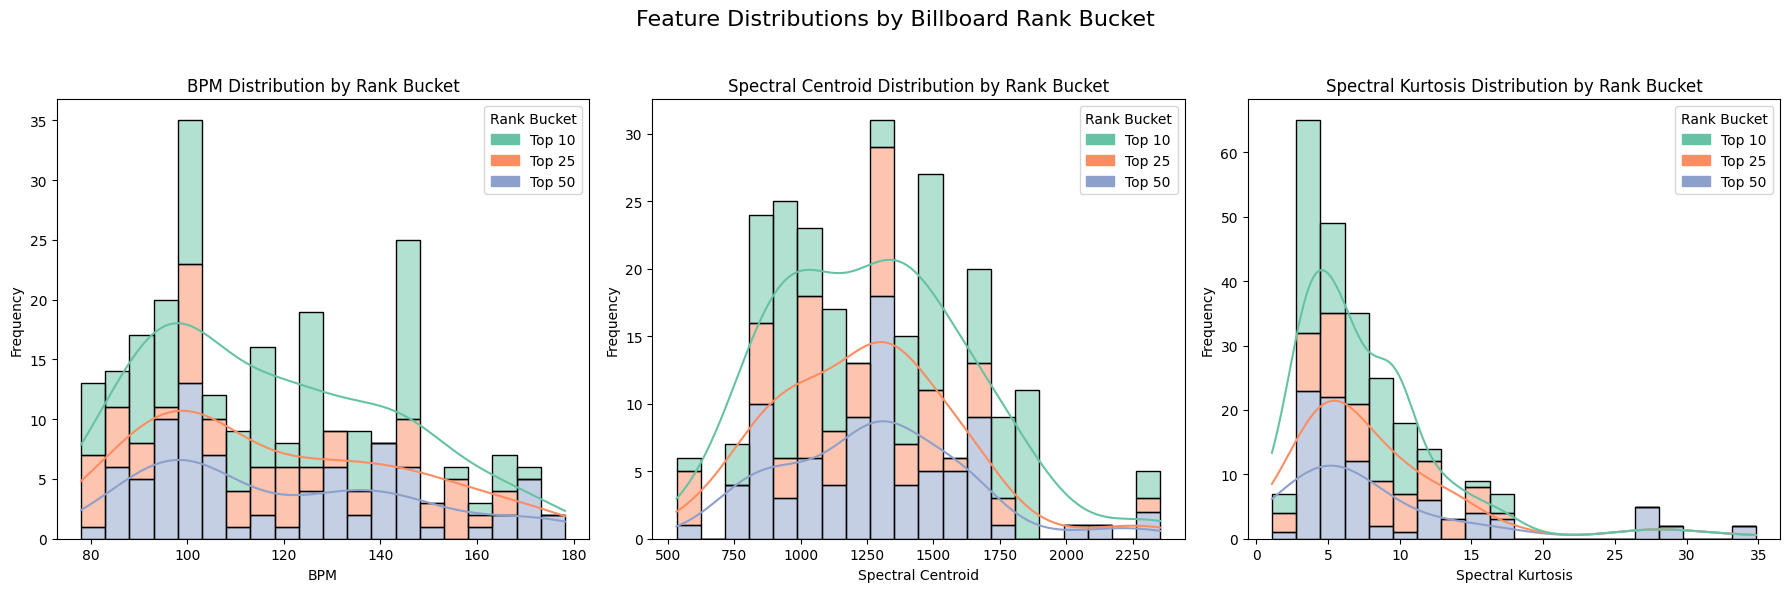

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map internal bucket names to display-friendly labels
display_labels = {'Top10': 'Top 10', 'Top25': 'Top 25', 'Top50': 'Top 50'}
bucket_order = ['Top10', 'Top25', 'Top50']
colors = sns.color_palette("Set2", n_colors=3)

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Feature Distributions by Billboard Rank Bucket', fontsize=16)

# Function to handle legend formatting
def custom_legend(ax, bucket_order, display_labels, colors):
    from matplotlib.patches import Patch
    handles = [Patch(color=colors[i], label=display_labels[b]) for i, b in enumerate(bucket_order)]
    ax.legend(handles=handles, title='Rank Bucket')

# --- 1. BPM ---
sns.histplot(data=merged_df, x='bpm', hue='bucket', hue_order=bucket_order,
             kde=True, multiple='stack', ax=axs[0], palette=colors, bins=20, legend=False)
axs[0].set_title('BPM Distribution by Rank Bucket')
axs[0].set_xlabel('BPM')
axs[0].set_ylabel('Frequency')
custom_legend(axs[0], bucket_order, display_labels, colors)

# --- 2. Spectral Centroid ---
sns.histplot(data=merged_df, x='spectral_centroid', hue='bucket', hue_order=bucket_order,
             kde=True, multiple='stack', ax=axs[1], palette=colors, bins=20, legend=False)
axs[1].set_title('Spectral Centroid Distribution by Rank Bucket')
axs[1].set_xlabel('Spectral Centroid')
axs[1].set_ylabel('Frequency')
custom_legend(axs[1], bucket_order, display_labels, colors)

# --- 3. Spectral Kurtosis ---
sns.histplot(data=merged_df, x='spectral_kurtosis', hue='bucket', hue_order=bucket_order,
             kde=True, multiple='stack', ax=axs[2], palette=colors, bins=20, legend=False)
axs[2].set_title('Spectral Kurtosis Distribution by Rank Bucket')
axs[2].set_xlabel('Spectral Kurtosis')
axs[2].set_ylabel('Frequency')
custom_legend(axs[2], bucket_order, display_labels, colors)

# Final layout adjustments
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
baseline_prediction = 'Top50'  # or 'Top25' if your lowest is that
merged_df['baseline_pred'] = baseline_prediction

from sklearn.metrics import accuracy_score

baseline_accuracy = accuracy_score(merged_df['bucket'], merged_df['baseline_pred'])
print(f"Baseline Accuracy: {baseline_accuracy:.3f}")


from sklearn.metrics import accuracy_score

model_accuracy = accuracy_score(y_true, y_pred)
print(f"Neural Network Accuracy: {model_accuracy:.3f}")


# Other Options...

# Assume the baseline is less than the average 10.455 weeks on the Billboard Chart?
# Assume the baseline is Non-Hit? (Average is 38.240)

Baseline Accuracy: 0.344


NameError: name 'y_true' is not defined

In [ ]:
baseline_prediction = 'Top50'  # or 'Top25' if your lowest is that
merged_df['baseline_pred'] = baseline_prediction

from sklearn.metrics import accuracy_score

baseline_accuracy = accuracy_score(merged_df['bucket'], merged_df['baseline_pred'])
print(f"Baseline Accuracy: {baseline_accuracy:.3f}")

# Get model predictions
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Calculate model accuracy
model_accuracy = accuracy_score(y_test, y_pred)  # Use y_test as y_true
print(f"Neural Network Accuracy: {model_accuracy:.3f}")

Baseline Accuracy: 0.344
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Neural Network Accuracy: 0.408


# Save Figure

In [ ]:
fig.savefig("billboard_feature_distributions.png", dpi=300)